<h1>Adversarial autoencoder</h1>

문제가 생기는부분은 semi-supervised autoencoder부분이라 앞부분은 그냥 넘어가셔도 됩니다.  

11/12 : 1차디버그 완료. 정상적인 훈련이 되긴 했는데 논문에 비해 훨씬 불안정합니다. 아직도 lr을 1/10으로 줄여야 학습ㅁ이 되고 이 이상으로 올리면 collapse하거나 발산해버립니다.

바로가기 :  

[semi-supervsied autoencoder](#ssaae)

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_swiss_roll

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_test_ohe = tf.keras.utils.to_categorical(y_test)
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

<h3>adversarial autoencoder</h3>

In [23]:
class AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, prior_distribution = 'normal'):
        super(AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        if prior_distribution not in ['normal', 'roll']:
            raise ValueError('prior must be normal or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z):
        output = self.discriminator_z(z)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.losses.binary_crossentropy(x, reconstruction))
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'normal':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    for _ in range(2):
        with tf.GradientTape() as tape:
            latent_z = model.encode(x)
            fake_z_output = model.discriminate_z(latent_z)
            generator_z_loss = compute_generator_loss(fake_z_output)
        g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'normal':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    if model.prior_distribution == 'roll':
        true_output_z = tf.convert_to_tensor(make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)[0][:,[0,2]], dtype = 'float32')
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [46]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(5000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

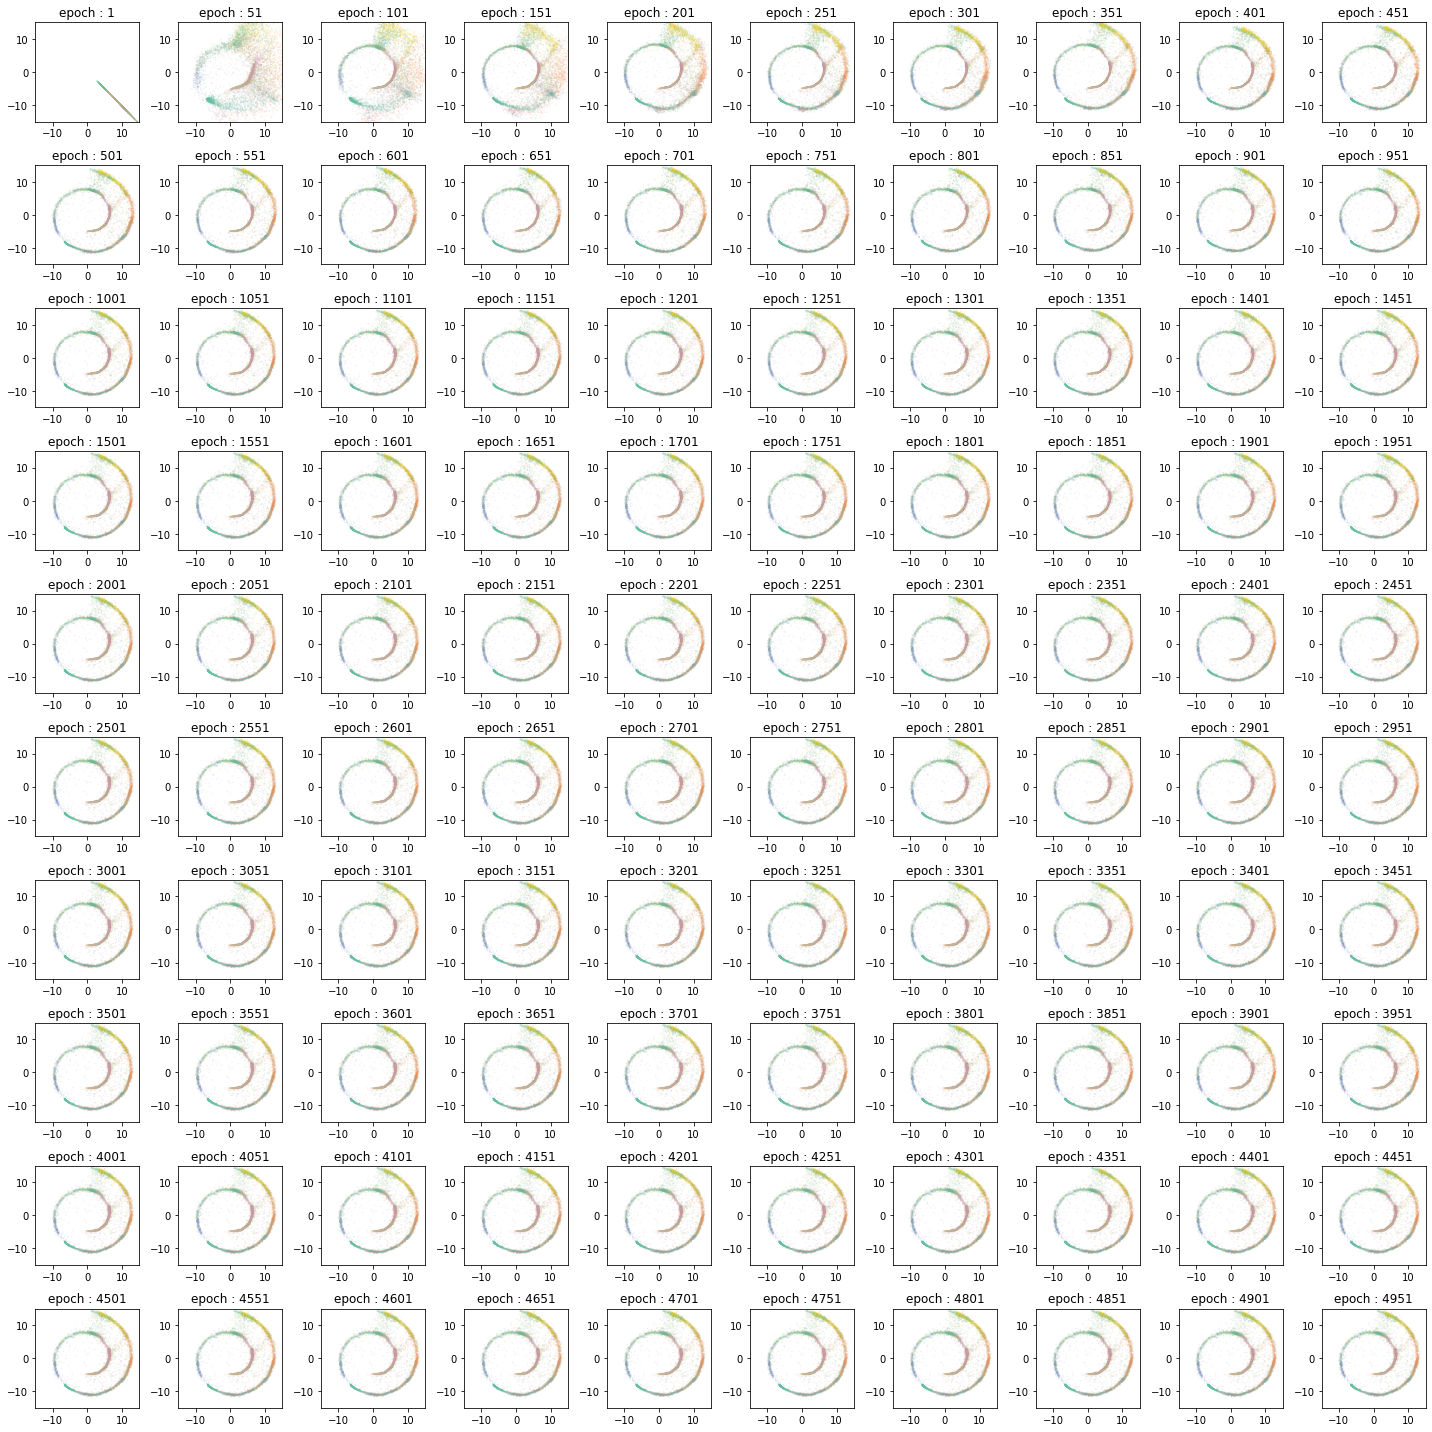

In [51]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 50][:,0], latent_history[i * 50][:,1], c = y_test, cmap = plt.cm.Set2, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 50) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

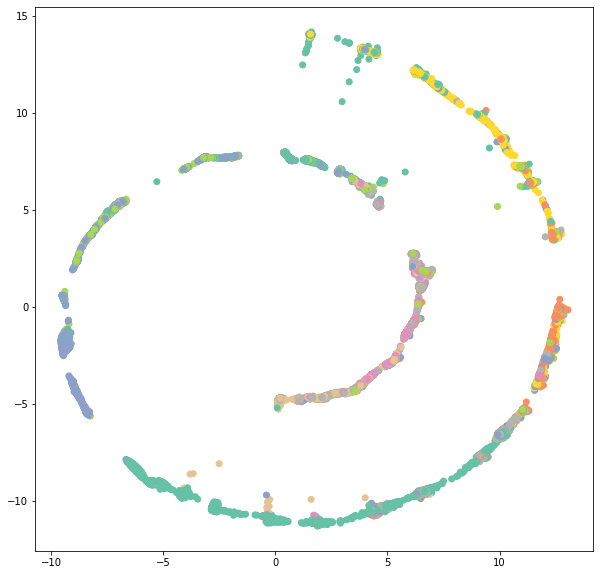

In [58]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = aae.encode(x_train)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_train, cmap = plt.cm.Set2)

In [24]:
aae = AAE(2, 1000, 2, len(x_train[0]), prior_distribution = 'normal')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum=.9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .1, momentum=.1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .1, momentum=.1)

In [25]:
latent_history = []
for i in tqdm(range(1000)):
#     if i == 499:
#         r_optimizer.lr = .001
#         d_optimizer.lr = .01
#         g_optimizer.lr = .01
#     elif i == 2499:
#         r_optimizer.lr = .0001
#         d_optimizer.lr = .001
#         g_optimizer.lr = .001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(aae, x_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(aae, x_test)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|                                                                               | 1/1000 [00:06<1:40:37,  6.04s/it]

epoch : 0 train set : [ reconstruction_loss : 0.6868156790733337, discriminator_loss : 1.3471152782440186, generator_loss : 0.7515005469322205]
 test set : [ reconstruction_loss : 0.6801872253417969, discriminator_loss : 1.177322268486023, generator_loss : 1.051449179649353]


  0%|▏                                                                              | 2/1000 [00:11<1:29:55,  5.41s/it]

epoch : 1 train set : [ reconstruction_loss : 0.6727787852287292, discriminator_loss : 1.3545714616775513, generator_loss : 0.7542537450790405]
 test set : [ reconstruction_loss : 0.6642645001411438, discriminator_loss : 1.2645518779754639, generator_loss : 0.8944927453994751]


  0%|▏                                                                              | 3/1000 [00:15<1:25:42,  5.16s/it]

epoch : 2 train set : [ reconstruction_loss : 0.6509240865707397, discriminator_loss : 1.360666036605835, generator_loss : 0.7443126440048218]
 test set : [ reconstruction_loss : 0.6321074366569519, discriminator_loss : 1.2441916465759277, generator_loss : 0.689422070980072]


  0%|▎                                                                              | 4/1000 [00:20<1:23:55,  5.06s/it]

epoch : 3 train set : [ reconstruction_loss : 0.5739629864692688, discriminator_loss : 1.3754962682724, generator_loss : 0.7197222709655762]
 test set : [ reconstruction_loss : 0.47068119049072266, discriminator_loss : 1.4056037664413452, generator_loss : 0.7909050583839417]


  0%|▍                                                                              | 5/1000 [00:25<1:22:35,  4.98s/it]

epoch : 4 train set : [ reconstruction_loss : 0.32813283801078796, discriminator_loss : 1.3831329345703125, generator_loss : 0.7059339284896851]
 test set : [ reconstruction_loss : 0.27447134256362915, discriminator_loss : 1.3668434619903564, generator_loss : 0.7445637583732605]


  1%|▍                                                                              | 6/1000 [00:30<1:21:26,  4.92s/it]

epoch : 5 train set : [ reconstruction_loss : 0.26988670229911804, discriminator_loss : 1.381638526916504, generator_loss : 0.7079370021820068]
 test set : [ reconstruction_loss : 0.2662307024002075, discriminator_loss : 1.36085844039917, generator_loss : 0.7521018385887146]


  1%|▌                                                                              | 7/1000 [00:35<1:21:07,  4.90s/it]

epoch : 6 train set : [ reconstruction_loss : 0.26527923345565796, discriminator_loss : 1.3791186809539795, generator_loss : 0.7085639238357544]
 test set : [ reconstruction_loss : 0.26382479071617126, discriminator_loss : 1.380779504776001, generator_loss : 0.7631679773330688]


  1%|▋                                                                              | 8/1000 [00:40<1:21:15,  4.92s/it]

epoch : 7 train set : [ reconstruction_loss : 0.26259613037109375, discriminator_loss : 1.3828266859054565, generator_loss : 0.7069896459579468]
 test set : [ reconstruction_loss : 0.2630271911621094, discriminator_loss : 1.356812596321106, generator_loss : 0.6979745626449585]


  1%|▋                                                                              | 9/1000 [00:45<1:20:34,  4.88s/it]

epoch : 8 train set : [ reconstruction_loss : 0.26329657435417175, discriminator_loss : 1.382767915725708, generator_loss : 0.7031513452529907]
 test set : [ reconstruction_loss : 0.26098334789276123, discriminator_loss : 1.3639010190963745, generator_loss : 0.6949419379234314]


  1%|▊                                                                             | 10/1000 [00:49<1:20:31,  4.88s/it]

epoch : 9 train set : [ reconstruction_loss : 0.26518046855926514, discriminator_loss : 1.3829843997955322, generator_loss : 0.7004445195198059]
 test set : [ reconstruction_loss : 0.2636476457118988, discriminator_loss : 1.3657312393188477, generator_loss : 0.7061264514923096]


  1%|▊                                                                             | 11/1000 [00:54<1:19:35,  4.83s/it]

epoch : 10 train set : [ reconstruction_loss : 0.2637682557106018, discriminator_loss : 1.37762451171875, generator_loss : 0.7122676372528076]
 test set : [ reconstruction_loss : 0.2629779875278473, discriminator_loss : 1.3827741146087646, generator_loss : 0.7445639967918396]


  1%|▉                                                                             | 12/1000 [00:59<1:18:30,  4.77s/it]

epoch : 11 train set : [ reconstruction_loss : 0.26214420795440674, discriminator_loss : 1.3864402770996094, generator_loss : 0.6972069144248962]
 test set : [ reconstruction_loss : 0.26068636775016785, discriminator_loss : 1.3780931234359741, generator_loss : 0.7137748599052429]


  1%|█                                                                             | 13/1000 [01:03<1:17:42,  4.72s/it]

epoch : 12 train set : [ reconstruction_loss : 0.26145827770233154, discriminator_loss : 1.385117769241333, generator_loss : 0.6982808709144592]
 test set : [ reconstruction_loss : 0.25929516553878784, discriminator_loss : 1.3840289115905762, generator_loss : 0.6907756924629211]


  1%|█                                                                             | 14/1000 [01:08<1:17:07,  4.69s/it]

epoch : 13 train set : [ reconstruction_loss : 0.25975149869918823, discriminator_loss : 1.3841285705566406, generator_loss : 0.6978835463523865]
 test set : [ reconstruction_loss : 0.2587103247642517, discriminator_loss : 1.3903415203094482, generator_loss : 0.7054949402809143]


  2%|█▏                                                                            | 15/1000 [01:13<1:17:22,  4.71s/it]

epoch : 14 train set : [ reconstruction_loss : 0.2592419385910034, discriminator_loss : 1.3845653533935547, generator_loss : 0.6966540813446045]
 test set : [ reconstruction_loss : 0.25797325372695923, discriminator_loss : 1.3871692419052124, generator_loss : 0.6890429854393005]


  2%|█▏                                                                            | 16/1000 [01:18<1:19:09,  4.83s/it]

epoch : 15 train set : [ reconstruction_loss : 0.2569667398929596, discriminator_loss : 1.3855078220367432, generator_loss : 0.693215012550354]
 test set : [ reconstruction_loss : 0.2563481032848358, discriminator_loss : 1.3870755434036255, generator_loss : 0.6882636547088623]


  2%|█▎                                                                            | 17/1000 [01:22<1:18:08,  4.77s/it]

epoch : 16 train set : [ reconstruction_loss : 0.25634339451789856, discriminator_loss : 1.3866602182388306, generator_loss : 0.6931643486022949]
 test set : [ reconstruction_loss : 0.2556743025779724, discriminator_loss : 1.3857221603393555, generator_loss : 0.6970741152763367]


  2%|█▍                                                                            | 18/1000 [01:27<1:17:25,  4.73s/it]

epoch : 17 train set : [ reconstruction_loss : 0.25517284870147705, discriminator_loss : 1.386372685432434, generator_loss : 0.6937357783317566]
 test set : [ reconstruction_loss : 0.25508612394332886, discriminator_loss : 1.3861994743347168, generator_loss : 0.6935923099517822]


  2%|█▍                                                                            | 19/1000 [01:32<1:16:44,  4.69s/it]

epoch : 18 train set : [ reconstruction_loss : 0.25441575050354004, discriminator_loss : 1.3864102363586426, generator_loss : 0.6936288475990295]
 test set : [ reconstruction_loss : 0.25460678339004517, discriminator_loss : 1.3862136602401733, generator_loss : 0.6945474147796631]


  2%|█▌                                                                            | 20/1000 [01:36<1:16:19,  4.67s/it]

epoch : 19 train set : [ reconstruction_loss : 0.25402596592903137, discriminator_loss : 1.3864479064941406, generator_loss : 0.6927914619445801]
 test set : [ reconstruction_loss : 0.2538711726665497, discriminator_loss : 1.386657476425171, generator_loss : 0.689658522605896]


  2%|█▋                                                                            | 21/1000 [01:41<1:15:58,  4.66s/it]

epoch : 20 train set : [ reconstruction_loss : 0.25334614515304565, discriminator_loss : 1.386277198791504, generator_loss : 0.6935936212539673]
 test set : [ reconstruction_loss : 0.2530955672264099, discriminator_loss : 1.3863239288330078, generator_loss : 0.6924696564674377]


  2%|█▋                                                                            | 22/1000 [01:46<1:15:37,  4.64s/it]

epoch : 21 train set : [ reconstruction_loss : 0.2529990077018738, discriminator_loss : 1.3862496614456177, generator_loss : 0.6929974555969238]
 test set : [ reconstruction_loss : 0.25322866439819336, discriminator_loss : 1.3864551782608032, generator_loss : 0.6899188756942749]


  2%|█▊                                                                            | 23/1000 [01:50<1:15:30,  4.64s/it]

epoch : 22 train set : [ reconstruction_loss : 0.2526802122592926, discriminator_loss : 1.386227011680603, generator_loss : 0.6932803392410278]
 test set : [ reconstruction_loss : 0.2522256672382355, discriminator_loss : 1.3862569332122803, generator_loss : 0.6922897696495056]


  2%|█▊                                                                            | 24/1000 [01:55<1:15:16,  4.63s/it]

epoch : 23 train set : [ reconstruction_loss : 0.2524662911891937, discriminator_loss : 1.3861981630325317, generator_loss : 0.6935736536979675]
 test set : [ reconstruction_loss : 0.25192734599113464, discriminator_loss : 1.3854217529296875, generator_loss : 0.6919617056846619]


  2%|█▉                                                                            | 25/1000 [02:00<1:16:41,  4.72s/it]

epoch : 24 train set : [ reconstruction_loss : 0.25201329588890076, discriminator_loss : 1.3861324787139893, generator_loss : 0.6934215426445007]
 test set : [ reconstruction_loss : 0.25174713134765625, discriminator_loss : 1.3864922523498535, generator_loss : 0.6934686303138733]


  3%|██                                                                            | 26/1000 [02:05<1:17:50,  4.80s/it]

epoch : 25 train set : [ reconstruction_loss : 0.2515580952167511, discriminator_loss : 1.386181354522705, generator_loss : 0.6931269764900208]
 test set : [ reconstruction_loss : 0.25122982263565063, discriminator_loss : 1.3861274719238281, generator_loss : 0.6927854418754578]


  3%|██                                                                            | 27/1000 [02:09<1:17:45,  4.79s/it]

epoch : 26 train set : [ reconstruction_loss : 0.2511509954929352, discriminator_loss : 1.3861607313156128, generator_loss : 0.6933324933052063]
 test set : [ reconstruction_loss : 0.25080230832099915, discriminator_loss : 1.3861279487609863, generator_loss : 0.6970958113670349]


  3%|██▏                                                                           | 28/1000 [02:14<1:17:02,  4.76s/it]

epoch : 27 train set : [ reconstruction_loss : 0.25052374601364136, discriminator_loss : 1.3861783742904663, generator_loss : 0.6933143138885498]
 test set : [ reconstruction_loss : 0.2502196729183197, discriminator_loss : 1.3860886096954346, generator_loss : 0.6942194104194641]


  3%|██▎                                                                           | 29/1000 [02:19<1:16:35,  4.73s/it]

epoch : 28 train set : [ reconstruction_loss : 0.2499217540025711, discriminator_loss : 1.3862046003341675, generator_loss : 0.693256676197052]
 test set : [ reconstruction_loss : 0.24954423308372498, discriminator_loss : 1.3866782188415527, generator_loss : 0.6917670369148254]


  3%|██▎                                                                           | 30/1000 [02:23<1:16:09,  4.71s/it]

epoch : 29 train set : [ reconstruction_loss : 0.24902524054050446, discriminator_loss : 1.3861719369888306, generator_loss : 0.6933535933494568]
 test set : [ reconstruction_loss : 0.24858525395393372, discriminator_loss : 1.3864994049072266, generator_loss : 0.6931340098381042]


  3%|██▍                                                                           | 31/1000 [02:28<1:15:56,  4.70s/it]

epoch : 30 train set : [ reconstruction_loss : 0.24784311652183533, discriminator_loss : 1.3861724138259888, generator_loss : 0.6932550072669983]
 test set : [ reconstruction_loss : 0.2467402070760727, discriminator_loss : 1.3860836029052734, generator_loss : 0.6921001672744751]


  3%|██▍                                                                           | 32/1000 [02:33<1:15:38,  4.69s/it]

epoch : 31 train set : [ reconstruction_loss : 0.24645859003067017, discriminator_loss : 1.3861489295959473, generator_loss : 0.6933135986328125]
 test set : [ reconstruction_loss : 0.24555468559265137, discriminator_loss : 1.3863942623138428, generator_loss : 0.6910437345504761]


  3%|██▌                                                                           | 33/1000 [02:38<1:15:30,  4.68s/it]

epoch : 32 train set : [ reconstruction_loss : 0.24485494196414948, discriminator_loss : 1.3862102031707764, generator_loss : 0.6932751536369324]
 test set : [ reconstruction_loss : 0.24357685446739197, discriminator_loss : 1.3863906860351562, generator_loss : 0.6939644813537598]


  3%|██▋                                                                           | 34/1000 [02:42<1:15:21,  4.68s/it]

epoch : 33 train set : [ reconstruction_loss : 0.24303579330444336, discriminator_loss : 1.3862124681472778, generator_loss : 0.6932464241981506]
 test set : [ reconstruction_loss : 0.24193903803825378, discriminator_loss : 1.3865691423416138, generator_loss : 0.6906130909919739]


  4%|██▋                                                                           | 35/1000 [02:47<1:15:17,  4.68s/it]

epoch : 34 train set : [ reconstruction_loss : 0.24126257002353668, discriminator_loss : 1.3861948251724243, generator_loss : 0.6932870745658875]
 test set : [ reconstruction_loss : 0.24052272737026215, discriminator_loss : 1.3864980936050415, generator_loss : 0.6919833421707153]


  4%|██▊                                                                           | 36/1000 [02:52<1:15:23,  4.69s/it]

epoch : 35 train set : [ reconstruction_loss : 0.23970942199230194, discriminator_loss : 1.3861840963363647, generator_loss : 0.6932004690170288]
 test set : [ reconstruction_loss : 0.23866643011569977, discriminator_loss : 1.3862985372543335, generator_loss : 0.6916387677192688]


  4%|██▉                                                                           | 37/1000 [02:56<1:15:12,  4.69s/it]

epoch : 36 train set : [ reconstruction_loss : 0.2384709119796753, discriminator_loss : 1.3861950635910034, generator_loss : 0.693265974521637]
 test set : [ reconstruction_loss : 0.2372150421142578, discriminator_loss : 1.386094093322754, generator_loss : 0.6934530735015869]


  4%|██▉                                                                           | 38/1000 [03:01<1:15:00,  4.68s/it]

epoch : 37 train set : [ reconstruction_loss : 0.23742078244686127, discriminator_loss : 1.3861594200134277, generator_loss : 0.6932405829429626]
 test set : [ reconstruction_loss : 0.23648642003536224, discriminator_loss : 1.386156678199768, generator_loss : 0.6938788890838623]


  4%|███                                                                           | 39/1000 [03:06<1:14:51,  4.67s/it]

epoch : 38 train set : [ reconstruction_loss : 0.23644256591796875, discriminator_loss : 1.3861336708068848, generator_loss : 0.693286657333374]
 test set : [ reconstruction_loss : 0.235640287399292, discriminator_loss : 1.3863980770111084, generator_loss : 0.691281259059906]


  4%|███                                                                           | 40/1000 [03:10<1:15:33,  4.72s/it]

epoch : 39 train set : [ reconstruction_loss : 0.23559987545013428, discriminator_loss : 1.386159062385559, generator_loss : 0.6932688355445862]
 test set : [ reconstruction_loss : 0.23447856307029724, discriminator_loss : 1.386257529258728, generator_loss : 0.6916975378990173]


  4%|███▏                                                                          | 41/1000 [03:16<1:18:31,  4.91s/it]

epoch : 40 train set : [ reconstruction_loss : 0.23471073806285858, discriminator_loss : 1.3861591815948486, generator_loss : 0.6933230757713318]
 test set : [ reconstruction_loss : 0.23342841863632202, discriminator_loss : 1.3862109184265137, generator_loss : 0.6930274963378906]


  4%|███▎                                                                          | 42/1000 [03:21<1:20:22,  5.03s/it]

epoch : 41 train set : [ reconstruction_loss : 0.23378799855709076, discriminator_loss : 1.3861572742462158, generator_loss : 0.6932593584060669]
 test set : [ reconstruction_loss : 0.23239800333976746, discriminator_loss : 1.3861143589019775, generator_loss : 0.6949447393417358]


  4%|███▎                                                                          | 43/1000 [03:26<1:19:32,  4.99s/it]

epoch : 42 train set : [ reconstruction_loss : 0.23287464678287506, discriminator_loss : 1.3861664533615112, generator_loss : 0.6932820677757263]
 test set : [ reconstruction_loss : 0.2315749228000641, discriminator_loss : 1.3861968517303467, generator_loss : 0.692730724811554]


  4%|███▍                                                                          | 44/1000 [03:31<1:18:35,  4.93s/it]

epoch : 43 train set : [ reconstruction_loss : 0.2320259064435959, discriminator_loss : 1.3861597776412964, generator_loss : 0.6932803392410278]
 test set : [ reconstruction_loss : 0.23064328730106354, discriminator_loss : 1.3862178325653076, generator_loss : 0.6931008696556091]


  4%|███▌                                                                          | 45/1000 [03:36<1:17:42,  4.88s/it]

epoch : 44 train set : [ reconstruction_loss : 0.2313094288110733, discriminator_loss : 1.3861727714538574, generator_loss : 0.6933058500289917]
 test set : [ reconstruction_loss : 0.22984209656715393, discriminator_loss : 1.3861377239227295, generator_loss : 0.6940897703170776]


  5%|███▌                                                                          | 46/1000 [03:40<1:16:39,  4.82s/it]

epoch : 45 train set : [ reconstruction_loss : 0.2305733561515808, discriminator_loss : 1.386152744293213, generator_loss : 0.6932283639907837]
 test set : [ reconstruction_loss : 0.22934605181217194, discriminator_loss : 1.3863227367401123, generator_loss : 0.6926531195640564]


  5%|███▋                                                                          | 47/1000 [03:45<1:16:14,  4.80s/it]

epoch : 46 train set : [ reconstruction_loss : 0.23009145259857178, discriminator_loss : 1.3861855268478394, generator_loss : 0.6932692527770996]
 test set : [ reconstruction_loss : 0.22863070666790009, discriminator_loss : 1.3861979246139526, generator_loss : 0.6937419772148132]


  5%|███▋                                                                          | 48/1000 [03:50<1:15:43,  4.77s/it]

epoch : 47 train set : [ reconstruction_loss : 0.22956834733486176, discriminator_loss : 1.3861899375915527, generator_loss : 0.693311333656311]
 test set : [ reconstruction_loss : 0.22809140384197235, discriminator_loss : 1.3861418962478638, generator_loss : 0.6919373869895935]


  5%|███▊                                                                          | 49/1000 [03:54<1:15:18,  4.75s/it]

epoch : 48 train set : [ reconstruction_loss : 0.22914718091487885, discriminator_loss : 1.3861757516860962, generator_loss : 0.6932673454284668]
 test set : [ reconstruction_loss : 0.22764530777931213, discriminator_loss : 1.3861054182052612, generator_loss : 0.6944690942764282]


  5%|███▉                                                                          | 50/1000 [03:59<1:14:41,  4.72s/it]

epoch : 49 train set : [ reconstruction_loss : 0.2288968414068222, discriminator_loss : 1.386202096939087, generator_loss : 0.6932435035705566]
 test set : [ reconstruction_loss : 0.22752143442630768, discriminator_loss : 1.3864049911499023, generator_loss : 0.692815899848938]


  5%|███▉                                                                          | 51/1000 [04:04<1:14:44,  4.73s/it]

epoch : 50 train set : [ reconstruction_loss : 0.22857122123241425, discriminator_loss : 1.3861916065216064, generator_loss : 0.6933127641677856]
 test set : [ reconstruction_loss : 0.2271929234266281, discriminator_loss : 1.3862512111663818, generator_loss : 0.6940973401069641]


  5%|████                                                                          | 52/1000 [04:09<1:15:06,  4.75s/it]

epoch : 51 train set : [ reconstruction_loss : 0.22830171883106232, discriminator_loss : 1.3862121105194092, generator_loss : 0.6933296918869019]
 test set : [ reconstruction_loss : 0.2270406186580658, discriminator_loss : 1.3862800598144531, generator_loss : 0.6929328441619873]


  5%|████▏                                                                         | 53/1000 [04:13<1:14:55,  4.75s/it]

epoch : 52 train set : [ reconstruction_loss : 0.22812753915786743, discriminator_loss : 1.3861920833587646, generator_loss : 0.693274736404419]
 test set : [ reconstruction_loss : 0.22706086933612823, discriminator_loss : 1.386495590209961, generator_loss : 0.6913924813270569]


  5%|████▏                                                                         | 54/1000 [04:18<1:14:43,  4.74s/it]

epoch : 53 train set : [ reconstruction_loss : 0.22789108753204346, discriminator_loss : 1.3862206935882568, generator_loss : 0.6932386159896851]
 test set : [ reconstruction_loss : 0.22661182284355164, discriminator_loss : 1.386391520500183, generator_loss : 0.6915236115455627]


  6%|████▎                                                                         | 55/1000 [04:23<1:14:08,  4.71s/it]

epoch : 54 train set : [ reconstruction_loss : 0.22764699161052704, discriminator_loss : 1.3862335681915283, generator_loss : 0.693248987197876]
 test set : [ reconstruction_loss : 0.22634336352348328, discriminator_loss : 1.386413335800171, generator_loss : 0.6923454999923706]


  6%|████▎                                                                         | 56/1000 [04:27<1:13:34,  4.68s/it]

epoch : 55 train set : [ reconstruction_loss : 0.22738265991210938, discriminator_loss : 1.3862141370773315, generator_loss : 0.6932424306869507]
 test set : [ reconstruction_loss : 0.22595161199569702, discriminator_loss : 1.3861680030822754, generator_loss : 0.6933167576789856]


  6%|████▍                                                                         | 57/1000 [04:32<1:13:30,  4.68s/it]

epoch : 56 train set : [ reconstruction_loss : 0.22723175585269928, discriminator_loss : 1.3862371444702148, generator_loss : 0.6932676434516907]
 test set : [ reconstruction_loss : 0.22616782784461975, discriminator_loss : 1.3863987922668457, generator_loss : 0.6931185722351074]


  6%|████▌                                                                         | 58/1000 [04:37<1:13:03,  4.65s/it]

epoch : 57 train set : [ reconstruction_loss : 0.2269924134016037, discriminator_loss : 1.386226773262024, generator_loss : 0.6933083534240723]
 test set : [ reconstruction_loss : 0.22575214505195618, discriminator_loss : 1.3863039016723633, generator_loss : 0.6927510499954224]


  6%|████▌                                                                         | 59/1000 [04:41<1:14:19,  4.74s/it]

epoch : 58 train set : [ reconstruction_loss : 0.22688089311122894, discriminator_loss : 1.3862509727478027, generator_loss : 0.6931376457214355]
 test set : [ reconstruction_loss : 0.22555170953273773, discriminator_loss : 1.3862495422363281, generator_loss : 0.6949046850204468]


  6%|████▋                                                                         | 60/1000 [04:46<1:15:25,  4.81s/it]

epoch : 59 train set : [ reconstruction_loss : 0.22668004035949707, discriminator_loss : 1.3862178325653076, generator_loss : 0.6933006644248962]
 test set : [ reconstruction_loss : 0.22541400790214539, discriminator_loss : 1.3864173889160156, generator_loss : 0.693985641002655]


  6%|████▊                                                                         | 61/1000 [04:51<1:15:13,  4.81s/it]

epoch : 60 train set : [ reconstruction_loss : 0.22650960087776184, discriminator_loss : 1.3862495422363281, generator_loss : 0.6932333111763]
 test set : [ reconstruction_loss : 0.22501516342163086, discriminator_loss : 1.3861513137817383, generator_loss : 0.6927435994148254]


  6%|████▊                                                                         | 62/1000 [04:56<1:14:36,  4.77s/it]

epoch : 61 train set : [ reconstruction_loss : 0.22630175948143005, discriminator_loss : 1.3862594366073608, generator_loss : 0.6931740045547485]
 test set : [ reconstruction_loss : 0.22492794692516327, discriminator_loss : 1.3863142728805542, generator_loss : 0.6923753023147583]


  6%|████▉                                                                         | 63/1000 [05:01<1:14:23,  4.76s/it]

epoch : 62 train set : [ reconstruction_loss : 0.2262190729379654, discriminator_loss : 1.3862534761428833, generator_loss : 0.6933050751686096]
 test set : [ reconstruction_loss : 0.22446562349796295, discriminator_loss : 1.3861868381500244, generator_loss : 0.6936581134796143]


  6%|████▉                                                                         | 64/1000 [05:05<1:13:46,  4.73s/it]

epoch : 63 train set : [ reconstruction_loss : 0.2259877473115921, discriminator_loss : 1.3862322568893433, generator_loss : 0.6932252049446106]
 test set : [ reconstruction_loss : 0.22483593225479126, discriminator_loss : 1.386206865310669, generator_loss : 0.692237377166748]


  6%|█████                                                                         | 65/1000 [05:10<1:13:21,  4.71s/it]

epoch : 64 train set : [ reconstruction_loss : 0.22581252455711365, discriminator_loss : 1.3862807750701904, generator_loss : 0.6932414770126343]
 test set : [ reconstruction_loss : 0.22449345886707306, discriminator_loss : 1.3863093852996826, generator_loss : 0.691977322101593]


  7%|█████▏                                                                        | 66/1000 [05:15<1:12:58,  4.69s/it]

epoch : 65 train set : [ reconstruction_loss : 0.22560900449752808, discriminator_loss : 1.3862515687942505, generator_loss : 0.6931859254837036]
 test set : [ reconstruction_loss : 0.22462573647499084, discriminator_loss : 1.3865327835083008, generator_loss : 0.6924682259559631]


  7%|█████▏                                                                        | 67/1000 [05:19<1:13:09,  4.70s/it]

epoch : 66 train set : [ reconstruction_loss : 0.22543899714946747, discriminator_loss : 1.3862555027008057, generator_loss : 0.6932072639465332]
 test set : [ reconstruction_loss : 0.2244880348443985, discriminator_loss : 1.3865041732788086, generator_loss : 0.6927739381790161]


  7%|█████▎                                                                        | 68/1000 [05:24<1:12:44,  4.68s/it]

epoch : 67 train set : [ reconstruction_loss : 0.22529225051403046, discriminator_loss : 1.3862495422363281, generator_loss : 0.6932662725448608]
 test set : [ reconstruction_loss : 0.22447341680526733, discriminator_loss : 1.3864833116531372, generator_loss : 0.6926447153091431]


  7%|█████▍                                                                        | 69/1000 [05:29<1:12:29,  4.67s/it]

epoch : 68 train set : [ reconstruction_loss : 0.22512803971767426, discriminator_loss : 1.3862758874893188, generator_loss : 0.6931897401809692]
 test set : [ reconstruction_loss : 0.22370879352092743, discriminator_loss : 1.3863005638122559, generator_loss : 0.6938886642456055]


  7%|█████▍                                                                        | 70/1000 [05:33<1:12:10,  4.66s/it]

epoch : 69 train set : [ reconstruction_loss : 0.22492951154708862, discriminator_loss : 1.3862555027008057, generator_loss : 0.693189799785614]
 test set : [ reconstruction_loss : 0.22405676543712616, discriminator_loss : 1.3865102529525757, generator_loss : 0.6931055784225464]


  7%|█████▌                                                                        | 71/1000 [05:38<1:11:55,  4.65s/it]

epoch : 70 train set : [ reconstruction_loss : 0.22477006912231445, discriminator_loss : 1.3862652778625488, generator_loss : 0.6932216286659241]
 test set : [ reconstruction_loss : 0.223716139793396, discriminator_loss : 1.3864104747772217, generator_loss : 0.6924084424972534]


  7%|█████▌                                                                        | 72/1000 [05:43<1:11:54,  4.65s/it]

epoch : 71 train set : [ reconstruction_loss : 0.22463276982307434, discriminator_loss : 1.3862849473953247, generator_loss : 0.693208634853363]
 test set : [ reconstruction_loss : 0.2233058363199234, discriminator_loss : 1.3863502740859985, generator_loss : 0.6925814151763916]


  7%|█████▋                                                                        | 73/1000 [05:47<1:11:35,  4.63s/it]

epoch : 72 train set : [ reconstruction_loss : 0.22445419430732727, discriminator_loss : 1.3862751722335815, generator_loss : 0.6932206153869629]
 test set : [ reconstruction_loss : 0.22331750392913818, discriminator_loss : 1.3864378929138184, generator_loss : 0.6925918459892273]


  7%|█████▊                                                                        | 74/1000 [05:52<1:11:22,  4.62s/it]

epoch : 73 train set : [ reconstruction_loss : 0.22421613335609436, discriminator_loss : 1.38628089427948, generator_loss : 0.6931736469268799]
 test set : [ reconstruction_loss : 0.2229483425617218, discriminator_loss : 1.3863579034805298, generator_loss : 0.6925479769706726]


  8%|█████▊                                                                        | 75/1000 [05:56<1:11:12,  4.62s/it]

epoch : 74 train set : [ reconstruction_loss : 0.2241026759147644, discriminator_loss : 1.3862828016281128, generator_loss : 0.6932104229927063]
 test set : [ reconstruction_loss : 0.22282135486602783, discriminator_loss : 1.3862602710723877, generator_loss : 0.6934938430786133]


  8%|█████▉                                                                        | 76/1000 [06:01<1:11:02,  4.61s/it]

epoch : 75 train set : [ reconstruction_loss : 0.22385168075561523, discriminator_loss : 1.3862682580947876, generator_loss : 0.6931955814361572]
 test set : [ reconstruction_loss : 0.22250936925411224, discriminator_loss : 1.3863015174865723, generator_loss : 0.6928403973579407]


  8%|██████                                                                        | 77/1000 [06:06<1:10:54,  4.61s/it]

epoch : 76 train set : [ reconstruction_loss : 0.22365257143974304, discriminator_loss : 1.3862518072128296, generator_loss : 0.6932564973831177]
 test set : [ reconstruction_loss : 0.22225473821163177, discriminator_loss : 1.3862881660461426, generator_loss : 0.6938932538032532]


  8%|██████                                                                        | 78/1000 [06:11<1:13:03,  4.75s/it]

epoch : 77 train set : [ reconstruction_loss : 0.22351804375648499, discriminator_loss : 1.3862650394439697, generator_loss : 0.6932260394096375]
 test set : [ reconstruction_loss : 0.22228984534740448, discriminator_loss : 1.3862950801849365, generator_loss : 0.6927658319473267]


  8%|██████▏                                                                       | 79/1000 [06:15<1:13:03,  4.76s/it]

epoch : 78 train set : [ reconstruction_loss : 0.2233077436685562, discriminator_loss : 1.3862800598144531, generator_loss : 0.6931954026222229]
 test set : [ reconstruction_loss : 0.22200536727905273, discriminator_loss : 1.3862688541412354, generator_loss : 0.6937548518180847]


  8%|██████▏                                                                       | 80/1000 [06:20<1:12:35,  4.73s/it]

epoch : 79 train set : [ reconstruction_loss : 0.22311121225357056, discriminator_loss : 1.3862537145614624, generator_loss : 0.693218469619751]
 test set : [ reconstruction_loss : 0.2217518836259842, discriminator_loss : 1.386286973953247, generator_loss : 0.6927185654640198]


  8%|██████▎                                                                       | 81/1000 [06:25<1:12:11,  4.71s/it]

epoch : 80 train set : [ reconstruction_loss : 0.2228868305683136, discriminator_loss : 1.386259913444519, generator_loss : 0.6932365894317627]
 test set : [ reconstruction_loss : 0.221479594707489, discriminator_loss : 1.386319875717163, generator_loss : 0.6927823424339294]


  8%|██████▍                                                                       | 82/1000 [06:29<1:11:46,  4.69s/it]

epoch : 81 train set : [ reconstruction_loss : 0.2227407842874527, discriminator_loss : 1.3862817287445068, generator_loss : 0.6931917071342468]
 test set : [ reconstruction_loss : 0.22123806178569794, discriminator_loss : 1.3862675428390503, generator_loss : 0.6931164860725403]


  8%|██████▍                                                                       | 83/1000 [06:34<1:11:32,  4.68s/it]

epoch : 82 train set : [ reconstruction_loss : 0.2225486785173416, discriminator_loss : 1.386276125907898, generator_loss : 0.6931780576705933]
 test set : [ reconstruction_loss : 0.2211732417345047, discriminator_loss : 1.386380672454834, generator_loss : 0.6928630471229553]


  8%|██████▌                                                                       | 84/1000 [06:39<1:11:55,  4.71s/it]

epoch : 83 train set : [ reconstruction_loss : 0.2223426252603531, discriminator_loss : 1.386265516281128, generator_loss : 0.6932286024093628]
 test set : [ reconstruction_loss : 0.2211489975452423, discriminator_loss : 1.386394739151001, generator_loss : 0.6926942467689514]


  8%|██████▋                                                                       | 85/1000 [06:44<1:12:23,  4.75s/it]

epoch : 84 train set : [ reconstruction_loss : 0.22212855517864227, discriminator_loss : 1.3862684965133667, generator_loss : 0.6932079792022705]
 test set : [ reconstruction_loss : 0.22087277472019196, discriminator_loss : 1.386288046836853, generator_loss : 0.6929864287376404]


  9%|██████▋                                                                       | 86/1000 [06:48<1:12:13,  4.74s/it]

epoch : 85 train set : [ reconstruction_loss : 0.22198572754859924, discriminator_loss : 1.3862839937210083, generator_loss : 0.6931873559951782]
 test set : [ reconstruction_loss : 0.22100287675857544, discriminator_loss : 1.3864507675170898, generator_loss : 0.6928063631057739]


  9%|██████▊                                                                       | 87/1000 [06:53<1:12:18,  4.75s/it]

epoch : 86 train set : [ reconstruction_loss : 0.2216668725013733, discriminator_loss : 1.3862614631652832, generator_loss : 0.6932405829429626]
 test set : [ reconstruction_loss : 0.2204183042049408, discriminator_loss : 1.3862724304199219, generator_loss : 0.6933260560035706]


  9%|██████▊                                                                       | 88/1000 [06:58<1:12:17,  4.76s/it]

epoch : 87 train set : [ reconstruction_loss : 0.22152745723724365, discriminator_loss : 1.3862727880477905, generator_loss : 0.6932000517845154]
 test set : [ reconstruction_loss : 0.2200876772403717, discriminator_loss : 1.3862531185150146, generator_loss : 0.6926234364509583]


  9%|██████▉                                                                       | 89/1000 [07:03<1:12:15,  4.76s/it]

epoch : 88 train set : [ reconstruction_loss : 0.2212996929883957, discriminator_loss : 1.386265516281128, generator_loss : 0.6932007670402527]
 test set : [ reconstruction_loss : 0.22011752426624298, discriminator_loss : 1.3863348960876465, generator_loss : 0.6930754780769348]


  9%|███████                                                                       | 90/1000 [07:07<1:11:58,  4.75s/it]

epoch : 89 train set : [ reconstruction_loss : 0.2211368829011917, discriminator_loss : 1.3862900733947754, generator_loss : 0.6931869983673096]
 test set : [ reconstruction_loss : 0.2198951244354248, discriminator_loss : 1.3863301277160645, generator_loss : 0.6935008764266968]


  9%|███████                                                                       | 91/1000 [07:12<1:11:24,  4.71s/it]

epoch : 90 train set : [ reconstruction_loss : 0.2208971083164215, discriminator_loss : 1.3862707614898682, generator_loss : 0.6931964755058289]
 test set : [ reconstruction_loss : 0.2197161614894867, discriminator_loss : 1.3863109350204468, generator_loss : 0.6930289268493652]


  9%|███████▏                                                                      | 92/1000 [07:17<1:10:53,  4.68s/it]

epoch : 91 train set : [ reconstruction_loss : 0.2206888347864151, discriminator_loss : 1.3862543106079102, generator_loss : 0.6932193040847778]
 test set : [ reconstruction_loss : 0.21947897970676422, discriminator_loss : 1.3863747119903564, generator_loss : 0.6929147243499756]


  9%|███████▎                                                                      | 93/1000 [07:21<1:10:48,  4.68s/it]

epoch : 92 train set : [ reconstruction_loss : 0.22052301466464996, discriminator_loss : 1.386267900466919, generator_loss : 0.6932173371315002]
 test set : [ reconstruction_loss : 0.21901896595954895, discriminator_loss : 1.3862113952636719, generator_loss : 0.6923976540565491]


  9%|███████▎                                                                      | 94/1000 [07:26<1:10:25,  4.66s/it]

epoch : 93 train set : [ reconstruction_loss : 0.2202937752008438, discriminator_loss : 1.3862544298171997, generator_loss : 0.6932073831558228]
 test set : [ reconstruction_loss : 0.218870609998703, discriminator_loss : 1.3862473964691162, generator_loss : 0.6937118768692017]


 10%|███████▍                                                                      | 95/1000 [07:31<1:10:10,  4.65s/it]

epoch : 94 train set : [ reconstruction_loss : 0.22011303901672363, discriminator_loss : 1.3862779140472412, generator_loss : 0.693176805973053]
 test set : [ reconstruction_loss : 0.21860642731189728, discriminator_loss : 1.386214256286621, generator_loss : 0.693568766117096]


 10%|███████▍                                                                      | 96/1000 [07:35<1:09:52,  4.64s/it]

epoch : 95 train set : [ reconstruction_loss : 0.21993540227413177, discriminator_loss : 1.386266827583313, generator_loss : 0.6932031512260437]
 test set : [ reconstruction_loss : 0.21886476874351501, discriminator_loss : 1.3863271474838257, generator_loss : 0.6931065320968628]


 10%|███████▌                                                                      | 97/1000 [07:40<1:09:42,  4.63s/it]

epoch : 96 train set : [ reconstruction_loss : 0.21971547603607178, discriminator_loss : 1.386275053024292, generator_loss : 0.6932092308998108]
 test set : [ reconstruction_loss : 0.21837854385375977, discriminator_loss : 1.3863072395324707, generator_loss : 0.693484365940094]


 10%|███████▋                                                                      | 98/1000 [07:44<1:09:26,  4.62s/it]

epoch : 97 train set : [ reconstruction_loss : 0.2194812297821045, discriminator_loss : 1.386259913444519, generator_loss : 0.6931799054145813]
 test set : [ reconstruction_loss : 0.2181808352470398, discriminator_loss : 1.386263370513916, generator_loss : 0.6930256485939026]


 10%|███████▋                                                                      | 99/1000 [07:49<1:09:18,  4.62s/it]

epoch : 98 train set : [ reconstruction_loss : 0.21931061148643494, discriminator_loss : 1.386252999305725, generator_loss : 0.6932320594787598]
 test set : [ reconstruction_loss : 0.21796391904354095, discriminator_loss : 1.3861808776855469, generator_loss : 0.6929843425750732]


 10%|███████▋                                                                     | 100/1000 [07:54<1:09:11,  4.61s/it]

epoch : 99 train set : [ reconstruction_loss : 0.21914072334766388, discriminator_loss : 1.3862652778625488, generator_loss : 0.6932040452957153]
 test set : [ reconstruction_loss : 0.21766193211078644, discriminator_loss : 1.3862345218658447, generator_loss : 0.6929462552070618]


 10%|███████▊                                                                     | 101/1000 [07:58<1:09:05,  4.61s/it]

epoch : 100 train set : [ reconstruction_loss : 0.21896927058696747, discriminator_loss : 1.3862744569778442, generator_loss : 0.6931977868080139]
 test set : [ reconstruction_loss : 0.21752114593982697, discriminator_loss : 1.3862278461456299, generator_loss : 0.693488597869873]


 10%|███████▊                                                                     | 102/1000 [08:03<1:08:56,  4.61s/it]

epoch : 101 train set : [ reconstruction_loss : 0.21879175305366516, discriminator_loss : 1.3862613439559937, generator_loss : 0.693190336227417]
 test set : [ reconstruction_loss : 0.2172951102256775, discriminator_loss : 1.3862078189849854, generator_loss : 0.6931668519973755]


 10%|███████▉                                                                     | 103/1000 [08:07<1:08:50,  4.60s/it]

epoch : 102 train set : [ reconstruction_loss : 0.2185814380645752, discriminator_loss : 1.3862547874450684, generator_loss : 0.693227231502533]
 test set : [ reconstruction_loss : 0.21725605428218842, discriminator_loss : 1.3863017559051514, generator_loss : 0.6919990181922913]


 10%|████████                                                                     | 104/1000 [08:12<1:08:48,  4.61s/it]

epoch : 103 train set : [ reconstruction_loss : 0.2183772474527359, discriminator_loss : 1.3862556219100952, generator_loss : 0.6932050585746765]
 test set : [ reconstruction_loss : 0.2169932872056961, discriminator_loss : 1.3861303329467773, generator_loss : 0.6935184597969055]


 10%|████████                                                                     | 105/1000 [08:17<1:08:42,  4.61s/it]

epoch : 104 train set : [ reconstruction_loss : 0.2182091325521469, discriminator_loss : 1.3862502574920654, generator_loss : 0.6932251453399658]
 test set : [ reconstruction_loss : 0.21717917919158936, discriminator_loss : 1.3863333463668823, generator_loss : 0.6930341720581055]


 11%|████████▏                                                                    | 106/1000 [08:21<1:08:43,  4.61s/it]

epoch : 105 train set : [ reconstruction_loss : 0.21808217465877533, discriminator_loss : 1.3862888813018799, generator_loss : 0.693153977394104]
 test set : [ reconstruction_loss : 0.2168016880750656, discriminator_loss : 1.386244773864746, generator_loss : 0.6935209631919861]


 11%|████████▏                                                                    | 107/1000 [08:26<1:08:34,  4.61s/it]

epoch : 106 train set : [ reconstruction_loss : 0.21784032881259918, discriminator_loss : 1.3862649202346802, generator_loss : 0.6932162642478943]
 test set : [ reconstruction_loss : 0.2164640873670578, discriminator_loss : 1.3862158060073853, generator_loss : 0.692758321762085]


 11%|████████▎                                                                    | 108/1000 [08:31<1:08:39,  4.62s/it]

epoch : 107 train set : [ reconstruction_loss : 0.2176681011915207, discriminator_loss : 1.3862568140029907, generator_loss : 0.6931717395782471]
 test set : [ reconstruction_loss : 0.21645697951316833, discriminator_loss : 1.3862762451171875, generator_loss : 0.6933807730674744]


 11%|████████▍                                                                    | 109/1000 [08:35<1:08:29,  4.61s/it]

epoch : 108 train set : [ reconstruction_loss : 0.21751174330711365, discriminator_loss : 1.386252760887146, generator_loss : 0.6932464241981506]
 test set : [ reconstruction_loss : 0.2161281704902649, discriminator_loss : 1.3861933946609497, generator_loss : 0.6930242776870728]


 11%|████████▍                                                                    | 110/1000 [08:40<1:08:24,  4.61s/it]

epoch : 109 train set : [ reconstruction_loss : 0.21741287410259247, discriminator_loss : 1.38626229763031, generator_loss : 0.6932341456413269]
 test set : [ reconstruction_loss : 0.21599841117858887, discriminator_loss : 1.386215329170227, generator_loss : 0.6929083466529846]


 11%|████████▌                                                                    | 111/1000 [08:44<1:08:17,  4.61s/it]

epoch : 110 train set : [ reconstruction_loss : 0.2171865850687027, discriminator_loss : 1.386271357536316, generator_loss : 0.6931976079940796]
 test set : [ reconstruction_loss : 0.21578867733478546, discriminator_loss : 1.3861749172210693, generator_loss : 0.693143904209137]


 11%|████████▌                                                                    | 112/1000 [08:49<1:08:11,  4.61s/it]

epoch : 111 train set : [ reconstruction_loss : 0.21701651811599731, discriminator_loss : 1.3862370252609253, generator_loss : 0.6932187676429749]
 test set : [ reconstruction_loss : 0.21563901007175446, discriminator_loss : 1.3861420154571533, generator_loss : 0.6924999356269836]


 11%|████████▋                                                                    | 113/1000 [08:54<1:08:07,  4.61s/it]

epoch : 112 train set : [ reconstruction_loss : 0.2168956696987152, discriminator_loss : 1.3862704038619995, generator_loss : 0.6931982636451721]
 test set : [ reconstruction_loss : 0.2155144214630127, discriminator_loss : 1.386256456375122, generator_loss : 0.6933863162994385]


 11%|████████▊                                                                    | 114/1000 [08:58<1:08:02,  4.61s/it]

epoch : 113 train set : [ reconstruction_loss : 0.21672841906547546, discriminator_loss : 1.386267900466919, generator_loss : 0.6931995749473572]
 test set : [ reconstruction_loss : 0.21560566127300262, discriminator_loss : 1.38620126247406, generator_loss : 0.6926359534263611]


 12%|████████▊                                                                    | 115/1000 [09:03<1:07:58,  4.61s/it]

epoch : 114 train set : [ reconstruction_loss : 0.21656976640224457, discriminator_loss : 1.3862578868865967, generator_loss : 0.6932361125946045]
 test set : [ reconstruction_loss : 0.21529561281204224, discriminator_loss : 1.3862626552581787, generator_loss : 0.6922252178192139]


 12%|████████▉                                                                    | 116/1000 [09:07<1:07:52,  4.61s/it]

epoch : 115 train set : [ reconstruction_loss : 0.21637164056301117, discriminator_loss : 1.3862560987472534, generator_loss : 0.6932461857795715]
 test set : [ reconstruction_loss : 0.21509680151939392, discriminator_loss : 1.3861545324325562, generator_loss : 0.6918050646781921]


 12%|█████████                                                                    | 117/1000 [09:12<1:07:50,  4.61s/it]

epoch : 116 train set : [ reconstruction_loss : 0.21620884537696838, discriminator_loss : 1.386251449584961, generator_loss : 0.6931827068328857]
 test set : [ reconstruction_loss : 0.21520009636878967, discriminator_loss : 1.3863236904144287, generator_loss : 0.6927146911621094]


 12%|█████████                                                                    | 118/1000 [09:17<1:07:45,  4.61s/it]

epoch : 117 train set : [ reconstruction_loss : 0.216114804148674, discriminator_loss : 1.3862707614898682, generator_loss : 0.6932144165039062]
 test set : [ reconstruction_loss : 0.21486933529376984, discriminator_loss : 1.386211633682251, generator_loss : 0.692571222782135]


 12%|█████████▏                                                                   | 119/1000 [09:21<1:07:54,  4.62s/it]

epoch : 118 train set : [ reconstruction_loss : 0.21593280136585236, discriminator_loss : 1.3862495422363281, generator_loss : 0.6932718753814697]
 test set : [ reconstruction_loss : 0.21481052041053772, discriminator_loss : 1.3862135410308838, generator_loss : 0.6921401619911194]


 12%|█████████▏                                                                   | 120/1000 [09:26<1:07:43,  4.62s/it]

epoch : 119 train set : [ reconstruction_loss : 0.21578724682331085, discriminator_loss : 1.3862603902816772, generator_loss : 0.6931583881378174]
 test set : [ reconstruction_loss : 0.21474489569664001, discriminator_loss : 1.3862050771713257, generator_loss : 0.6930068135261536]


 12%|█████████▎                                                                   | 121/1000 [09:30<1:07:40,  4.62s/it]

epoch : 120 train set : [ reconstruction_loss : 0.2156408727169037, discriminator_loss : 1.3862583637237549, generator_loss : 0.693253755569458]
 test set : [ reconstruction_loss : 0.2144271433353424, discriminator_loss : 1.386203408241272, generator_loss : 0.6922587156295776]


 12%|█████████▍                                                                   | 122/1000 [09:35<1:07:30,  4.61s/it]

epoch : 121 train set : [ reconstruction_loss : 0.2154504656791687, discriminator_loss : 1.3862658739089966, generator_loss : 0.6932253241539001]
 test set : [ reconstruction_loss : 0.21429482102394104, discriminator_loss : 1.3861920833587646, generator_loss : 0.69245445728302]


 12%|█████████▍                                                                   | 123/1000 [09:40<1:07:24,  4.61s/it]

epoch : 122 train set : [ reconstruction_loss : 0.21531811356544495, discriminator_loss : 1.386244773864746, generator_loss : 0.6932276487350464]
 test set : [ reconstruction_loss : 0.2140207588672638, discriminator_loss : 1.3862271308898926, generator_loss : 0.6930684447288513]


 12%|█████████▌                                                                   | 124/1000 [09:44<1:07:19,  4.61s/it]

epoch : 123 train set : [ reconstruction_loss : 0.2152455598115921, discriminator_loss : 1.3862659931182861, generator_loss : 0.6932230591773987]
 test set : [ reconstruction_loss : 0.21396103501319885, discriminator_loss : 1.3862199783325195, generator_loss : 0.6926828026771545]


 12%|█████████▋                                                                   | 125/1000 [09:49<1:07:29,  4.63s/it]

epoch : 124 train set : [ reconstruction_loss : 0.21506662666797638, discriminator_loss : 1.3862416744232178, generator_loss : 0.6932278275489807]
 test set : [ reconstruction_loss : 0.21394938230514526, discriminator_loss : 1.3861877918243408, generator_loss : 0.6924504637718201]


 13%|█████████▋                                                                   | 126/1000 [09:54<1:07:21,  4.62s/it]

epoch : 125 train set : [ reconstruction_loss : 0.2149263471364975, discriminator_loss : 1.386277675628662, generator_loss : 0.6931841969490051]
 test set : [ reconstruction_loss : 0.21380658447742462, discriminator_loss : 1.386225938796997, generator_loss : 0.6920445561408997]


 13%|█████████▊                                                                   | 127/1000 [09:58<1:07:11,  4.62s/it]

epoch : 126 train set : [ reconstruction_loss : 0.21476463973522186, discriminator_loss : 1.386239767074585, generator_loss : 0.6932674646377563]
 test set : [ reconstruction_loss : 0.21357592940330505, discriminator_loss : 1.3861693143844604, generator_loss : 0.6922465562820435]


 13%|█████████▊                                                                   | 128/1000 [10:03<1:07:06,  4.62s/it]

epoch : 127 train set : [ reconstruction_loss : 0.21465200185775757, discriminator_loss : 1.3862459659576416, generator_loss : 0.6932488083839417]
 test set : [ reconstruction_loss : 0.21343369781970978, discriminator_loss : 1.3861777782440186, generator_loss : 0.6933321952819824]


 13%|█████████▉                                                                   | 129/1000 [10:07<1:06:59,  4.61s/it]

epoch : 128 train set : [ reconstruction_loss : 0.21444900333881378, discriminator_loss : 1.3862539529800415, generator_loss : 0.6932476758956909]
 test set : [ reconstruction_loss : 0.21322135627269745, discriminator_loss : 1.3861639499664307, generator_loss : 0.6922607421875]


 13%|██████████                                                                   | 130/1000 [10:12<1:06:54,  4.61s/it]

epoch : 129 train set : [ reconstruction_loss : 0.21432113647460938, discriminator_loss : 1.3862637281417847, generator_loss : 0.6931977272033691]
 test set : [ reconstruction_loss : 0.21299077570438385, discriminator_loss : 1.3861924409866333, generator_loss : 0.6924954056739807]


 13%|██████████                                                                   | 131/1000 [10:17<1:06:51,  4.62s/it]

epoch : 130 train set : [ reconstruction_loss : 0.21418477594852448, discriminator_loss : 1.3862534761428833, generator_loss : 0.6932454705238342]
 test set : [ reconstruction_loss : 0.2130114734172821, discriminator_loss : 1.3862025737762451, generator_loss : 0.6928099393844604]


 13%|██████████▏                                                                  | 132/1000 [10:21<1:06:49,  4.62s/it]

epoch : 131 train set : [ reconstruction_loss : 0.21401555836200714, discriminator_loss : 1.3862534761428833, generator_loss : 0.6932535767555237]
 test set : [ reconstruction_loss : 0.21290864050388336, discriminator_loss : 1.3862266540527344, generator_loss : 0.6924753785133362]


 13%|██████████▏                                                                  | 133/1000 [10:26<1:06:39,  4.61s/it]

epoch : 132 train set : [ reconstruction_loss : 0.21388666331768036, discriminator_loss : 1.3862390518188477, generator_loss : 0.6931998133659363]
 test set : [ reconstruction_loss : 0.2127709537744522, discriminator_loss : 1.3861968517303467, generator_loss : 0.6922003626823425]


 13%|██████████▎                                                                  | 134/1000 [10:30<1:06:33,  4.61s/it]

epoch : 133 train set : [ reconstruction_loss : 0.21372993290424347, discriminator_loss : 1.386251449584961, generator_loss : 0.6932690143585205]
 test set : [ reconstruction_loss : 0.212533637881279, discriminator_loss : 1.3861358165740967, generator_loss : 0.6928420066833496]


 14%|██████████▍                                                                  | 135/1000 [10:35<1:06:29,  4.61s/it]

epoch : 134 train set : [ reconstruction_loss : 0.2135869413614273, discriminator_loss : 1.3862497806549072, generator_loss : 0.6932452917098999]
 test set : [ reconstruction_loss : 0.2123962640762329, discriminator_loss : 1.3861794471740723, generator_loss : 0.6924452185630798]


 14%|██████████▍                                                                  | 136/1000 [10:40<1:06:27,  4.61s/it]

epoch : 135 train set : [ reconstruction_loss : 0.21347633004188538, discriminator_loss : 1.3862524032592773, generator_loss : 0.6932497024536133]
 test set : [ reconstruction_loss : 0.21254315972328186, discriminator_loss : 1.386423110961914, generator_loss : 0.6919946074485779]


 14%|██████████▌                                                                  | 137/1000 [10:45<1:09:29,  4.83s/it]

epoch : 136 train set : [ reconstruction_loss : 0.21338798105716705, discriminator_loss : 1.3862621784210205, generator_loss : 0.6932440996170044]
 test set : [ reconstruction_loss : 0.21222776174545288, discriminator_loss : 1.3861083984375, generator_loss : 0.6922870874404907]


 14%|██████████▋                                                                  | 138/1000 [10:50<1:09:46,  4.86s/it]

epoch : 137 train set : [ reconstruction_loss : 0.21319249272346497, discriminator_loss : 1.3862661123275757, generator_loss : 0.6932017803192139]
 test set : [ reconstruction_loss : 0.2120314985513687, discriminator_loss : 1.3862228393554688, generator_loss : 0.6915316581726074]


 14%|██████████▋                                                                  | 139/1000 [10:55<1:08:35,  4.78s/it]

epoch : 138 train set : [ reconstruction_loss : 0.2130248248577118, discriminator_loss : 1.3862543106079102, generator_loss : 0.693270742893219]
 test set : [ reconstruction_loss : 0.21197696030139923, discriminator_loss : 1.3862850666046143, generator_loss : 0.692200779914856]


 14%|██████████▊                                                                  | 140/1000 [11:01<1:14:14,  5.18s/it]

epoch : 139 train set : [ reconstruction_loss : 0.2129267156124115, discriminator_loss : 1.3862528800964355, generator_loss : 0.6931830048561096]
 test set : [ reconstruction_loss : 0.2118804156780243, discriminator_loss : 1.3862783908843994, generator_loss : 0.6915017366409302]


 14%|██████████▊                                                                  | 141/1000 [11:05<1:11:38,  5.00s/it]

epoch : 140 train set : [ reconstruction_loss : 0.21280942857265472, discriminator_loss : 1.3862587213516235, generator_loss : 0.693300187587738]
 test set : [ reconstruction_loss : 0.21162739396095276, discriminator_loss : 1.3861794471740723, generator_loss : 0.6918553709983826]


 14%|██████████▉                                                                  | 142/1000 [11:10<1:09:49,  4.88s/it]

epoch : 141 train set : [ reconstruction_loss : 0.21262122690677643, discriminator_loss : 1.3862764835357666, generator_loss : 0.6932157278060913]
 test set : [ reconstruction_loss : 0.21151354908943176, discriminator_loss : 1.3862357139587402, generator_loss : 0.6919904351234436]


 14%|███████████                                                                  | 143/1000 [11:14<1:08:32,  4.80s/it]

epoch : 142 train set : [ reconstruction_loss : 0.2124568223953247, discriminator_loss : 1.386251449584961, generator_loss : 0.6932572722434998]
 test set : [ reconstruction_loss : 0.21154633164405823, discriminator_loss : 1.3863656520843506, generator_loss : 0.6918598413467407]


 14%|███████████                                                                  | 144/1000 [11:19<1:07:36,  4.74s/it]

epoch : 143 train set : [ reconstruction_loss : 0.2123997062444687, discriminator_loss : 1.386265516281128, generator_loss : 0.693227231502533]
 test set : [ reconstruction_loss : 0.21128018200397491, discriminator_loss : 1.3862266540527344, generator_loss : 0.6925742030143738]


 14%|███████████▏                                                                 | 145/1000 [11:24<1:07:10,  4.71s/it]

epoch : 144 train set : [ reconstruction_loss : 0.21222595870494843, discriminator_loss : 1.3862814903259277, generator_loss : 0.6931923627853394]
 test set : [ reconstruction_loss : 0.21159736812114716, discriminator_loss : 1.386154294013977, generator_loss : 0.6924383044242859]


 15%|███████████▏                                                                 | 146/1000 [11:28<1:06:37,  4.68s/it]

epoch : 145 train set : [ reconstruction_loss : 0.21208907663822174, discriminator_loss : 1.3862662315368652, generator_loss : 0.693293035030365]
 test set : [ reconstruction_loss : 0.21106860041618347, discriminator_loss : 1.3861719369888306, generator_loss : 0.6914135813713074]


 15%|███████████▎                                                                 | 147/1000 [11:33<1:06:17,  4.66s/it]

epoch : 146 train set : [ reconstruction_loss : 0.21199913322925568, discriminator_loss : 1.3862481117248535, generator_loss : 0.6932361721992493]
 test set : [ reconstruction_loss : 0.2110765129327774, discriminator_loss : 1.3862016201019287, generator_loss : 0.6928558349609375]


 15%|███████████▍                                                                 | 148/1000 [11:38<1:06:04,  4.65s/it]

epoch : 147 train set : [ reconstruction_loss : 0.21182407438755035, discriminator_loss : 1.386279582977295, generator_loss : 0.693217396736145]
 test set : [ reconstruction_loss : 0.21078923344612122, discriminator_loss : 1.3861980438232422, generator_loss : 0.6917466521263123]


 15%|███████████▍                                                                 | 149/1000 [11:42<1:05:50,  4.64s/it]

epoch : 148 train set : [ reconstruction_loss : 0.2116411030292511, discriminator_loss : 1.386265516281128, generator_loss : 0.6932193040847778]
 test set : [ reconstruction_loss : 0.21094706654548645, discriminator_loss : 1.3862900733947754, generator_loss : 0.6919659376144409]


 15%|███████████▌                                                                 | 150/1000 [11:47<1:05:35,  4.63s/it]

epoch : 149 train set : [ reconstruction_loss : 0.21152478456497192, discriminator_loss : 1.3862756490707397, generator_loss : 0.6932474970817566]
 test set : [ reconstruction_loss : 0.2105136662721634, discriminator_loss : 1.3862438201904297, generator_loss : 0.6935609579086304]


 15%|███████████▋                                                                 | 151/1000 [11:51<1:05:29,  4.63s/it]

epoch : 150 train set : [ reconstruction_loss : 0.211344912648201, discriminator_loss : 1.3862682580947876, generator_loss : 0.6932472586631775]
 test set : [ reconstruction_loss : 0.21044921875, discriminator_loss : 1.386185884475708, generator_loss : 0.692409873008728]


 15%|███████████▋                                                                 | 152/1000 [11:56<1:05:18,  4.62s/it]

epoch : 151 train set : [ reconstruction_loss : 0.21126657724380493, discriminator_loss : 1.3862675428390503, generator_loss : 0.69321209192276]
 test set : [ reconstruction_loss : 0.21101891994476318, discriminator_loss : 1.3865165710449219, generator_loss : 0.6912339925765991]


 15%|███████████▊                                                                 | 153/1000 [12:01<1:05:07,  4.61s/it]

epoch : 152 train set : [ reconstruction_loss : 0.2111157327890396, discriminator_loss : 1.386274814605713, generator_loss : 0.6932452321052551]
 test set : [ reconstruction_loss : 0.21020707488059998, discriminator_loss : 1.3861768245697021, generator_loss : 0.6913642287254333]


 15%|███████████▊                                                                 | 154/1000 [12:05<1:04:59,  4.61s/it]

epoch : 153 train set : [ reconstruction_loss : 0.2110159993171692, discriminator_loss : 1.3862695693969727, generator_loss : 0.6932287812232971]
 test set : [ reconstruction_loss : 0.21012043952941895, discriminator_loss : 1.386335849761963, generator_loss : 0.6912543773651123]


 16%|███████████▉                                                                 | 155/1000 [12:10<1:04:52,  4.61s/it]

epoch : 154 train set : [ reconstruction_loss : 0.2108372002840042, discriminator_loss : 1.3862923383712769, generator_loss : 0.693184494972229]
 test set : [ reconstruction_loss : 0.21021415293216705, discriminator_loss : 1.3862695693969727, generator_loss : 0.6906882524490356]


 16%|████████████                                                                 | 156/1000 [12:14<1:04:48,  4.61s/it]

epoch : 155 train set : [ reconstruction_loss : 0.21075321733951569, discriminator_loss : 1.3862897157669067, generator_loss : 0.6932255029678345]
 test set : [ reconstruction_loss : 0.21008197963237762, discriminator_loss : 1.3862802982330322, generator_loss : 0.6932038068771362]


 16%|████████████                                                                 | 157/1000 [12:19<1:04:42,  4.61s/it]

epoch : 156 train set : [ reconstruction_loss : 0.21058914065361023, discriminator_loss : 1.386264681816101, generator_loss : 0.693234384059906]
 test set : [ reconstruction_loss : 0.21003630757331848, discriminator_loss : 1.3862669467926025, generator_loss : 0.6920830011367798]


 16%|████████████▏                                                                | 158/1000 [12:24<1:04:37,  4.60s/it]

epoch : 157 train set : [ reconstruction_loss : 0.21048736572265625, discriminator_loss : 1.3862797021865845, generator_loss : 0.6931798458099365]
 test set : [ reconstruction_loss : 0.21002541482448578, discriminator_loss : 1.3863332271575928, generator_loss : 0.6916635632514954]


 16%|████████████▏                                                                | 159/1000 [12:28<1:04:30,  4.60s/it]

epoch : 158 train set : [ reconstruction_loss : 0.2103811651468277, discriminator_loss : 1.3862756490707397, generator_loss : 0.6932633519172668]
 test set : [ reconstruction_loss : 0.20932377874851227, discriminator_loss : 1.3861833810806274, generator_loss : 0.6920076012611389]


 16%|████████████▎                                                                | 160/1000 [12:33<1:04:28,  4.61s/it]

epoch : 159 train set : [ reconstruction_loss : 0.21022523939609528, discriminator_loss : 1.386271595954895, generator_loss : 0.6932240724563599]
 test set : [ reconstruction_loss : 0.2094118893146515, discriminator_loss : 1.3863416910171509, generator_loss : 0.6919988393783569]


 16%|████████████▍                                                                | 161/1000 [12:37<1:04:24,  4.61s/it]

epoch : 160 train set : [ reconstruction_loss : 0.2101144641637802, discriminator_loss : 1.3862738609313965, generator_loss : 0.6932359933853149]
 test set : [ reconstruction_loss : 0.209716796875, discriminator_loss : 1.3862736225128174, generator_loss : 0.6915362477302551]


 16%|████████████▍                                                                | 162/1000 [12:42<1:04:24,  4.61s/it]

epoch : 161 train set : [ reconstruction_loss : 0.21006779372692108, discriminator_loss : 1.3862906694412231, generator_loss : 0.6931552886962891]
 test set : [ reconstruction_loss : 0.20917119085788727, discriminator_loss : 1.3862206935882568, generator_loss : 0.6923092007637024]


 16%|████████████▌                                                                | 163/1000 [12:47<1:04:19,  4.61s/it]

epoch : 162 train set : [ reconstruction_loss : 0.2098948359489441, discriminator_loss : 1.386279821395874, generator_loss : 0.693252444267273]
 test set : [ reconstruction_loss : 0.2089637964963913, discriminator_loss : 1.3862347602844238, generator_loss : 0.6912432909011841]


 16%|████████████▋                                                                | 164/1000 [12:51<1:04:18,  4.62s/it]

epoch : 163 train set : [ reconstruction_loss : 0.2097216248512268, discriminator_loss : 1.386268973350525, generator_loss : 0.6932259202003479]
 test set : [ reconstruction_loss : 0.2089260220527649, discriminator_loss : 1.3862501382827759, generator_loss : 0.6916760802268982]


 16%|████████████▋                                                                | 165/1000 [12:56<1:04:07,  4.61s/it]

epoch : 164 train set : [ reconstruction_loss : 0.2096211016178131, discriminator_loss : 1.386288046836853, generator_loss : 0.6932322382926941]
 test set : [ reconstruction_loss : 0.20880500972270966, discriminator_loss : 1.386305332183838, generator_loss : 0.6915190815925598]


 17%|████████████▊                                                                | 166/1000 [13:01<1:04:00,  4.61s/it]

epoch : 165 train set : [ reconstruction_loss : 0.20951701700687408, discriminator_loss : 1.3862802982330322, generator_loss : 0.6931825876235962]
 test set : [ reconstruction_loss : 0.20875297486782074, discriminator_loss : 1.3862693309783936, generator_loss : 0.691490650177002]


 17%|████████████▊                                                                | 167/1000 [13:05<1:03:53,  4.60s/it]

epoch : 166 train set : [ reconstruction_loss : 0.20936761796474457, discriminator_loss : 1.3862601518630981, generator_loss : 0.6932730078697205]
 test set : [ reconstruction_loss : 0.20889025926589966, discriminator_loss : 1.386396884918213, generator_loss : 0.6919202208518982]


 17%|████████████▉                                                                | 168/1000 [13:10<1:03:45,  4.60s/it]

epoch : 167 train set : [ reconstruction_loss : 0.20932747423648834, discriminator_loss : 1.3862837553024292, generator_loss : 0.6931859254837036]
 test set : [ reconstruction_loss : 0.20853371918201447, discriminator_loss : 1.3863110542297363, generator_loss : 0.6913264393806458]


 17%|█████████████                                                                | 169/1000 [13:14<1:03:42,  4.60s/it]

epoch : 168 train set : [ reconstruction_loss : 0.20914700627326965, discriminator_loss : 1.3862911462783813, generator_loss : 0.6932374835014343]
 test set : [ reconstruction_loss : 0.20847544074058533, discriminator_loss : 1.386283278465271, generator_loss : 0.6913896203041077]


 17%|█████████████                                                                | 170/1000 [13:19<1:03:35,  4.60s/it]

epoch : 169 train set : [ reconstruction_loss : 0.2090892791748047, discriminator_loss : 1.3862731456756592, generator_loss : 0.6932154297828674]
 test set : [ reconstruction_loss : 0.2083192616701126, discriminator_loss : 1.3862831592559814, generator_loss : 0.6914608478546143]


 17%|█████████████▏                                                               | 171/1000 [13:24<1:03:47,  4.62s/it]

epoch : 170 train set : [ reconstruction_loss : 0.20897619426250458, discriminator_loss : 1.3862797021865845, generator_loss : 0.693227231502533]
 test set : [ reconstruction_loss : 0.20821435749530792, discriminator_loss : 1.3861981630325317, generator_loss : 0.6921030282974243]


 17%|█████████████▏                                                               | 172/1000 [13:28<1:03:43,  4.62s/it]

epoch : 171 train set : [ reconstruction_loss : 0.20887592434883118, discriminator_loss : 1.3862690925598145, generator_loss : 0.6932044625282288]
 test set : [ reconstruction_loss : 0.2082044929265976, discriminator_loss : 1.3863201141357422, generator_loss : 0.6913871169090271]


 17%|█████████████▎                                                               | 173/1000 [13:33<1:03:51,  4.63s/it]

epoch : 172 train set : [ reconstruction_loss : 0.2087888866662979, discriminator_loss : 1.3862693309783936, generator_loss : 0.6932246685028076]
 test set : [ reconstruction_loss : 0.20819614827632904, discriminator_loss : 1.3862955570220947, generator_loss : 0.6918607354164124]


 17%|█████████████▍                                                               | 174/1000 [13:37<1:03:39,  4.62s/it]

epoch : 173 train set : [ reconstruction_loss : 0.20873741805553436, discriminator_loss : 1.3862866163253784, generator_loss : 0.6931468844413757]
 test set : [ reconstruction_loss : 0.20807905495166779, discriminator_loss : 1.3863856792449951, generator_loss : 0.691133975982666]


 18%|█████████████▍                                                               | 175/1000 [13:42<1:03:34,  4.62s/it]

epoch : 174 train set : [ reconstruction_loss : 0.2085355818271637, discriminator_loss : 1.3862680196762085, generator_loss : 0.6932790875434875]
 test set : [ reconstruction_loss : 0.20781083405017853, discriminator_loss : 1.3862330913543701, generator_loss : 0.6928818225860596]


 18%|█████████████▌                                                               | 176/1000 [13:47<1:03:26,  4.62s/it]

epoch : 175 train set : [ reconstruction_loss : 0.20846112072467804, discriminator_loss : 1.3862794637680054, generator_loss : 0.693233072757721]
 test set : [ reconstruction_loss : 0.2077416032552719, discriminator_loss : 1.3862662315368652, generator_loss : 0.6913710832595825]


 18%|█████████████▋                                                               | 177/1000 [13:51<1:03:23,  4.62s/it]

epoch : 176 train set : [ reconstruction_loss : 0.2083127349615097, discriminator_loss : 1.3862695693969727, generator_loss : 0.6932148337364197]
 test set : [ reconstruction_loss : 0.20767563581466675, discriminator_loss : 1.3862630128860474, generator_loss : 0.6914624571800232]


 18%|█████████████▋                                                               | 178/1000 [13:56<1:03:14,  4.62s/it]

epoch : 177 train set : [ reconstruction_loss : 0.2082173228263855, discriminator_loss : 1.3862766027450562, generator_loss : 0.693224310874939]
 test set : [ reconstruction_loss : 0.20780180394649506, discriminator_loss : 1.3863959312438965, generator_loss : 0.6914815902709961]


 18%|█████████████▊                                                               | 179/1000 [14:01<1:03:06,  4.61s/it]

epoch : 178 train set : [ reconstruction_loss : 0.20816612243652344, discriminator_loss : 1.3862735033035278, generator_loss : 0.6932060718536377]
 test set : [ reconstruction_loss : 0.2076256275177002, discriminator_loss : 1.3862254619598389, generator_loss : 0.6913675665855408]


 18%|█████████████▊                                                               | 180/1000 [14:05<1:03:01,  4.61s/it]

epoch : 179 train set : [ reconstruction_loss : 0.20803508162498474, discriminator_loss : 1.3862807750701904, generator_loss : 0.6932304501533508]
 test set : [ reconstruction_loss : 0.2073163092136383, discriminator_loss : 1.3862121105194092, generator_loss : 0.6906780004501343]


 18%|█████████████▉                                                               | 181/1000 [14:10<1:02:55,  4.61s/it]

epoch : 180 train set : [ reconstruction_loss : 0.20795203745365143, discriminator_loss : 1.3862799406051636, generator_loss : 0.6931821703910828]
 test set : [ reconstruction_loss : 0.20739440619945526, discriminator_loss : 1.3863575458526611, generator_loss : 0.6908202171325684]


 18%|██████████████                                                               | 182/1000 [14:14<1:02:52,  4.61s/it]

epoch : 181 train set : [ reconstruction_loss : 0.20780333876609802, discriminator_loss : 1.386268138885498, generator_loss : 0.6932377219200134]
 test set : [ reconstruction_loss : 0.20710337162017822, discriminator_loss : 1.38625967502594, generator_loss : 0.6912112236022949]


 18%|██████████████                                                               | 183/1000 [14:19<1:02:47,  4.61s/it]

epoch : 182 train set : [ reconstruction_loss : 0.2077564299106598, discriminator_loss : 1.386283040046692, generator_loss : 0.6932142376899719]
 test set : [ reconstruction_loss : 0.20727626979351044, discriminator_loss : 1.3863885402679443, generator_loss : 0.6914117932319641]


 18%|██████████████▏                                                              | 184/1000 [14:24<1:02:42,  4.61s/it]

epoch : 183 train set : [ reconstruction_loss : 0.20759855210781097, discriminator_loss : 1.3862701654434204, generator_loss : 0.6932280659675598]
 test set : [ reconstruction_loss : 0.20708535611629486, discriminator_loss : 1.386376976966858, generator_loss : 0.6912604570388794]


 18%|██████████████▏                                                              | 185/1000 [14:28<1:02:37,  4.61s/it]

epoch : 184 train set : [ reconstruction_loss : 0.20755569636821747, discriminator_loss : 1.3862842321395874, generator_loss : 0.6931849718093872]
 test set : [ reconstruction_loss : 0.20715630054473877, discriminator_loss : 1.3863762617111206, generator_loss : 0.6921461820602417]


 19%|██████████████▎                                                              | 186/1000 [14:33<1:02:33,  4.61s/it]

epoch : 185 train set : [ reconstruction_loss : 0.20742027461528778, discriminator_loss : 1.386272668838501, generator_loss : 0.6932621002197266]
 test set : [ reconstruction_loss : 0.206770658493042, discriminator_loss : 1.3863273859024048, generator_loss : 0.6912917494773865]


 19%|██████████████▍                                                              | 187/1000 [14:37<1:02:28,  4.61s/it]

epoch : 186 train set : [ reconstruction_loss : 0.20735330879688263, discriminator_loss : 1.3862658739089966, generator_loss : 0.6932364106178284]
 test set : [ reconstruction_loss : 0.2067205309867859, discriminator_loss : 1.3862839937210083, generator_loss : 0.6914967894554138]


 19%|██████████████▍                                                              | 188/1000 [14:42<1:02:24,  4.61s/it]

epoch : 187 train set : [ reconstruction_loss : 0.20725303888320923, discriminator_loss : 1.3862956762313843, generator_loss : 0.6932040452957153]
 test set : [ reconstruction_loss : 0.2066723108291626, discriminator_loss : 1.3862464427947998, generator_loss : 0.6914801001548767]


 19%|██████████████▌                                                              | 189/1000 [14:47<1:02:19,  4.61s/it]

epoch : 188 train set : [ reconstruction_loss : 0.2071477472782135, discriminator_loss : 1.3862760066986084, generator_loss : 0.6932139992713928]
 test set : [ reconstruction_loss : 0.20660300552845, discriminator_loss : 1.3863728046417236, generator_loss : 0.6909367442131042]


 19%|██████████████▋                                                              | 190/1000 [14:51<1:02:13,  4.61s/it]

epoch : 189 train set : [ reconstruction_loss : 0.20702078938484192, discriminator_loss : 1.386277675628662, generator_loss : 0.6932649612426758]
 test set : [ reconstruction_loss : 0.20636272430419922, discriminator_loss : 1.3862345218658447, generator_loss : 0.691265344619751]


 19%|██████████████▋                                                              | 191/1000 [14:56<1:02:10,  4.61s/it]

epoch : 190 train set : [ reconstruction_loss : 0.20695708692073822, discriminator_loss : 1.3862723112106323, generator_loss : 0.6931626200675964]
 test set : [ reconstruction_loss : 0.20627912878990173, discriminator_loss : 1.3862640857696533, generator_loss : 0.6913895606994629]


 19%|██████████████▊                                                              | 192/1000 [15:00<1:02:16,  4.62s/it]

epoch : 191 train set : [ reconstruction_loss : 0.20684775710105896, discriminator_loss : 1.386273980140686, generator_loss : 0.6932270526885986]
 test set : [ reconstruction_loss : 0.20645366609096527, discriminator_loss : 1.3863723278045654, generator_loss : 0.691033124923706]


 19%|██████████████▊                                                              | 193/1000 [15:05<1:02:29,  4.65s/it]

epoch : 192 train set : [ reconstruction_loss : 0.20678693056106567, discriminator_loss : 1.3862947225570679, generator_loss : 0.6931973099708557]
 test set : [ reconstruction_loss : 0.20648178458213806, discriminator_loss : 1.3863039016723633, generator_loss : 0.692371129989624]


 19%|██████████████▉                                                              | 194/1000 [15:10<1:02:15,  4.63s/it]

epoch : 193 train set : [ reconstruction_loss : 0.20658694207668304, discriminator_loss : 1.3862825632095337, generator_loss : 0.6932514309883118]
 test set : [ reconstruction_loss : 0.20607919991016388, discriminator_loss : 1.3862168788909912, generator_loss : 0.6915119290351868]


 20%|███████████████                                                              | 195/1000 [15:14<1:02:06,  4.63s/it]

epoch : 194 train set : [ reconstruction_loss : 0.2064869999885559, discriminator_loss : 1.3862833976745605, generator_loss : 0.6932278275489807]
 test set : [ reconstruction_loss : 0.20600412786006927, discriminator_loss : 1.3863502740859985, generator_loss : 0.6903946995735168]


 20%|███████████████                                                              | 196/1000 [15:19<1:01:57,  4.62s/it]

epoch : 195 train set : [ reconstruction_loss : 0.20649203658103943, discriminator_loss : 1.3862875699996948, generator_loss : 0.6931703686714172]
 test set : [ reconstruction_loss : 0.20617690682411194, discriminator_loss : 1.386461853981018, generator_loss : 0.6902678608894348]


 20%|███████████████▏                                                             | 197/1000 [15:24<1:02:01,  4.63s/it]

epoch : 196 train set : [ reconstruction_loss : 0.20635485649108887, discriminator_loss : 1.3862882852554321, generator_loss : 0.6932368874549866]
 test set : [ reconstruction_loss : 0.20610053837299347, discriminator_loss : 1.3864866495132446, generator_loss : 0.6913658380508423]


 20%|███████████████▏                                                             | 198/1000 [15:28<1:01:46,  4.62s/it]

epoch : 197 train set : [ reconstruction_loss : 0.20624682307243347, discriminator_loss : 1.3862788677215576, generator_loss : 0.6932258009910583]
 test set : [ reconstruction_loss : 0.20575708150863647, discriminator_loss : 1.3863630294799805, generator_loss : 0.6911431550979614]


 20%|███████████████▎                                                             | 199/1000 [15:33<1:01:38,  4.62s/it]

epoch : 198 train set : [ reconstruction_loss : 0.20618398487567902, discriminator_loss : 1.3862818479537964, generator_loss : 0.6932129859924316]
 test set : [ reconstruction_loss : 0.20567061007022858, discriminator_loss : 1.3862824440002441, generator_loss : 0.6904447078704834]


 20%|███████████████▍                                                             | 200/1000 [15:37<1:01:26,  4.61s/it]

epoch : 199 train set : [ reconstruction_loss : 0.20606286823749542, discriminator_loss : 1.3862770795822144, generator_loss : 0.6932197213172913]
 test set : [ reconstruction_loss : 0.20555776357650757, discriminator_loss : 1.3862268924713135, generator_loss : 0.6905713081359863]


 20%|███████████████▍                                                             | 201/1000 [15:42<1:01:25,  4.61s/it]

epoch : 200 train set : [ reconstruction_loss : 0.20598852634429932, discriminator_loss : 1.3862876892089844, generator_loss : 0.6932445168495178]
 test set : [ reconstruction_loss : 0.20542338490486145, discriminator_loss : 1.386244535446167, generator_loss : 0.6911330223083496]


 20%|███████████████▌                                                             | 202/1000 [15:47<1:01:17,  4.61s/it]

epoch : 201 train set : [ reconstruction_loss : 0.2058674842119217, discriminator_loss : 1.3862690925598145, generator_loss : 0.6932212114334106]
 test set : [ reconstruction_loss : 0.20544418692588806, discriminator_loss : 1.386328935623169, generator_loss : 0.6902500987052917]


 20%|███████████████▋                                                             | 203/1000 [15:51<1:01:13,  4.61s/it]

epoch : 202 train set : [ reconstruction_loss : 0.20579646527767181, discriminator_loss : 1.3862714767456055, generator_loss : 0.6932384967803955]
 test set : [ reconstruction_loss : 0.20520290732383728, discriminator_loss : 1.3862566947937012, generator_loss : 0.6913802623748779]


 20%|███████████████▋                                                             | 204/1000 [15:56<1:01:06,  4.61s/it]

epoch : 203 train set : [ reconstruction_loss : 0.2057419717311859, discriminator_loss : 1.38628351688385, generator_loss : 0.6931798458099365]
 test set : [ reconstruction_loss : 0.20570005476474762, discriminator_loss : 1.386378288269043, generator_loss : 0.6909087300300598]


 20%|███████████████▊                                                             | 205/1000 [16:01<1:00:59,  4.60s/it]

epoch : 204 train set : [ reconstruction_loss : 0.20556595921516418, discriminator_loss : 1.3862825632095337, generator_loss : 0.6932468414306641]
 test set : [ reconstruction_loss : 0.2052135318517685, discriminator_loss : 1.3863471746444702, generator_loss : 0.6903473734855652]


 21%|███████████████▊                                                             | 206/1000 [16:05<1:00:55,  4.60s/it]

epoch : 205 train set : [ reconstruction_loss : 0.20552155375480652, discriminator_loss : 1.3862724304199219, generator_loss : 0.693193256855011]
 test set : [ reconstruction_loss : 0.20503440499305725, discriminator_loss : 1.3862487077713013, generator_loss : 0.6908309459686279]


 21%|███████████████▉                                                             | 207/1000 [16:10<1:00:48,  4.60s/it]

epoch : 206 train set : [ reconstruction_loss : 0.20546284317970276, discriminator_loss : 1.3862842321395874, generator_loss : 0.6932533979415894]
 test set : [ reconstruction_loss : 0.20542138814926147, discriminator_loss : 1.3863797187805176, generator_loss : 0.6906355619430542]


 21%|████████████████                                                             | 208/1000 [16:14<1:00:46,  4.60s/it]

epoch : 207 train set : [ reconstruction_loss : 0.20534484088420868, discriminator_loss : 1.386291265487671, generator_loss : 0.6931899189949036]
 test set : [ reconstruction_loss : 0.20481833815574646, discriminator_loss : 1.3863041400909424, generator_loss : 0.6911956071853638]


 21%|████████████████                                                             | 209/1000 [16:19<1:00:38,  4.60s/it]

epoch : 208 train set : [ reconstruction_loss : 0.20521663129329681, discriminator_loss : 1.3862597942352295, generator_loss : 0.6932163238525391]
 test set : [ reconstruction_loss : 0.20487608015537262, discriminator_loss : 1.3863699436187744, generator_loss : 0.6903704404830933]


 21%|████████████████▏                                                            | 210/1000 [16:24<1:00:37,  4.60s/it]

epoch : 209 train set : [ reconstruction_loss : 0.20516489446163177, discriminator_loss : 1.3862886428833008, generator_loss : 0.6932171583175659]
 test set : [ reconstruction_loss : 0.20505139231681824, discriminator_loss : 1.3863612413406372, generator_loss : 0.6912317276000977]


 21%|████████████████▏                                                            | 211/1000 [16:28<1:00:30,  4.60s/it]

epoch : 210 train set : [ reconstruction_loss : 0.2050584852695465, discriminator_loss : 1.3862820863723755, generator_loss : 0.6932400465011597]
 test set : [ reconstruction_loss : 0.20468668639659882, discriminator_loss : 1.3862836360931396, generator_loss : 0.6922074556350708]


 21%|████████████████▎                                                            | 212/1000 [16:33<1:00:27,  4.60s/it]

epoch : 211 train set : [ reconstruction_loss : 0.20493943989276886, discriminator_loss : 1.3862892389297485, generator_loss : 0.693240225315094]
 test set : [ reconstruction_loss : 0.20445086061954498, discriminator_loss : 1.3862419128417969, generator_loss : 0.6909576058387756]


 21%|████████████████▍                                                            | 213/1000 [16:37<1:00:37,  4.62s/it]

epoch : 212 train set : [ reconstruction_loss : 0.2048742175102234, discriminator_loss : 1.3862709999084473, generator_loss : 0.6931852102279663]
 test set : [ reconstruction_loss : 0.20458291471004486, discriminator_loss : 1.386467456817627, generator_loss : 0.6911258101463318]


 21%|████████████████▍                                                            | 214/1000 [16:42<1:00:27,  4.62s/it]

epoch : 213 train set : [ reconstruction_loss : 0.20475025475025177, discriminator_loss : 1.386291265487671, generator_loss : 0.6932332515716553]
 test set : [ reconstruction_loss : 0.20460784435272217, discriminator_loss : 1.3863887786865234, generator_loss : 0.6904090046882629]


 22%|████████████████▌                                                            | 215/1000 [16:47<1:00:17,  4.61s/it]

epoch : 214 train set : [ reconstruction_loss : 0.20470736920833588, discriminator_loss : 1.3862932920455933, generator_loss : 0.6931979656219482]
 test set : [ reconstruction_loss : 0.20429618656635284, discriminator_loss : 1.3862459659576416, generator_loss : 0.6915286183357239]


 22%|████████████████▋                                                            | 216/1000 [16:51<1:00:12,  4.61s/it]

epoch : 215 train set : [ reconstruction_loss : 0.20457890629768372, discriminator_loss : 1.386290431022644, generator_loss : 0.6932457089424133]
 test set : [ reconstruction_loss : 0.20417052507400513, discriminator_loss : 1.3863025903701782, generator_loss : 0.6911027431488037]


 22%|████████████████▋                                                            | 217/1000 [16:56<1:00:07,  4.61s/it]

epoch : 216 train set : [ reconstruction_loss : 0.20450077950954437, discriminator_loss : 1.3862621784210205, generator_loss : 0.693234384059906]
 test set : [ reconstruction_loss : 0.20399242639541626, discriminator_loss : 1.386222004890442, generator_loss : 0.6916062235832214]


 22%|████████████████▊                                                            | 218/1000 [17:00<1:00:00,  4.60s/it]

epoch : 217 train set : [ reconstruction_loss : 0.20442897081375122, discriminator_loss : 1.3862894773483276, generator_loss : 0.6931955218315125]
 test set : [ reconstruction_loss : 0.2040436714887619, discriminator_loss : 1.386326789855957, generator_loss : 0.6904681921005249]


 22%|█████████████████▎                                                             | 219/1000 [17:05<59:54,  4.60s/it]

epoch : 218 train set : [ reconstruction_loss : 0.2043924480676651, discriminator_loss : 1.3862918615341187, generator_loss : 0.6932032108306885]
 test set : [ reconstruction_loss : 0.2039560228586197, discriminator_loss : 1.386286973953247, generator_loss : 0.6908971667289734]


 22%|█████████████████▍                                                             | 220/1000 [17:10<59:48,  4.60s/it]

epoch : 219 train set : [ reconstruction_loss : 0.20423902571201324, discriminator_loss : 1.3862744569778442, generator_loss : 0.6932083368301392]
 test set : [ reconstruction_loss : 0.20393091440200806, discriminator_loss : 1.3863258361816406, generator_loss : 0.6908444166183472]


 22%|█████████████████▍                                                             | 221/1000 [17:14<59:44,  4.60s/it]

epoch : 220 train set : [ reconstruction_loss : 0.20415198802947998, discriminator_loss : 1.3862978219985962, generator_loss : 0.6932132840156555]
 test set : [ reconstruction_loss : 0.20431272685527802, discriminator_loss : 1.3864812850952148, generator_loss : 0.6911343932151794]


 22%|█████████████████▌                                                             | 222/1000 [17:19<59:40,  4.60s/it]

epoch : 221 train set : [ reconstruction_loss : 0.2040821611881256, discriminator_loss : 1.386289119720459, generator_loss : 0.6931754946708679]
 test set : [ reconstruction_loss : 0.2037198692560196, discriminator_loss : 1.3862922191619873, generator_loss : 0.6916744112968445]


 22%|█████████████████▌                                                             | 223/1000 [17:23<59:49,  4.62s/it]

epoch : 222 train set : [ reconstruction_loss : 0.20397694408893585, discriminator_loss : 1.3862745761871338, generator_loss : 0.6932504773139954]
 test set : [ reconstruction_loss : 0.2039766162633896, discriminator_loss : 1.3864574432373047, generator_loss : 0.6912320256233215]


 22%|█████████████████▋                                                             | 224/1000 [17:28<59:40,  4.61s/it]

epoch : 223 train set : [ reconstruction_loss : 0.20389091968536377, discriminator_loss : 1.386293649673462, generator_loss : 0.6932207345962524]
 test set : [ reconstruction_loss : 0.20362895727157593, discriminator_loss : 1.3862841129302979, generator_loss : 0.691074013710022]


 22%|█████████████████▊                                                             | 225/1000 [17:33<59:35,  4.61s/it]

epoch : 224 train set : [ reconstruction_loss : 0.20381854474544525, discriminator_loss : 1.386311650276184, generator_loss : 0.6932138800621033]
 test set : [ reconstruction_loss : 0.20350758731365204, discriminator_loss : 1.3862617015838623, generator_loss : 0.6911296248435974]


 23%|█████████████████▊                                                             | 226/1000 [17:37<59:25,  4.61s/it]

epoch : 225 train set : [ reconstruction_loss : 0.2036646604537964, discriminator_loss : 1.3862802982330322, generator_loss : 0.6931601762771606]
 test set : [ reconstruction_loss : 0.20350024104118347, discriminator_loss : 1.3864386081695557, generator_loss : 0.6911904215812683]


 23%|█████████████████▉                                                             | 227/1000 [17:42<59:21,  4.61s/it]

epoch : 226 train set : [ reconstruction_loss : 0.2035648375749588, discriminator_loss : 1.3862786293029785, generator_loss : 0.6932362914085388]
 test set : [ reconstruction_loss : 0.20358964800834656, discriminator_loss : 1.3863862752914429, generator_loss : 0.6907921433448792]


 23%|██████████████████                                                             | 228/1000 [17:46<59:16,  4.61s/it]

epoch : 227 train set : [ reconstruction_loss : 0.2035907804965973, discriminator_loss : 1.386296033859253, generator_loss : 0.6932121515274048]
 test set : [ reconstruction_loss : 0.20322644710540771, discriminator_loss : 1.386308193206787, generator_loss : 0.6914108395576477]


 23%|██████████████████                                                             | 229/1000 [17:51<59:14,  4.61s/it]

epoch : 228 train set : [ reconstruction_loss : 0.2034321278333664, discriminator_loss : 1.3862849473953247, generator_loss : 0.6931988000869751]
 test set : [ reconstruction_loss : 0.20334163308143616, discriminator_loss : 1.3863213062286377, generator_loss : 0.690904974937439]


 23%|██████████████████▏                                                            | 230/1000 [17:56<59:07,  4.61s/it]

epoch : 229 train set : [ reconstruction_loss : 0.20333828032016754, discriminator_loss : 1.3862615823745728, generator_loss : 0.6932421326637268]
 test set : [ reconstruction_loss : 0.2036392092704773, discriminator_loss : 1.3865864276885986, generator_loss : 0.6912069916725159]


 23%|██████████████████▏                                                            | 231/1000 [18:00<59:00,  4.60s/it]

epoch : 230 train set : [ reconstruction_loss : 0.203291118144989, discriminator_loss : 1.386308193206787, generator_loss : 0.6931824684143066]
 test set : [ reconstruction_loss : 0.20294205844402313, discriminator_loss : 1.3862364292144775, generator_loss : 0.6906709671020508]


 23%|██████████████████▎                                                            | 232/1000 [18:05<58:58,  4.61s/it]

epoch : 231 train set : [ reconstruction_loss : 0.20318858325481415, discriminator_loss : 1.3862714767456055, generator_loss : 0.6932311058044434]
 test set : [ reconstruction_loss : 0.2032243013381958, discriminator_loss : 1.3862981796264648, generator_loss : 0.6913542151451111]


 23%|██████████████████▍                                                            | 233/1000 [18:09<58:48,  4.60s/it]

epoch : 232 train set : [ reconstruction_loss : 0.20302434265613556, discriminator_loss : 1.3862682580947876, generator_loss : 0.6932312250137329]
 test set : [ reconstruction_loss : 0.20290514826774597, discriminator_loss : 1.386348009109497, generator_loss : 0.6912876963615417]


 23%|██████████████████▍                                                            | 234/1000 [18:14<58:47,  4.61s/it]

epoch : 233 train set : [ reconstruction_loss : 0.20304514467716217, discriminator_loss : 1.3863002061843872, generator_loss : 0.6931870579719543]
 test set : [ reconstruction_loss : 0.20282284915447235, discriminator_loss : 1.3863595724105835, generator_loss : 0.691286027431488]


 24%|██████████████████▌                                                            | 235/1000 [18:19<58:41,  4.60s/it]

epoch : 234 train set : [ reconstruction_loss : 0.20292919874191284, discriminator_loss : 1.3862849473953247, generator_loss : 0.6931822896003723]
 test set : [ reconstruction_loss : 0.20291218161582947, discriminator_loss : 1.3865787982940674, generator_loss : 0.6895191073417664]


 24%|██████████████████▋                                                            | 236/1000 [18:23<58:38,  4.60s/it]

epoch : 235 train set : [ reconstruction_loss : 0.20286595821380615, discriminator_loss : 1.386296033859253, generator_loss : 0.6931610107421875]
 test set : [ reconstruction_loss : 0.20280955731868744, discriminator_loss : 1.3863389492034912, generator_loss : 0.6907922625541687]


 24%|██████████████████▋                                                            | 237/1000 [18:28<58:34,  4.61s/it]

epoch : 236 train set : [ reconstruction_loss : 0.20273135602474213, discriminator_loss : 1.3862687349319458, generator_loss : 0.6932655572891235]
 test set : [ reconstruction_loss : 0.20298485457897186, discriminator_loss : 1.3866071701049805, generator_loss : 0.6900236010551453]


 24%|██████████████████▊                                                            | 238/1000 [18:33<58:30,  4.61s/it]

epoch : 237 train set : [ reconstruction_loss : 0.2027578204870224, discriminator_loss : 1.3862990140914917, generator_loss : 0.6932165622711182]
 test set : [ reconstruction_loss : 0.20270854234695435, discriminator_loss : 1.3863914012908936, generator_loss : 0.6903337240219116]


 24%|██████████████████▉                                                            | 239/1000 [18:37<58:29,  4.61s/it]

epoch : 238 train set : [ reconstruction_loss : 0.20265014469623566, discriminator_loss : 1.3862988948822021, generator_loss : 0.6932287812232971]
 test set : [ reconstruction_loss : 0.20239438116550446, discriminator_loss : 1.3862624168395996, generator_loss : 0.6909964680671692]


 24%|██████████████████▉                                                            | 240/1000 [18:42<58:21,  4.61s/it]

epoch : 239 train set : [ reconstruction_loss : 0.20253680646419525, discriminator_loss : 1.386285662651062, generator_loss : 0.6931686401367188]
 test set : [ reconstruction_loss : 0.20234814286231995, discriminator_loss : 1.3863261938095093, generator_loss : 0.6913423538208008]


 24%|███████████████████                                                            | 241/1000 [18:46<58:18,  4.61s/it]

epoch : 240 train set : [ reconstruction_loss : 0.20246554911136627, discriminator_loss : 1.386277437210083, generator_loss : 0.6931901574134827]
 test set : [ reconstruction_loss : 0.20270399749279022, discriminator_loss : 1.3864127397537231, generator_loss : 0.6909369826316833]


 24%|███████████████████                                                            | 242/1000 [18:51<58:14,  4.61s/it]

epoch : 241 train set : [ reconstruction_loss : 0.20236214995384216, discriminator_loss : 1.3862802982330322, generator_loss : 0.6932409405708313]
 test set : [ reconstruction_loss : 0.20241843163967133, discriminator_loss : 1.3864960670471191, generator_loss : 0.6901411414146423]


 24%|███████████████████▏                                                           | 243/1000 [18:56<58:11,  4.61s/it]

epoch : 242 train set : [ reconstruction_loss : 0.20227770507335663, discriminator_loss : 1.3862906694412231, generator_loss : 0.6932277679443359]
 test set : [ reconstruction_loss : 0.20239105820655823, discriminator_loss : 1.3865313529968262, generator_loss : 0.6906797885894775]


 24%|███████████████████▎                                                           | 244/1000 [19:00<58:06,  4.61s/it]

epoch : 243 train set : [ reconstruction_loss : 0.20219719409942627, discriminator_loss : 1.3862932920455933, generator_loss : 0.6931835412979126]
 test set : [ reconstruction_loss : 0.20235762000083923, discriminator_loss : 1.3865647315979004, generator_loss : 0.690440833568573]


 24%|███████████████████▎                                                           | 245/1000 [19:05<58:01,  4.61s/it]

epoch : 244 train set : [ reconstruction_loss : 0.2021375596523285, discriminator_loss : 1.3862738609313965, generator_loss : 0.6932398080825806]
 test set : [ reconstruction_loss : 0.20218674838542938, discriminator_loss : 1.3863439559936523, generator_loss : 0.6909478902816772]


 25%|███████████████████▍                                                           | 246/1000 [19:09<57:54,  4.61s/it]

epoch : 245 train set : [ reconstruction_loss : 0.2021041065454483, discriminator_loss : 1.3863013982772827, generator_loss : 0.6932367086410522]
 test set : [ reconstruction_loss : 0.20225036144256592, discriminator_loss : 1.3864741325378418, generator_loss : 0.690820038318634]


 25%|███████████████████▌                                                           | 247/1000 [19:14<57:52,  4.61s/it]

epoch : 246 train set : [ reconstruction_loss : 0.20197491347789764, discriminator_loss : 1.386298418045044, generator_loss : 0.693174421787262]
 test set : [ reconstruction_loss : 0.2018182873725891, discriminator_loss : 1.3862707614898682, generator_loss : 0.6899692416191101]


 25%|███████████████████▌                                                           | 248/1000 [19:19<57:47,  4.61s/it]

epoch : 247 train set : [ reconstruction_loss : 0.20188474655151367, discriminator_loss : 1.3862820863723755, generator_loss : 0.6931906342506409]
 test set : [ reconstruction_loss : 0.20191577076911926, discriminator_loss : 1.3864808082580566, generator_loss : 0.6909116506576538]


 25%|███████████████████▋                                                           | 249/1000 [19:23<57:51,  4.62s/it]

epoch : 248 train set : [ reconstruction_loss : 0.20179180800914764, discriminator_loss : 1.3862937688827515, generator_loss : 0.6932066082954407]
 test set : [ reconstruction_loss : 0.201851949095726, discriminator_loss : 1.386309027671814, generator_loss : 0.6918103694915771]


 25%|███████████████████▊                                                           | 250/1000 [19:28<57:45,  4.62s/it]

epoch : 249 train set : [ reconstruction_loss : 0.201743021607399, discriminator_loss : 1.3862780332565308, generator_loss : 0.6931988596916199]
 test set : [ reconstruction_loss : 0.20197555422782898, discriminator_loss : 1.386405348777771, generator_loss : 0.6910536885261536]


 25%|███████████████████▊                                                           | 251/1000 [19:33<57:40,  4.62s/it]

epoch : 250 train set : [ reconstruction_loss : 0.2016322910785675, discriminator_loss : 1.3862839937210083, generator_loss : 0.6932162642478943]
 test set : [ reconstruction_loss : 0.20216166973114014, discriminator_loss : 1.3865163326263428, generator_loss : 0.690570592880249]


 25%|███████████████████▉                                                           | 252/1000 [19:37<57:33,  4.62s/it]

epoch : 251 train set : [ reconstruction_loss : 0.20155100524425507, discriminator_loss : 1.3862775564193726, generator_loss : 0.6932445168495178]
 test set : [ reconstruction_loss : 0.20149995386600494, discriminator_loss : 1.3863346576690674, generator_loss : 0.6909545660018921]


 25%|███████████████████▉                                                           | 253/1000 [19:42<57:27,  4.62s/it]

epoch : 252 train set : [ reconstruction_loss : 0.20154279470443726, discriminator_loss : 1.3862985372543335, generator_loss : 0.6931775808334351]
 test set : [ reconstruction_loss : 0.20138195157051086, discriminator_loss : 1.386303424835205, generator_loss : 0.6909191608428955]


 25%|████████████████████                                                           | 254/1000 [19:46<57:23,  4.62s/it]

epoch : 253 train set : [ reconstruction_loss : 0.20141303539276123, discriminator_loss : 1.3862898349761963, generator_loss : 0.6932376027107239]
 test set : [ reconstruction_loss : 0.2014102190732956, discriminator_loss : 1.3862918615341187, generator_loss : 0.6907562613487244]


 26%|████████████████████▏                                                          | 255/1000 [19:51<57:23,  4.62s/it]

epoch : 254 train set : [ reconstruction_loss : 0.2013651728630066, discriminator_loss : 1.3862863779067993, generator_loss : 0.6932235360145569]
 test set : [ reconstruction_loss : 0.20158585906028748, discriminator_loss : 1.3863648176193237, generator_loss : 0.6910950541496277]


 26%|████████████████████▏                                                          | 256/1000 [19:56<57:16,  4.62s/it]

epoch : 255 train set : [ reconstruction_loss : 0.20130497217178345, discriminator_loss : 1.3862906694412231, generator_loss : 0.693202793598175]
 test set : [ reconstruction_loss : 0.20150935649871826, discriminator_loss : 1.3865485191345215, generator_loss : 0.6898877024650574]


 26%|████████████████████▎                                                          | 257/1000 [20:00<57:11,  4.62s/it]

epoch : 256 train set : [ reconstruction_loss : 0.20116111636161804, discriminator_loss : 1.3863106966018677, generator_loss : 0.6932212114334106]
 test set : [ reconstruction_loss : 0.2015189528465271, discriminator_loss : 1.3863717317581177, generator_loss : 0.6909714937210083]


 26%|████████████████████▍                                                          | 258/1000 [20:05<57:06,  4.62s/it]

epoch : 257 train set : [ reconstruction_loss : 0.2011125385761261, discriminator_loss : 1.3862923383712769, generator_loss : 0.693203866481781]
 test set : [ reconstruction_loss : 0.20104482769966125, discriminator_loss : 1.3863555192947388, generator_loss : 0.691178023815155]


 26%|████████████████████▍                                                          | 259/1000 [20:09<56:58,  4.61s/it]

epoch : 258 train set : [ reconstruction_loss : 0.20108313858509064, discriminator_loss : 1.3862820863723755, generator_loss : 0.6931940913200378]
 test set : [ reconstruction_loss : 0.20120583474636078, discriminator_loss : 1.3863914012908936, generator_loss : 0.6914848685264587]


 26%|████████████████████▌                                                          | 260/1000 [20:14<56:58,  4.62s/it]

epoch : 259 train set : [ reconstruction_loss : 0.20100456476211548, discriminator_loss : 1.3862886428833008, generator_loss : 0.6932179927825928]
 test set : [ reconstruction_loss : 0.2013741284608841, discriminator_loss : 1.3865915536880493, generator_loss : 0.6908584237098694]


 26%|████████████████████▌                                                          | 261/1000 [20:19<56:51,  4.62s/it]

epoch : 260 train set : [ reconstruction_loss : 0.20093749463558197, discriminator_loss : 1.3863142728805542, generator_loss : 0.6932103633880615]
 test set : [ reconstruction_loss : 0.2012893110513687, discriminator_loss : 1.3864490985870361, generator_loss : 0.6907229423522949]


 26%|████████████████████▋                                                          | 262/1000 [20:23<56:45,  4.62s/it]

epoch : 261 train set : [ reconstruction_loss : 0.20075444877147675, discriminator_loss : 1.386298418045044, generator_loss : 0.693199634552002]
 test set : [ reconstruction_loss : 0.2006942629814148, discriminator_loss : 1.3863134384155273, generator_loss : 0.6906470656394958]


 26%|████████████████████▊                                                          | 263/1000 [20:28<56:39,  4.61s/it]

epoch : 262 train set : [ reconstruction_loss : 0.20072273910045624, discriminator_loss : 1.3862825632095337, generator_loss : 0.6932093501091003]
 test set : [ reconstruction_loss : 0.2008313685655594, discriminator_loss : 1.3864288330078125, generator_loss : 0.6900972127914429]


 26%|████████████████████▊                                                          | 264/1000 [20:33<56:31,  4.61s/it]

epoch : 263 train set : [ reconstruction_loss : 0.20062057673931122, discriminator_loss : 1.3862911462783813, generator_loss : 0.6932018995285034]
 test set : [ reconstruction_loss : 0.2009011209011078, discriminator_loss : 1.3863683938980103, generator_loss : 0.6920934319496155]


 26%|████████████████████▉                                                          | 265/1000 [20:37<56:28,  4.61s/it]

epoch : 264 train set : [ reconstruction_loss : 0.20056626200675964, discriminator_loss : 1.386281132698059, generator_loss : 0.6932539343833923]
 test set : [ reconstruction_loss : 0.20099927484989166, discriminator_loss : 1.3863584995269775, generator_loss : 0.6908490061759949]


 27%|█████████████████████                                                          | 266/1000 [20:42<56:23,  4.61s/it]

epoch : 265 train set : [ reconstruction_loss : 0.2004868984222412, discriminator_loss : 1.3863000869750977, generator_loss : 0.6931701302528381]
 test set : [ reconstruction_loss : 0.20066073536872864, discriminator_loss : 1.3863646984100342, generator_loss : 0.6910131573677063]


 27%|█████████████████████                                                          | 267/1000 [20:46<56:21,  4.61s/it]

epoch : 266 train set : [ reconstruction_loss : 0.2003863900899887, discriminator_loss : 1.38628351688385, generator_loss : 0.6932001709938049]
 test set : [ reconstruction_loss : 0.20063823461532593, discriminator_loss : 1.3863301277160645, generator_loss : 0.691512405872345]


 27%|█████████████████████▏                                                         | 268/1000 [20:51<56:13,  4.61s/it]

epoch : 267 train set : [ reconstruction_loss : 0.20035837590694427, discriminator_loss : 1.3862754106521606, generator_loss : 0.6932764649391174]
 test set : [ reconstruction_loss : 0.20064477622509003, discriminator_loss : 1.3863621950149536, generator_loss : 0.6901806592941284]


 27%|█████████████████████▎                                                         | 269/1000 [20:56<56:09,  4.61s/it]

epoch : 268 train set : [ reconstruction_loss : 0.2003280371427536, discriminator_loss : 1.3862987756729126, generator_loss : 0.6931822896003723]
 test set : [ reconstruction_loss : 0.20056985318660736, discriminator_loss : 1.3863929510116577, generator_loss : 0.6908072233200073]


 27%|█████████████████████▎                                                         | 270/1000 [21:00<56:01,  4.61s/it]

epoch : 269 train set : [ reconstruction_loss : 0.20019163191318512, discriminator_loss : 1.3862866163253784, generator_loss : 0.6931865811347961]
 test set : [ reconstruction_loss : 0.20033404231071472, discriminator_loss : 1.386303424835205, generator_loss : 0.6910930275917053]


 27%|█████████████████████▍                                                         | 271/1000 [21:05<55:56,  4.60s/it]

epoch : 270 train set : [ reconstruction_loss : 0.20011340081691742, discriminator_loss : 1.3863054513931274, generator_loss : 0.6931785345077515]
 test set : [ reconstruction_loss : 0.20062442123889923, discriminator_loss : 1.3864351511001587, generator_loss : 0.6911504864692688]


 27%|█████████████████████▍                                                         | 272/1000 [21:09<55:48,  4.60s/it]

epoch : 271 train set : [ reconstruction_loss : 0.20000557601451874, discriminator_loss : 1.3862842321395874, generator_loss : 0.6932736039161682]
 test set : [ reconstruction_loss : 0.2002273052930832, discriminator_loss : 1.3862873315811157, generator_loss : 0.6899005174636841]


 27%|█████████████████████▌                                                         | 273/1000 [21:14<55:46,  4.60s/it]

epoch : 272 train set : [ reconstruction_loss : 0.1999567598104477, discriminator_loss : 1.3862762451171875, generator_loss : 0.6932048797607422]
 test set : [ reconstruction_loss : 0.20023585855960846, discriminator_loss : 1.38639497756958, generator_loss : 0.6904719471931458]


 27%|█████████████████████▋                                                         | 274/1000 [21:19<55:40,  4.60s/it]

epoch : 273 train set : [ reconstruction_loss : 0.1999436318874359, discriminator_loss : 1.3862935304641724, generator_loss : 0.6931613087654114]
 test set : [ reconstruction_loss : 0.20056945085525513, discriminator_loss : 1.3864657878875732, generator_loss : 0.6910526156425476]


 28%|█████████████████████▋                                                         | 275/1000 [21:23<55:35,  4.60s/it]

epoch : 274 train set : [ reconstruction_loss : 0.19983921945095062, discriminator_loss : 1.386287808418274, generator_loss : 0.6932341456413269]
 test set : [ reconstruction_loss : 0.20007652044296265, discriminator_loss : 1.386256456375122, generator_loss : 0.6909189820289612]


 28%|█████████████████████▊                                                         | 276/1000 [21:28<55:38,  4.61s/it]

epoch : 275 train set : [ reconstruction_loss : 0.19975577294826508, discriminator_loss : 1.3862801790237427, generator_loss : 0.6932488679885864]
 test set : [ reconstruction_loss : 0.20007988810539246, discriminator_loss : 1.3863354921340942, generator_loss : 0.6908289194107056]


 28%|█████████████████████▉                                                         | 277/1000 [21:32<55:36,  4.61s/it]

epoch : 276 train set : [ reconstruction_loss : 0.1997208595275879, discriminator_loss : 1.3862980604171753, generator_loss : 0.693191647529602]
 test set : [ reconstruction_loss : 0.19982504844665527, discriminator_loss : 1.3863227367401123, generator_loss : 0.6905766725540161]


 28%|█████████████████████▉                                                         | 278/1000 [21:37<55:32,  4.62s/it]

epoch : 277 train set : [ reconstruction_loss : 0.19963257014751434, discriminator_loss : 1.3863016366958618, generator_loss : 0.6931867599487305]
 test set : [ reconstruction_loss : 0.20006166398525238, discriminator_loss : 1.3863657712936401, generator_loss : 0.6910296082496643]


 28%|██████████████████████                                                         | 279/1000 [21:42<55:25,  4.61s/it]

epoch : 278 train set : [ reconstruction_loss : 0.19958698749542236, discriminator_loss : 1.3862799406051636, generator_loss : 0.6932213306427002]
 test set : [ reconstruction_loss : 0.1998562216758728, discriminator_loss : 1.386389136314392, generator_loss : 0.6902684569358826]


 28%|██████████████████████                                                         | 280/1000 [21:46<55:20,  4.61s/it]

epoch : 279 train set : [ reconstruction_loss : 0.1994439959526062, discriminator_loss : 1.3862943649291992, generator_loss : 0.6932033896446228]
 test set : [ reconstruction_loss : 0.19987937808036804, discriminator_loss : 1.386366844177246, generator_loss : 0.6913528442382812]


 28%|██████████████████████▏                                                        | 281/1000 [21:51<55:15,  4.61s/it]

epoch : 280 train set : [ reconstruction_loss : 0.1994444578886032, discriminator_loss : 1.386314868927002, generator_loss : 0.6932104825973511]
 test set : [ reconstruction_loss : 0.19967404007911682, discriminator_loss : 1.3863739967346191, generator_loss : 0.6905222535133362]


 28%|██████████████████████▎                                                        | 282/1000 [21:55<55:09,  4.61s/it]

epoch : 281 train set : [ reconstruction_loss : 0.19930487871170044, discriminator_loss : 1.3862876892089844, generator_loss : 0.6931720972061157]
 test set : [ reconstruction_loss : 0.1995268017053604, discriminator_loss : 1.3863540887832642, generator_loss : 0.6908226609230042]


 28%|██████████████████████▎                                                        | 283/1000 [22:00<55:04,  4.61s/it]

epoch : 282 train set : [ reconstruction_loss : 0.1992897242307663, discriminator_loss : 1.386289119720459, generator_loss : 0.693229079246521]
 test set : [ reconstruction_loss : 0.19966445863246918, discriminator_loss : 1.3864436149597168, generator_loss : 0.691254734992981]


 28%|██████████████████████▍                                                        | 284/1000 [22:05<55:02,  4.61s/it]

epoch : 283 train set : [ reconstruction_loss : 0.19918543100357056, discriminator_loss : 1.3862862586975098, generator_loss : 0.6932377219200134]
 test set : [ reconstruction_loss : 0.19987037777900696, discriminator_loss : 1.3862786293029785, generator_loss : 0.6901499032974243]


 28%|██████████████████████▌                                                        | 285/1000 [22:09<54:58,  4.61s/it]

epoch : 284 train set : [ reconstruction_loss : 0.19916163384914398, discriminator_loss : 1.3863056898117065, generator_loss : 0.6931566596031189]
 test set : [ reconstruction_loss : 0.19952315092086792, discriminator_loss : 1.3864243030548096, generator_loss : 0.6900659203529358]


 29%|██████████████████████▌                                                        | 286/1000 [22:14<54:52,  4.61s/it]

epoch : 285 train set : [ reconstruction_loss : 0.19906768202781677, discriminator_loss : 1.3862942457199097, generator_loss : 0.6931990385055542]
 test set : [ reconstruction_loss : 0.19939438998699188, discriminator_loss : 1.386265754699707, generator_loss : 0.6911625266075134]


 29%|██████████████████████▋                                                        | 287/1000 [22:18<54:43,  4.60s/it]

epoch : 286 train set : [ reconstruction_loss : 0.19895373284816742, discriminator_loss : 1.3862849473953247, generator_loss : 0.693206250667572]
 test set : [ reconstruction_loss : 0.19927093386650085, discriminator_loss : 1.3864556550979614, generator_loss : 0.6900630593299866]


 29%|██████████████████████▊                                                        | 288/1000 [22:23<54:40,  4.61s/it]

epoch : 287 train set : [ reconstruction_loss : 0.19888471066951752, discriminator_loss : 1.3862979412078857, generator_loss : 0.6931984424591064]
 test set : [ reconstruction_loss : 0.19934116303920746, discriminator_loss : 1.386446475982666, generator_loss : 0.6912546157836914]


 29%|██████████████████████▊                                                        | 289/1000 [22:28<54:34,  4.61s/it]

epoch : 288 train set : [ reconstruction_loss : 0.19887737929821014, discriminator_loss : 1.3862957954406738, generator_loss : 0.693204939365387]
 test set : [ reconstruction_loss : 0.19949060678482056, discriminator_loss : 1.3864476680755615, generator_loss : 0.6913764476776123]


 29%|██████████████████████▉                                                        | 290/1000 [22:32<54:27,  4.60s/it]

epoch : 289 train set : [ reconstruction_loss : 0.19880777597427368, discriminator_loss : 1.386281967163086, generator_loss : 0.6931740641593933]
 test set : [ reconstruction_loss : 0.1991731822490692, discriminator_loss : 1.3864731788635254, generator_loss : 0.6900944113731384]


 29%|██████████████████████▉                                                        | 291/1000 [22:37<54:23,  4.60s/it]

epoch : 290 train set : [ reconstruction_loss : 0.19864656031131744, discriminator_loss : 1.3862860202789307, generator_loss : 0.6932432055473328]
 test set : [ reconstruction_loss : 0.1993456333875656, discriminator_loss : 1.3865585327148438, generator_loss : 0.6915950179100037]


 29%|███████████████████████                                                        | 292/1000 [22:42<54:16,  4.60s/it]

epoch : 291 train set : [ reconstruction_loss : 0.19864875078201294, discriminator_loss : 1.386289119720459, generator_loss : 0.6932092308998108]
 test set : [ reconstruction_loss : 0.1987193524837494, discriminator_loss : 1.3861249685287476, generator_loss : 0.6919604539871216]


 29%|███████████████████████▏                                                       | 293/1000 [22:46<54:12,  4.60s/it]

epoch : 292 train set : [ reconstruction_loss : 0.19855841994285583, discriminator_loss : 1.3862980604171753, generator_loss : 0.6932199001312256]
 test set : [ reconstruction_loss : 0.19918566942214966, discriminator_loss : 1.386357069015503, generator_loss : 0.6905861496925354]


 29%|███████████████████████▏                                                       | 294/1000 [22:51<54:08,  4.60s/it]

epoch : 293 train set : [ reconstruction_loss : 0.19849812984466553, discriminator_loss : 1.3862897157669067, generator_loss : 0.6931822299957275]
 test set : [ reconstruction_loss : 0.19886912405490875, discriminator_loss : 1.3863275051116943, generator_loss : 0.6904743909835815]


 30%|███████████████████████▎                                                       | 295/1000 [22:55<54:04,  4.60s/it]

epoch : 294 train set : [ reconstruction_loss : 0.1983591765165329, discriminator_loss : 1.3862828016281128, generator_loss : 0.6932149529457092]
 test set : [ reconstruction_loss : 0.1991034895181656, discriminator_loss : 1.3864426612854004, generator_loss : 0.6903464794158936]


 30%|███████████████████████▍                                                       | 296/1000 [23:00<53:58,  4.60s/it]

epoch : 295 train set : [ reconstruction_loss : 0.1982729136943817, discriminator_loss : 1.3862879276275635, generator_loss : 0.6932034492492676]
 test set : [ reconstruction_loss : 0.19895465672016144, discriminator_loss : 1.3865333795547485, generator_loss : 0.6901609301567078]


 30%|███████████████████████▍                                                       | 297/1000 [23:05<53:53,  4.60s/it]

epoch : 296 train set : [ reconstruction_loss : 0.19825100898742676, discriminator_loss : 1.3862947225570679, generator_loss : 0.693178117275238]
 test set : [ reconstruction_loss : 0.1987190991640091, discriminator_loss : 1.3863468170166016, generator_loss : 0.690529465675354]


 30%|███████████████████████▌                                                       | 298/1000 [23:09<53:47,  4.60s/it]

epoch : 297 train set : [ reconstruction_loss : 0.19816340506076813, discriminator_loss : 1.3862870931625366, generator_loss : 0.6932098865509033]
 test set : [ reconstruction_loss : 0.19881176948547363, discriminator_loss : 1.3863859176635742, generator_loss : 0.6905950903892517]


 30%|███████████████████████▌                                                       | 299/1000 [23:14<53:42,  4.60s/it]

epoch : 298 train set : [ reconstruction_loss : 0.19813649356365204, discriminator_loss : 1.3863043785095215, generator_loss : 0.6932327151298523]
 test set : [ reconstruction_loss : 0.19876748323440552, discriminator_loss : 1.3863775730133057, generator_loss : 0.6903921961784363]


 30%|███████████████████████▋                                                       | 300/1000 [23:18<53:39,  4.60s/it]

epoch : 299 train set : [ reconstruction_loss : 0.19804681837558746, discriminator_loss : 1.3862935304641724, generator_loss : 0.693203330039978]
 test set : [ reconstruction_loss : 0.19835801422595978, discriminator_loss : 1.3863186836242676, generator_loss : 0.6912479996681213]


 30%|███████████████████████▊                                                       | 301/1000 [23:23<53:33,  4.60s/it]

epoch : 300 train set : [ reconstruction_loss : 0.19794614613056183, discriminator_loss : 1.3862861394882202, generator_loss : 0.693210244178772]
 test set : [ reconstruction_loss : 0.19822518527507782, discriminator_loss : 1.3862605094909668, generator_loss : 0.6918107271194458]


 30%|███████████████████████▊                                                       | 302/1000 [23:28<53:50,  4.63s/it]

epoch : 301 train set : [ reconstruction_loss : 0.1978786736726761, discriminator_loss : 1.3862930536270142, generator_loss : 0.6932017803192139]
 test set : [ reconstruction_loss : 0.19868597388267517, discriminator_loss : 1.386333703994751, generator_loss : 0.6910495162010193]


 30%|███████████████████████▉                                                       | 303/1000 [23:32<53:44,  4.63s/it]

epoch : 302 train set : [ reconstruction_loss : 0.19781114161014557, discriminator_loss : 1.3862996101379395, generator_loss : 0.6931822299957275]
 test set : [ reconstruction_loss : 0.19830302894115448, discriminator_loss : 1.386301040649414, generator_loss : 0.6906520128250122]


 30%|████████████████████████                                                       | 304/1000 [23:37<53:41,  4.63s/it]

epoch : 303 train set : [ reconstruction_loss : 0.19771738350391388, discriminator_loss : 1.3862911462783813, generator_loss : 0.6932121515274048]
 test set : [ reconstruction_loss : 0.19829973578453064, discriminator_loss : 1.3862378597259521, generator_loss : 0.6904611587524414]


 30%|████████████████████████                                                       | 305/1000 [23:41<53:30,  4.62s/it]

epoch : 304 train set : [ reconstruction_loss : 0.19766950607299805, discriminator_loss : 1.3862897157669067, generator_loss : 0.6932214498519897]
 test set : [ reconstruction_loss : 0.19801490008831024, discriminator_loss : 1.3862437009811401, generator_loss : 0.6904141306877136]


 31%|████████████████████████▏                                                      | 306/1000 [23:46<53:25,  4.62s/it]

epoch : 305 train set : [ reconstruction_loss : 0.19758440554141998, discriminator_loss : 1.3862640857696533, generator_loss : 0.693202555179596]
 test set : [ reconstruction_loss : 0.19827763736248016, discriminator_loss : 1.3863275051116943, generator_loss : 0.6907816529273987]


 31%|████████████████████████▎                                                      | 307/1000 [23:51<53:15,  4.61s/it]

epoch : 306 train set : [ reconstruction_loss : 0.1975916028022766, discriminator_loss : 1.3862967491149902, generator_loss : 0.6932122111320496]
 test set : [ reconstruction_loss : 0.1979929655790329, discriminator_loss : 1.3862535953521729, generator_loss : 0.6912519335746765]


 31%|████████████████████████▎                                                      | 308/1000 [23:55<53:13,  4.61s/it]

epoch : 307 train set : [ reconstruction_loss : 0.19744300842285156, discriminator_loss : 1.3863050937652588, generator_loss : 0.6931688785552979]
 test set : [ reconstruction_loss : 0.1981113702058792, discriminator_loss : 1.3863203525543213, generator_loss : 0.6903519630432129]


 31%|████████████████████████▍                                                      | 309/1000 [24:00<53:04,  4.61s/it]

epoch : 308 train set : [ reconstruction_loss : 0.19739729166030884, discriminator_loss : 1.3862941265106201, generator_loss : 0.6931986212730408]
 test set : [ reconstruction_loss : 0.19790895283222198, discriminator_loss : 1.386254072189331, generator_loss : 0.6905654668807983]


 31%|████████████████████████▍                                                      | 310/1000 [24:04<52:58,  4.61s/it]

epoch : 309 train set : [ reconstruction_loss : 0.19727051258087158, discriminator_loss : 1.3862825632095337, generator_loss : 0.6932259202003479]
 test set : [ reconstruction_loss : 0.19821447134017944, discriminator_loss : 1.3864047527313232, generator_loss : 0.6911584734916687]


 31%|████████████████████████▌                                                      | 311/1000 [24:09<52:55,  4.61s/it]

epoch : 310 train set : [ reconstruction_loss : 0.19730208814144135, discriminator_loss : 1.3862838745117188, generator_loss : 0.6932072043418884]
 test set : [ reconstruction_loss : 0.19781909883022308, discriminator_loss : 1.3863813877105713, generator_loss : 0.6899080872535706]


 31%|████████████████████████▋                                                      | 312/1000 [24:14<52:50,  4.61s/it]

epoch : 311 train set : [ reconstruction_loss : 0.19725602865219116, discriminator_loss : 1.3862987756729126, generator_loss : 0.6932209134101868]
 test set : [ reconstruction_loss : 0.19789952039718628, discriminator_loss : 1.3862144947052002, generator_loss : 0.6915180087089539]


 31%|████████████████████████▋                                                      | 313/1000 [24:19<54:32,  4.76s/it]

epoch : 312 train set : [ reconstruction_loss : 0.1970592439174652, discriminator_loss : 1.3862957954406738, generator_loss : 0.6931940913200378]
 test set : [ reconstruction_loss : 0.1977182775735855, discriminator_loss : 1.386340856552124, generator_loss : 0.6904036998748779]


 31%|████████████████████████▊                                                      | 314/1000 [24:24<56:54,  4.98s/it]

epoch : 313 train set : [ reconstruction_loss : 0.19702333211898804, discriminator_loss : 1.3862926959991455, generator_loss : 0.6931782364845276]
 test set : [ reconstruction_loss : 0.19761991500854492, discriminator_loss : 1.3862972259521484, generator_loss : 0.6904832124710083]


 32%|████████████████████████▉                                                      | 315/1000 [24:29<57:03,  5.00s/it]

epoch : 314 train set : [ reconstruction_loss : 0.19693094491958618, discriminator_loss : 1.3862957954406738, generator_loss : 0.6931943297386169]
 test set : [ reconstruction_loss : 0.1976030021905899, discriminator_loss : 1.3864359855651855, generator_loss : 0.6908362507820129]


 32%|████████████████████████▉                                                      | 316/1000 [24:34<56:17,  4.94s/it]

epoch : 315 train set : [ reconstruction_loss : 0.19691723585128784, discriminator_loss : 1.3862953186035156, generator_loss : 0.693207323551178]
 test set : [ reconstruction_loss : 0.19736693799495697, discriminator_loss : 1.3862392902374268, generator_loss : 0.691843569278717]


 32%|█████████████████████████                                                      | 317/1000 [24:39<55:46,  4.90s/it]

epoch : 316 train set : [ reconstruction_loss : 0.1967897117137909, discriminator_loss : 1.3862967491149902, generator_loss : 0.693173348903656]
 test set : [ reconstruction_loss : 0.19736595451831818, discriminator_loss : 1.3862273693084717, generator_loss : 0.6911332011222839]


 32%|█████████████████████████                                                      | 318/1000 [24:44<54:56,  4.83s/it]

epoch : 317 train set : [ reconstruction_loss : 0.1967962384223938, discriminator_loss : 1.3862998485565186, generator_loss : 0.6932200193405151]
 test set : [ reconstruction_loss : 0.19743803143501282, discriminator_loss : 1.3862959146499634, generator_loss : 0.6911449432373047]


 32%|█████████████████████████▏                                                     | 319/1000 [24:49<54:59,  4.84s/it]

epoch : 318 train set : [ reconstruction_loss : 0.1966768354177475, discriminator_loss : 1.3862996101379395, generator_loss : 0.6932125091552734]
 test set : [ reconstruction_loss : 0.19717106223106384, discriminator_loss : 1.3862441778182983, generator_loss : 0.6912780404090881]


 32%|█████████████████████████▎                                                     | 320/1000 [24:53<54:58,  4.85s/it]

epoch : 319 train set : [ reconstruction_loss : 0.19662393629550934, discriminator_loss : 1.386282205581665, generator_loss : 0.6931441426277161]
 test set : [ reconstruction_loss : 0.19730526208877563, discriminator_loss : 1.3862519264221191, generator_loss : 0.6910984516143799]


 32%|█████████████████████████▎                                                     | 321/1000 [24:58<54:50,  4.85s/it]

epoch : 320 train set : [ reconstruction_loss : 0.19656850397586823, discriminator_loss : 1.3862823247909546, generator_loss : 0.693207323551178]
 test set : [ reconstruction_loss : 0.1972465068101883, discriminator_loss : 1.3864331245422363, generator_loss : 0.6908847093582153]


 32%|█████████████████████████▍                                                     | 322/1000 [25:03<54:46,  4.85s/it]

epoch : 321 train set : [ reconstruction_loss : 0.19649986922740936, discriminator_loss : 1.3862848281860352, generator_loss : 0.6932492256164551]
 test set : [ reconstruction_loss : 0.1970086246728897, discriminator_loss : 1.3861724138259888, generator_loss : 0.691155195236206]


 32%|█████████████████████████▌                                                     | 323/1000 [25:08<54:29,  4.83s/it]

epoch : 322 train set : [ reconstruction_loss : 0.19643117487430573, discriminator_loss : 1.3863046169281006, generator_loss : 0.6931463479995728]
 test set : [ reconstruction_loss : 0.19707272946834564, discriminator_loss : 1.3863279819488525, generator_loss : 0.6911123991012573]


 32%|█████████████████████████▌                                                     | 324/1000 [25:13<54:05,  4.80s/it]

epoch : 323 train set : [ reconstruction_loss : 0.1963033527135849, discriminator_loss : 1.3862941265106201, generator_loss : 0.6932277083396912]
 test set : [ reconstruction_loss : 0.19726479053497314, discriminator_loss : 1.3863961696624756, generator_loss : 0.6899402141571045]


 32%|█████████████████████████▋                                                     | 325/1000 [25:17<53:33,  4.76s/it]

epoch : 324 train set : [ reconstruction_loss : 0.1962394267320633, discriminator_loss : 1.3862987756729126, generator_loss : 0.6932492256164551]
 test set : [ reconstruction_loss : 0.1969553679227829, discriminator_loss : 1.3862805366516113, generator_loss : 0.6907159686088562]


 33%|█████████████████████████▊                                                     | 326/1000 [25:22<53:01,  4.72s/it]

epoch : 325 train set : [ reconstruction_loss : 0.19620442390441895, discriminator_loss : 1.386288046836853, generator_loss : 0.6931672692298889]
 test set : [ reconstruction_loss : 0.19694511592388153, discriminator_loss : 1.3863277435302734, generator_loss : 0.6906871199607849]


 33%|█████████████████████████▊                                                     | 327/1000 [25:27<52:41,  4.70s/it]

epoch : 326 train set : [ reconstruction_loss : 0.1961340606212616, discriminator_loss : 1.3862980604171753, generator_loss : 0.693204939365387]
 test set : [ reconstruction_loss : 0.19685959815979004, discriminator_loss : 1.3862559795379639, generator_loss : 0.6905486583709717]


 33%|█████████████████████████▉                                                     | 328/1000 [25:31<52:17,  4.67s/it]

epoch : 327 train set : [ reconstruction_loss : 0.19608163833618164, discriminator_loss : 1.386301040649414, generator_loss : 0.69320148229599]
 test set : [ reconstruction_loss : 0.19667711853981018, discriminator_loss : 1.3862009048461914, generator_loss : 0.690146803855896]


 33%|█████████████████████████▉                                                     | 329/1000 [25:36<52:06,  4.66s/it]

epoch : 328 train set : [ reconstruction_loss : 0.19596236944198608, discriminator_loss : 1.3862923383712769, generator_loss : 0.6931814551353455]
 test set : [ reconstruction_loss : 0.1965891569852829, discriminator_loss : 1.3862396478652954, generator_loss : 0.6907444596290588]


 33%|██████████████████████████                                                     | 330/1000 [25:40<51:51,  4.64s/it]

epoch : 329 train set : [ reconstruction_loss : 0.19591648876667023, discriminator_loss : 1.3862797021865845, generator_loss : 0.6932085156440735]
 test set : [ reconstruction_loss : 0.19681452214717865, discriminator_loss : 1.38630211353302, generator_loss : 0.6916131973266602]


 33%|██████████████████████████▏                                                    | 331/1000 [25:45<51:42,  4.64s/it]

epoch : 330 train set : [ reconstruction_loss : 0.19588987529277802, discriminator_loss : 1.3862926959991455, generator_loss : 0.6931975483894348]
 test set : [ reconstruction_loss : 0.19674213230609894, discriminator_loss : 1.3863590955734253, generator_loss : 0.6910045146942139]


 33%|██████████████████████████▏                                                    | 332/1000 [25:50<51:32,  4.63s/it]

epoch : 331 train set : [ reconstruction_loss : 0.1957680583000183, discriminator_loss : 1.386309027671814, generator_loss : 0.6931799650192261]
 test set : [ reconstruction_loss : 0.1966480016708374, discriminator_loss : 1.386252522468567, generator_loss : 0.6903590559959412]


 33%|██████████████████████████▎                                                    | 333/1000 [25:54<51:21,  4.62s/it]

epoch : 332 train set : [ reconstruction_loss : 0.19573214650154114, discriminator_loss : 1.3862965106964111, generator_loss : 0.6932287812232971]
 test set : [ reconstruction_loss : 0.19680377840995789, discriminator_loss : 1.386247158050537, generator_loss : 0.690096914768219]


 33%|██████████████████████████▍                                                    | 334/1000 [25:59<51:13,  4.61s/it]

epoch : 333 train set : [ reconstruction_loss : 0.19564373791217804, discriminator_loss : 1.3862837553024292, generator_loss : 0.6931930184364319]
 test set : [ reconstruction_loss : 0.19664542376995087, discriminator_loss : 1.3864212036132812, generator_loss : 0.6904826760292053]


 34%|██████████████████████████▍                                                    | 335/1000 [26:03<51:06,  4.61s/it]

epoch : 334 train set : [ reconstruction_loss : 0.19560590386390686, discriminator_loss : 1.3862862586975098, generator_loss : 0.6931819915771484]
 test set : [ reconstruction_loss : 0.19637350738048553, discriminator_loss : 1.3863425254821777, generator_loss : 0.690787136554718]


 34%|██████████████████████████▌                                                    | 336/1000 [26:08<50:58,  4.61s/it]

epoch : 335 train set : [ reconstruction_loss : 0.1955583244562149, discriminator_loss : 1.3862966299057007, generator_loss : 0.6932165622711182]
 test set : [ reconstruction_loss : 0.19641408324241638, discriminator_loss : 1.3862096071243286, generator_loss : 0.6906305551528931]


 34%|██████████████████████████▌                                                    | 337/1000 [26:13<50:52,  4.60s/it]

epoch : 336 train set : [ reconstruction_loss : 0.19548049569129944, discriminator_loss : 1.386273741722107, generator_loss : 0.6932213306427002]
 test set : [ reconstruction_loss : 0.1964874267578125, discriminator_loss : 1.386307716369629, generator_loss : 0.6905291080474854]


 34%|██████████████████████████▋                                                    | 338/1000 [26:17<50:48,  4.61s/it]

epoch : 337 train set : [ reconstruction_loss : 0.19540448486804962, discriminator_loss : 1.3863085508346558, generator_loss : 0.6931772232055664]
 test set : [ reconstruction_loss : 0.19622460007667542, discriminator_loss : 1.3863012790679932, generator_loss : 0.6909379959106445]


 34%|██████████████████████████▊                                                    | 339/1000 [26:22<50:42,  4.60s/it]

epoch : 338 train set : [ reconstruction_loss : 0.19534124433994293, discriminator_loss : 1.3862884044647217, generator_loss : 0.6931906342506409]
 test set : [ reconstruction_loss : 0.19640977680683136, discriminator_loss : 1.3864383697509766, generator_loss : 0.6905493140220642]


 34%|██████████████████████████▊                                                    | 340/1000 [26:26<50:40,  4.61s/it]

epoch : 339 train set : [ reconstruction_loss : 0.1952560991048813, discriminator_loss : 1.3863134384155273, generator_loss : 0.6932135224342346]
 test set : [ reconstruction_loss : 0.19638408720493317, discriminator_loss : 1.3863012790679932, generator_loss : 0.6905725598335266]


 34%|██████████████████████████▉                                                    | 341/1000 [26:31<50:35,  4.61s/it]

epoch : 340 train set : [ reconstruction_loss : 0.19524163007736206, discriminator_loss : 1.3862857818603516, generator_loss : 0.6931657791137695]
 test set : [ reconstruction_loss : 0.196150004863739, discriminator_loss : 1.386296272277832, generator_loss : 0.6905539035797119]


 34%|███████████████████████████                                                    | 342/1000 [26:36<50:33,  4.61s/it]

epoch : 341 train set : [ reconstruction_loss : 0.19516621530056, discriminator_loss : 1.3863048553466797, generator_loss : 0.6931813955307007]
 test set : [ reconstruction_loss : 0.19611284136772156, discriminator_loss : 1.3862583637237549, generator_loss : 0.6914871335029602]


 34%|███████████████████████████                                                    | 343/1000 [26:40<50:28,  4.61s/it]

epoch : 342 train set : [ reconstruction_loss : 0.19500286877155304, discriminator_loss : 1.3862985372543335, generator_loss : 0.6932096481323242]
 test set : [ reconstruction_loss : 0.19600194692611694, discriminator_loss : 1.3863027095794678, generator_loss : 0.6909245252609253]


 34%|███████████████████████████▏                                                   | 344/1000 [26:45<50:24,  4.61s/it]

epoch : 343 train set : [ reconstruction_loss : 0.19496768712997437, discriminator_loss : 1.3862956762313843, generator_loss : 0.6931653618812561]
 test set : [ reconstruction_loss : 0.1960139274597168, discriminator_loss : 1.3863120079040527, generator_loss : 0.6917007565498352]


 34%|███████████████████████████▎                                                   | 345/1000 [26:49<50:19,  4.61s/it]

epoch : 344 train set : [ reconstruction_loss : 0.19492092728614807, discriminator_loss : 1.3862946033477783, generator_loss : 0.6931988596916199]
 test set : [ reconstruction_loss : 0.19638466835021973, discriminator_loss : 1.3864078521728516, generator_loss : 0.6912598609924316]


 35%|███████████████████████████▎                                                   | 346/1000 [26:54<50:13,  4.61s/it]

epoch : 345 train set : [ reconstruction_loss : 0.19483250379562378, discriminator_loss : 1.3862966299057007, generator_loss : 0.6932020783424377]
 test set : [ reconstruction_loss : 0.19595611095428467, discriminator_loss : 1.3863236904144287, generator_loss : 0.6911532282829285]


 35%|███████████████████████████▍                                                   | 347/1000 [26:59<50:11,  4.61s/it]

epoch : 346 train set : [ reconstruction_loss : 0.19475652277469635, discriminator_loss : 1.3862794637680054, generator_loss : 0.6932083368301392]
 test set : [ reconstruction_loss : 0.19589561223983765, discriminator_loss : 1.386310338973999, generator_loss : 0.6907879710197449]


 35%|███████████████████████████▍                                                   | 348/1000 [27:03<50:04,  4.61s/it]

epoch : 347 train set : [ reconstruction_loss : 0.19468016922473907, discriminator_loss : 1.3862894773483276, generator_loss : 0.6932017207145691]
 test set : [ reconstruction_loss : 0.19583849608898163, discriminator_loss : 1.3863532543182373, generator_loss : 0.6905731558799744]


 35%|███████████████████████████▌                                                   | 349/1000 [27:08<50:01,  4.61s/it]

epoch : 348 train set : [ reconstruction_loss : 0.19472333788871765, discriminator_loss : 1.3863085508346558, generator_loss : 0.6931897401809692]
 test set : [ reconstruction_loss : 0.19557280838489532, discriminator_loss : 1.3861687183380127, generator_loss : 0.6910644769668579]


 35%|███████████████████████████▋                                                   | 350/1000 [27:13<49:54,  4.61s/it]

epoch : 349 train set : [ reconstruction_loss : 0.1945473551750183, discriminator_loss : 1.386292815208435, generator_loss : 0.6932217478752136]
 test set : [ reconstruction_loss : 0.19564662873744965, discriminator_loss : 1.3861689567565918, generator_loss : 0.6909472346305847]


 35%|███████████████████████████▋                                                   | 351/1000 [27:17<49:51,  4.61s/it]

epoch : 350 train set : [ reconstruction_loss : 0.19451910257339478, discriminator_loss : 1.3862897157669067, generator_loss : 0.6931903958320618]
 test set : [ reconstruction_loss : 0.196221724152565, discriminator_loss : 1.3863489627838135, generator_loss : 0.6916870474815369]


 35%|███████████████████████████▊                                                   | 352/1000 [27:22<49:44,  4.61s/it]

epoch : 351 train set : [ reconstruction_loss : 0.19444087147712708, discriminator_loss : 1.3863035440444946, generator_loss : 0.6932066679000854]
 test set : [ reconstruction_loss : 0.19540846347808838, discriminator_loss : 1.38627028465271, generator_loss : 0.6909022331237793]


 35%|███████████████████████████▉                                                   | 353/1000 [27:26<49:50,  4.62s/it]

epoch : 352 train set : [ reconstruction_loss : 0.19442954659461975, discriminator_loss : 1.3862946033477783, generator_loss : 0.6931662559509277]
 test set : [ reconstruction_loss : 0.19571903347969055, discriminator_loss : 1.386295199394226, generator_loss : 0.6910998225212097]


 35%|███████████████████████████▉                                                   | 354/1000 [27:31<49:44,  4.62s/it]

epoch : 353 train set : [ reconstruction_loss : 0.19431711733341217, discriminator_loss : 1.386284351348877, generator_loss : 0.6931790113449097]
 test set : [ reconstruction_loss : 0.19527935981750488, discriminator_loss : 1.3862483501434326, generator_loss : 0.69089674949646]


 36%|████████████████████████████                                                   | 355/1000 [27:36<49:41,  4.62s/it]

epoch : 354 train set : [ reconstruction_loss : 0.1942451149225235, discriminator_loss : 1.3862850666046143, generator_loss : 0.6932138204574585]
 test set : [ reconstruction_loss : 0.19535139203071594, discriminator_loss : 1.386168122291565, generator_loss : 0.6912041306495667]


 36%|████████████████████████████                                                   | 356/1000 [27:40<49:33,  4.62s/it]

epoch : 355 train set : [ reconstruction_loss : 0.19423836469650269, discriminator_loss : 1.3863149881362915, generator_loss : 0.6931976079940796]
 test set : [ reconstruction_loss : 0.19551771879196167, discriminator_loss : 1.386228084564209, generator_loss : 0.6911892294883728]


 36%|████████████████████████████▏                                                  | 357/1000 [27:45<49:25,  4.61s/it]

epoch : 356 train set : [ reconstruction_loss : 0.19414906203746796, discriminator_loss : 1.386287808418274, generator_loss : 0.6931737661361694]
 test set : [ reconstruction_loss : 0.19524647295475006, discriminator_loss : 1.3862717151641846, generator_loss : 0.6906505823135376]


 36%|████████████████████████████▎                                                  | 358/1000 [27:49<49:20,  4.61s/it]

epoch : 357 train set : [ reconstruction_loss : 0.1940782368183136, discriminator_loss : 1.3862806558609009, generator_loss : 0.6931915879249573]
 test set : [ reconstruction_loss : 0.19525103271007538, discriminator_loss : 1.3862648010253906, generator_loss : 0.6915186643600464]


 36%|████████████████████████████▎                                                  | 359/1000 [27:54<49:16,  4.61s/it]

epoch : 358 train set : [ reconstruction_loss : 0.1940663456916809, discriminator_loss : 1.3862894773483276, generator_loss : 0.6932263374328613]
 test set : [ reconstruction_loss : 0.19530585408210754, discriminator_loss : 1.3862806558609009, generator_loss : 0.6910620331764221]


 36%|████████████████████████████▍                                                  | 360/1000 [27:59<49:08,  4.61s/it]

epoch : 359 train set : [ reconstruction_loss : 0.1939365416765213, discriminator_loss : 1.386293888092041, generator_loss : 0.6932103633880615]
 test set : [ reconstruction_loss : 0.1951453685760498, discriminator_loss : 1.3862278461456299, generator_loss : 0.6913550496101379]


 36%|████████████████████████████▌                                                  | 361/1000 [28:03<49:42,  4.67s/it]

epoch : 360 train set : [ reconstruction_loss : 0.1938416063785553, discriminator_loss : 1.3862847089767456, generator_loss : 0.6931939125061035]
 test set : [ reconstruction_loss : 0.19508855044841766, discriminator_loss : 1.386186122894287, generator_loss : 0.691429853439331]


 36%|████████████████████████████▌                                                  | 362/1000 [28:08<50:49,  4.78s/it]

epoch : 361 train set : [ reconstruction_loss : 0.19387663900852203, discriminator_loss : 1.3863123655319214, generator_loss : 0.6931339502334595]
 test set : [ reconstruction_loss : 0.19512684643268585, discriminator_loss : 1.3863515853881836, generator_loss : 0.6916161179542542]


 36%|████████████████████████████▋                                                  | 363/1000 [28:13<50:55,  4.80s/it]

epoch : 362 train set : [ reconstruction_loss : 0.193770632147789, discriminator_loss : 1.386292576789856, generator_loss : 0.6932329535484314]
 test set : [ reconstruction_loss : 0.19505122303962708, discriminator_loss : 1.386190414428711, generator_loss : 0.690518856048584]


 36%|████████████████████████████▊                                                  | 364/1000 [28:18<50:32,  4.77s/it]

epoch : 363 train set : [ reconstruction_loss : 0.19375233352184296, discriminator_loss : 1.3862953186035156, generator_loss : 0.6931298971176147]
 test set : [ reconstruction_loss : 0.19515864551067352, discriminator_loss : 1.386228084564209, generator_loss : 0.6906259655952454]


 36%|████████████████████████████▊                                                  | 365/1000 [28:23<50:38,  4.79s/it]

epoch : 364 train set : [ reconstruction_loss : 0.19364778697490692, discriminator_loss : 1.3863002061843872, generator_loss : 0.6931726336479187]
 test set : [ reconstruction_loss : 0.1948692798614502, discriminator_loss : 1.386324405670166, generator_loss : 0.6909211874008179]


 37%|████████████████████████████▉                                                  | 366/1000 [28:28<50:42,  4.80s/it]

epoch : 365 train set : [ reconstruction_loss : 0.1935860514640808, discriminator_loss : 1.3862870931625366, generator_loss : 0.6932690143585205]
 test set : [ reconstruction_loss : 0.19491218030452728, discriminator_loss : 1.3863236904144287, generator_loss : 0.6917226314544678]


 37%|████████████████████████████▉                                                  | 367/1000 [28:33<50:45,  4.81s/it]

epoch : 366 train set : [ reconstruction_loss : 0.1935224086046219, discriminator_loss : 1.3862800598144531, generator_loss : 0.693225085735321]
 test set : [ reconstruction_loss : 0.19494633376598358, discriminator_loss : 1.3862197399139404, generator_loss : 0.6915225386619568]


 37%|█████████████████████████████                                                  | 368/1000 [28:37<50:34,  4.80s/it]

epoch : 367 train set : [ reconstruction_loss : 0.1934729963541031, discriminator_loss : 1.386298656463623, generator_loss : 0.6931341886520386]
 test set : [ reconstruction_loss : 0.19477760791778564, discriminator_loss : 1.3862128257751465, generator_loss : 0.691554605960846]


 37%|█████████████████████████████▏                                                 | 369/1000 [28:42<50:33,  4.81s/it]

epoch : 368 train set : [ reconstruction_loss : 0.19342294335365295, discriminator_loss : 1.386288046836853, generator_loss : 0.6931888461112976]
 test set : [ reconstruction_loss : 0.19481652975082397, discriminator_loss : 1.3862158060073853, generator_loss : 0.6907528042793274]


 37%|█████████████████████████████▏                                                 | 370/1000 [28:47<50:38,  4.82s/it]

epoch : 369 train set : [ reconstruction_loss : 0.1933809369802475, discriminator_loss : 1.3862947225570679, generator_loss : 0.693186342716217]
 test set : [ reconstruction_loss : 0.19476372003555298, discriminator_loss : 1.3862411975860596, generator_loss : 0.6912806630134583]


 37%|█████████████████████████████▎                                                 | 371/1000 [28:52<50:39,  4.83s/it]

epoch : 370 train set : [ reconstruction_loss : 0.19330845773220062, discriminator_loss : 1.3862911462783813, generator_loss : 0.6931722164154053]
 test set : [ reconstruction_loss : 0.1948692351579666, discriminator_loss : 1.3862450122833252, generator_loss : 0.69097900390625]


 37%|█████████████████████████████▍                                                 | 372/1000 [28:57<50:36,  4.84s/it]

epoch : 371 train set : [ reconstruction_loss : 0.19322806596755981, discriminator_loss : 1.3862920999526978, generator_loss : 0.6932031512260437]
 test set : [ reconstruction_loss : 0.19469743967056274, discriminator_loss : 1.3862512111663818, generator_loss : 0.6907830238342285]


 37%|█████████████████████████████▍                                                 | 373/1000 [29:01<49:54,  4.78s/it]

epoch : 372 train set : [ reconstruction_loss : 0.19315585494041443, discriminator_loss : 1.386287808418274, generator_loss : 0.6932181715965271]
 test set : [ reconstruction_loss : 0.19461849331855774, discriminator_loss : 1.3862950801849365, generator_loss : 0.6909399628639221]


 37%|█████████████████████████████▌                                                 | 374/1000 [29:06<49:16,  4.72s/it]

epoch : 373 train set : [ reconstruction_loss : 0.19307579100131989, discriminator_loss : 1.3862987756729126, generator_loss : 0.6932180523872375]
 test set : [ reconstruction_loss : 0.19475314021110535, discriminator_loss : 1.386242389678955, generator_loss : 0.6909186244010925]


 38%|█████████████████████████████▋                                                 | 375/1000 [29:11<48:49,  4.69s/it]

epoch : 374 train set : [ reconstruction_loss : 0.1930200457572937, discriminator_loss : 1.3862941265106201, generator_loss : 0.693141758441925]
 test set : [ reconstruction_loss : 0.19457994401454926, discriminator_loss : 1.3862874507904053, generator_loss : 0.6911906003952026]


 38%|█████████████████████████████▋                                                 | 376/1000 [29:15<48:29,  4.66s/it]

epoch : 375 train set : [ reconstruction_loss : 0.19299320876598358, discriminator_loss : 1.3862884044647217, generator_loss : 0.6932104229927063]
 test set : [ reconstruction_loss : 0.19459787011146545, discriminator_loss : 1.3862247467041016, generator_loss : 0.6905187368392944]


 38%|█████████████████████████████▊                                                 | 377/1000 [29:20<48:16,  4.65s/it]

epoch : 376 train set : [ reconstruction_loss : 0.1929301917552948, discriminator_loss : 1.3862882852554321, generator_loss : 0.6931995153427124]
 test set : [ reconstruction_loss : 0.1944485753774643, discriminator_loss : 1.3862812519073486, generator_loss : 0.6909989714622498]


 38%|█████████████████████████████▊                                                 | 378/1000 [29:24<48:03,  4.64s/it]

epoch : 377 train set : [ reconstruction_loss : 0.1929355263710022, discriminator_loss : 1.3863049745559692, generator_loss : 0.6932007074356079]
 test set : [ reconstruction_loss : 0.19453419744968414, discriminator_loss : 1.3863475322723389, generator_loss : 0.6907383799552917]


 38%|█████████████████████████████▉                                                 | 379/1000 [29:29<48:03,  4.64s/it]

epoch : 378 train set : [ reconstruction_loss : 0.19279690086841583, discriminator_loss : 1.386298418045044, generator_loss : 0.6931723356246948]
 test set : [ reconstruction_loss : 0.19432787597179413, discriminator_loss : 1.3862783908843994, generator_loss : 0.6910926699638367]


 38%|██████████████████████████████                                                 | 380/1000 [29:34<47:49,  4.63s/it]

epoch : 379 train set : [ reconstruction_loss : 0.19281046092510223, discriminator_loss : 1.3863046169281006, generator_loss : 0.6932179927825928]
 test set : [ reconstruction_loss : 0.19435134530067444, discriminator_loss : 1.3861699104309082, generator_loss : 0.6907123923301697]


 38%|██████████████████████████████                                                 | 381/1000 [29:38<47:46,  4.63s/it]

epoch : 380 train set : [ reconstruction_loss : 0.19270741939544678, discriminator_loss : 1.386291265487671, generator_loss : 0.6931676864624023]
 test set : [ reconstruction_loss : 0.1945267766714096, discriminator_loss : 1.3862676620483398, generator_loss : 0.6918187737464905]


 38%|██████████████████████████████▏                                                | 382/1000 [29:43<47:37,  4.62s/it]

epoch : 381 train set : [ reconstruction_loss : 0.19269302487373352, discriminator_loss : 1.3862850666046143, generator_loss : 0.6931859850883484]
 test set : [ reconstruction_loss : 0.194297656416893, discriminator_loss : 1.3862645626068115, generator_loss : 0.6910600662231445]


 38%|██████████████████████████████▎                                                | 383/1000 [29:47<47:31,  4.62s/it]

epoch : 382 train set : [ reconstruction_loss : 0.19261273741722107, discriminator_loss : 1.3862903118133545, generator_loss : 0.6931554675102234]
 test set : [ reconstruction_loss : 0.1943066567182541, discriminator_loss : 1.3863499164581299, generator_loss : 0.6908114552497864]


 38%|██████████████████████████████▎                                                | 384/1000 [29:52<47:24,  4.62s/it]

epoch : 383 train set : [ reconstruction_loss : 0.1925070881843567, discriminator_loss : 1.386292576789856, generator_loss : 0.6931868195533752]
 test set : [ reconstruction_loss : 0.1941075623035431, discriminator_loss : 1.3861887454986572, generator_loss : 0.6912435293197632]


 38%|██████████████████████████████▍                                                | 385/1000 [29:57<47:17,  4.61s/it]

epoch : 384 train set : [ reconstruction_loss : 0.19243445992469788, discriminator_loss : 1.3862791061401367, generator_loss : 0.6932408809661865]
 test set : [ reconstruction_loss : 0.19412149488925934, discriminator_loss : 1.3863589763641357, generator_loss : 0.6917521357536316]


 39%|██████████████████████████████▍                                                | 386/1000 [30:01<47:11,  4.61s/it]

epoch : 385 train set : [ reconstruction_loss : 0.1924314945936203, discriminator_loss : 1.3862953186035156, generator_loss : 0.6931203007698059]
 test set : [ reconstruction_loss : 0.19428102672100067, discriminator_loss : 1.3862004280090332, generator_loss : 0.6906425952911377]


 39%|██████████████████████████████▌                                                | 387/1000 [30:06<47:04,  4.61s/it]

epoch : 386 train set : [ reconstruction_loss : 0.19234693050384521, discriminator_loss : 1.3862897157669067, generator_loss : 0.6932342648506165]
 test set : [ reconstruction_loss : 0.19400280714035034, discriminator_loss : 1.3862330913543701, generator_loss : 0.6909247636795044]


 39%|██████████████████████████████▋                                                | 388/1000 [30:11<47:01,  4.61s/it]

epoch : 387 train set : [ reconstruction_loss : 0.1923191249370575, discriminator_loss : 1.3862911462783813, generator_loss : 0.693193793296814]
 test set : [ reconstruction_loss : 0.19421449303627014, discriminator_loss : 1.386186122894287, generator_loss : 0.6913043856620789]


 39%|██████████████████████████████▋                                                | 389/1000 [30:15<46:54,  4.61s/it]

epoch : 388 train set : [ reconstruction_loss : 0.192194402217865, discriminator_loss : 1.386293888092041, generator_loss : 0.6931919455528259]
 test set : [ reconstruction_loss : 0.1939450204372406, discriminator_loss : 1.3862061500549316, generator_loss : 0.6914026141166687]


 39%|██████████████████████████████▊                                                | 390/1000 [30:20<46:50,  4.61s/it]

epoch : 389 train set : [ reconstruction_loss : 0.19215023517608643, discriminator_loss : 1.3862831592559814, generator_loss : 0.6931639313697815]
 test set : [ reconstruction_loss : 0.19386160373687744, discriminator_loss : 1.3862459659576416, generator_loss : 0.6911527514457703]


 39%|██████████████████████████████▉                                                | 391/1000 [30:24<46:53,  4.62s/it]

epoch : 390 train set : [ reconstruction_loss : 0.19206228852272034, discriminator_loss : 1.3862744569778442, generator_loss : 0.6932041645050049]
 test set : [ reconstruction_loss : 0.19391027092933655, discriminator_loss : 1.3861908912658691, generator_loss : 0.6911652088165283]


 39%|██████████████████████████████▉                                                | 392/1000 [30:29<46:46,  4.62s/it]

epoch : 391 train set : [ reconstruction_loss : 0.19211027026176453, discriminator_loss : 1.386286973953247, generator_loss : 0.6931889057159424]
 test set : [ reconstruction_loss : 0.19381147623062134, discriminator_loss : 1.3863203525543213, generator_loss : 0.6905217170715332]


 39%|███████████████████████████████                                                | 393/1000 [30:34<46:39,  4.61s/it]

epoch : 392 train set : [ reconstruction_loss : 0.19201073050498962, discriminator_loss : 1.3862807750701904, generator_loss : 0.6931897401809692]
 test set : [ reconstruction_loss : 0.19380280375480652, discriminator_loss : 1.386207103729248, generator_loss : 0.690395712852478]


 39%|███████████████████████████████▏                                               | 394/1000 [30:38<46:35,  4.61s/it]

epoch : 393 train set : [ reconstruction_loss : 0.19197125732898712, discriminator_loss : 1.3862849473953247, generator_loss : 0.6931873559951782]
 test set : [ reconstruction_loss : 0.19367454946041107, discriminator_loss : 1.3862855434417725, generator_loss : 0.6906999945640564]


 40%|███████████████████████████████▏                                               | 395/1000 [30:43<46:27,  4.61s/it]

epoch : 394 train set : [ reconstruction_loss : 0.1919579803943634, discriminator_loss : 1.3862886428833008, generator_loss : 0.6931809782981873]
 test set : [ reconstruction_loss : 0.19360226392745972, discriminator_loss : 1.386198878288269, generator_loss : 0.6912066340446472]


 40%|███████████████████████████████▎                                               | 396/1000 [30:47<46:25,  4.61s/it]

epoch : 395 train set : [ reconstruction_loss : 0.19186006486415863, discriminator_loss : 1.3862992525100708, generator_loss : 0.6931538581848145]
 test set : [ reconstruction_loss : 0.19367258250713348, discriminator_loss : 1.3861514329910278, generator_loss : 0.6916325092315674]


 40%|███████████████████████████████▎                                               | 397/1000 [30:52<46:20,  4.61s/it]

epoch : 396 train set : [ reconstruction_loss : 0.19186337292194366, discriminator_loss : 1.3862860202789307, generator_loss : 0.693208634853363]
 test set : [ reconstruction_loss : 0.1935127228498459, discriminator_loss : 1.3862011432647705, generator_loss : 0.690942108631134]


 40%|███████████████████████████████▍                                               | 398/1000 [30:57<47:02,  4.69s/it]

epoch : 397 train set : [ reconstruction_loss : 0.19173526763916016, discriminator_loss : 1.3862947225570679, generator_loss : 0.6931688189506531]
 test set : [ reconstruction_loss : 0.19354987144470215, discriminator_loss : 1.3861768245697021, generator_loss : 0.6909359097480774]


 40%|███████████████████████████████▌                                               | 399/1000 [31:02<48:00,  4.79s/it]

epoch : 398 train set : [ reconstruction_loss : 0.1917152851819992, discriminator_loss : 1.3862731456756592, generator_loss : 0.6932329535484314]
 test set : [ reconstruction_loss : 0.1938449889421463, discriminator_loss : 1.3862861394882202, generator_loss : 0.6901829838752747]


 40%|███████████████████████████████▌                                               | 400/1000 [31:07<48:26,  4.84s/it]

epoch : 399 train set : [ reconstruction_loss : 0.1916331797838211, discriminator_loss : 1.3862944841384888, generator_loss : 0.6931546926498413]
 test set : [ reconstruction_loss : 0.19388841092586517, discriminator_loss : 1.38628351688385, generator_loss : 0.6914584040641785]


 40%|███████████████████████████████▋                                               | 401/1000 [31:12<48:12,  4.83s/it]

epoch : 400 train set : [ reconstruction_loss : 0.19166593253612518, discriminator_loss : 1.3862931728363037, generator_loss : 0.693210244178772]
 test set : [ reconstruction_loss : 0.1936204880475998, discriminator_loss : 1.3861830234527588, generator_loss : 0.6909694075584412]


 40%|███████████████████████████████▊                                               | 402/1000 [31:16<47:57,  4.81s/it]

epoch : 401 train set : [ reconstruction_loss : 0.19152957201004028, discriminator_loss : 1.3862857818603516, generator_loss : 0.6931528449058533]
 test set : [ reconstruction_loss : 0.19344474375247955, discriminator_loss : 1.3862419128417969, generator_loss : 0.6915631890296936]


 40%|███████████████████████████████▊                                               | 403/1000 [31:21<47:24,  4.76s/it]

epoch : 402 train set : [ reconstruction_loss : 0.1915431171655655, discriminator_loss : 1.3862851858139038, generator_loss : 0.6931840777397156]
 test set : [ reconstruction_loss : 0.19350939989089966, discriminator_loss : 1.3862615823745728, generator_loss : 0.6906183958053589]


 40%|███████████████████████████████▉                                               | 404/1000 [31:26<46:51,  4.72s/it]

epoch : 403 train set : [ reconstruction_loss : 0.19141507148742676, discriminator_loss : 1.3862779140472412, generator_loss : 0.69321209192276]
 test set : [ reconstruction_loss : 0.1934555023908615, discriminator_loss : 1.3862501382827759, generator_loss : 0.6916170120239258]


 40%|███████████████████████████████▉                                               | 405/1000 [31:30<46:43,  4.71s/it]

epoch : 404 train set : [ reconstruction_loss : 0.19140377640724182, discriminator_loss : 1.3862978219985962, generator_loss : 0.6932348608970642]
 test set : [ reconstruction_loss : 0.1933281421661377, discriminator_loss : 1.3862178325653076, generator_loss : 0.6911017298698425]


 41%|████████████████████████████████                                               | 406/1000 [31:35<46:21,  4.68s/it]

epoch : 405 train set : [ reconstruction_loss : 0.19132818281650543, discriminator_loss : 1.386271357536316, generator_loss : 0.6931623220443726]
 test set : [ reconstruction_loss : 0.1932675689458847, discriminator_loss : 1.3861768245697021, generator_loss : 0.6911565661430359]


 41%|████████████████████████████████▏                                              | 407/1000 [31:40<46:12,  4.68s/it]

epoch : 406 train set : [ reconstruction_loss : 0.19131551682949066, discriminator_loss : 1.386297583580017, generator_loss : 0.6931788921356201]
 test set : [ reconstruction_loss : 0.19319351017475128, discriminator_loss : 1.3861994743347168, generator_loss : 0.6902242302894592]


 41%|████████████████████████████████▏                                              | 408/1000 [31:44<45:59,  4.66s/it]

epoch : 407 train set : [ reconstruction_loss : 0.19117625057697296, discriminator_loss : 1.3862918615341187, generator_loss : 0.6931961178779602]
 test set : [ reconstruction_loss : 0.19322004914283752, discriminator_loss : 1.3862260580062866, generator_loss : 0.6912440657615662]


 41%|████████████████████████████████▎                                              | 409/1000 [31:49<45:48,  4.65s/it]

epoch : 408 train set : [ reconstruction_loss : 0.19118060171604156, discriminator_loss : 1.3862963914871216, generator_loss : 0.693213701248169]
 test set : [ reconstruction_loss : 0.19340406358242035, discriminator_loss : 1.3862310647964478, generator_loss : 0.690589189529419]


 41%|████████████████████████████████▍                                              | 410/1000 [31:54<45:53,  4.67s/it]

epoch : 409 train set : [ reconstruction_loss : 0.1911570280790329, discriminator_loss : 1.38630211353302, generator_loss : 0.6931480169296265]
 test set : [ reconstruction_loss : 0.19323936104774475, discriminator_loss : 1.3862656354904175, generator_loss : 0.6917072534561157]


 41%|████████████████████████████████▍                                              | 411/1000 [31:58<45:40,  4.65s/it]

epoch : 410 train set : [ reconstruction_loss : 0.19110935926437378, discriminator_loss : 1.3862760066986084, generator_loss : 0.6932103633880615]
 test set : [ reconstruction_loss : 0.1931079775094986, discriminator_loss : 1.386261224746704, generator_loss : 0.6909254789352417]


 41%|████████████████████████████████▌                                              | 412/1000 [32:03<45:31,  4.64s/it]

epoch : 411 train set : [ reconstruction_loss : 0.19105392694473267, discriminator_loss : 1.386293888092041, generator_loss : 0.6931895613670349]
 test set : [ reconstruction_loss : 0.19320307672023773, discriminator_loss : 1.386305332183838, generator_loss : 0.6910155415534973]


 41%|████████████████████████████████▋                                              | 413/1000 [32:08<45:56,  4.70s/it]

epoch : 412 train set : [ reconstruction_loss : 0.1909525990486145, discriminator_loss : 1.386274814605713, generator_loss : 0.6932210922241211]
 test set : [ reconstruction_loss : 0.19314901530742645, discriminator_loss : 1.386263132095337, generator_loss : 0.6914341449737549]


 41%|████████████████████████████████▋                                              | 414/1000 [32:13<46:12,  4.73s/it]

epoch : 413 train set : [ reconstruction_loss : 0.1909581869840622, discriminator_loss : 1.3863022327423096, generator_loss : 0.6931867599487305]
 test set : [ reconstruction_loss : 0.19301706552505493, discriminator_loss : 1.3861751556396484, generator_loss : 0.6918079853057861]


 42%|████████████████████████████████▊                                              | 415/1000 [32:17<46:15,  4.74s/it]

epoch : 414 train set : [ reconstruction_loss : 0.19081749022006989, discriminator_loss : 1.3862850666046143, generator_loss : 0.693157434463501]
 test set : [ reconstruction_loss : 0.19292567670345306, discriminator_loss : 1.3862711191177368, generator_loss : 0.6909953951835632]


 42%|████████████████████████████████▊                                              | 416/1000 [32:22<46:19,  4.76s/it]

epoch : 415 train set : [ reconstruction_loss : 0.19076399505138397, discriminator_loss : 1.3862788677215576, generator_loss : 0.6931766867637634]
 test set : [ reconstruction_loss : 0.1929592490196228, discriminator_loss : 1.3862261772155762, generator_loss : 0.6916035413742065]


 42%|████████████████████████████████▉                                              | 417/1000 [32:27<46:21,  4.77s/it]

epoch : 416 train set : [ reconstruction_loss : 0.1907765418291092, discriminator_loss : 1.3863011598587036, generator_loss : 0.6931973099708557]
 test set : [ reconstruction_loss : 0.1931760311126709, discriminator_loss : 1.3863179683685303, generator_loss : 0.6913068294525146]


 42%|█████████████████████████████████                                              | 418/1000 [32:32<46:20,  4.78s/it]

epoch : 417 train set : [ reconstruction_loss : 0.19077247381210327, discriminator_loss : 1.3862957954406738, generator_loss : 0.6931638717651367]
 test set : [ reconstruction_loss : 0.19291377067565918, discriminator_loss : 1.386181354522705, generator_loss : 0.6910569071769714]


 42%|█████████████████████████████████                                              | 419/1000 [32:36<46:14,  4.77s/it]

epoch : 418 train set : [ reconstruction_loss : 0.1907053291797638, discriminator_loss : 1.38628089427948, generator_loss : 0.6931978464126587]
 test set : [ reconstruction_loss : 0.19277887046337128, discriminator_loss : 1.386260986328125, generator_loss : 0.6910537481307983]


 42%|█████████████████████████████████▏                                             | 420/1000 [32:41<46:15,  4.79s/it]

epoch : 419 train set : [ reconstruction_loss : 0.19066587090492249, discriminator_loss : 1.386282205581665, generator_loss : 0.6931535005569458]
 test set : [ reconstruction_loss : 0.19286613166332245, discriminator_loss : 1.3862171173095703, generator_loss : 0.6909915804862976]


 42%|█████████████████████████████████▎                                             | 421/1000 [32:46<46:32,  4.82s/it]

epoch : 420 train set : [ reconstruction_loss : 0.19059987366199493, discriminator_loss : 1.386286973953247, generator_loss : 0.6932532787322998]
 test set : [ reconstruction_loss : 0.19287897646427155, discriminator_loss : 1.3862695693969727, generator_loss : 0.6913959980010986]


 42%|█████████████████████████████████▎                                             | 422/1000 [32:51<46:06,  4.79s/it]

epoch : 421 train set : [ reconstruction_loss : 0.19052289426326752, discriminator_loss : 1.3862872123718262, generator_loss : 0.6931444406509399]
 test set : [ reconstruction_loss : 0.19273245334625244, discriminator_loss : 1.38623046875, generator_loss : 0.6917012333869934]


 42%|█████████████████████████████████▍                                             | 423/1000 [32:55<45:30,  4.73s/it]

epoch : 422 train set : [ reconstruction_loss : 0.19051748514175415, discriminator_loss : 1.386277198791504, generator_loss : 0.6932314038276672]
 test set : [ reconstruction_loss : 0.19265800714492798, discriminator_loss : 1.3861477375030518, generator_loss : 0.6915833353996277]


 42%|█████████████████████████████████▍                                             | 424/1000 [33:00<45:08,  4.70s/it]

epoch : 423 train set : [ reconstruction_loss : 0.19034644961357117, discriminator_loss : 1.3862905502319336, generator_loss : 0.6931565403938293]
 test set : [ reconstruction_loss : 0.1927507370710373, discriminator_loss : 1.3862282037734985, generator_loss : 0.6912518739700317]


 42%|█████████████████████████████████▌                                             | 425/1000 [33:05<44:50,  4.68s/it]

epoch : 424 train set : [ reconstruction_loss : 0.19035178422927856, discriminator_loss : 1.3862786293029785, generator_loss : 0.6932275295257568]
 test set : [ reconstruction_loss : 0.19288083910942078, discriminator_loss : 1.386413812637329, generator_loss : 0.6918179392814636]


 43%|█████████████████████████████████▋                                             | 426/1000 [33:09<44:36,  4.66s/it]

epoch : 425 train set : [ reconstruction_loss : 0.1904277354478836, discriminator_loss : 1.3862860202789307, generator_loss : 0.6931589841842651]
 test set : [ reconstruction_loss : 0.1926097720861435, discriminator_loss : 1.3863182067871094, generator_loss : 0.6907803416252136]


 43%|█████████████████████████████████▋                                             | 427/1000 [33:14<44:23,  4.65s/it]

epoch : 426 train set : [ reconstruction_loss : 0.19021207094192505, discriminator_loss : 1.3862920999526978, generator_loss : 0.6931964159011841]
 test set : [ reconstruction_loss : 0.19261708855628967, discriminator_loss : 1.386188268661499, generator_loss : 0.691209614276886]


 43%|█████████████████████████████████▊                                             | 428/1000 [33:19<44:15,  4.64s/it]

epoch : 427 train set : [ reconstruction_loss : 0.19019629061222076, discriminator_loss : 1.386275291442871, generator_loss : 0.6931862831115723]
 test set : [ reconstruction_loss : 0.19273492693901062, discriminator_loss : 1.3862595558166504, generator_loss : 0.690660834312439]


 43%|█████████████████████████████████▉                                             | 429/1000 [33:23<44:06,  4.63s/it]

epoch : 428 train set : [ reconstruction_loss : 0.1901663988828659, discriminator_loss : 1.3862918615341187, generator_loss : 0.6932024359703064]
 test set : [ reconstruction_loss : 0.19251950085163116, discriminator_loss : 1.3861936330795288, generator_loss : 0.691165030002594]


 43%|█████████████████████████████████▉                                             | 430/1000 [33:28<44:04,  4.64s/it]

epoch : 429 train set : [ reconstruction_loss : 0.19011741876602173, discriminator_loss : 1.3862813711166382, generator_loss : 0.6931549906730652]
 test set : [ reconstruction_loss : 0.19263222813606262, discriminator_loss : 1.3862991333007812, generator_loss : 0.6907808780670166]


 43%|██████████████████████████████████                                             | 431/1000 [33:32<43:59,  4.64s/it]

epoch : 430 train set : [ reconstruction_loss : 0.19012154638767242, discriminator_loss : 1.3863002061843872, generator_loss : 0.6931962370872498]
 test set : [ reconstruction_loss : 0.19251608848571777, discriminator_loss : 1.386221170425415, generator_loss : 0.6904236078262329]


 43%|██████████████████████████████████▏                                            | 432/1000 [33:37<43:56,  4.64s/it]

epoch : 431 train set : [ reconstruction_loss : 0.19005969166755676, discriminator_loss : 1.3862918615341187, generator_loss : 0.6932023167610168]
 test set : [ reconstruction_loss : 0.1923823058605194, discriminator_loss : 1.3862025737762451, generator_loss : 0.6913276314735413]


 43%|██████████████████████████████████▏                                            | 433/1000 [33:42<43:48,  4.64s/it]

epoch : 432 train set : [ reconstruction_loss : 0.189994677901268, discriminator_loss : 1.3862906694412231, generator_loss : 0.693196713924408]
 test set : [ reconstruction_loss : 0.19262631237506866, discriminator_loss : 1.3863073587417603, generator_loss : 0.6918008923530579]


 43%|██████████████████████████████████▎                                            | 434/1000 [33:46<43:40,  4.63s/it]

epoch : 433 train set : [ reconstruction_loss : 0.18993759155273438, discriminator_loss : 1.386288046836853, generator_loss : 0.6931737065315247]
 test set : [ reconstruction_loss : 0.1924547553062439, discriminator_loss : 1.3862109184265137, generator_loss : 0.6915358304977417]


 44%|██████████████████████████████████▎                                            | 435/1000 [33:51<43:38,  4.63s/it]

epoch : 434 train set : [ reconstruction_loss : 0.189891517162323, discriminator_loss : 1.386285424232483, generator_loss : 0.6931661367416382]
 test set : [ reconstruction_loss : 0.19229263067245483, discriminator_loss : 1.3862897157669067, generator_loss : 0.6908167004585266]


 44%|██████████████████████████████████▍                                            | 436/1000 [33:56<43:31,  4.63s/it]

epoch : 435 train set : [ reconstruction_loss : 0.18980760872364044, discriminator_loss : 1.3862967491149902, generator_loss : 0.6932374238967896]
 test set : [ reconstruction_loss : 0.19233183562755585, discriminator_loss : 1.3862591981887817, generator_loss : 0.6912069320678711]


 44%|██████████████████████████████████▌                                            | 437/1000 [34:00<43:27,  4.63s/it]

epoch : 436 train set : [ reconstruction_loss : 0.18982955813407898, discriminator_loss : 1.3862947225570679, generator_loss : 0.6931573748588562]
 test set : [ reconstruction_loss : 0.19232961535453796, discriminator_loss : 1.3861994743347168, generator_loss : 0.6914424896240234]


 44%|██████████████████████████████████▌                                            | 438/1000 [34:05<43:20,  4.63s/it]

epoch : 437 train set : [ reconstruction_loss : 0.18972118198871613, discriminator_loss : 1.3862780332565308, generator_loss : 0.6932094693183899]
 test set : [ reconstruction_loss : 0.19226539134979248, discriminator_loss : 1.386178970336914, generator_loss : 0.6914907097816467]


 44%|██████████████████████████████████▋                                            | 439/1000 [34:10<43:17,  4.63s/it]

epoch : 438 train set : [ reconstruction_loss : 0.189716175198555, discriminator_loss : 1.3862870931625366, generator_loss : 0.6932024359703064]
 test set : [ reconstruction_loss : 0.19233591854572296, discriminator_loss : 1.3863310813903809, generator_loss : 0.6914445161819458]


 44%|██████████████████████████████████▊                                            | 440/1000 [34:14<43:09,  4.62s/it]

epoch : 439 train set : [ reconstruction_loss : 0.18965932726860046, discriminator_loss : 1.3862993717193604, generator_loss : 0.6931601762771606]
 test set : [ reconstruction_loss : 0.19218765199184418, discriminator_loss : 1.3861839771270752, generator_loss : 0.6912027597427368]


 44%|██████████████████████████████████▊                                            | 441/1000 [34:19<43:08,  4.63s/it]

epoch : 440 train set : [ reconstruction_loss : 0.18956561386585236, discriminator_loss : 1.3862751722335815, generator_loss : 0.6931903958320618]
 test set : [ reconstruction_loss : 0.19223552942276, discriminator_loss : 1.3863143920898438, generator_loss : 0.6908818483352661]


 44%|██████████████████████████████████▉                                            | 442/1000 [34:23<43:03,  4.63s/it]

epoch : 441 train set : [ reconstruction_loss : 0.1895512193441391, discriminator_loss : 1.386293888092041, generator_loss : 0.6931868195533752]
 test set : [ reconstruction_loss : 0.1922258585691452, discriminator_loss : 1.3863376379013062, generator_loss : 0.6912221908569336]


 44%|██████████████████████████████████▉                                            | 443/1000 [34:28<42:57,  4.63s/it]

epoch : 442 train set : [ reconstruction_loss : 0.1894661784172058, discriminator_loss : 1.3862777948379517, generator_loss : 0.6931567192077637]
 test set : [ reconstruction_loss : 0.1922471523284912, discriminator_loss : 1.3864279985427856, generator_loss : 0.6908562779426575]


 44%|███████████████████████████████████                                            | 444/1000 [34:33<42:55,  4.63s/it]

epoch : 443 train set : [ reconstruction_loss : 0.18947139382362366, discriminator_loss : 1.3862786293029785, generator_loss : 0.6931651830673218]
 test set : [ reconstruction_loss : 0.19213835895061493, discriminator_loss : 1.3862788677215576, generator_loss : 0.6914490461349487]


 44%|███████████████████████████████████▏                                           | 445/1000 [34:37<42:50,  4.63s/it]

epoch : 444 train set : [ reconstruction_loss : 0.189392551779747, discriminator_loss : 1.3862756490707397, generator_loss : 0.6932292580604553]
 test set : [ reconstruction_loss : 0.192322239279747, discriminator_loss : 1.3863463401794434, generator_loss : 0.6910601854324341]


 45%|███████████████████████████████████▏                                           | 446/1000 [34:42<42:46,  4.63s/it]

epoch : 445 train set : [ reconstruction_loss : 0.18944084644317627, discriminator_loss : 1.3862857818603516, generator_loss : 0.6931476593017578]
 test set : [ reconstruction_loss : 0.19197236001491547, discriminator_loss : 1.3862144947052002, generator_loss : 0.691261887550354]


 45%|███████████████████████████████████▎                                           | 447/1000 [34:47<42:39,  4.63s/it]

epoch : 446 train set : [ reconstruction_loss : 0.1893121302127838, discriminator_loss : 1.3863060474395752, generator_loss : 0.6932170391082764]
 test set : [ reconstruction_loss : 0.19195955991744995, discriminator_loss : 1.3862218856811523, generator_loss : 0.6918497681617737]


 45%|███████████████████████████████████▍                                           | 448/1000 [34:51<42:36,  4.63s/it]

epoch : 447 train set : [ reconstruction_loss : 0.18930111825466156, discriminator_loss : 1.3862756490707397, generator_loss : 0.6931732296943665]
 test set : [ reconstruction_loss : 0.1918170303106308, discriminator_loss : 1.386446475982666, generator_loss : 0.6910566091537476]


 45%|███████████████████████████████████▍                                           | 449/1000 [34:56<42:30,  4.63s/it]

epoch : 448 train set : [ reconstruction_loss : 0.18920280039310455, discriminator_loss : 1.3862967491149902, generator_loss : 0.6931751370429993]
 test set : [ reconstruction_loss : 0.19190672039985657, discriminator_loss : 1.3862228393554688, generator_loss : 0.6909343004226685]


 45%|███████████████████████████████████▌                                           | 450/1000 [35:00<42:24,  4.63s/it]

epoch : 449 train set : [ reconstruction_loss : 0.18917325139045715, discriminator_loss : 1.3862842321395874, generator_loss : 0.693229615688324]
 test set : [ reconstruction_loss : 0.19182656705379486, discriminator_loss : 1.3862025737762451, generator_loss : 0.6916548609733582]


 45%|███████████████████████████████████▋                                           | 451/1000 [35:05<42:19,  4.62s/it]

epoch : 450 train set : [ reconstruction_loss : 0.18911844491958618, discriminator_loss : 1.3862736225128174, generator_loss : 0.6931562423706055]
 test set : [ reconstruction_loss : 0.19181349873542786, discriminator_loss : 1.3863120079040527, generator_loss : 0.6910225749015808]


 45%|███████████████████████████████████▋                                           | 452/1000 [35:10<42:17,  4.63s/it]

epoch : 451 train set : [ reconstruction_loss : 0.18904559314250946, discriminator_loss : 1.3862780332565308, generator_loss : 0.6932226419448853]
 test set : [ reconstruction_loss : 0.19169573485851288, discriminator_loss : 1.3862465620040894, generator_loss : 0.6918200254440308]


 45%|███████████████████████████████████▊                                           | 453/1000 [35:14<42:10,  4.63s/it]

epoch : 452 train set : [ reconstruction_loss : 0.18905118107795715, discriminator_loss : 1.3862918615341187, generator_loss : 0.6931379437446594]
 test set : [ reconstruction_loss : 0.19196738302707672, discriminator_loss : 1.3863089084625244, generator_loss : 0.6912223100662231]


 45%|███████████████████████████████████▊                                           | 454/1000 [35:19<42:07,  4.63s/it]

epoch : 453 train set : [ reconstruction_loss : 0.18897293508052826, discriminator_loss : 1.3862875699996948, generator_loss : 0.6932065486907959]
 test set : [ reconstruction_loss : 0.19173559546470642, discriminator_loss : 1.3862524032592773, generator_loss : 0.6910812258720398]


 46%|███████████████████████████████████▉                                           | 455/1000 [35:24<42:03,  4.63s/it]

epoch : 454 train set : [ reconstruction_loss : 0.1889798790216446, discriminator_loss : 1.3862797021865845, generator_loss : 0.693128228187561]
 test set : [ reconstruction_loss : 0.1918453872203827, discriminator_loss : 1.3862648010253906, generator_loss : 0.6916037797927856]


 46%|████████████████████████████████████                                           | 456/1000 [35:28<41:58,  4.63s/it]

epoch : 455 train set : [ reconstruction_loss : 0.188860222697258, discriminator_loss : 1.3862900733947754, generator_loss : 0.6932415962219238]
 test set : [ reconstruction_loss : 0.19173650443553925, discriminator_loss : 1.3862380981445312, generator_loss : 0.6907172799110413]


 46%|████████████████████████████████████                                           | 457/1000 [35:33<42:04,  4.65s/it]

epoch : 456 train set : [ reconstruction_loss : 0.1888560801744461, discriminator_loss : 1.3862863779067993, generator_loss : 0.6932080984115601]
 test set : [ reconstruction_loss : 0.19162112474441528, discriminator_loss : 1.3863120079040527, generator_loss : 0.69145667552948]


 46%|████████████████████████████████████▏                                          | 458/1000 [35:38<42:00,  4.65s/it]

epoch : 457 train set : [ reconstruction_loss : 0.18879421055316925, discriminator_loss : 1.386298656463623, generator_loss : 0.6931391358375549]
 test set : [ reconstruction_loss : 0.1918024867773056, discriminator_loss : 1.386292576789856, generator_loss : 0.6912926435470581]


 46%|████████████████████████████████████▎                                          | 459/1000 [35:42<41:52,  4.64s/it]

epoch : 458 train set : [ reconstruction_loss : 0.18871428072452545, discriminator_loss : 1.386291265487671, generator_loss : 0.693175733089447]
 test set : [ reconstruction_loss : 0.19153854250907898, discriminator_loss : 1.3862223625183105, generator_loss : 0.6907963156700134]


 46%|████████████████████████████████████▎                                          | 460/1000 [35:47<41:45,  4.64s/it]

epoch : 459 train set : [ reconstruction_loss : 0.18872711062431335, discriminator_loss : 1.3862931728363037, generator_loss : 0.6932053565979004]
 test set : [ reconstruction_loss : 0.1915224939584732, discriminator_loss : 1.3864021301269531, generator_loss : 0.6909297704696655]


 46%|████████████████████████████████████▍                                          | 461/1000 [35:51<41:40,  4.64s/it]

epoch : 460 train set : [ reconstruction_loss : 0.1886654645204544, discriminator_loss : 1.386284351348877, generator_loss : 0.6932244300842285]
 test set : [ reconstruction_loss : 0.1916925013065338, discriminator_loss : 1.3862454891204834, generator_loss : 0.691338062286377]


 46%|████████████████████████████████████▍                                          | 462/1000 [35:56<41:33,  4.63s/it]

epoch : 461 train set : [ reconstruction_loss : 0.1885976940393448, discriminator_loss : 1.3862818479537964, generator_loss : 0.6931785345077515]
 test set : [ reconstruction_loss : 0.19156910479068756, discriminator_loss : 1.3862544298171997, generator_loss : 0.6907423138618469]


 46%|████████████████████████████████████▌                                          | 463/1000 [36:01<41:29,  4.64s/it]

epoch : 462 train set : [ reconstruction_loss : 0.18854054808616638, discriminator_loss : 1.386301040649414, generator_loss : 0.6931840777397156]
 test set : [ reconstruction_loss : 0.19173043966293335, discriminator_loss : 1.3862230777740479, generator_loss : 0.6909779906272888]


 46%|████████████████████████████████████▋                                          | 464/1000 [36:05<41:22,  4.63s/it]

epoch : 463 train set : [ reconstruction_loss : 0.18855637311935425, discriminator_loss : 1.3862794637680054, generator_loss : 0.6931636333465576]
 test set : [ reconstruction_loss : 0.19140839576721191, discriminator_loss : 1.386204719543457, generator_loss : 0.6907011866569519]


 46%|████████████████████████████████████▋                                          | 465/1000 [36:10<42:13,  4.74s/it]

epoch : 464 train set : [ reconstruction_loss : 0.18845726549625397, discriminator_loss : 1.3862786293029785, generator_loss : 0.69319087266922]
 test set : [ reconstruction_loss : 0.19152309000492096, discriminator_loss : 1.3862718343734741, generator_loss : 0.692280650138855]


 47%|████████████████████████████████████▊                                          | 466/1000 [36:15<42:38,  4.79s/it]

epoch : 465 train set : [ reconstruction_loss : 0.1884424239397049, discriminator_loss : 1.3862955570220947, generator_loss : 0.6932031512260437]
 test set : [ reconstruction_loss : 0.19178588688373566, discriminator_loss : 1.3863880634307861, generator_loss : 0.6911430358886719]


 47%|████████████████████████████████████▉                                          | 467/1000 [36:20<42:29,  4.78s/it]

epoch : 466 train set : [ reconstruction_loss : 0.18840667605400085, discriminator_loss : 1.3862831592559814, generator_loss : 0.6932613849639893]
 test set : [ reconstruction_loss : 0.19150440394878387, discriminator_loss : 1.386321783065796, generator_loss : 0.6914286017417908]


 47%|████████████████████████████████████▉                                          | 468/1000 [36:25<42:04,  4.75s/it]

epoch : 467 train set : [ reconstruction_loss : 0.18832072615623474, discriminator_loss : 1.3862898349761963, generator_loss : 0.6931324005126953]
 test set : [ reconstruction_loss : 0.1913912296295166, discriminator_loss : 1.3862756490707397, generator_loss : 0.691229522228241]


 47%|█████████████████████████████████████                                          | 469/1000 [36:29<41:55,  4.74s/it]

epoch : 468 train set : [ reconstruction_loss : 0.1882983297109604, discriminator_loss : 1.386292576789856, generator_loss : 0.693147599697113]
 test set : [ reconstruction_loss : 0.19152988493442535, discriminator_loss : 1.386213779449463, generator_loss : 0.6913124918937683]


 47%|█████████████████████████████████████▏                                         | 470/1000 [36:34<42:02,  4.76s/it]

epoch : 469 train set : [ reconstruction_loss : 0.18827925622463226, discriminator_loss : 1.3862814903259277, generator_loss : 0.6932187080383301]
 test set : [ reconstruction_loss : 0.19151242077350616, discriminator_loss : 1.386247158050537, generator_loss : 0.6914166808128357]


 47%|█████████████████████████████████████▏                                         | 471/1000 [36:39<42:06,  4.78s/it]

epoch : 470 train set : [ reconstruction_loss : 0.1882295459508896, discriminator_loss : 1.3863005638122559, generator_loss : 0.6931428909301758]
 test set : [ reconstruction_loss : 0.1913026124238968, discriminator_loss : 1.386196255683899, generator_loss : 0.691725492477417]


 47%|█████████████████████████████████████▎                                         | 472/1000 [36:44<41:45,  4.74s/it]

epoch : 471 train set : [ reconstruction_loss : 0.18825696408748627, discriminator_loss : 1.3862758874893188, generator_loss : 0.6932557225227356]
 test set : [ reconstruction_loss : 0.1917460709810257, discriminator_loss : 1.3863980770111084, generator_loss : 0.6910297274589539]


 47%|█████████████████████████████████████▎                                         | 473/1000 [36:48<41:34,  4.73s/it]

epoch : 472 train set : [ reconstruction_loss : 0.18809345364570618, discriminator_loss : 1.386278748512268, generator_loss : 0.6931205987930298]
 test set : [ reconstruction_loss : 0.1915484219789505, discriminator_loss : 1.386319875717163, generator_loss : 0.6908919215202332]


 47%|█████████████████████████████████████▍                                         | 474/1000 [36:53<41:12,  4.70s/it]

epoch : 473 train set : [ reconstruction_loss : 0.1880473494529724, discriminator_loss : 1.386297345161438, generator_loss : 0.6931924223899841]
 test set : [ reconstruction_loss : 0.19109618663787842, discriminator_loss : 1.3862731456756592, generator_loss : 0.6912035346031189]


 48%|█████████████████████████████████████▌                                         | 475/1000 [36:58<40:52,  4.67s/it]

epoch : 474 train set : [ reconstruction_loss : 0.18801063299179077, discriminator_loss : 1.3862836360931396, generator_loss : 0.6932040452957153]
 test set : [ reconstruction_loss : 0.19115126132965088, discriminator_loss : 1.3861908912658691, generator_loss : 0.6919556856155396]


 48%|█████████████████████████████████████▌                                         | 476/1000 [37:02<40:38,  4.65s/it]

epoch : 475 train set : [ reconstruction_loss : 0.18811897933483124, discriminator_loss : 1.3862658739089966, generator_loss : 0.693199098110199]
 test set : [ reconstruction_loss : 0.19116191565990448, discriminator_loss : 1.3862369060516357, generator_loss : 0.6910987496376038]


 48%|█████████████████████████████████████▋                                         | 477/1000 [37:07<40:27,  4.64s/it]

epoch : 476 train set : [ reconstruction_loss : 0.1879449486732483, discriminator_loss : 1.3862770795822144, generator_loss : 0.6931560039520264]
 test set : [ reconstruction_loss : 0.1912315934896469, discriminator_loss : 1.3861758708953857, generator_loss : 0.6918313503265381]


 48%|█████████████████████████████████████▊                                         | 478/1000 [37:11<40:18,  4.63s/it]

epoch : 477 train set : [ reconstruction_loss : 0.18788160383701324, discriminator_loss : 1.3862980604171753, generator_loss : 0.6931799054145813]
 test set : [ reconstruction_loss : 0.191114142537117, discriminator_loss : 1.386174201965332, generator_loss : 0.6922723650932312]


 48%|█████████████████████████████████████▊                                         | 479/1000 [37:16<40:09,  4.62s/it]

epoch : 478 train set : [ reconstruction_loss : 0.18785935640335083, discriminator_loss : 1.3862872123718262, generator_loss : 0.6932010650634766]
 test set : [ reconstruction_loss : 0.1910882145166397, discriminator_loss : 1.3862860202789307, generator_loss : 0.6913943290710449]


 48%|█████████████████████████████████████▉                                         | 480/1000 [37:21<40:02,  4.62s/it]

epoch : 479 train set : [ reconstruction_loss : 0.18773889541625977, discriminator_loss : 1.3862810134887695, generator_loss : 0.6932318210601807]
 test set : [ reconstruction_loss : 0.1911434382200241, discriminator_loss : 1.38625967502594, generator_loss : 0.691367506980896]


 48%|█████████████████████████████████████▉                                         | 481/1000 [37:25<39:55,  4.62s/it]

epoch : 480 train set : [ reconstruction_loss : 0.1877538561820984, discriminator_loss : 1.3862972259521484, generator_loss : 0.6931788921356201]
 test set : [ reconstruction_loss : 0.1908576935529709, discriminator_loss : 1.3861749172210693, generator_loss : 0.6913315653800964]


 48%|██████████████████████████████████████                                         | 482/1000 [37:30<39:55,  4.62s/it]

epoch : 481 train set : [ reconstruction_loss : 0.18769916892051697, discriminator_loss : 1.3862775564193726, generator_loss : 0.6932283639907837]
 test set : [ reconstruction_loss : 0.1909841001033783, discriminator_loss : 1.3863087892532349, generator_loss : 0.6916969418525696]


 48%|██████████████████████████████████████▏                                        | 483/1000 [37:35<39:51,  4.63s/it]

epoch : 482 train set : [ reconstruction_loss : 0.1877140998840332, discriminator_loss : 1.3862693309783936, generator_loss : 0.6931433081626892]
 test set : [ reconstruction_loss : 0.19108577072620392, discriminator_loss : 1.3864681720733643, generator_loss : 0.6909491419792175]


 48%|██████████████████████████████████████▏                                        | 484/1000 [37:39<39:46,  4.62s/it]

epoch : 483 train set : [ reconstruction_loss : 0.18765795230865479, discriminator_loss : 1.386291742324829, generator_loss : 0.693195641040802]
 test set : [ reconstruction_loss : 0.19086679816246033, discriminator_loss : 1.3862327337265015, generator_loss : 0.6913350820541382]


 48%|██████████████████████████████████████▎                                        | 485/1000 [37:44<39:37,  4.62s/it]

epoch : 484 train set : [ reconstruction_loss : 0.18765383958816528, discriminator_loss : 1.3862783908843994, generator_loss : 0.6931570768356323]
 test set : [ reconstruction_loss : 0.19086836278438568, discriminator_loss : 1.3862621784210205, generator_loss : 0.6912826299667358]


 49%|██████████████████████████████████████▍                                        | 486/1000 [37:48<39:30,  4.61s/it]

epoch : 485 train set : [ reconstruction_loss : 0.1875947266817093, discriminator_loss : 1.3862839937210083, generator_loss : 0.6931952834129333]
 test set : [ reconstruction_loss : 0.19098000228405, discriminator_loss : 1.3861932754516602, generator_loss : 0.6908319592475891]


 49%|██████████████████████████████████████▍                                        | 487/1000 [37:53<39:26,  4.61s/it]

epoch : 486 train set : [ reconstruction_loss : 0.18757739663124084, discriminator_loss : 1.3862758874893188, generator_loss : 0.6931630373001099]
 test set : [ reconstruction_loss : 0.19082055985927582, discriminator_loss : 1.3862881660461426, generator_loss : 0.6912136077880859]


 49%|██████████████████████████████████████▌                                        | 488/1000 [37:58<39:18,  4.61s/it]

epoch : 487 train set : [ reconstruction_loss : 0.18745116889476776, discriminator_loss : 1.3862909078598022, generator_loss : 0.6932119727134705]
 test set : [ reconstruction_loss : 0.19081559777259827, discriminator_loss : 1.3861936330795288, generator_loss : 0.6918240189552307]


 49%|██████████████████████████████████████▋                                        | 489/1000 [38:02<39:13,  4.60s/it]

epoch : 488 train set : [ reconstruction_loss : 0.1874437779188156, discriminator_loss : 1.38628089427948, generator_loss : 0.6931763887405396]
 test set : [ reconstruction_loss : 0.1910117119550705, discriminator_loss : 1.386202335357666, generator_loss : 0.6916769742965698]


 49%|██████████████████████████████████████▋                                        | 490/1000 [38:07<39:07,  4.60s/it]

epoch : 489 train set : [ reconstruction_loss : 0.18739984929561615, discriminator_loss : 1.3862775564193726, generator_loss : 0.6932221055030823]
 test set : [ reconstruction_loss : 0.19084946811199188, discriminator_loss : 1.3862645626068115, generator_loss : 0.6913771629333496]


 49%|██████████████████████████████████████▊                                        | 491/1000 [38:11<39:03,  4.60s/it]

epoch : 490 train set : [ reconstruction_loss : 0.18731683492660522, discriminator_loss : 1.3862943649291992, generator_loss : 0.6931870579719543]
 test set : [ reconstruction_loss : 0.19069387018680573, discriminator_loss : 1.386170744895935, generator_loss : 0.6916207075119019]


 49%|██████████████████████████████████████▊                                        | 492/1000 [38:16<38:56,  4.60s/it]

epoch : 491 train set : [ reconstruction_loss : 0.18726715445518494, discriminator_loss : 1.3862756490707397, generator_loss : 0.6932116746902466]
 test set : [ reconstruction_loss : 0.19075851142406464, discriminator_loss : 1.3862063884735107, generator_loss : 0.6915139555931091]


 49%|██████████████████████████████████████▉                                        | 493/1000 [38:21<38:53,  4.60s/it]

epoch : 492 train set : [ reconstruction_loss : 0.18728148937225342, discriminator_loss : 1.3862802982330322, generator_loss : 0.6932023763656616]
 test set : [ reconstruction_loss : 0.19067034125328064, discriminator_loss : 1.3862154483795166, generator_loss : 0.6913799047470093]


 49%|███████████████████████████████████████                                        | 494/1000 [38:25<38:47,  4.60s/it]

epoch : 493 train set : [ reconstruction_loss : 0.1871768683195114, discriminator_loss : 1.386291742324829, generator_loss : 0.6931349635124207]
 test set : [ reconstruction_loss : 0.1906319558620453, discriminator_loss : 1.3861980438232422, generator_loss : 0.691909670829773]


 50%|███████████████████████████████████████                                        | 495/1000 [38:30<38:50,  4.62s/it]

epoch : 494 train set : [ reconstruction_loss : 0.18722651898860931, discriminator_loss : 1.3862764835357666, generator_loss : 0.6932339668273926]
 test set : [ reconstruction_loss : 0.1904824674129486, discriminator_loss : 1.3862006664276123, generator_loss : 0.691940426826477]


 50%|███████████████████████████████████████▏                                       | 496/1000 [38:34<38:52,  4.63s/it]

epoch : 495 train set : [ reconstruction_loss : 0.18711651861667633, discriminator_loss : 1.3862782716751099, generator_loss : 0.6932039856910706]
 test set : [ reconstruction_loss : 0.1905260682106018, discriminator_loss : 1.3862462043762207, generator_loss : 0.6909707188606262]


 50%|███████████████████████████████████████▎                                       | 497/1000 [38:39<38:44,  4.62s/it]

epoch : 496 train set : [ reconstruction_loss : 0.18708930909633636, discriminator_loss : 1.386259913444519, generator_loss : 0.6931885480880737]
 test set : [ reconstruction_loss : 0.19049003720283508, discriminator_loss : 1.3861937522888184, generator_loss : 0.692140519618988]


 50%|███████████████████████████████████████▎                                       | 498/1000 [38:44<38:38,  4.62s/it]

epoch : 497 train set : [ reconstruction_loss : 0.1871071457862854, discriminator_loss : 1.3863016366958618, generator_loss : 0.6931698322296143]
 test set : [ reconstruction_loss : 0.19048695266246796, discriminator_loss : 1.3861457109451294, generator_loss : 0.6925800442695618]


 50%|███████████████████████████████████████▍                                       | 499/1000 [38:48<38:30,  4.61s/it]

epoch : 498 train set : [ reconstruction_loss : 0.18703298270702362, discriminator_loss : 1.3862794637680054, generator_loss : 0.6931532621383667]
 test set : [ reconstruction_loss : 0.1904492825269699, discriminator_loss : 1.386248230934143, generator_loss : 0.691699743270874]


 50%|███████████████████████████████████████▌                                       | 500/1000 [38:53<38:29,  4.62s/it]

epoch : 499 train set : [ reconstruction_loss : 0.18701031804084778, discriminator_loss : 1.3862859010696411, generator_loss : 0.6931922435760498]
 test set : [ reconstruction_loss : 0.19080080091953278, discriminator_loss : 1.386260747909546, generator_loss : 0.6917913556098938]


 50%|███████████████████████████████████████▌                                       | 501/1000 [38:58<38:20,  4.61s/it]

epoch : 500 train set : [ reconstruction_loss : 0.18690265715122223, discriminator_loss : 1.3862601518630981, generator_loss : 0.6932273507118225]
 test set : [ reconstruction_loss : 0.19055460393428802, discriminator_loss : 1.3862247467041016, generator_loss : 0.6916847825050354]


 50%|███████████████████████████████████████▋                                       | 502/1000 [39:02<38:17,  4.61s/it]

epoch : 501 train set : [ reconstruction_loss : 0.18687111139297485, discriminator_loss : 1.3862788677215576, generator_loss : 0.6931648850440979]
 test set : [ reconstruction_loss : 0.19045285880565643, discriminator_loss : 1.386265754699707, generator_loss : 0.6915655136108398]


 50%|███████████████████████████████████████▋                                       | 503/1000 [39:07<38:12,  4.61s/it]

epoch : 502 train set : [ reconstruction_loss : 0.18682990968227386, discriminator_loss : 1.386297345161438, generator_loss : 0.6932021975517273]
 test set : [ reconstruction_loss : 0.1906190663576126, discriminator_loss : 1.38627290725708, generator_loss : 0.691001832485199]


 50%|███████████████████████████████████████▊                                       | 504/1000 [39:11<38:07,  4.61s/it]

epoch : 503 train set : [ reconstruction_loss : 0.18687662482261658, discriminator_loss : 1.3862806558609009, generator_loss : 0.6931626200675964]
 test set : [ reconstruction_loss : 0.19077537953853607, discriminator_loss : 1.3863697052001953, generator_loss : 0.6913760900497437]


 50%|███████████████████████████████████████▉                                       | 505/1000 [39:16<38:00,  4.61s/it]

epoch : 504 train set : [ reconstruction_loss : 0.18681590259075165, discriminator_loss : 1.3862849473953247, generator_loss : 0.6931759119033813]
 test set : [ reconstruction_loss : 0.1905634105205536, discriminator_loss : 1.386519193649292, generator_loss : 0.6915978193283081]


 51%|███████████████████████████████████████▉                                       | 506/1000 [39:21<37:57,  4.61s/it]

epoch : 505 train set : [ reconstruction_loss : 0.18674993515014648, discriminator_loss : 1.3862946033477783, generator_loss : 0.6931989192962646]
 test set : [ reconstruction_loss : 0.1905529499053955, discriminator_loss : 1.3862171173095703, generator_loss : 0.6915353536605835]


 51%|████████████████████████████████████████                                       | 507/1000 [39:25<37:53,  4.61s/it]

epoch : 506 train set : [ reconstruction_loss : 0.18663954734802246, discriminator_loss : 1.3862874507904053, generator_loss : 0.6931803226470947]
 test set : [ reconstruction_loss : 0.19022774696350098, discriminator_loss : 1.3862195014953613, generator_loss : 0.6919389367103577]


 51%|████████████████████████████████████████▏                                      | 508/1000 [39:30<37:48,  4.61s/it]

epoch : 507 train set : [ reconstruction_loss : 0.18658967316150665, discriminator_loss : 1.3862794637680054, generator_loss : 0.6931880712509155]
 test set : [ reconstruction_loss : 0.19015513360500336, discriminator_loss : 1.3862228393554688, generator_loss : 0.6919602751731873]


 51%|████████████████████████████████████████▏                                      | 509/1000 [39:34<37:50,  4.62s/it]

epoch : 508 train set : [ reconstruction_loss : 0.18663150072097778, discriminator_loss : 1.386279821395874, generator_loss : 0.6931755542755127]
 test set : [ reconstruction_loss : 0.19019338488578796, discriminator_loss : 1.38624906539917, generator_loss : 0.6916880011558533]


 51%|████████████████████████████████████████▎                                      | 510/1000 [39:39<37:44,  4.62s/it]

epoch : 509 train set : [ reconstruction_loss : 0.18658195436000824, discriminator_loss : 1.3862721920013428, generator_loss : 0.6931798458099365]
 test set : [ reconstruction_loss : 0.19069236516952515, discriminator_loss : 1.3864867687225342, generator_loss : 0.6913052797317505]


 51%|████████████████████████████████████████▎                                      | 511/1000 [39:44<37:40,  4.62s/it]

epoch : 510 train set : [ reconstruction_loss : 0.18665476143360138, discriminator_loss : 1.3862764835357666, generator_loss : 0.6932258009910583]
 test set : [ reconstruction_loss : 0.190206378698349, discriminator_loss : 1.3861584663391113, generator_loss : 0.6916217803955078]


 51%|████████████████████████████████████████▍                                      | 512/1000 [39:48<37:32,  4.62s/it]

epoch : 511 train set : [ reconstruction_loss : 0.18651022017002106, discriminator_loss : 1.386274814605713, generator_loss : 0.6931785345077515]
 test set : [ reconstruction_loss : 0.1901879608631134, discriminator_loss : 1.3864079713821411, generator_loss : 0.6915753483772278]


 51%|████████████████████████████████████████▌                                      | 513/1000 [39:53<37:27,  4.61s/it]

epoch : 512 train set : [ reconstruction_loss : 0.18650059401988983, discriminator_loss : 1.386277198791504, generator_loss : 0.693166971206665]
 test set : [ reconstruction_loss : 0.19040124118328094, discriminator_loss : 1.386509895324707, generator_loss : 0.6919681429862976]


 51%|████████████████████████████████████████▌                                      | 514/1000 [39:58<37:21,  4.61s/it]

epoch : 513 train set : [ reconstruction_loss : 0.1863732933998108, discriminator_loss : 1.3862923383712769, generator_loss : 0.6932011842727661]
 test set : [ reconstruction_loss : 0.19033366441726685, discriminator_loss : 1.386159896850586, generator_loss : 0.6917845010757446]


 52%|████████████████████████████████████████▋                                      | 515/1000 [40:02<37:15,  4.61s/it]

epoch : 514 train set : [ reconstruction_loss : 0.18639664351940155, discriminator_loss : 1.3862786293029785, generator_loss : 0.6931905150413513]
 test set : [ reconstruction_loss : 0.19010967016220093, discriminator_loss : 1.3862204551696777, generator_loss : 0.691916286945343]


 52%|████████████████████████████████████████▊                                      | 516/1000 [40:07<37:11,  4.61s/it]

epoch : 515 train set : [ reconstruction_loss : 0.18634861707687378, discriminator_loss : 1.3862882852554321, generator_loss : 0.6932120323181152]
 test set : [ reconstruction_loss : 0.19044598937034607, discriminator_loss : 1.386275291442871, generator_loss : 0.692223072052002]


 52%|████████████████████████████████████████▊                                      | 517/1000 [40:11<37:05,  4.61s/it]

epoch : 516 train set : [ reconstruction_loss : 0.1863929033279419, discriminator_loss : 1.3862789869308472, generator_loss : 0.6931537985801697]
 test set : [ reconstruction_loss : 0.19003719091415405, discriminator_loss : 1.3861634731292725, generator_loss : 0.6921918988227844]


 52%|████████████████████████████████████████▉                                      | 518/1000 [40:16<37:20,  4.65s/it]

epoch : 517 train set : [ reconstruction_loss : 0.18626360595226288, discriminator_loss : 1.3863012790679932, generator_loss : 0.6931990385055542]
 test set : [ reconstruction_loss : 0.19010412693023682, discriminator_loss : 1.3862252235412598, generator_loss : 0.6915109157562256]


 52%|█████████████████████████████████████████                                      | 519/1000 [40:21<37:30,  4.68s/it]

epoch : 518 train set : [ reconstruction_loss : 0.18625511229038239, discriminator_loss : 1.3862829208374023, generator_loss : 0.6931679248809814]
 test set : [ reconstruction_loss : 0.19019608199596405, discriminator_loss : 1.386308193206787, generator_loss : 0.6918477416038513]


 52%|█████████████████████████████████████████                                      | 520/1000 [40:25<37:16,  4.66s/it]

epoch : 519 train set : [ reconstruction_loss : 0.18621963262557983, discriminator_loss : 1.3862842321395874, generator_loss : 0.6932224035263062]
 test set : [ reconstruction_loss : 0.19009797275066376, discriminator_loss : 1.386237382888794, generator_loss : 0.6921942234039307]


 52%|█████████████████████████████████████████▏                                     | 521/1000 [40:30<37:04,  4.64s/it]

epoch : 520 train set : [ reconstruction_loss : 0.18625782430171967, discriminator_loss : 1.386271595954895, generator_loss : 0.6931799054145813]
 test set : [ reconstruction_loss : 0.18997392058372498, discriminator_loss : 1.3863029479980469, generator_loss : 0.6920812726020813]


 52%|█████████████████████████████████████████▏                                     | 522/1000 [40:35<36:57,  4.64s/it]

epoch : 521 train set : [ reconstruction_loss : 0.18623164296150208, discriminator_loss : 1.3863003253936768, generator_loss : 0.6931655406951904]
 test set : [ reconstruction_loss : 0.1899137645959854, discriminator_loss : 1.3861407041549683, generator_loss : 0.6921417713165283]


 52%|█████████████████████████████████████████▎                                     | 523/1000 [40:39<36:47,  4.63s/it]

epoch : 522 train set : [ reconstruction_loss : 0.18617823719978333, discriminator_loss : 1.3862946033477783, generator_loss : 0.6931802034378052]
 test set : [ reconstruction_loss : 0.1899462193250656, discriminator_loss : 1.3861050605773926, generator_loss : 0.6917336583137512]


 52%|█████████████████████████████████████████▍                                     | 524/1000 [40:44<36:42,  4.63s/it]

epoch : 523 train set : [ reconstruction_loss : 0.1860581487417221, discriminator_loss : 1.3862814903259277, generator_loss : 0.6931899189949036]
 test set : [ reconstruction_loss : 0.1902654469013214, discriminator_loss : 1.3863943815231323, generator_loss : 0.6918020248413086]


 52%|█████████████████████████████████████████▍                                     | 525/1000 [40:49<36:47,  4.65s/it]

epoch : 524 train set : [ reconstruction_loss : 0.1860295534133911, discriminator_loss : 1.386284351348877, generator_loss : 0.6931547522544861]
 test set : [ reconstruction_loss : 0.18977902829647064, discriminator_loss : 1.3862111568450928, generator_loss : 0.6916685700416565]


 53%|█████████████████████████████████████████▌                                     | 526/1000 [40:54<38:39,  4.89s/it]

epoch : 525 train set : [ reconstruction_loss : 0.18596695363521576, discriminator_loss : 1.386296033859253, generator_loss : 0.6932365894317627]
 test set : [ reconstruction_loss : 0.18983665108680725, discriminator_loss : 1.3862996101379395, generator_loss : 0.6917008757591248]


 53%|█████████████████████████████████████████▋                                     | 527/1000 [40:59<39:12,  4.97s/it]

epoch : 526 train set : [ reconstruction_loss : 0.1859273463487625, discriminator_loss : 1.3862791061401367, generator_loss : 0.6931917071342468]
 test set : [ reconstruction_loss : 0.18986594676971436, discriminator_loss : 1.386255145072937, generator_loss : 0.6927896738052368]


 53%|█████████████████████████████████████████▋                                     | 528/1000 [41:04<39:41,  5.04s/it]

epoch : 527 train set : [ reconstruction_loss : 0.18589577078819275, discriminator_loss : 1.3862831592559814, generator_loss : 0.6931589841842651]
 test set : [ reconstruction_loss : 0.18983110785484314, discriminator_loss : 1.3862857818603516, generator_loss : 0.6914109587669373]


 53%|█████████████████████████████████████████▊                                     | 529/1000 [41:10<39:55,  5.09s/it]

epoch : 528 train set : [ reconstruction_loss : 0.18587595224380493, discriminator_loss : 1.38629150390625, generator_loss : 0.6931886076927185]
 test set : [ reconstruction_loss : 0.1897638440132141, discriminator_loss : 1.3861823081970215, generator_loss : 0.6922054886817932]


 53%|█████████████████████████████████████████▊                                     | 530/1000 [41:14<39:17,  5.02s/it]

epoch : 529 train set : [ reconstruction_loss : 0.18587163090705872, discriminator_loss : 1.386276364326477, generator_loss : 0.6932054758071899]
 test set : [ reconstruction_loss : 0.18979792296886444, discriminator_loss : 1.3864001035690308, generator_loss : 0.692124605178833]


 53%|█████████████████████████████████████████▉                                     | 531/1000 [41:19<38:51,  4.97s/it]

epoch : 530 train set : [ reconstruction_loss : 0.1857491135597229, discriminator_loss : 1.3862800598144531, generator_loss : 0.6931576132774353]
 test set : [ reconstruction_loss : 0.18962809443473816, discriminator_loss : 1.38621187210083, generator_loss : 0.6917788982391357]


 53%|██████████████████████████████████████████                                     | 532/1000 [41:24<38:29,  4.94s/it]

epoch : 531 train set : [ reconstruction_loss : 0.18569956719875336, discriminator_loss : 1.38628351688385, generator_loss : 0.6932288408279419]
 test set : [ reconstruction_loss : 0.1895774006843567, discriminator_loss : 1.3862626552581787, generator_loss : 0.6920808553695679]


 53%|██████████████████████████████████████████                                     | 533/1000 [41:29<38:11,  4.91s/it]

epoch : 532 train set : [ reconstruction_loss : 0.18565598130226135, discriminator_loss : 1.386276125907898, generator_loss : 0.6931319236755371]
 test set : [ reconstruction_loss : 0.18964098393917084, discriminator_loss : 1.3862593173980713, generator_loss : 0.6924121975898743]


 53%|██████████████████████████████████████████▏                                    | 534/1000 [41:34<38:13,  4.92s/it]

epoch : 533 train set : [ reconstruction_loss : 0.1857006996870041, discriminator_loss : 1.3862863779067993, generator_loss : 0.6932637095451355]
 test set : [ reconstruction_loss : 0.18984702229499817, discriminator_loss : 1.386228084564209, generator_loss : 0.692345380783081]


 54%|██████████████████████████████████████████▎                                    | 535/1000 [41:39<38:04,  4.91s/it]

epoch : 534 train set : [ reconstruction_loss : 0.18561697006225586, discriminator_loss : 1.3862630128860474, generator_loss : 0.6931723952293396]
 test set : [ reconstruction_loss : 0.19019949436187744, discriminator_loss : 1.3864750862121582, generator_loss : 0.6919633746147156]


 54%|██████████████████████████████████████████▎                                    | 536/1000 [41:44<37:33,  4.86s/it]

epoch : 535 train set : [ reconstruction_loss : 0.18562772870063782, discriminator_loss : 1.3863011598587036, generator_loss : 0.6931820511817932]
 test set : [ reconstruction_loss : 0.18947258591651917, discriminator_loss : 1.3862290382385254, generator_loss : 0.6923210024833679]


 54%|██████████████████████████████████████████▍                                    | 537/1000 [41:48<36:56,  4.79s/it]

epoch : 536 train set : [ reconstruction_loss : 0.1854773908853531, discriminator_loss : 1.386281967163086, generator_loss : 0.6931751370429993]
 test set : [ reconstruction_loss : 0.1895095407962799, discriminator_loss : 1.3863675594329834, generator_loss : 0.6920881867408752]


 54%|██████████████████████████████████████████▌                                    | 538/1000 [41:53<36:30,  4.74s/it]

epoch : 537 train set : [ reconstruction_loss : 0.185524120926857, discriminator_loss : 1.3862786293029785, generator_loss : 0.6931869387626648]
 test set : [ reconstruction_loss : 0.18961358070373535, discriminator_loss : 1.386269450187683, generator_loss : 0.6918219923973083]


 54%|██████████████████████████████████████████▌                                    | 539/1000 [41:57<36:06,  4.70s/it]

epoch : 538 train set : [ reconstruction_loss : 0.18538816273212433, discriminator_loss : 1.3862797021865845, generator_loss : 0.6932163238525391]
 test set : [ reconstruction_loss : 0.18941658735275269, discriminator_loss : 1.386234998703003, generator_loss : 0.6922687292098999]


 54%|██████████████████████████████████████████▋                                    | 540/1000 [42:02<35:49,  4.67s/it]

epoch : 539 train set : [ reconstruction_loss : 0.1854686290025711, discriminator_loss : 1.3862738609313965, generator_loss : 0.6931882500648499]
 test set : [ reconstruction_loss : 0.189375638961792, discriminator_loss : 1.3861827850341797, generator_loss : 0.6914945244789124]


 54%|██████████████████████████████████████████▋                                    | 541/1000 [42:07<35:36,  4.65s/it]

epoch : 540 train set : [ reconstruction_loss : 0.1854117512702942, discriminator_loss : 1.3862868547439575, generator_loss : 0.6932107210159302]
 test set : [ reconstruction_loss : 0.1893940567970276, discriminator_loss : 1.3862042427062988, generator_loss : 0.691950798034668]


 54%|██████████████████████████████████████████▊                                    | 542/1000 [42:11<35:24,  4.64s/it]

epoch : 541 train set : [ reconstruction_loss : 0.18541719019412994, discriminator_loss : 1.386297583580017, generator_loss : 0.6931787729263306]
 test set : [ reconstruction_loss : 0.18957632780075073, discriminator_loss : 1.3863005638122559, generator_loss : 0.6913710832595825]


 54%|██████████████████████████████████████████▉                                    | 543/1000 [42:16<35:17,  4.63s/it]

epoch : 542 train set : [ reconstruction_loss : 0.18530258536338806, discriminator_loss : 1.3862817287445068, generator_loss : 0.6931836009025574]
 test set : [ reconstruction_loss : 0.1896023154258728, discriminator_loss : 1.3863818645477295, generator_loss : 0.6915359497070312]


 54%|██████████████████████████████████████████▉                                    | 544/1000 [42:21<35:10,  4.63s/it]

epoch : 543 train set : [ reconstruction_loss : 0.1853618025779724, discriminator_loss : 1.386284589767456, generator_loss : 0.6931748390197754]
 test set : [ reconstruction_loss : 0.18938611447811127, discriminator_loss : 1.3862159252166748, generator_loss : 0.691428542137146]


 55%|███████████████████████████████████████████                                    | 545/1000 [42:25<35:04,  4.63s/it]

epoch : 544 train set : [ reconstruction_loss : 0.18527989089488983, discriminator_loss : 1.3862701654434204, generator_loss : 0.6931877136230469]
 test set : [ reconstruction_loss : 0.1895204484462738, discriminator_loss : 1.3862227201461792, generator_loss : 0.6919929385185242]


 55%|███████████████████████████████████████████▏                                   | 546/1000 [42:30<34:59,  4.62s/it]

epoch : 545 train set : [ reconstruction_loss : 0.18522709608078003, discriminator_loss : 1.386285662651062, generator_loss : 0.6931817531585693]
 test set : [ reconstruction_loss : 0.18956108391284943, discriminator_loss : 1.3863029479980469, generator_loss : 0.6920778751373291]


 55%|███████████████████████████████████████████▏                                   | 547/1000 [42:34<34:53,  4.62s/it]

epoch : 546 train set : [ reconstruction_loss : 0.18521486222743988, discriminator_loss : 1.3862863779067993, generator_loss : 0.6931861639022827]
 test set : [ reconstruction_loss : 0.1891907900571823, discriminator_loss : 1.3862296342849731, generator_loss : 0.6921464800834656]


 55%|███████████████████████████████████████████▎                                   | 548/1000 [42:39<34:47,  4.62s/it]

epoch : 547 train set : [ reconstruction_loss : 0.18517622351646423, discriminator_loss : 1.3862828016281128, generator_loss : 0.693220853805542]
 test set : [ reconstruction_loss : 0.18963590264320374, discriminator_loss : 1.3861993551254272, generator_loss : 0.6916958689689636]


 55%|███████████████████████████████████████████▎                                   | 549/1000 [42:44<34:41,  4.61s/it]

epoch : 548 train set : [ reconstruction_loss : 0.18513798713684082, discriminator_loss : 1.3863000869750977, generator_loss : 0.6931715607643127]
 test set : [ reconstruction_loss : 0.18930178880691528, discriminator_loss : 1.3862965106964111, generator_loss : 0.6923679709434509]


 55%|███████████████████████████████████████████▍                                   | 550/1000 [42:48<34:35,  4.61s/it]

epoch : 549 train set : [ reconstruction_loss : 0.18507543206214905, discriminator_loss : 1.3862918615341187, generator_loss : 0.6931992769241333]
 test set : [ reconstruction_loss : 0.18925486505031586, discriminator_loss : 1.3862334489822388, generator_loss : 0.6924839019775391]


 55%|███████████████████████████████████████████▌                                   | 551/1000 [42:53<34:34,  4.62s/it]

epoch : 550 train set : [ reconstruction_loss : 0.18505527079105377, discriminator_loss : 1.3862667083740234, generator_loss : 0.6931799650192261]
 test set : [ reconstruction_loss : 0.18940703570842743, discriminator_loss : 1.3863232135772705, generator_loss : 0.6922986507415771]


 55%|███████████████████████████████████████████▌                                   | 552/1000 [42:58<34:37,  4.64s/it]

epoch : 551 train set : [ reconstruction_loss : 0.18507017195224762, discriminator_loss : 1.3862837553024292, generator_loss : 0.6932098865509033]
 test set : [ reconstruction_loss : 0.18941514194011688, discriminator_loss : 1.386354923248291, generator_loss : 0.6921857595443726]


 55%|███████████████████████████████████████████▋                                   | 553/1000 [43:02<34:27,  4.63s/it]

epoch : 552 train set : [ reconstruction_loss : 0.18502292037010193, discriminator_loss : 1.3862823247909546, generator_loss : 0.6931664347648621]
 test set : [ reconstruction_loss : 0.18924939632415771, discriminator_loss : 1.386264443397522, generator_loss : 0.6919529438018799]


 55%|███████████████████████████████████████████▊                                   | 554/1000 [43:07<34:20,  4.62s/it]

epoch : 553 train set : [ reconstruction_loss : 0.1849585920572281, discriminator_loss : 1.3862931728363037, generator_loss : 0.6931909322738647]
 test set : [ reconstruction_loss : 0.18921956419944763, discriminator_loss : 1.3862311840057373, generator_loss : 0.6923531293869019]


 56%|███████████████████████████████████████████▊                                   | 555/1000 [43:11<34:13,  4.62s/it]

epoch : 554 train set : [ reconstruction_loss : 0.18494758009910583, discriminator_loss : 1.3862862586975098, generator_loss : 0.6932278275489807]
 test set : [ reconstruction_loss : 0.18907636404037476, discriminator_loss : 1.3862056732177734, generator_loss : 0.691847562789917]


 56%|███████████████████████████████████████████▉                                   | 556/1000 [43:16<34:09,  4.62s/it]

epoch : 555 train set : [ reconstruction_loss : 0.18484263122081757, discriminator_loss : 1.38628351688385, generator_loss : 0.6931672692298889]
 test set : [ reconstruction_loss : 0.18910665810108185, discriminator_loss : 1.3861877918243408, generator_loss : 0.6928004622459412]


 56%|████████████████████████████████████████████                                   | 557/1000 [43:21<34:02,  4.61s/it]

epoch : 556 train set : [ reconstruction_loss : 0.18485493957996368, discriminator_loss : 1.386260986328125, generator_loss : 0.6931630373001099]
 test set : [ reconstruction_loss : 0.18936003744602203, discriminator_loss : 1.3863557577133179, generator_loss : 0.6915130615234375]


 56%|████████████████████████████████████████████                                   | 558/1000 [43:25<33:58,  4.61s/it]

epoch : 557 train set : [ reconstruction_loss : 0.1847994029521942, discriminator_loss : 1.3863016366958618, generator_loss : 0.6932050585746765]
 test set : [ reconstruction_loss : 0.18911711871623993, discriminator_loss : 1.386237382888794, generator_loss : 0.6920422911643982]


 56%|████████████████████████████████████████████▏                                  | 559/1000 [43:30<33:53,  4.61s/it]

epoch : 558 train set : [ reconstruction_loss : 0.1846855878829956, discriminator_loss : 1.386268973350525, generator_loss : 0.6931924223899841]
 test set : [ reconstruction_loss : 0.18911638855934143, discriminator_loss : 1.3862826824188232, generator_loss : 0.6926380395889282]


 56%|████████████████████████████████████████████▏                                  | 560/1000 [43:34<33:56,  4.63s/it]

epoch : 559 train set : [ reconstruction_loss : 0.18468420207500458, discriminator_loss : 1.3862836360931396, generator_loss : 0.6931775808334351]
 test set : [ reconstruction_loss : 0.18905779719352722, discriminator_loss : 1.3862950801849365, generator_loss : 0.6920207142829895]


 56%|████████████████████████████████████████████▎                                  | 561/1000 [43:39<33:49,  4.62s/it]

epoch : 560 train set : [ reconstruction_loss : 0.18466059863567352, discriminator_loss : 1.3862719535827637, generator_loss : 0.6932207942008972]
 test set : [ reconstruction_loss : 0.18932723999023438, discriminator_loss : 1.3862996101379395, generator_loss : 0.6923655271530151]


 56%|████████████████████████████████████████████▍                                  | 562/1000 [43:44<33:45,  4.62s/it]

epoch : 561 train set : [ reconstruction_loss : 0.18462450802326202, discriminator_loss : 1.3862717151641846, generator_loss : 0.6932107210159302]
 test set : [ reconstruction_loss : 0.1891895979642868, discriminator_loss : 1.3865243196487427, generator_loss : 0.6918888688087463]


 56%|████████████████████████████████████████████▍                                  | 563/1000 [43:48<33:37,  4.62s/it]

epoch : 562 train set : [ reconstruction_loss : 0.1845961958169937, discriminator_loss : 1.3862813711166382, generator_loss : 0.693142294883728]
 test set : [ reconstruction_loss : 0.1889933943748474, discriminator_loss : 1.3862216472625732, generator_loss : 0.6927417516708374]


 56%|████████████████████████████████████████████▌                                  | 564/1000 [43:53<33:34,  4.62s/it]

epoch : 563 train set : [ reconstruction_loss : 0.1846257746219635, discriminator_loss : 1.3862866163253784, generator_loss : 0.6931968927383423]
 test set : [ reconstruction_loss : 0.18898430466651917, discriminator_loss : 1.3862173557281494, generator_loss : 0.6929296851158142]


 56%|████████████████████████████████████████████▋                                  | 565/1000 [43:58<33:29,  4.62s/it]

epoch : 564 train set : [ reconstruction_loss : 0.18450656533241272, discriminator_loss : 1.386260986328125, generator_loss : 0.693222165107727]
 test set : [ reconstruction_loss : 0.18886379897594452, discriminator_loss : 1.3862874507904053, generator_loss : 0.6919135451316833]


 57%|████████████████████████████████████████████▋                                  | 566/1000 [44:02<33:23,  4.62s/it]

epoch : 565 train set : [ reconstruction_loss : 0.18450678884983063, discriminator_loss : 1.38628089427948, generator_loss : 0.6931527853012085]
 test set : [ reconstruction_loss : 0.1897077113389969, discriminator_loss : 1.386454701423645, generator_loss : 0.6917430758476257]


 57%|████████████████████████████████████████████▊                                  | 567/1000 [44:07<33:18,  4.62s/it]

epoch : 566 train set : [ reconstruction_loss : 0.18458324670791626, discriminator_loss : 1.3862760066986084, generator_loss : 0.6931958794593811]
 test set : [ reconstruction_loss : 0.18926142156124115, discriminator_loss : 1.3861889839172363, generator_loss : 0.6917440295219421]


 57%|████████████████████████████████████████████▊                                  | 568/1000 [44:11<33:12,  4.61s/it]

epoch : 567 train set : [ reconstruction_loss : 0.18445467948913574, discriminator_loss : 1.3862758874893188, generator_loss : 0.693175733089447]
 test set : [ reconstruction_loss : 0.18895700573921204, discriminator_loss : 1.3863580226898193, generator_loss : 0.6918930411338806]


 57%|████████████████████████████████████████████▉                                  | 569/1000 [44:16<33:09,  4.62s/it]

epoch : 568 train set : [ reconstruction_loss : 0.1843687891960144, discriminator_loss : 1.386281967163086, generator_loss : 0.6932191252708435]
 test set : [ reconstruction_loss : 0.18902312219142914, discriminator_loss : 1.3863673210144043, generator_loss : 0.6920917630195618]


 57%|█████████████████████████████████████████████                                  | 570/1000 [44:21<33:03,  4.61s/it]

epoch : 569 train set : [ reconstruction_loss : 0.18441908061504364, discriminator_loss : 1.3862770795822144, generator_loss : 0.6931799054145813]
 test set : [ reconstruction_loss : 0.18882858753204346, discriminator_loss : 1.3862568140029907, generator_loss : 0.6922276616096497]


 57%|█████████████████████████████████████████████                                  | 571/1000 [44:25<33:00,  4.62s/it]

epoch : 570 train set : [ reconstruction_loss : 0.18439596891403198, discriminator_loss : 1.3862658739089966, generator_loss : 0.6931594610214233]
 test set : [ reconstruction_loss : 0.18896172940731049, discriminator_loss : 1.3862450122833252, generator_loss : 0.6928891539573669]


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [44:30<33:03,  4.63s/it]

epoch : 571 train set : [ reconstruction_loss : 0.1842646598815918, discriminator_loss : 1.3862786293029785, generator_loss : 0.693224310874939]
 test set : [ reconstruction_loss : 0.18872907757759094, discriminator_loss : 1.3862237930297852, generator_loss : 0.6923667192459106]


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [44:35<32:57,  4.63s/it]

epoch : 572 train set : [ reconstruction_loss : 0.1842859834432602, discriminator_loss : 1.3862879276275635, generator_loss : 0.6931896805763245]
 test set : [ reconstruction_loss : 0.1888776570558548, discriminator_loss : 1.3862524032592773, generator_loss : 0.6923803091049194]


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [44:39<32:49,  4.62s/it]

epoch : 573 train set : [ reconstruction_loss : 0.18421374261379242, discriminator_loss : 1.3862671852111816, generator_loss : 0.693164050579071]
 test set : [ reconstruction_loss : 0.18890316784381866, discriminator_loss : 1.3864588737487793, generator_loss : 0.692969024181366]


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [44:44<32:42,  4.62s/it]

epoch : 574 train set : [ reconstruction_loss : 0.18425330519676208, discriminator_loss : 1.386294960975647, generator_loss : 0.6932072639465332]
 test set : [ reconstruction_loss : 0.18856294453144073, discriminator_loss : 1.386207938194275, generator_loss : 0.6930932402610779]


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [44:48<32:37,  4.62s/it]

epoch : 575 train set : [ reconstruction_loss : 0.18414434790611267, discriminator_loss : 1.3862903118133545, generator_loss : 0.6931825876235962]
 test set : [ reconstruction_loss : 0.18866847455501556, discriminator_loss : 1.3862252235412598, generator_loss : 0.6930189728736877]


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [44:53<32:33,  4.62s/it]

epoch : 576 train set : [ reconstruction_loss : 0.18409118056297302, discriminator_loss : 1.3862720727920532, generator_loss : 0.6931993961334229]
 test set : [ reconstruction_loss : 0.18873798847198486, discriminator_loss : 1.3863179683685303, generator_loss : 0.6925746202468872]


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [44:58<32:28,  4.62s/it]

epoch : 577 train set : [ reconstruction_loss : 0.18413697183132172, discriminator_loss : 1.3862791061401367, generator_loss : 0.693229079246521]
 test set : [ reconstruction_loss : 0.18858791887760162, discriminator_loss : 1.3862184286117554, generator_loss : 0.6928936243057251]


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [45:02<32:22,  4.61s/it]

epoch : 578 train set : [ reconstruction_loss : 0.1841745674610138, discriminator_loss : 1.3862707614898682, generator_loss : 0.6931895017623901]
 test set : [ reconstruction_loss : 0.18873699009418488, discriminator_loss : 1.386362075805664, generator_loss : 0.6920756697654724]


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [45:07<32:18,  4.62s/it]

epoch : 579 train set : [ reconstruction_loss : 0.1841106116771698, discriminator_loss : 1.386284351348877, generator_loss : 0.6931315064430237]
 test set : [ reconstruction_loss : 0.18912728130817413, discriminator_loss : 1.3864872455596924, generator_loss : 0.6922904849052429]


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [45:12<32:37,  4.67s/it]

epoch : 580 train set : [ reconstruction_loss : 0.18396517634391785, discriminator_loss : 1.3862792253494263, generator_loss : 0.6931923627853394]
 test set : [ reconstruction_loss : 0.18878617882728577, discriminator_loss : 1.386350393295288, generator_loss : 0.6928519606590271]


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [45:16<32:32,  4.67s/it]

epoch : 581 train set : [ reconstruction_loss : 0.1840873509645462, discriminator_loss : 1.3862642049789429, generator_loss : 0.6932111382484436]
 test set : [ reconstruction_loss : 0.18893909454345703, discriminator_loss : 1.3863736391067505, generator_loss : 0.6927129626274109]


 58%|██████████████████████████████████████████████                                 | 583/1000 [45:21<32:19,  4.65s/it]

epoch : 582 train set : [ reconstruction_loss : 0.18400782346725464, discriminator_loss : 1.386286973953247, generator_loss : 0.693175733089447]
 test set : [ reconstruction_loss : 0.18870338797569275, discriminator_loss : 1.3863271474838257, generator_loss : 0.6924378275871277]


 58%|██████████████████████████████████████████████▏                                | 584/1000 [45:25<32:10,  4.64s/it]

epoch : 583 train set : [ reconstruction_loss : 0.18390268087387085, discriminator_loss : 1.3862780332565308, generator_loss : 0.6932291388511658]
 test set : [ reconstruction_loss : 0.18872453272342682, discriminator_loss : 1.3862653970718384, generator_loss : 0.6923576593399048]


 58%|██████████████████████████████████████████████▏                                | 585/1000 [45:30<32:02,  4.63s/it]

epoch : 584 train set : [ reconstruction_loss : 0.1838056445121765, discriminator_loss : 1.386268973350525, generator_loss : 0.6931167244911194]
 test set : [ reconstruction_loss : 0.1891792118549347, discriminator_loss : 1.386380910873413, generator_loss : 0.6928086280822754]


 59%|██████████████████████████████████████████████▎                                | 586/1000 [45:35<32:02,  4.64s/it]

epoch : 585 train set : [ reconstruction_loss : 0.18388241529464722, discriminator_loss : 1.3862862586975098, generator_loss : 0.6931774020195007]
 test set : [ reconstruction_loss : 0.18864531815052032, discriminator_loss : 1.3864154815673828, generator_loss : 0.6925065517425537]


 59%|██████████████████████████████████████████████▎                                | 587/1000 [45:39<31:52,  4.63s/it]

epoch : 586 train set : [ reconstruction_loss : 0.18386498093605042, discriminator_loss : 1.3862943649291992, generator_loss : 0.6932445168495178]
 test set : [ reconstruction_loss : 0.18836566805839539, discriminator_loss : 1.386258840560913, generator_loss : 0.6925866007804871]


 59%|██████████████████████████████████████████████▍                                | 588/1000 [45:44<31:48,  4.63s/it]

epoch : 587 train set : [ reconstruction_loss : 0.1837555170059204, discriminator_loss : 1.3862630128860474, generator_loss : 0.6931433081626892]
 test set : [ reconstruction_loss : 0.18861006200313568, discriminator_loss : 1.386256456375122, generator_loss : 0.6926705837249756]


 59%|██████████████████████████████████████████████▌                                | 589/1000 [45:49<31:42,  4.63s/it]

epoch : 588 train set : [ reconstruction_loss : 0.18369847536087036, discriminator_loss : 1.386271595954895, generator_loss : 0.693190336227417]
 test set : [ reconstruction_loss : 0.18838874995708466, discriminator_loss : 1.386155366897583, generator_loss : 0.6934446096420288]


 59%|██████████████████████████████████████████████▌                                | 590/1000 [45:53<31:36,  4.63s/it]

epoch : 589 train set : [ reconstruction_loss : 0.1836550384759903, discriminator_loss : 1.3862614631652832, generator_loss : 0.6932211518287659]
 test set : [ reconstruction_loss : 0.188392773270607, discriminator_loss : 1.3861851692199707, generator_loss : 0.6933860182762146]


 59%|██████████████████████████████████████████████▋                                | 591/1000 [45:58<31:40,  4.65s/it]

epoch : 590 train set : [ reconstruction_loss : 0.18367263674736023, discriminator_loss : 1.3862613439559937, generator_loss : 0.6931698322296143]
 test set : [ reconstruction_loss : 0.18863846361637115, discriminator_loss : 1.386258602142334, generator_loss : 0.6934325098991394]


 59%|██████████████████████████████████████████████▊                                | 592/1000 [46:03<31:31,  4.64s/it]

epoch : 591 train set : [ reconstruction_loss : 0.18367882072925568, discriminator_loss : 1.3862842321395874, generator_loss : 0.6932114958763123]
 test set : [ reconstruction_loss : 0.1884559988975525, discriminator_loss : 1.3862488269805908, generator_loss : 0.6934046149253845]


 59%|██████████████████████████████████████████████▊                                | 593/1000 [46:07<31:25,  4.63s/it]

epoch : 592 train set : [ reconstruction_loss : 0.18362891674041748, discriminator_loss : 1.3862650394439697, generator_loss : 0.6931358575820923]
 test set : [ reconstruction_loss : 0.1886405646800995, discriminator_loss : 1.3862278461456299, generator_loss : 0.6936915516853333]


 59%|██████████████████████████████████████████████▉                                | 594/1000 [46:12<31:18,  4.63s/it]

epoch : 593 train set : [ reconstruction_loss : 0.18366684019565582, discriminator_loss : 1.3862707614898682, generator_loss : 0.6931512951850891]
 test set : [ reconstruction_loss : 0.18892869353294373, discriminator_loss : 1.3862855434417725, generator_loss : 0.6937729716300964]


 60%|███████████████████████████████████████████████                                | 595/1000 [46:16<31:13,  4.63s/it]

epoch : 594 train set : [ reconstruction_loss : 0.18361780047416687, discriminator_loss : 1.3862807750701904, generator_loss : 0.6932345628738403]
 test set : [ reconstruction_loss : 0.18839335441589355, discriminator_loss : 1.3861985206604004, generator_loss : 0.6935106515884399]


 60%|███████████████████████████████████████████████                                | 596/1000 [46:21<31:05,  4.62s/it]

epoch : 595 train set : [ reconstruction_loss : 0.18358002603054047, discriminator_loss : 1.3862732648849487, generator_loss : 0.6931703686714172]
 test set : [ reconstruction_loss : 0.18836726248264313, discriminator_loss : 1.386286973953247, generator_loss : 0.694023847579956]


 60%|███████████████████████████████████████████████▏                               | 597/1000 [46:26<31:01,  4.62s/it]

epoch : 596 train set : [ reconstruction_loss : 0.18345141410827637, discriminator_loss : 1.386274814605713, generator_loss : 0.693235456943512]
 test set : [ reconstruction_loss : 0.18854370713233948, discriminator_loss : 1.3864099979400635, generator_loss : 0.6928586959838867]


 60%|███████████████████████████████████████████████▏                               | 598/1000 [46:30<30:55,  4.61s/it]

epoch : 597 train set : [ reconstruction_loss : 0.18339386582374573, discriminator_loss : 1.3862663507461548, generator_loss : 0.6931917071342468]
 test set : [ reconstruction_loss : 0.1885974258184433, discriminator_loss : 1.3863623142242432, generator_loss : 0.6928088068962097]


 60%|███████████████████████████████████████████████▎                               | 599/1000 [46:35<30:50,  4.61s/it]

epoch : 598 train set : [ reconstruction_loss : 0.1833745390176773, discriminator_loss : 1.386292576789856, generator_loss : 0.6931631565093994]
 test set : [ reconstruction_loss : 0.1884038746356964, discriminator_loss : 1.386252760887146, generator_loss : 0.6928936243057251]


 60%|███████████████████████████████████████████████▍                               | 600/1000 [46:39<30:44,  4.61s/it]

epoch : 599 train set : [ reconstruction_loss : 0.18339434266090393, discriminator_loss : 1.3862640857696533, generator_loss : 0.6931874752044678]
 test set : [ reconstruction_loss : 0.18821462988853455, discriminator_loss : 1.3861703872680664, generator_loss : 0.6933743357658386]


 60%|███████████████████████████████████████████████▍                               | 601/1000 [46:44<30:39,  4.61s/it]

epoch : 600 train set : [ reconstruction_loss : 0.18344509601593018, discriminator_loss : 1.3862370252609253, generator_loss : 0.6932182908058167]
 test set : [ reconstruction_loss : 0.1888917237520218, discriminator_loss : 1.386376142501831, generator_loss : 0.693023681640625]


 60%|███████████████████████████████████████████████▌                               | 602/1000 [46:49<30:34,  4.61s/it]

epoch : 601 train set : [ reconstruction_loss : 0.18339544534683228, discriminator_loss : 1.3862990140914917, generator_loss : 0.6931756734848022]
 test set : [ reconstruction_loss : 0.18839377164840698, discriminator_loss : 1.38631272315979, generator_loss : 0.6929717659950256]


 60%|███████████████████████████████████████████████▋                               | 603/1000 [46:53<30:29,  4.61s/it]

epoch : 602 train set : [ reconstruction_loss : 0.1834523230791092, discriminator_loss : 1.3862731456756592, generator_loss : 0.6931349635124207]
 test set : [ reconstruction_loss : 0.18842515349388123, discriminator_loss : 1.386256217956543, generator_loss : 0.6934019327163696]


 60%|███████████████████████████████████████████████▋                               | 604/1000 [46:58<30:24,  4.61s/it]

epoch : 603 train set : [ reconstruction_loss : 0.18336759507656097, discriminator_loss : 1.386298656463623, generator_loss : 0.6931374669075012]
 test set : [ reconstruction_loss : 0.18851114809513092, discriminator_loss : 1.386361002922058, generator_loss : 0.6932134628295898]


 60%|███████████████████████████████████████████████▊                               | 605/1000 [47:03<30:19,  4.61s/it]

epoch : 604 train set : [ reconstruction_loss : 0.18327820301055908, discriminator_loss : 1.3862717151641846, generator_loss : 0.6931961178779602]
 test set : [ reconstruction_loss : 0.1882680207490921, discriminator_loss : 1.3862582445144653, generator_loss : 0.6936095952987671]


 61%|███████████████████████████████████████████████▊                               | 606/1000 [47:07<30:14,  4.61s/it]

epoch : 605 train set : [ reconstruction_loss : 0.18321934342384338, discriminator_loss : 1.386253833770752, generator_loss : 0.6931925415992737]
 test set : [ reconstruction_loss : 0.18830959498882294, discriminator_loss : 1.386458396911621, generator_loss : 0.6929053068161011]


 61%|███████████████████████████████████████████████▉                               | 607/1000 [47:12<30:09,  4.61s/it]

epoch : 606 train set : [ reconstruction_loss : 0.18312197923660278, discriminator_loss : 1.3862932920455933, generator_loss : 0.6931045055389404]
 test set : [ reconstruction_loss : 0.188385471701622, discriminator_loss : 1.3863425254821777, generator_loss : 0.6937362551689148]


 61%|████████████████████████████████████████████████                               | 608/1000 [47:16<30:06,  4.61s/it]

epoch : 607 train set : [ reconstruction_loss : 0.18313834071159363, discriminator_loss : 1.3862652778625488, generator_loss : 0.6932176351547241]
 test set : [ reconstruction_loss : 0.18836593627929688, discriminator_loss : 1.3863739967346191, generator_loss : 0.6935207843780518]


 61%|████████████████████████████████████████████████                               | 609/1000 [47:21<30:12,  4.64s/it]

epoch : 608 train set : [ reconstruction_loss : 0.18309743702411652, discriminator_loss : 1.3862727880477905, generator_loss : 0.693244218826294]
 test set : [ reconstruction_loss : 0.18805578351020813, discriminator_loss : 1.386250376701355, generator_loss : 0.6938059329986572]


 61%|████████████████████████████████████████████████▏                              | 610/1000 [47:26<30:14,  4.65s/it]

epoch : 609 train set : [ reconstruction_loss : 0.18302792310714722, discriminator_loss : 1.386265516281128, generator_loss : 0.6931970119476318]
 test set : [ reconstruction_loss : 0.1880704015493393, discriminator_loss : 1.386232852935791, generator_loss : 0.6929754614830017]


 61%|████████████████████████████████████████████████▎                              | 611/1000 [47:30<30:06,  4.65s/it]

epoch : 610 train set : [ reconstruction_loss : 0.18307238817214966, discriminator_loss : 1.3862766027450562, generator_loss : 0.6931427121162415]
 test set : [ reconstruction_loss : 0.18814992904663086, discriminator_loss : 1.3862459659576416, generator_loss : 0.6937274932861328]


 61%|████████████████████████████████████████████████▎                              | 612/1000 [47:35<30:03,  4.65s/it]

epoch : 611 train set : [ reconstruction_loss : 0.1829771250486374, discriminator_loss : 1.3862662315368652, generator_loss : 0.6932126879692078]
 test set : [ reconstruction_loss : 0.188271164894104, discriminator_loss : 1.3861935138702393, generator_loss : 0.6935580372810364]


 61%|████████████████████████████████████████████████▍                              | 613/1000 [47:40<29:54,  4.64s/it]

epoch : 612 train set : [ reconstruction_loss : 0.1830233931541443, discriminator_loss : 1.3862802982330322, generator_loss : 0.6932085156440735]
 test set : [ reconstruction_loss : 0.18833903968334198, discriminator_loss : 1.3863320350646973, generator_loss : 0.6931975483894348]


 61%|████████████████████████████████████████████████▌                              | 614/1000 [47:44<29:48,  4.63s/it]

epoch : 613 train set : [ reconstruction_loss : 0.18298904597759247, discriminator_loss : 1.3862597942352295, generator_loss : 0.6931858062744141]
 test set : [ reconstruction_loss : 0.18812523782253265, discriminator_loss : 1.3863646984100342, generator_loss : 0.6924595832824707]


 62%|████████████████████████████████████████████████▌                              | 615/1000 [47:49<29:41,  4.63s/it]

epoch : 614 train set : [ reconstruction_loss : 0.1829521507024765, discriminator_loss : 1.38627028465271, generator_loss : 0.6930986642837524]
 test set : [ reconstruction_loss : 0.18803374469280243, discriminator_loss : 1.3862242698669434, generator_loss : 0.6938446760177612]


 62%|████████████████████████████████████████████████▋                              | 616/1000 [47:53<29:35,  4.62s/it]

epoch : 615 train set : [ reconstruction_loss : 0.18285347521305084, discriminator_loss : 1.3862665891647339, generator_loss : 0.6932053565979004]
 test set : [ reconstruction_loss : 0.1882789582014084, discriminator_loss : 1.386252999305725, generator_loss : 0.6938386559486389]


 62%|████████████████████████████████████████████████▋                              | 617/1000 [47:58<29:29,  4.62s/it]

epoch : 616 train set : [ reconstruction_loss : 0.1828961968421936, discriminator_loss : 1.3862764835357666, generator_loss : 0.6931654810905457]
 test set : [ reconstruction_loss : 0.1884032040834427, discriminator_loss : 1.3864238262176514, generator_loss : 0.6945152282714844]


 62%|████████████████████████████████████████████████▊                              | 618/1000 [48:03<29:22,  4.61s/it]

epoch : 617 train set : [ reconstruction_loss : 0.18282918632030487, discriminator_loss : 1.3862719535827637, generator_loss : 0.6931940913200378]
 test set : [ reconstruction_loss : 0.18812724947929382, discriminator_loss : 1.3862383365631104, generator_loss : 0.6940327882766724]


 62%|████████████████████████████████████████████████▉                              | 619/1000 [48:07<29:16,  4.61s/it]

epoch : 618 train set : [ reconstruction_loss : 0.18288074433803558, discriminator_loss : 1.386262059211731, generator_loss : 0.6932146549224854]
 test set : [ reconstruction_loss : 0.18801115453243256, discriminator_loss : 1.3861949443817139, generator_loss : 0.6938802599906921]


 62%|████████████████████████████████████████████████▉                              | 620/1000 [48:12<29:11,  4.61s/it]

epoch : 619 train set : [ reconstruction_loss : 0.1829216182231903, discriminator_loss : 1.3862594366073608, generator_loss : 0.6930887699127197]
 test set : [ reconstruction_loss : 0.18818750977516174, discriminator_loss : 1.38646399974823, generator_loss : 0.6936703324317932]


 62%|█████████████████████████████████████████████████                              | 621/1000 [48:16<29:07,  4.61s/it]

epoch : 620 train set : [ reconstruction_loss : 0.18283171951770782, discriminator_loss : 1.3862888813018799, generator_loss : 0.6932157278060913]
 test set : [ reconstruction_loss : 0.18800844252109528, discriminator_loss : 1.3862318992614746, generator_loss : 0.6940149068832397]


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [48:21<29:02,  4.61s/it]

epoch : 621 train set : [ reconstruction_loss : 0.18273192644119263, discriminator_loss : 1.386264443397522, generator_loss : 0.6931403279304504]
 test set : [ reconstruction_loss : 0.18789716064929962, discriminator_loss : 1.3863893747329712, generator_loss : 0.693417489528656]


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [48:26<28:58,  4.61s/it]

epoch : 622 train set : [ reconstruction_loss : 0.18270687758922577, discriminator_loss : 1.3862648010253906, generator_loss : 0.6932539939880371]
 test set : [ reconstruction_loss : 0.1878536194562912, discriminator_loss : 1.386279582977295, generator_loss : 0.6943162679672241]


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [48:30<28:55,  4.62s/it]

epoch : 623 train set : [ reconstruction_loss : 0.182705357670784, discriminator_loss : 1.3862885236740112, generator_loss : 0.6931350231170654]
 test set : [ reconstruction_loss : 0.18795274198055267, discriminator_loss : 1.3863264322280884, generator_loss : 0.6935264468193054]


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [48:35<28:52,  4.62s/it]

epoch : 624 train set : [ reconstruction_loss : 0.18262892961502075, discriminator_loss : 1.386274814605713, generator_loss : 0.6931876540184021]
 test set : [ reconstruction_loss : 0.1877710521221161, discriminator_loss : 1.3862779140472412, generator_loss : 0.6932544708251953]


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [48:40<28:46,  4.62s/it]

epoch : 625 train set : [ reconstruction_loss : 0.18258529901504517, discriminator_loss : 1.3862578868865967, generator_loss : 0.693248987197876]
 test set : [ reconstruction_loss : 0.18831467628479004, discriminator_loss : 1.3862134218215942, generator_loss : 0.6937809586524963]


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [48:44<28:39,  4.61s/it]

epoch : 626 train set : [ reconstruction_loss : 0.18260818719863892, discriminator_loss : 1.386267066001892, generator_loss : 0.6932212710380554]
 test set : [ reconstruction_loss : 0.18793591856956482, discriminator_loss : 1.386357307434082, generator_loss : 0.692915141582489]


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [48:49<28:39,  4.62s/it]

epoch : 627 train set : [ reconstruction_loss : 0.1825462281703949, discriminator_loss : 1.3862754106521606, generator_loss : 0.6931557059288025]
 test set : [ reconstruction_loss : 0.18805930018424988, discriminator_loss : 1.3863016366958618, generator_loss : 0.6932752132415771]


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [48:54<29:16,  4.73s/it]

epoch : 628 train set : [ reconstruction_loss : 0.18253634870052338, discriminator_loss : 1.3862764835357666, generator_loss : 0.693173885345459]
 test set : [ reconstruction_loss : 0.18819165229797363, discriminator_loss : 1.386611819267273, generator_loss : 0.6936179995536804]


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [48:59<29:40,  4.81s/it]

epoch : 629 train set : [ reconstruction_loss : 0.1825208067893982, discriminator_loss : 1.3862783908843994, generator_loss : 0.6931755542755127]
 test set : [ reconstruction_loss : 0.18783454596996307, discriminator_loss : 1.3863563537597656, generator_loss : 0.6941648125648499]


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [49:04<29:26,  4.79s/it]

epoch : 630 train set : [ reconstruction_loss : 0.18244268000125885, discriminator_loss : 1.3862650394439697, generator_loss : 0.693227231502533]
 test set : [ reconstruction_loss : 0.1880194991827011, discriminator_loss : 1.3863751888275146, generator_loss : 0.6930984258651733]


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [49:08<29:17,  4.78s/it]

epoch : 631 train set : [ reconstruction_loss : 0.18244868516921997, discriminator_loss : 1.3862756490707397, generator_loss : 0.6931898593902588]
 test set : [ reconstruction_loss : 0.18798020482063293, discriminator_loss : 1.3863143920898438, generator_loss : 0.6933140754699707]


 63%|██████████████████████████████████████████████████                             | 633/1000 [49:13<29:23,  4.81s/it]

epoch : 632 train set : [ reconstruction_loss : 0.1823943853378296, discriminator_loss : 1.3862682580947876, generator_loss : 0.6932200193405151]
 test set : [ reconstruction_loss : 0.18787668645381927, discriminator_loss : 1.3863122463226318, generator_loss : 0.6934496760368347]


 63%|██████████████████████████████████████████████████                             | 634/1000 [49:18<29:23,  4.82s/it]

epoch : 633 train set : [ reconstruction_loss : 0.182402566075325, discriminator_loss : 1.38625967502594, generator_loss : 0.6931696534156799]
 test set : [ reconstruction_loss : 0.18774272501468658, discriminator_loss : 1.3862487077713013, generator_loss : 0.694338858127594]


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [49:23<29:24,  4.83s/it]

epoch : 634 train set : [ reconstruction_loss : 0.1824387162923813, discriminator_loss : 1.386281132698059, generator_loss : 0.6931937336921692]
 test set : [ reconstruction_loss : 0.18786853551864624, discriminator_loss : 1.3862433433532715, generator_loss : 0.692851185798645]


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [49:28<29:24,  4.85s/it]

epoch : 635 train set : [ reconstruction_loss : 0.18231765925884247, discriminator_loss : 1.386265516281128, generator_loss : 0.6932315826416016]
 test set : [ reconstruction_loss : 0.1883709877729416, discriminator_loss : 1.3863881826400757, generator_loss : 0.6933445930480957]


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [49:33<29:22,  4.85s/it]

epoch : 636 train set : [ reconstruction_loss : 0.18235008418560028, discriminator_loss : 1.3862699270248413, generator_loss : 0.6931746602058411]
 test set : [ reconstruction_loss : 0.18778465688228607, discriminator_loss : 1.3861973285675049, generator_loss : 0.6931835412979126]


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [49:38<29:26,  4.88s/it]

epoch : 637 train set : [ reconstruction_loss : 0.18237583339214325, discriminator_loss : 1.386283040046692, generator_loss : 0.6931303143501282]
 test set : [ reconstruction_loss : 0.18806053698062897, discriminator_loss : 1.386279582977295, generator_loss : 0.6946417689323425]


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [49:42<29:05,  4.83s/it]

epoch : 638 train set : [ reconstruction_loss : 0.18226797878742218, discriminator_loss : 1.3862642049789429, generator_loss : 0.6932920813560486]
 test set : [ reconstruction_loss : 0.18787109851837158, discriminator_loss : 1.386399507522583, generator_loss : 0.6947384476661682]


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [49:47<29:02,  4.84s/it]

epoch : 639 train set : [ reconstruction_loss : 0.18225234746932983, discriminator_loss : 1.3862969875335693, generator_loss : 0.6931978464126587]
 test set : [ reconstruction_loss : 0.18801620602607727, discriminator_loss : 1.3864421844482422, generator_loss : 0.693633496761322]


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [49:52<28:57,  4.84s/it]

epoch : 640 train set : [ reconstruction_loss : 0.182294562458992, discriminator_loss : 1.3862663507461548, generator_loss : 0.6931549906730652]
 test set : [ reconstruction_loss : 0.18798157572746277, discriminator_loss : 1.3863615989685059, generator_loss : 0.6940711140632629]


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [49:57<28:51,  4.84s/it]

epoch : 641 train set : [ reconstruction_loss : 0.18216127157211304, discriminator_loss : 1.3862866163253784, generator_loss : 0.693199098110199]
 test set : [ reconstruction_loss : 0.18784596025943756, discriminator_loss : 1.3863253593444824, generator_loss : 0.695357084274292]


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [50:02<28:46,  4.84s/it]

epoch : 642 train set : [ reconstruction_loss : 0.18219105899333954, discriminator_loss : 1.3862591981887817, generator_loss : 0.6931313276290894]
 test set : [ reconstruction_loss : 0.18783780932426453, discriminator_loss : 1.3864014148712158, generator_loss : 0.6939865350723267]


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [50:07<28:43,  4.84s/it]

epoch : 643 train set : [ reconstruction_loss : 0.18209244310855865, discriminator_loss : 1.3862714767456055, generator_loss : 0.6932874917984009]
 test set : [ reconstruction_loss : 0.1875506043434143, discriminator_loss : 1.3862898349761963, generator_loss : 0.6945452094078064]


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [50:11<28:37,  4.84s/it]

epoch : 644 train set : [ reconstruction_loss : 0.18215158581733704, discriminator_loss : 1.386275053024292, generator_loss : 0.693115234375]
 test set : [ reconstruction_loss : 0.18777616322040558, discriminator_loss : 1.3863320350646973, generator_loss : 0.6943785548210144]


 65%|███████████████████████████████████████████████████                            | 646/1000 [50:16<28:33,  4.84s/it]

epoch : 645 train set : [ reconstruction_loss : 0.18210619688034058, discriminator_loss : 1.3862828016281128, generator_loss : 0.6932283639907837]
 test set : [ reconstruction_loss : 0.18768543004989624, discriminator_loss : 1.3862850666046143, generator_loss : 0.6936925053596497]


 65%|███████████████████████████████████████████████████                            | 647/1000 [50:21<28:28,  4.84s/it]

epoch : 646 train set : [ reconstruction_loss : 0.18196670711040497, discriminator_loss : 1.3862847089767456, generator_loss : 0.6931703686714172]
 test set : [ reconstruction_loss : 0.18784524500370026, discriminator_loss : 1.3863499164581299, generator_loss : 0.6939579248428345]


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [50:26<28:24,  4.84s/it]

epoch : 647 train set : [ reconstruction_loss : 0.18198877573013306, discriminator_loss : 1.3862818479537964, generator_loss : 0.6932395696640015]
 test set : [ reconstruction_loss : 0.18749389052391052, discriminator_loss : 1.3863179683685303, generator_loss : 0.694869875907898]


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [50:31<28:18,  4.84s/it]

epoch : 648 train set : [ reconstruction_loss : 0.18204501271247864, discriminator_loss : 1.3862618207931519, generator_loss : 0.6932688355445862]
 test set : [ reconstruction_loss : 0.1877106875181198, discriminator_loss : 1.3863089084625244, generator_loss : 0.693469762802124]


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [50:36<28:10,  4.83s/it]

epoch : 649 train set : [ reconstruction_loss : 0.18208502233028412, discriminator_loss : 1.386274814605713, generator_loss : 0.6931277513504028]
 test set : [ reconstruction_loss : 0.1876789778470993, discriminator_loss : 1.3863756656646729, generator_loss : 0.6947402358055115]


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [50:40<27:55,  4.80s/it]

epoch : 650 train set : [ reconstruction_loss : 0.18191680312156677, discriminator_loss : 1.3862652778625488, generator_loss : 0.6931235790252686]
 test set : [ reconstruction_loss : 0.18813996016979218, discriminator_loss : 1.3865392208099365, generator_loss : 0.6936841011047363]


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [50:45<27:34,  4.75s/it]

epoch : 651 train set : [ reconstruction_loss : 0.1820332556962967, discriminator_loss : 1.3863139152526855, generator_loss : 0.6932143568992615]
 test set : [ reconstruction_loss : 0.18758328258991241, discriminator_loss : 1.386246919631958, generator_loss : 0.6935110092163086]


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [50:50<27:14,  4.71s/it]

epoch : 652 train set : [ reconstruction_loss : 0.18184155225753784, discriminator_loss : 1.3862723112106323, generator_loss : 0.693229079246521]
 test set : [ reconstruction_loss : 0.1876262128353119, discriminator_loss : 1.3863235712051392, generator_loss : 0.6940160393714905]


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [50:54<26:57,  4.68s/it]

epoch : 653 train set : [ reconstruction_loss : 0.1819893717765808, discriminator_loss : 1.3862836360931396, generator_loss : 0.693231463432312]
 test set : [ reconstruction_loss : 0.1878342479467392, discriminator_loss : 1.386305332183838, generator_loss : 0.6931411027908325]


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [50:59<26:46,  4.66s/it]

epoch : 654 train set : [ reconstruction_loss : 0.18190345168113708, discriminator_loss : 1.3862640857696533, generator_loss : 0.693147599697113]
 test set : [ reconstruction_loss : 0.18764957785606384, discriminator_loss : 1.3862487077713013, generator_loss : 0.6946196556091309]


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [51:03<26:36,  4.64s/it]

epoch : 655 train set : [ reconstruction_loss : 0.1819165050983429, discriminator_loss : 1.3862806558609009, generator_loss : 0.6932855248451233]
 test set : [ reconstruction_loss : 0.18757088482379913, discriminator_loss : 1.3863587379455566, generator_loss : 0.6930112242698669]


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [51:08<26:28,  4.63s/it]

epoch : 656 train set : [ reconstruction_loss : 0.1818355768918991, discriminator_loss : 1.3862735033035278, generator_loss : 0.6930658221244812]
 test set : [ reconstruction_loss : 0.18833079934120178, discriminator_loss : 1.3867493867874146, generator_loss : 0.6924530267715454]


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [51:13<26:20,  4.62s/it]

epoch : 657 train set : [ reconstruction_loss : 0.1817881017923355, discriminator_loss : 1.3862773180007935, generator_loss : 0.6932158470153809]
 test set : [ reconstruction_loss : 0.18745923042297363, discriminator_loss : 1.3862892389297485, generator_loss : 0.6936494708061218]


 66%|████████████████████████████████████████████████████                           | 659/1000 [51:17<26:14,  4.62s/it]

epoch : 658 train set : [ reconstruction_loss : 0.18174336850643158, discriminator_loss : 1.3862593173980713, generator_loss : 0.6932215094566345]
 test set : [ reconstruction_loss : 0.18742971122264862, discriminator_loss : 1.3863295316696167, generator_loss : 0.6944118142127991]


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [51:22<26:07,  4.61s/it]

epoch : 659 train set : [ reconstruction_loss : 0.1816902607679367, discriminator_loss : 1.3862793445587158, generator_loss : 0.6931889057159424]
 test set : [ reconstruction_loss : 0.1876354068517685, discriminator_loss : 1.3862931728363037, generator_loss : 0.6943400502204895]


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [51:26<26:02,  4.61s/it]

epoch : 660 train set : [ reconstruction_loss : 0.18171416223049164, discriminator_loss : 1.3862738609313965, generator_loss : 0.6931697726249695]
 test set : [ reconstruction_loss : 0.18771784007549286, discriminator_loss : 1.386394739151001, generator_loss : 0.6939033269882202]


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [51:31<25:57,  4.61s/it]

epoch : 661 train set : [ reconstruction_loss : 0.1816568821668625, discriminator_loss : 1.386298418045044, generator_loss : 0.6932052969932556]
 test set : [ reconstruction_loss : 0.1876806914806366, discriminator_loss : 1.3863601684570312, generator_loss : 0.6933257579803467]


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [51:36<25:53,  4.61s/it]

epoch : 662 train set : [ reconstruction_loss : 0.1816532462835312, discriminator_loss : 1.3862696886062622, generator_loss : 0.6932067275047302]
 test set : [ reconstruction_loss : 0.18718881905078888, discriminator_loss : 1.3862121105194092, generator_loss : 0.6955263018608093]


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [51:40<25:57,  4.64s/it]

epoch : 663 train set : [ reconstruction_loss : 0.18171942234039307, discriminator_loss : 1.3862439393997192, generator_loss : 0.6932511329650879]
 test set : [ reconstruction_loss : 0.18761377036571503, discriminator_loss : 1.3864755630493164, generator_loss : 0.6938826441764832]


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [51:45<25:51,  4.63s/it]

epoch : 664 train set : [ reconstruction_loss : 0.18165571987628937, discriminator_loss : 1.3862943649291992, generator_loss : 0.6930825710296631]
 test set : [ reconstruction_loss : 0.1875312626361847, discriminator_loss : 1.3862457275390625, generator_loss : 0.6941849589347839]


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [51:49<25:44,  4.62s/it]

epoch : 665 train set : [ reconstruction_loss : 0.18153846263885498, discriminator_loss : 1.3862731456756592, generator_loss : 0.6932346820831299]
 test set : [ reconstruction_loss : 0.18751704692840576, discriminator_loss : 1.3864092826843262, generator_loss : 0.6933132410049438]


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [51:54<25:38,  4.62s/it]

epoch : 666 train set : [ reconstruction_loss : 0.18151628971099854, discriminator_loss : 1.3862500190734863, generator_loss : 0.69319748878479]
 test set : [ reconstruction_loss : 0.18772047758102417, discriminator_loss : 1.386345624923706, generator_loss : 0.694185733795166]


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [51:59<25:32,  4.62s/it]

epoch : 667 train set : [ reconstruction_loss : 0.18152672052383423, discriminator_loss : 1.386258840560913, generator_loss : 0.6931739449501038]
 test set : [ reconstruction_loss : 0.18746033310890198, discriminator_loss : 1.3862931728363037, generator_loss : 0.6938182711601257]


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [52:03<25:26,  4.61s/it]

epoch : 668 train set : [ reconstruction_loss : 0.18152807652950287, discriminator_loss : 1.3862690925598145, generator_loss : 0.6932024955749512]
 test set : [ reconstruction_loss : 0.18745312094688416, discriminator_loss : 1.3863370418548584, generator_loss : 0.6943536400794983]


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [52:08<25:23,  4.62s/it]

epoch : 669 train set : [ reconstruction_loss : 0.18144866824150085, discriminator_loss : 1.3862799406051636, generator_loss : 0.6932565569877625]
 test set : [ reconstruction_loss : 0.18764272332191467, discriminator_loss : 1.386411428451538, generator_loss : 0.6935501098632812]


 67%|█████████████████████████████████████████████████████                          | 671/1000 [52:13<25:16,  4.61s/it]

epoch : 670 train set : [ reconstruction_loss : 0.18147803843021393, discriminator_loss : 1.3862730264663696, generator_loss : 0.6931573152542114]
 test set : [ reconstruction_loss : 0.1882794350385666, discriminator_loss : 1.3863966464996338, generator_loss : 0.694219172000885]


 67%|█████████████████████████████████████████████████████                          | 672/1000 [52:17<25:11,  4.61s/it]

epoch : 671 train set : [ reconstruction_loss : 0.1814153790473938, discriminator_loss : 1.3862754106521606, generator_loss : 0.6932491064071655]
 test set : [ reconstruction_loss : 0.187346950173378, discriminator_loss : 1.3862254619598389, generator_loss : 0.6939382553100586]


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [52:22<25:07,  4.61s/it]

epoch : 672 train set : [ reconstruction_loss : 0.18128715455532074, discriminator_loss : 1.386278748512268, generator_loss : 0.693137526512146]
 test set : [ reconstruction_loss : 0.1881711184978485, discriminator_loss : 1.3865158557891846, generator_loss : 0.6926127672195435]


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [52:26<25:02,  4.61s/it]

epoch : 673 train set : [ reconstruction_loss : 0.18136265873908997, discriminator_loss : 1.3862807750701904, generator_loss : 0.6932666897773743]
 test set : [ reconstruction_loss : 0.18779340386390686, discriminator_loss : 1.3863515853881836, generator_loss : 0.6931021213531494]


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [52:31<24:57,  4.61s/it]

epoch : 674 train set : [ reconstruction_loss : 0.18135866522789001, discriminator_loss : 1.386279821395874, generator_loss : 0.6931499242782593]
 test set : [ reconstruction_loss : 0.1874949038028717, discriminator_loss : 1.3862098455429077, generator_loss : 0.693939208984375]


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [52:36<24:51,  4.60s/it]

epoch : 675 train set : [ reconstruction_loss : 0.18126508593559265, discriminator_loss : 1.3862724304199219, generator_loss : 0.6932176947593689]
 test set : [ reconstruction_loss : 0.18726898729801178, discriminator_loss : 1.3863446712493896, generator_loss : 0.6935083270072937]


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [52:40<24:47,  4.61s/it]

epoch : 676 train set : [ reconstruction_loss : 0.18134109675884247, discriminator_loss : 1.3862847089767456, generator_loss : 0.6932572722434998]
 test set : [ reconstruction_loss : 0.1871824711561203, discriminator_loss : 1.3862535953521729, generator_loss : 0.6934871077537537]


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [52:45<24:43,  4.61s/it]

epoch : 677 train set : [ reconstruction_loss : 0.18134717643260956, discriminator_loss : 1.3862792253494263, generator_loss : 0.6931624412536621]
 test set : [ reconstruction_loss : 0.18714739382266998, discriminator_loss : 1.386281967163086, generator_loss : 0.6939995884895325]


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [52:49<24:39,  4.61s/it]

epoch : 678 train set : [ reconstruction_loss : 0.18126113712787628, discriminator_loss : 1.3862794637680054, generator_loss : 0.6931625604629517]
 test set : [ reconstruction_loss : 0.18735747039318085, discriminator_loss : 1.3863873481750488, generator_loss : 0.6937134861946106]


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [52:54<24:35,  4.61s/it]

epoch : 679 train set : [ reconstruction_loss : 0.18124939501285553, discriminator_loss : 1.38628351688385, generator_loss : 0.69320148229599]
 test set : [ reconstruction_loss : 0.1873357594013214, discriminator_loss : 1.3863974809646606, generator_loss : 0.6936377882957458]


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [52:59<24:47,  4.66s/it]

epoch : 680 train set : [ reconstruction_loss : 0.18110661208629608, discriminator_loss : 1.386250376701355, generator_loss : 0.6932516098022461]
 test set : [ reconstruction_loss : 0.18724609911441803, discriminator_loss : 1.3863534927368164, generator_loss : 0.694550633430481]


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [53:03<24:44,  4.67s/it]

epoch : 681 train set : [ reconstruction_loss : 0.18114082515239716, discriminator_loss : 1.38628351688385, generator_loss : 0.6931192278862]
 test set : [ reconstruction_loss : 0.18703624606132507, discriminator_loss : 1.3862738609313965, generator_loss : 0.6941910982131958]


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [53:08<24:33,  4.65s/it]

epoch : 682 train set : [ reconstruction_loss : 0.1810980886220932, discriminator_loss : 1.3862593173980713, generator_loss : 0.6931723952293396]
 test set : [ reconstruction_loss : 0.18719181418418884, discriminator_loss : 1.386367917060852, generator_loss : 0.6947252154350281]


 68%|██████████████████████████████████████████████████████                         | 684/1000 [53:13<24:24,  4.63s/it]

epoch : 683 train set : [ reconstruction_loss : 0.18116149306297302, discriminator_loss : 1.386273980140686, generator_loss : 0.6931993365287781]
 test set : [ reconstruction_loss : 0.1875000149011612, discriminator_loss : 1.3864688873291016, generator_loss : 0.6934556365013123]


 68%|██████████████████████████████████████████████████████                         | 685/1000 [53:17<24:17,  4.63s/it]

epoch : 684 train set : [ reconstruction_loss : 0.18119598925113678, discriminator_loss : 1.3862676620483398, generator_loss : 0.6932274103164673]
 test set : [ reconstruction_loss : 0.1873769760131836, discriminator_loss : 1.3864182233810425, generator_loss : 0.6938019394874573]


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [53:22<24:12,  4.62s/it]

epoch : 685 train set : [ reconstruction_loss : 0.1811368465423584, discriminator_loss : 1.386267900466919, generator_loss : 0.6932371258735657]
 test set : [ reconstruction_loss : 0.18733665347099304, discriminator_loss : 1.3864271640777588, generator_loss : 0.6934129595756531]


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [53:26<24:04,  4.62s/it]

epoch : 686 train set : [ reconstruction_loss : 0.181041419506073, discriminator_loss : 1.3862583637237549, generator_loss : 0.6931571364402771]
 test set : [ reconstruction_loss : 0.18734461069107056, discriminator_loss : 1.386260747909546, generator_loss : 0.6935330033302307]


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [53:31<24:13,  4.66s/it]

epoch : 687 train set : [ reconstruction_loss : 0.18098263442516327, discriminator_loss : 1.3862770795822144, generator_loss : 0.6932738423347473]
 test set : [ reconstruction_loss : 0.18702815473079681, discriminator_loss : 1.3862701654434204, generator_loss : 0.6940014362335205]


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [53:36<24:07,  4.65s/it]

epoch : 688 train set : [ reconstruction_loss : 0.1809457242488861, discriminator_loss : 1.386256217956543, generator_loss : 0.6931824088096619]
 test set : [ reconstruction_loss : 0.1875091791152954, discriminator_loss : 1.3863909244537354, generator_loss : 0.6938502788543701]


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [53:41<24:05,  4.66s/it]

epoch : 689 train set : [ reconstruction_loss : 0.18105359375476837, discriminator_loss : 1.3862926959991455, generator_loss : 0.6931553483009338]
 test set : [ reconstruction_loss : 0.18713083863258362, discriminator_loss : 1.3863606452941895, generator_loss : 0.6942347884178162]


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [53:45<23:58,  4.65s/it]

epoch : 690 train set : [ reconstruction_loss : 0.18094149231910706, discriminator_loss : 1.3862720727920532, generator_loss : 0.6931836009025574]
 test set : [ reconstruction_loss : 0.18700936436653137, discriminator_loss : 1.386155366897583, generator_loss : 0.6932507753372192]


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [53:50<23:50,  4.65s/it]

epoch : 691 train set : [ reconstruction_loss : 0.18098989129066467, discriminator_loss : 1.3862515687942505, generator_loss : 0.6932389736175537]
 test set : [ reconstruction_loss : 0.18752825260162354, discriminator_loss : 1.3864128589630127, generator_loss : 0.6930996775627136]


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [53:54<23:42,  4.63s/it]

epoch : 692 train set : [ reconstruction_loss : 0.1808248907327652, discriminator_loss : 1.3862907886505127, generator_loss : 0.6931968927383423]
 test set : [ reconstruction_loss : 0.1871856153011322, discriminator_loss : 1.3861746788024902, generator_loss : 0.6928898692131042]


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [53:59<23:37,  4.63s/it]

epoch : 693 train set : [ reconstruction_loss : 0.1808834671974182, discriminator_loss : 1.3862625360488892, generator_loss : 0.6931384205818176]
 test set : [ reconstruction_loss : 0.18716876208782196, discriminator_loss : 1.3865067958831787, generator_loss : 0.6932379007339478]


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [54:04<23:30,  4.62s/it]

epoch : 694 train set : [ reconstruction_loss : 0.18080081045627594, discriminator_loss : 1.3862801790237427, generator_loss : 0.6932820081710815]
 test set : [ reconstruction_loss : 0.1871320605278015, discriminator_loss : 1.3863341808319092, generator_loss : 0.6939799189567566]


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [54:08<23:24,  4.62s/it]

epoch : 695 train set : [ reconstruction_loss : 0.18079380691051483, discriminator_loss : 1.3862433433532715, generator_loss : 0.6931185722351074]
 test set : [ reconstruction_loss : 0.18753167986869812, discriminator_loss : 1.3863757848739624, generator_loss : 0.6937694549560547]


 70%|███████████████████████████████████████████████████████                        | 697/1000 [54:13<23:19,  4.62s/it]

epoch : 696 train set : [ reconstruction_loss : 0.18079371750354767, discriminator_loss : 1.3862730264663696, generator_loss : 0.6932559013366699]
 test set : [ reconstruction_loss : 0.18713341653347015, discriminator_loss : 1.3861558437347412, generator_loss : 0.6951121091842651]


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [54:18<23:14,  4.62s/it]

epoch : 697 train set : [ reconstruction_loss : 0.1807555854320526, discriminator_loss : 1.3862842321395874, generator_loss : 0.693203866481781]
 test set : [ reconstruction_loss : 0.18702247738838196, discriminator_loss : 1.3863565921783447, generator_loss : 0.6933656334877014]


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [54:22<23:09,  4.62s/it]

epoch : 698 train set : [ reconstruction_loss : 0.1807430237531662, discriminator_loss : 1.3862766027450562, generator_loss : 0.6932227611541748]
 test set : [ reconstruction_loss : 0.1871795952320099, discriminator_loss : 1.3862704038619995, generator_loss : 0.6940162181854248]


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [54:27<23:04,  4.62s/it]

epoch : 699 train set : [ reconstruction_loss : 0.1807583123445511, discriminator_loss : 1.386214017868042, generator_loss : 0.6931890845298767]
 test set : [ reconstruction_loss : 0.18739593029022217, discriminator_loss : 1.3865249156951904, generator_loss : 0.6936547160148621]


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [54:31<23:01,  4.62s/it]

epoch : 700 train set : [ reconstruction_loss : 0.1806645542383194, discriminator_loss : 1.3863061666488647, generator_loss : 0.6932247281074524]
 test set : [ reconstruction_loss : 0.18734650313854218, discriminator_loss : 1.3864108324050903, generator_loss : 0.6931801438331604]


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [54:36<22:55,  4.62s/it]

epoch : 701 train set : [ reconstruction_loss : 0.18059512972831726, discriminator_loss : 1.3862794637680054, generator_loss : 0.6931901574134827]
 test set : [ reconstruction_loss : 0.18711894750595093, discriminator_loss : 1.3863296508789062, generator_loss : 0.6932671070098877]


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [54:41<23:08,  4.68s/it]

epoch : 702 train set : [ reconstruction_loss : 0.18060821294784546, discriminator_loss : 1.3862674236297607, generator_loss : 0.6931965351104736]
 test set : [ reconstruction_loss : 0.1871262639760971, discriminator_loss : 1.386343240737915, generator_loss : 0.6931331753730774]


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [54:45<22:57,  4.65s/it]

epoch : 703 train set : [ reconstruction_loss : 0.18065603077411652, discriminator_loss : 1.3862758874893188, generator_loss : 0.6931119561195374]
 test set : [ reconstruction_loss : 0.1873294860124588, discriminator_loss : 1.3862848281860352, generator_loss : 0.6937597393989563]


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [54:50<22:50,  4.65s/it]

epoch : 704 train set : [ reconstruction_loss : 0.1805541217327118, discriminator_loss : 1.386276125907898, generator_loss : 0.6932473182678223]
 test set : [ reconstruction_loss : 0.1870402693748474, discriminator_loss : 1.3863866329193115, generator_loss : 0.6939007043838501]


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [54:55<22:43,  4.64s/it]

epoch : 705 train set : [ reconstruction_loss : 0.18057279288768768, discriminator_loss : 1.3862701654434204, generator_loss : 0.6931434869766235]
 test set : [ reconstruction_loss : 0.18698203563690186, discriminator_loss : 1.3863407373428345, generator_loss : 0.694054901599884]


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [54:59<22:36,  4.63s/it]

epoch : 706 train set : [ reconstruction_loss : 0.1805143654346466, discriminator_loss : 1.3862773180007935, generator_loss : 0.6932363510131836]
 test set : [ reconstruction_loss : 0.18714560568332672, discriminator_loss : 1.3865206241607666, generator_loss : 0.6934756636619568]


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [55:04<22:29,  4.62s/it]

epoch : 707 train set : [ reconstruction_loss : 0.1804351806640625, discriminator_loss : 1.3862929344177246, generator_loss : 0.6932319402694702]
 test set : [ reconstruction_loss : 0.18697650730609894, discriminator_loss : 1.3862831592559814, generator_loss : 0.69367516040802]


 71%|████████████████████████████████████████████████████████                       | 709/1000 [55:08<22:24,  4.62s/it]

epoch : 708 train set : [ reconstruction_loss : 0.18049900233745575, discriminator_loss : 1.386264443397522, generator_loss : 0.6932101249694824]
 test set : [ reconstruction_loss : 0.18671172857284546, discriminator_loss : 1.3862221240997314, generator_loss : 0.6935359239578247]


 71%|████████████████████████████████████████████████████████                       | 710/1000 [55:13<22:18,  4.61s/it]

epoch : 709 train set : [ reconstruction_loss : 0.18054644763469696, discriminator_loss : 1.386260986328125, generator_loss : 0.6932398080825806]
 test set : [ reconstruction_loss : 0.18727454543113708, discriminator_loss : 1.3863563537597656, generator_loss : 0.6935477256774902]


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [55:18<22:12,  4.61s/it]

epoch : 710 train set : [ reconstruction_loss : 0.18055322766304016, discriminator_loss : 1.3862777948379517, generator_loss : 0.6932160258293152]
 test set : [ reconstruction_loss : 0.18754343688488007, discriminator_loss : 1.3865081071853638, generator_loss : 0.6932460069656372]


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [55:22<22:12,  4.63s/it]

epoch : 711 train set : [ reconstruction_loss : 0.18045759201049805, discriminator_loss : 1.3862863779067993, generator_loss : 0.6931247711181641]
 test set : [ reconstruction_loss : 0.18755650520324707, discriminator_loss : 1.3864631652832031, generator_loss : 0.6929070353507996]


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [55:27<22:07,  4.63s/it]

epoch : 712 train set : [ reconstruction_loss : 0.1804192215204239, discriminator_loss : 1.3862797021865845, generator_loss : 0.6932908892631531]
 test set : [ reconstruction_loss : 0.18744014203548431, discriminator_loss : 1.386290192604065, generator_loss : 0.6927780508995056]


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [55:32<22:02,  4.62s/it]

epoch : 713 train set : [ reconstruction_loss : 0.18033774197101593, discriminator_loss : 1.3862756490707397, generator_loss : 0.6932042837142944]
 test set : [ reconstruction_loss : 0.1869288831949234, discriminator_loss : 1.3862810134887695, generator_loss : 0.6932594776153564]


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [55:36<21:56,  4.62s/it]

epoch : 714 train set : [ reconstruction_loss : 0.1804971843957901, discriminator_loss : 1.3862707614898682, generator_loss : 0.6931721568107605]
 test set : [ reconstruction_loss : 0.18690930306911469, discriminator_loss : 1.3862537145614624, generator_loss : 0.6947498917579651]


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [55:41<21:56,  4.64s/it]

epoch : 715 train set : [ reconstruction_loss : 0.18034963309764862, discriminator_loss : 1.3862545490264893, generator_loss : 0.6932096481323242]
 test set : [ reconstruction_loss : 0.18714961409568787, discriminator_loss : 1.3863484859466553, generator_loss : 0.6930440664291382]


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [55:45<21:50,  4.63s/it]

epoch : 716 train set : [ reconstruction_loss : 0.18041667342185974, discriminator_loss : 1.3862963914871216, generator_loss : 0.693181574344635]
 test set : [ reconstruction_loss : 0.18713735044002533, discriminator_loss : 1.3863168954849243, generator_loss : 0.6936628222465515]


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [55:50<21:45,  4.63s/it]

epoch : 717 train set : [ reconstruction_loss : 0.18041959404945374, discriminator_loss : 1.386281967163086, generator_loss : 0.6931679248809814]
 test set : [ reconstruction_loss : 0.18745224177837372, discriminator_loss : 1.3866431713104248, generator_loss : 0.6926535367965698]


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [55:55<21:40,  4.63s/it]

epoch : 718 train set : [ reconstruction_loss : 0.1803341954946518, discriminator_loss : 1.3862842321395874, generator_loss : 0.6932072043418884]
 test set : [ reconstruction_loss : 0.1871006041765213, discriminator_loss : 1.38638174533844, generator_loss : 0.6936314702033997]


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [55:59<21:36,  4.63s/it]

epoch : 719 train set : [ reconstruction_loss : 0.1802142858505249, discriminator_loss : 1.3862884044647217, generator_loss : 0.6932201981544495]
 test set : [ reconstruction_loss : 0.1867261528968811, discriminator_loss : 1.3863420486450195, generator_loss : 0.6940923929214478]


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [56:04<21:30,  4.62s/it]

epoch : 720 train set : [ reconstruction_loss : 0.180206760764122, discriminator_loss : 1.3862613439559937, generator_loss : 0.6931876540184021]
 test set : [ reconstruction_loss : 0.18708039820194244, discriminator_loss : 1.386502742767334, generator_loss : 0.6927629709243774]


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [56:09<21:24,  4.62s/it]

epoch : 721 train set : [ reconstruction_loss : 0.18023304641246796, discriminator_loss : 1.3862934112548828, generator_loss : 0.6931726336479187]
 test set : [ reconstruction_loss : 0.18707895278930664, discriminator_loss : 1.3862671852111816, generator_loss : 0.6932872533798218]


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [56:13<21:20,  4.62s/it]

epoch : 722 train set : [ reconstruction_loss : 0.1802154928445816, discriminator_loss : 1.3862673044204712, generator_loss : 0.693203330039978]
 test set : [ reconstruction_loss : 0.18687349557876587, discriminator_loss : 1.386339783668518, generator_loss : 0.6932057738304138]


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [56:18<21:15,  4.62s/it]

epoch : 723 train set : [ reconstruction_loss : 0.1801334172487259, discriminator_loss : 1.3862508535385132, generator_loss : 0.6932370662689209]
 test set : [ reconstruction_loss : 0.18687127530574799, discriminator_loss : 1.3863036632537842, generator_loss : 0.6937170028686523]


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [56:22<21:10,  4.62s/it]

epoch : 724 train set : [ reconstruction_loss : 0.18008694052696228, discriminator_loss : 1.3862857818603516, generator_loss : 0.693209707736969]
 test set : [ reconstruction_loss : 0.18687857687473297, discriminator_loss : 1.386207938194275, generator_loss : 0.694752037525177]


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [56:27<21:04,  4.62s/it]

epoch : 725 train set : [ reconstruction_loss : 0.18009275197982788, discriminator_loss : 1.3862652778625488, generator_loss : 0.6931847333908081]
 test set : [ reconstruction_loss : 0.18689069151878357, discriminator_loss : 1.3864350318908691, generator_loss : 0.6919810771942139]


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [56:32<21:00,  4.62s/it]

epoch : 726 train set : [ reconstruction_loss : 0.18010559678077698, discriminator_loss : 1.3862782716751099, generator_loss : 0.6932156085968018]
 test set : [ reconstruction_loss : 0.18666940927505493, discriminator_loss : 1.386204481124878, generator_loss : 0.6941170692443848]


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [56:36<20:59,  4.63s/it]

epoch : 727 train set : [ reconstruction_loss : 0.1799723505973816, discriminator_loss : 1.3862606287002563, generator_loss : 0.6932252049446106]
 test set : [ reconstruction_loss : 0.18690063059329987, discriminator_loss : 1.3863261938095093, generator_loss : 0.6940417289733887]


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [56:41<20:53,  4.63s/it]

epoch : 728 train set : [ reconstruction_loss : 0.1799984574317932, discriminator_loss : 1.3862650394439697, generator_loss : 0.6932005286216736]
 test set : [ reconstruction_loss : 0.1870301514863968, discriminator_loss : 1.386387586593628, generator_loss : 0.6927670836448669]


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [56:46<20:47,  4.62s/it]

epoch : 729 train set : [ reconstruction_loss : 0.1800062507390976, discriminator_loss : 1.3862850666046143, generator_loss : 0.6931902170181274]
 test set : [ reconstruction_loss : 0.18737073242664337, discriminator_loss : 1.3864645957946777, generator_loss : 0.6927711963653564]


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [56:50<20:42,  4.62s/it]

epoch : 730 train set : [ reconstruction_loss : 0.1799086034297943, discriminator_loss : 1.3862770795822144, generator_loss : 0.6931765675544739]
 test set : [ reconstruction_loss : 0.18696945905685425, discriminator_loss : 1.3863377571105957, generator_loss : 0.6933810710906982]


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [56:55<20:37,  4.62s/it]

epoch : 731 train set : [ reconstruction_loss : 0.17982245981693268, discriminator_loss : 1.38627290725708, generator_loss : 0.6931928396224976]
 test set : [ reconstruction_loss : 0.1871684491634369, discriminator_loss : 1.3864288330078125, generator_loss : 0.6931299567222595]


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [56:59<20:34,  4.62s/it]

epoch : 732 train set : [ reconstruction_loss : 0.1798543632030487, discriminator_loss : 1.386273980140686, generator_loss : 0.6932570934295654]
 test set : [ reconstruction_loss : 0.18660618364810944, discriminator_loss : 1.3862733840942383, generator_loss : 0.6933454871177673]


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [57:04<20:27,  4.62s/it]

epoch : 733 train set : [ reconstruction_loss : 0.17982321977615356, discriminator_loss : 1.3862518072128296, generator_loss : 0.6933044195175171]
 test set : [ reconstruction_loss : 0.1865960955619812, discriminator_loss : 1.386321783065796, generator_loss : 0.6934812068939209]


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [57:09<20:22,  4.61s/it]

epoch : 734 train set : [ reconstruction_loss : 0.1798625886440277, discriminator_loss : 1.3862736225128174, generator_loss : 0.6930997967720032]
 test set : [ reconstruction_loss : 0.18700459599494934, discriminator_loss : 1.3864878416061401, generator_loss : 0.6925429701805115]


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [57:13<20:17,  4.61s/it]

epoch : 735 train set : [ reconstruction_loss : 0.17983576655387878, discriminator_loss : 1.386289119720459, generator_loss : 0.6931215524673462]
 test set : [ reconstruction_loss : 0.18656466901302338, discriminator_loss : 1.3862123489379883, generator_loss : 0.6938521265983582]


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [57:18<20:12,  4.61s/it]

epoch : 736 train set : [ reconstruction_loss : 0.17979736626148224, discriminator_loss : 1.3862648010253906, generator_loss : 0.6932574510574341]
 test set : [ reconstruction_loss : 0.1865035593509674, discriminator_loss : 1.3862383365631104, generator_loss : 0.6940225958824158]


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [57:22<20:07,  4.61s/it]

epoch : 737 train set : [ reconstruction_loss : 0.17974735796451569, discriminator_loss : 1.3862779140472412, generator_loss : 0.6932153105735779]
 test set : [ reconstruction_loss : 0.18731583654880524, discriminator_loss : 1.3863728046417236, generator_loss : 0.6936315298080444]


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [57:27<20:08,  4.63s/it]

epoch : 738 train set : [ reconstruction_loss : 0.17969392240047455, discriminator_loss : 1.3862440586090088, generator_loss : 0.6932415962219238]
 test set : [ reconstruction_loss : 0.186543270945549, discriminator_loss : 1.3864190578460693, generator_loss : 0.6930463314056396]


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [57:32<20:02,  4.63s/it]

epoch : 739 train set : [ reconstruction_loss : 0.179775670170784, discriminator_loss : 1.3862833976745605, generator_loss : 0.6932575702667236]
 test set : [ reconstruction_loss : 0.18666063249111176, discriminator_loss : 1.386389970779419, generator_loss : 0.6933298707008362]


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [57:36<19:56,  4.62s/it]

epoch : 740 train set : [ reconstruction_loss : 0.1797158569097519, discriminator_loss : 1.3862773180007935, generator_loss : 0.6931537985801697]
 test set : [ reconstruction_loss : 0.18682004511356354, discriminator_loss : 1.3863558769226074, generator_loss : 0.6940401196479797]


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [57:41<19:56,  4.64s/it]

epoch : 741 train set : [ reconstruction_loss : 0.17967362701892853, discriminator_loss : 1.3862619400024414, generator_loss : 0.6932636499404907]
 test set : [ reconstruction_loss : 0.1867569535970688, discriminator_loss : 1.3864033222198486, generator_loss : 0.693088173866272]


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [57:46<19:50,  4.63s/it]

epoch : 742 train set : [ reconstruction_loss : 0.1796666979789734, discriminator_loss : 1.3862709999084473, generator_loss : 0.6931250691413879]
 test set : [ reconstruction_loss : 0.186802476644516, discriminator_loss : 1.386216402053833, generator_loss : 0.6939849853515625]


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [57:50<19:47,  4.64s/it]

epoch : 743 train set : [ reconstruction_loss : 0.17953380942344666, discriminator_loss : 1.386277675628662, generator_loss : 0.6932430267333984]
 test set : [ reconstruction_loss : 0.18640393018722534, discriminator_loss : 1.3861992359161377, generator_loss : 0.6940602660179138]


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [57:55<19:40,  4.63s/it]

epoch : 744 train set : [ reconstruction_loss : 0.1795452982187271, discriminator_loss : 1.386285662651062, generator_loss : 0.693276047706604]
 test set : [ reconstruction_loss : 0.18659885227680206, discriminator_loss : 1.3862218856811523, generator_loss : 0.6933516263961792]


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [58:00<19:34,  4.62s/it]

epoch : 745 train set : [ reconstruction_loss : 0.17961278557777405, discriminator_loss : 1.3862438201904297, generator_loss : 0.6930028200149536]
 test set : [ reconstruction_loss : 0.18651704490184784, discriminator_loss : 1.3864586353302002, generator_loss : 0.692685067653656]


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [58:04<19:28,  4.62s/it]

epoch : 746 train set : [ reconstruction_loss : 0.1795438826084137, discriminator_loss : 1.3862868547439575, generator_loss : 0.6932961940765381]
 test set : [ reconstruction_loss : 0.18640324473381042, discriminator_loss : 1.386200189590454, generator_loss : 0.6942626237869263]


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [58:09<19:23,  4.62s/it]

epoch : 747 train set : [ reconstruction_loss : 0.17955486476421356, discriminator_loss : 1.386265516281128, generator_loss : 0.6932464241981506]
 test set : [ reconstruction_loss : 0.18663758039474487, discriminator_loss : 1.3863465785980225, generator_loss : 0.6935166120529175]


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [58:13<19:23,  4.64s/it]

epoch : 748 train set : [ reconstruction_loss : 0.1795034259557724, discriminator_loss : 1.3862727880477905, generator_loss : 0.6932365894317627]
 test set : [ reconstruction_loss : 0.18687933683395386, discriminator_loss : 1.3863561153411865, generator_loss : 0.6934748291969299]


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [58:18<19:16,  4.63s/it]

epoch : 749 train set : [ reconstruction_loss : 0.17942504584789276, discriminator_loss : 1.3862650394439697, generator_loss : 0.6932207345962524]
 test set : [ reconstruction_loss : 0.18691928684711456, discriminator_loss : 1.3862600326538086, generator_loss : 0.6932557821273804]


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [58:23<19:11,  4.63s/it]

epoch : 750 train set : [ reconstruction_loss : 0.17959636449813843, discriminator_loss : 1.3862849473953247, generator_loss : 0.6931306719779968]
 test set : [ reconstruction_loss : 0.1862768530845642, discriminator_loss : 1.3863015174865723, generator_loss : 0.6931172609329224]


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [58:27<19:06,  4.62s/it]

epoch : 751 train set : [ reconstruction_loss : 0.17948636412620544, discriminator_loss : 1.3862648010253906, generator_loss : 0.6932010054588318]
 test set : [ reconstruction_loss : 0.18637122213840485, discriminator_loss : 1.3862721920013428, generator_loss : 0.6933568120002747]


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [58:32<19:03,  4.63s/it]

epoch : 752 train set : [ reconstruction_loss : 0.1793968677520752, discriminator_loss : 1.3862707614898682, generator_loss : 0.6932011842727661]
 test set : [ reconstruction_loss : 0.18658223748207092, discriminator_loss : 1.386211633682251, generator_loss : 0.693667471408844]


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [58:37<18:57,  4.62s/it]

epoch : 753 train set : [ reconstruction_loss : 0.1793939620256424, discriminator_loss : 1.3862742185592651, generator_loss : 0.6932563781738281]
 test set : [ reconstruction_loss : 0.18641842901706696, discriminator_loss : 1.3863024711608887, generator_loss : 0.6937429904937744]


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [58:41<18:52,  4.62s/it]

epoch : 754 train set : [ reconstruction_loss : 0.1793971061706543, discriminator_loss : 1.386277675628662, generator_loss : 0.6931441426277161]
 test set : [ reconstruction_loss : 0.1864234358072281, discriminator_loss : 1.386326789855957, generator_loss : 0.6935804486274719]


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [58:46<18:46,  4.62s/it]

epoch : 755 train set : [ reconstruction_loss : 0.17927990853786469, discriminator_loss : 1.3862571716308594, generator_loss : 0.6931950449943542]
 test set : [ reconstruction_loss : 0.18659958243370056, discriminator_loss : 1.3862836360931396, generator_loss : 0.6923770308494568]


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [58:50<18:42,  4.62s/it]

epoch : 756 train set : [ reconstruction_loss : 0.17931042611598969, discriminator_loss : 1.3862560987472534, generator_loss : 0.69321608543396]
 test set : [ reconstruction_loss : 0.18654844164848328, discriminator_loss : 1.3863377571105957, generator_loss : 0.6945405006408691]


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [58:55<18:37,  4.62s/it]

epoch : 757 train set : [ reconstruction_loss : 0.17930546402931213, discriminator_loss : 1.3862770795822144, generator_loss : 0.6931689381599426]
 test set : [ reconstruction_loss : 0.18613137304782867, discriminator_loss : 1.386171817779541, generator_loss : 0.6942353248596191]


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [59:00<18:31,  4.61s/it]

epoch : 758 train set : [ reconstruction_loss : 0.1792597770690918, discriminator_loss : 1.3862709999084473, generator_loss : 0.693220317363739]
 test set : [ reconstruction_loss : 0.18679778277873993, discriminator_loss : 1.3864588737487793, generator_loss : 0.6927716732025146]


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [59:04<18:31,  4.63s/it]

epoch : 759 train set : [ reconstruction_loss : 0.17937056720256805, discriminator_loss : 1.3862870931625366, generator_loss : 0.6931549310684204]
 test set : [ reconstruction_loss : 0.18622423708438873, discriminator_loss : 1.386249303817749, generator_loss : 0.6928451061248779]


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [59:09<18:23,  4.62s/it]

epoch : 760 train set : [ reconstruction_loss : 0.17923860251903534, discriminator_loss : 1.386265516281128, generator_loss : 0.6932836174964905]
 test set : [ reconstruction_loss : 0.18675094842910767, discriminator_loss : 1.3860464096069336, generator_loss : 0.6940008997917175]


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [59:13<18:18,  4.62s/it]

epoch : 761 train set : [ reconstruction_loss : 0.1793445348739624, discriminator_loss : 1.3862478733062744, generator_loss : 0.6932666301727295]
 test set : [ reconstruction_loss : 0.18686150014400482, discriminator_loss : 1.3863224983215332, generator_loss : 0.6927316188812256]


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [59:18<18:14,  4.62s/it]

epoch : 762 train set : [ reconstruction_loss : 0.17929303646087646, discriminator_loss : 1.3862719535827637, generator_loss : 0.6931598782539368]
 test set : [ reconstruction_loss : 0.18638652563095093, discriminator_loss : 1.386256456375122, generator_loss : 0.6932045221328735]


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [59:23<18:09,  4.62s/it]

epoch : 763 train set : [ reconstruction_loss : 0.17920655012130737, discriminator_loss : 1.3862719535827637, generator_loss : 0.6932694911956787]
 test set : [ reconstruction_loss : 0.18624886870384216, discriminator_loss : 1.3862123489379883, generator_loss : 0.6943899989128113]


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [59:27<18:03,  4.61s/it]

epoch : 764 train set : [ reconstruction_loss : 0.17932367324829102, discriminator_loss : 1.3862779140472412, generator_loss : 0.6931502223014832]
 test set : [ reconstruction_loss : 0.18669970333576202, discriminator_loss : 1.386430263519287, generator_loss : 0.6935704946517944]


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [59:32<17:59,  4.61s/it]

epoch : 765 train set : [ reconstruction_loss : 0.1793617308139801, discriminator_loss : 1.3862775564193726, generator_loss : 0.6932551860809326]
 test set : [ reconstruction_loss : 0.18637366592884064, discriminator_loss : 1.386400580406189, generator_loss : 0.6935141682624817]


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [59:37<17:54,  4.61s/it]

epoch : 766 train set : [ reconstruction_loss : 0.1792163848876953, discriminator_loss : 1.3862714767456055, generator_loss : 0.6931900978088379]
 test set : [ reconstruction_loss : 0.18647998571395874, discriminator_loss : 1.3863348960876465, generator_loss : 0.6934276223182678]


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [59:41<17:53,  4.63s/it]

epoch : 767 train set : [ reconstruction_loss : 0.17920848727226257, discriminator_loss : 1.386291265487671, generator_loss : 0.6932721734046936]
 test set : [ reconstruction_loss : 0.1864854395389557, discriminator_loss : 1.3863731622695923, generator_loss : 0.6929866075515747]


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [59:46<17:46,  4.62s/it]

epoch : 768 train set : [ reconstruction_loss : 0.17910431325435638, discriminator_loss : 1.3862721920013428, generator_loss : 0.6930229067802429]
 test set : [ reconstruction_loss : 0.18626926839351654, discriminator_loss : 1.3861558437347412, generator_loss : 0.6942301392555237]


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [59:50<17:42,  4.62s/it]

epoch : 769 train set : [ reconstruction_loss : 0.17912021279335022, discriminator_loss : 1.3862762451171875, generator_loss : 0.6932538747787476]
 test set : [ reconstruction_loss : 0.1863040328025818, discriminator_loss : 1.3862152099609375, generator_loss : 0.6939339637756348]


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [59:55<17:37,  4.62s/it]

epoch : 770 train set : [ reconstruction_loss : 0.17904146015644073, discriminator_loss : 1.3862528800964355, generator_loss : 0.6932202577590942]
 test set : [ reconstruction_loss : 0.18639202415943146, discriminator_loss : 1.3864078521728516, generator_loss : 0.6935390830039978]


 77%|███████████████████████████████████████████████████████████▍                 | 772/1000 [1:00:00<17:32,  4.62s/it]

epoch : 771 train set : [ reconstruction_loss : 0.17906087636947632, discriminator_loss : 1.3862931728363037, generator_loss : 0.6932018399238586]
 test set : [ reconstruction_loss : 0.18616661429405212, discriminator_loss : 1.3862428665161133, generator_loss : 0.6942435503005981]


 77%|███████████████████████████████████████████████████████████▌                 | 773/1000 [1:00:04<17:27,  4.61s/it]

epoch : 772 train set : [ reconstruction_loss : 0.1789989173412323, discriminator_loss : 1.386275053024292, generator_loss : 0.6931971907615662]
 test set : [ reconstruction_loss : 0.18614044785499573, discriminator_loss : 1.3863075971603394, generator_loss : 0.6940778493881226]


 77%|███████████████████████████████████████████████████████████▌                 | 774/1000 [1:00:09<17:22,  4.61s/it]

epoch : 773 train set : [ reconstruction_loss : 0.17908857762813568, discriminator_loss : 1.3862606287002563, generator_loss : 0.6931107640266418]
 test set : [ reconstruction_loss : 0.18710945546627045, discriminator_loss : 1.3865723609924316, generator_loss : 0.6929776072502136]


 78%|███████████████████████████████████████████████████████████▋                 | 775/1000 [1:00:13<17:18,  4.62s/it]

epoch : 774 train set : [ reconstruction_loss : 0.1789548546075821, discriminator_loss : 1.3862578868865967, generator_loss : 0.6932920217514038]
 test set : [ reconstruction_loss : 0.18656300008296967, discriminator_loss : 1.3863781690597534, generator_loss : 0.6936571002006531]


 78%|███████████████████████████████████████████████████████████▊                 | 776/1000 [1:00:18<17:13,  4.62s/it]

epoch : 775 train set : [ reconstruction_loss : 0.17897506058216095, discriminator_loss : 1.3862730264663696, generator_loss : 0.6931473016738892]
 test set : [ reconstruction_loss : 0.18639980256557465, discriminator_loss : 1.386284589767456, generator_loss : 0.6940582394599915]


 78%|███████████████████████████████████████████████████████████▊                 | 777/1000 [1:00:23<17:09,  4.62s/it]

epoch : 776 train set : [ reconstruction_loss : 0.1789686232805252, discriminator_loss : 1.3862687349319458, generator_loss : 0.6932416558265686]
 test set : [ reconstruction_loss : 0.18664297461509705, discriminator_loss : 1.3863716125488281, generator_loss : 0.6936661005020142]


 78%|███████████████████████████████████████████████████████████▉                 | 778/1000 [1:00:27<17:04,  4.62s/it]

epoch : 777 train set : [ reconstruction_loss : 0.1788615882396698, discriminator_loss : 1.3862860202789307, generator_loss : 0.693183183670044]
 test set : [ reconstruction_loss : 0.18635015189647675, discriminator_loss : 1.3862872123718262, generator_loss : 0.6942769289016724]


 78%|███████████████████████████████████████████████████████████▉                 | 779/1000 [1:00:32<17:00,  4.62s/it]

epoch : 778 train set : [ reconstruction_loss : 0.1788950115442276, discriminator_loss : 1.3862903118133545, generator_loss : 0.6932389140129089]
 test set : [ reconstruction_loss : 0.1863679140806198, discriminator_loss : 1.38627028465271, generator_loss : 0.6932608485221863]


 78%|████████████████████████████████████████████████████████████                 | 780/1000 [1:00:37<16:54,  4.61s/it]

epoch : 779 train set : [ reconstruction_loss : 0.17883998155593872, discriminator_loss : 1.3862414360046387, generator_loss : 0.6931628584861755]
 test set : [ reconstruction_loss : 0.18649816513061523, discriminator_loss : 1.3862521648406982, generator_loss : 0.6941916942596436]


 78%|████████████████████████████████████████████████████████████▏                | 781/1000 [1:00:41<16:50,  4.61s/it]

epoch : 780 train set : [ reconstruction_loss : 0.1789325624704361, discriminator_loss : 1.3862683773040771, generator_loss : 0.6932815313339233]
 test set : [ reconstruction_loss : 0.1864795684814453, discriminator_loss : 1.386366367340088, generator_loss : 0.6933850049972534]


 78%|████████████████████████████████████████████████████████████▏                | 782/1000 [1:00:46<17:01,  4.68s/it]

epoch : 781 train set : [ reconstruction_loss : 0.17890183627605438, discriminator_loss : 1.3862788677215576, generator_loss : 0.6931582689285278]
 test set : [ reconstruction_loss : 0.1866031289100647, discriminator_loss : 1.3863669633865356, generator_loss : 0.693396806716919]


 78%|████████████████████████████████████████████████████████████▎                | 783/1000 [1:00:51<17:01,  4.71s/it]

epoch : 782 train set : [ reconstruction_loss : 0.17889444530010223, discriminator_loss : 1.3862664699554443, generator_loss : 0.6931182742118835]
 test set : [ reconstruction_loss : 0.1863325536251068, discriminator_loss : 1.3862168788909912, generator_loss : 0.6939997673034668]


 78%|████████████████████████████████████████████████████████████▎                | 784/1000 [1:00:55<16:50,  4.68s/it]

epoch : 783 train set : [ reconstruction_loss : 0.1787620335817337, discriminator_loss : 1.386268973350525, generator_loss : 0.69330894947052]
 test set : [ reconstruction_loss : 0.18627062439918518, discriminator_loss : 1.386293649673462, generator_loss : 0.6948954463005066]


 78%|████████████████████████████████████████████████████████████▍                | 785/1000 [1:01:00<16:40,  4.65s/it]

epoch : 784 train set : [ reconstruction_loss : 0.17879216372966766, discriminator_loss : 1.3862903118133545, generator_loss : 0.6931334137916565]
 test set : [ reconstruction_loss : 0.18637029826641083, discriminator_loss : 1.3863164186477661, generator_loss : 0.6936015486717224]


 79%|████████████████████████████████████████████████████████████▌                | 786/1000 [1:01:05<16:33,  4.64s/it]

epoch : 785 train set : [ reconstruction_loss : 0.1787777543067932, discriminator_loss : 1.3862587213516235, generator_loss : 0.6931558847427368]
 test set : [ reconstruction_loss : 0.1860620677471161, discriminator_loss : 1.3864176273345947, generator_loss : 0.6944364905357361]


 79%|████████████████████████████████████████████████████████████▌                | 787/1000 [1:01:09<16:25,  4.63s/it]

epoch : 786 train set : [ reconstruction_loss : 0.17877328395843506, discriminator_loss : 1.3862932920455933, generator_loss : 0.6933032870292664]
 test set : [ reconstruction_loss : 0.1864769458770752, discriminator_loss : 1.3863270282745361, generator_loss : 0.6938353776931763]


 79%|████████████████████████████████████████████████████████████▋                | 788/1000 [1:01:14<16:20,  4.63s/it]

epoch : 787 train set : [ reconstruction_loss : 0.1786782145500183, discriminator_loss : 1.3862584829330444, generator_loss : 0.6932092905044556]
 test set : [ reconstruction_loss : 0.18696576356887817, discriminator_loss : 1.3863043785095215, generator_loss : 0.6940322518348694]


 79%|████████████████████████████████████████████████████████████▊                | 789/1000 [1:01:18<16:15,  4.62s/it]

epoch : 788 train set : [ reconstruction_loss : 0.17862237989902496, discriminator_loss : 1.3862764835357666, generator_loss : 0.6932412981987]
 test set : [ reconstruction_loss : 0.1868424266576767, discriminator_loss : 1.386314868927002, generator_loss : 0.6941552758216858]


 79%|████████████████████████████████████████████████████████████▊                | 790/1000 [1:01:23<16:09,  4.62s/it]

epoch : 789 train set : [ reconstruction_loss : 0.17855732142925262, discriminator_loss : 1.3862651586532593, generator_loss : 0.6932864189147949]
 test set : [ reconstruction_loss : 0.18635697662830353, discriminator_loss : 1.3862664699554443, generator_loss : 0.6938892602920532]


 79%|████████████████████████████████████████████████████████████▉                | 791/1000 [1:01:28<16:03,  4.61s/it]

epoch : 790 train set : [ reconstruction_loss : 0.17868924140930176, discriminator_loss : 1.3862415552139282, generator_loss : 0.6931923627853394]
 test set : [ reconstruction_loss : 0.18752926588058472, discriminator_loss : 1.3867454528808594, generator_loss : 0.693193793296814]


 79%|████████████████████████████████████████████████████████████▉                | 792/1000 [1:01:32<15:58,  4.61s/it]

epoch : 791 train set : [ reconstruction_loss : 0.17872007191181183, discriminator_loss : 1.3862898349761963, generator_loss : 0.6931869387626648]
 test set : [ reconstruction_loss : 0.18616996705532074, discriminator_loss : 1.3863543272018433, generator_loss : 0.6940575838088989]


 79%|█████████████████████████████████████████████████████████████                | 793/1000 [1:01:37<15:53,  4.61s/it]

epoch : 792 train set : [ reconstruction_loss : 0.17860113084316254, discriminator_loss : 1.386264681816101, generator_loss : 0.6932086944580078]
 test set : [ reconstruction_loss : 0.18617959320545197, discriminator_loss : 1.3864078521728516, generator_loss : 0.6947654485702515]


 79%|█████████████████████████████████████████████████████████████▏               | 794/1000 [1:01:41<15:51,  4.62s/it]

epoch : 793 train set : [ reconstruction_loss : 0.17857183516025543, discriminator_loss : 1.3862603902816772, generator_loss : 0.6931928992271423]
 test set : [ reconstruction_loss : 0.18645884096622467, discriminator_loss : 1.3862868547439575, generator_loss : 0.6952540278434753]


 80%|█████████████████████████████████████████████████████████████▏               | 795/1000 [1:01:46<15:46,  4.62s/it]

epoch : 794 train set : [ reconstruction_loss : 0.17877431213855743, discriminator_loss : 1.3862791061401367, generator_loss : 0.6931836009025574]
 test set : [ reconstruction_loss : 0.18678738176822662, discriminator_loss : 1.38650381565094, generator_loss : 0.6941573023796082]


 80%|█████████████████████████████████████████████████████████████▎               | 796/1000 [1:01:51<15:43,  4.63s/it]

epoch : 795 train set : [ reconstruction_loss : 0.17857389152050018, discriminator_loss : 1.3862558603286743, generator_loss : 0.6932317018508911]
 test set : [ reconstruction_loss : 0.18663839995861053, discriminator_loss : 1.3863905668258667, generator_loss : 0.6947948932647705]


 80%|█████████████████████████████████████████████████████████████▎               | 797/1000 [1:01:55<15:38,  4.62s/it]

epoch : 796 train set : [ reconstruction_loss : 0.1786179393529892, discriminator_loss : 1.386259913444519, generator_loss : 0.6931899785995483]
 test set : [ reconstruction_loss : 0.18590480089187622, discriminator_loss : 1.3862743377685547, generator_loss : 0.6941882371902466]


 80%|█████████████████████████████████████████████████████████████▍               | 798/1000 [1:02:00<15:32,  4.62s/it]

epoch : 797 train set : [ reconstruction_loss : 0.17847870290279388, discriminator_loss : 1.3862515687942505, generator_loss : 0.6933144927024841]
 test set : [ reconstruction_loss : 0.18601243197917938, discriminator_loss : 1.3863575458526611, generator_loss : 0.6940667033195496]


 80%|█████████████████████████████████████████████████████████████▌               | 799/1000 [1:02:05<15:27,  4.61s/it]

epoch : 798 train set : [ reconstruction_loss : 0.17858169972896576, discriminator_loss : 1.3862667083740234, generator_loss : 0.693173348903656]
 test set : [ reconstruction_loss : 0.18595048785209656, discriminator_loss : 1.3863072395324707, generator_loss : 0.6941888332366943]


 80%|█████████████████████████████████████████████████████████████▌               | 800/1000 [1:02:09<15:23,  4.62s/it]

epoch : 799 train set : [ reconstruction_loss : 0.17858821153640747, discriminator_loss : 1.386264443397522, generator_loss : 0.6931214332580566]
 test set : [ reconstruction_loss : 0.18612466752529144, discriminator_loss : 1.38628089427948, generator_loss : 0.6947063207626343]


 80%|█████████████████████████████████████████████████████████████▋               | 801/1000 [1:02:14<15:19,  4.62s/it]

epoch : 800 train set : [ reconstruction_loss : 0.17840546369552612, discriminator_loss : 1.3862593173980713, generator_loss : 0.693329393863678]
 test set : [ reconstruction_loss : 0.18605263531208038, discriminator_loss : 1.3862841129302979, generator_loss : 0.6943441033363342]


 80%|█████████████████████████████████████████████████████████████▊               | 802/1000 [1:02:18<15:13,  4.62s/it]

epoch : 801 train set : [ reconstruction_loss : 0.1785048097372055, discriminator_loss : 1.3862606287002563, generator_loss : 0.6931752562522888]
 test set : [ reconstruction_loss : 0.1867530345916748, discriminator_loss : 1.386489748954773, generator_loss : 0.6937647461891174]


 80%|█████████████████████████████████████████████████████████████▊               | 803/1000 [1:02:23<15:09,  4.62s/it]

epoch : 802 train set : [ reconstruction_loss : 0.178466796875, discriminator_loss : 1.386277437210083, generator_loss : 0.6931696534156799]
 test set : [ reconstruction_loss : 0.18643814325332642, discriminator_loss : 1.3864145278930664, generator_loss : 0.6936193704605103]


 80%|█████████████████████████████████████████████████████████████▉               | 804/1000 [1:02:28<15:04,  4.61s/it]

epoch : 803 train set : [ reconstruction_loss : 0.17845632135868073, discriminator_loss : 1.386263370513916, generator_loss : 0.6932440400123596]
 test set : [ reconstruction_loss : 0.18633779883384705, discriminator_loss : 1.386386513710022, generator_loss : 0.6944491863250732]


 80%|█████████████████████████████████████████████████████████████▉               | 805/1000 [1:02:32<14:59,  4.61s/it]

epoch : 804 train set : [ reconstruction_loss : 0.17845086753368378, discriminator_loss : 1.3862489461898804, generator_loss : 0.6933464407920837]
 test set : [ reconstruction_loss : 0.18652772903442383, discriminator_loss : 1.3866910934448242, generator_loss : 0.6936574578285217]


 81%|██████████████████████████████████████████████████████████████               | 806/1000 [1:02:37<14:55,  4.61s/it]

epoch : 805 train set : [ reconstruction_loss : 0.178348571062088, discriminator_loss : 1.3862882852554321, generator_loss : 0.6930482983589172]
 test set : [ reconstruction_loss : 0.18601608276367188, discriminator_loss : 1.3862941265106201, generator_loss : 0.6950156092643738]


 81%|██████████████████████████████████████████████████████████████▏              | 807/1000 [1:02:41<14:49,  4.61s/it]

epoch : 806 train set : [ reconstruction_loss : 0.17839229106903076, discriminator_loss : 1.386248230934143, generator_loss : 0.6931915283203125]
 test set : [ reconstruction_loss : 0.18650229275226593, discriminator_loss : 1.3865711688995361, generator_loss : 0.6934499144554138]


 81%|██████████████████████████████████████████████████████████████▏              | 808/1000 [1:02:46<14:45,  4.61s/it]

epoch : 807 train set : [ reconstruction_loss : 0.17825151979923248, discriminator_loss : 1.386252999305725, generator_loss : 0.6932225823402405]
 test set : [ reconstruction_loss : 0.18614403903484344, discriminator_loss : 1.3864195346832275, generator_loss : 0.6946913003921509]


 81%|██████████████████████████████████████████████████████████████▎              | 809/1000 [1:02:51<14:41,  4.61s/it]

epoch : 808 train set : [ reconstruction_loss : 0.17841579020023346, discriminator_loss : 1.3862868547439575, generator_loss : 0.6932583451271057]
 test set : [ reconstruction_loss : 0.18621692061424255, discriminator_loss : 1.3863434791564941, generator_loss : 0.6940062642097473]


 81%|██████████████████████████████████████████████████████████████▎              | 810/1000 [1:02:55<14:36,  4.62s/it]

epoch : 809 train set : [ reconstruction_loss : 0.17835240066051483, discriminator_loss : 1.386281132698059, generator_loss : 0.6931458711624146]
 test set : [ reconstruction_loss : 0.18649519979953766, discriminator_loss : 1.3863029479980469, generator_loss : 0.6943498253822327]


 81%|██████████████████████████████████████████████████████████████▍              | 811/1000 [1:03:00<14:32,  4.62s/it]

epoch : 810 train set : [ reconstruction_loss : 0.17825822532176971, discriminator_loss : 1.3862684965133667, generator_loss : 0.6932958364486694]
 test set : [ reconstruction_loss : 0.18770387768745422, discriminator_loss : 1.3863511085510254, generator_loss : 0.6937021613121033]


 81%|██████████████████████████████████████████████████████████████▌              | 812/1000 [1:03:05<14:33,  4.65s/it]

epoch : 811 train set : [ reconstruction_loss : 0.1784174144268036, discriminator_loss : 1.386249303817749, generator_loss : 0.6930614113807678]
 test set : [ reconstruction_loss : 0.18611836433410645, discriminator_loss : 1.3864786624908447, generator_loss : 0.6951813697814941]


 81%|██████████████████████████████████████████████████████████████▌              | 813/1000 [1:03:09<14:32,  4.67s/it]

epoch : 812 train set : [ reconstruction_loss : 0.17815996706485748, discriminator_loss : 1.3862775564193726, generator_loss : 0.6933326125144958]
 test set : [ reconstruction_loss : 0.1860804557800293, discriminator_loss : 1.386324167251587, generator_loss : 0.6947793960571289]


 81%|██████████████████████████████████████████████████████████████▋              | 814/1000 [1:03:14<14:25,  4.65s/it]

epoch : 813 train set : [ reconstruction_loss : 0.17829307913780212, discriminator_loss : 1.3862650394439697, generator_loss : 0.6932157278060913]
 test set : [ reconstruction_loss : 0.18685969710350037, discriminator_loss : 1.3866822719573975, generator_loss : 0.6931833028793335]


 82%|██████████████████████████████████████████████████████████████▊              | 815/1000 [1:03:19<14:17,  4.64s/it]

epoch : 814 train set : [ reconstruction_loss : 0.17818138003349304, discriminator_loss : 1.3862709999084473, generator_loss : 0.693164050579071]
 test set : [ reconstruction_loss : 0.1861676573753357, discriminator_loss : 1.3863356113433838, generator_loss : 0.6948509812355042]


 82%|██████████████████████████████████████████████████████████████▊              | 816/1000 [1:03:23<14:11,  4.63s/it]

epoch : 815 train set : [ reconstruction_loss : 0.17824620008468628, discriminator_loss : 1.3862648010253906, generator_loss : 0.6932201385498047]
 test set : [ reconstruction_loss : 0.18666012585163116, discriminator_loss : 1.3865498304367065, generator_loss : 0.6938601732254028]


 82%|██████████████████████████████████████████████████████████████▉              | 817/1000 [1:03:28<14:06,  4.63s/it]

epoch : 816 train set : [ reconstruction_loss : 0.17818638682365417, discriminator_loss : 1.386271357536316, generator_loss : 0.6931306719779968]
 test set : [ reconstruction_loss : 0.18584586679935455, discriminator_loss : 1.3864262104034424, generator_loss : 0.6937659978866577]


 82%|██████████████████████████████████████████████████████████████▉              | 818/1000 [1:03:32<14:03,  4.63s/it]

epoch : 817 train set : [ reconstruction_loss : 0.17801298201084137, discriminator_loss : 1.386265754699707, generator_loss : 0.6932733058929443]
 test set : [ reconstruction_loss : 0.18603554368019104, discriminator_loss : 1.3862242698669434, generator_loss : 0.6944635510444641]


 82%|███████████████████████████████████████████████████████████████              | 819/1000 [1:03:37<13:57,  4.62s/it]

epoch : 818 train set : [ reconstruction_loss : 0.1780846118927002, discriminator_loss : 1.386261224746704, generator_loss : 0.6931425333023071]
 test set : [ reconstruction_loss : 0.18688657879829407, discriminator_loss : 1.3866639137268066, generator_loss : 0.6948973536491394]


 82%|███████████████████████████████████████████████████████████████▏             | 820/1000 [1:03:42<13:51,  4.62s/it]

epoch : 819 train set : [ reconstruction_loss : 0.17808961868286133, discriminator_loss : 1.3862770795822144, generator_loss : 0.6932016015052795]
 test set : [ reconstruction_loss : 0.18622775375843048, discriminator_loss : 1.3863544464111328, generator_loss : 0.6944143772125244]


 82%|███████████████████████████████████████████████████████████████▏             | 821/1000 [1:03:46<13:50,  4.64s/it]

epoch : 820 train set : [ reconstruction_loss : 0.1780788004398346, discriminator_loss : 1.3862724304199219, generator_loss : 0.6932634115219116]
 test set : [ reconstruction_loss : 0.18600517511367798, discriminator_loss : 1.3862522840499878, generator_loss : 0.6945316195487976]


 82%|███████████████████████████████████████████████████████████████▎             | 822/1000 [1:03:51<13:45,  4.64s/it]

epoch : 821 train set : [ reconstruction_loss : 0.1781087964773178, discriminator_loss : 1.3862675428390503, generator_loss : 0.6931749582290649]
 test set : [ reconstruction_loss : 0.18594413995742798, discriminator_loss : 1.3864054679870605, generator_loss : 0.6938160061836243]


 82%|███████████████████████████████████████████████████████████████▎             | 823/1000 [1:03:56<13:39,  4.63s/it]

epoch : 822 train set : [ reconstruction_loss : 0.17807261645793915, discriminator_loss : 1.3862606287002563, generator_loss : 0.6932333111763]
 test set : [ reconstruction_loss : 0.18608056008815765, discriminator_loss : 1.3863332271575928, generator_loss : 0.6934675574302673]


 82%|███████████████████████████████████████████████████████████████▍             | 824/1000 [1:04:00<13:33,  4.62s/it]

epoch : 823 train set : [ reconstruction_loss : 0.17799021303653717, discriminator_loss : 1.3862560987472534, generator_loss : 0.6931925415992737]
 test set : [ reconstruction_loss : 0.18663035333156586, discriminator_loss : 1.3865423202514648, generator_loss : 0.6936732530593872]


 82%|███████████████████████████████████████████████████████████████▌             | 825/1000 [1:04:05<13:28,  4.62s/it]

epoch : 824 train set : [ reconstruction_loss : 0.17806096374988556, discriminator_loss : 1.3862642049789429, generator_loss : 0.69329833984375]
 test set : [ reconstruction_loss : 0.18657276034355164, discriminator_loss : 1.3864634037017822, generator_loss : 0.6932665705680847]


 83%|███████████████████████████████████████████████████████████████▌             | 826/1000 [1:04:09<13:22,  4.61s/it]

epoch : 825 train set : [ reconstruction_loss : 0.17800499498844147, discriminator_loss : 1.3862924575805664, generator_loss : 0.693208634853363]
 test set : [ reconstruction_loss : 0.18567056953907013, discriminator_loss : 1.386273741722107, generator_loss : 0.6934875845909119]


 83%|███████████████████████████████████████████████████████████████▋             | 827/1000 [1:04:14<13:18,  4.61s/it]

epoch : 826 train set : [ reconstruction_loss : 0.17789606750011444, discriminator_loss : 1.3862581253051758, generator_loss : 0.6931995153427124]
 test set : [ reconstruction_loss : 0.18629758059978485, discriminator_loss : 1.3863093852996826, generator_loss : 0.6938912868499756]


 83%|███████████████████████████████████████████████████████████████▊             | 828/1000 [1:04:19<13:12,  4.61s/it]

epoch : 827 train set : [ reconstruction_loss : 0.177860289812088, discriminator_loss : 1.3862671852111816, generator_loss : 0.6931420564651489]
 test set : [ reconstruction_loss : 0.18606632947921753, discriminator_loss : 1.386458396911621, generator_loss : 0.6932198405265808]


 83%|███████████████████████████████████████████████████████████████▊             | 829/1000 [1:04:23<13:08,  4.61s/it]

epoch : 828 train set : [ reconstruction_loss : 0.17783960700035095, discriminator_loss : 1.3862547874450684, generator_loss : 0.6932373046875]
 test set : [ reconstruction_loss : 0.186264306306839, discriminator_loss : 1.386422038078308, generator_loss : 0.6936217546463013]


 83%|███████████████████████████████████████████████████████████████▉             | 830/1000 [1:04:28<13:03,  4.61s/it]

epoch : 829 train set : [ reconstruction_loss : 0.17796272039413452, discriminator_loss : 1.3862677812576294, generator_loss : 0.6931911110877991]
 test set : [ reconstruction_loss : 0.18588364124298096, discriminator_loss : 1.3863513469696045, generator_loss : 0.6938683390617371]


 83%|███████████████████████████████████████████████████████████████▉             | 831/1000 [1:04:32<12:57,  4.60s/it]

epoch : 830 train set : [ reconstruction_loss : 0.17780855298042297, discriminator_loss : 1.3862879276275635, generator_loss : 0.6932179927825928]
 test set : [ reconstruction_loss : 0.18590253591537476, discriminator_loss : 1.3865303993225098, generator_loss : 0.6942927241325378]


 83%|████████████████████████████████████████████████████████████████             | 832/1000 [1:04:37<12:53,  4.61s/it]

epoch : 831 train set : [ reconstruction_loss : 0.17782336473464966, discriminator_loss : 1.3862534761428833, generator_loss : 0.6932058334350586]
 test set : [ reconstruction_loss : 0.18632692098617554, discriminator_loss : 1.386659026145935, generator_loss : 0.693784236907959]


 83%|████████████████████████████████████████████████████████████████▏            | 833/1000 [1:04:42<12:49,  4.61s/it]

epoch : 832 train set : [ reconstruction_loss : 0.1779462993144989, discriminator_loss : 1.3862731456756592, generator_loss : 0.6931372880935669]
 test set : [ reconstruction_loss : 0.18789690732955933, discriminator_loss : 1.3866207599639893, generator_loss : 0.6944543719291687]


 83%|████████████████████████████████████████████████████████████████▏            | 834/1000 [1:04:46<12:45,  4.61s/it]

epoch : 833 train set : [ reconstruction_loss : 0.17795023322105408, discriminator_loss : 1.3862826824188232, generator_loss : 0.6932521462440491]
 test set : [ reconstruction_loss : 0.18599125742912292, discriminator_loss : 1.3864465951919556, generator_loss : 0.694425106048584]


 84%|████████████████████████████████████████████████████████████████▎            | 835/1000 [1:04:51<12:40,  4.61s/it]

epoch : 834 train set : [ reconstruction_loss : 0.17781555652618408, discriminator_loss : 1.3862911462783813, generator_loss : 0.6932119727134705]
 test set : [ reconstruction_loss : 0.18609075248241425, discriminator_loss : 1.3863911628723145, generator_loss : 0.6937956213951111]


 84%|████████████████████████████████████████████████████████████████▎            | 836/1000 [1:04:56<12:36,  4.61s/it]

epoch : 835 train set : [ reconstruction_loss : 0.17777961492538452, discriminator_loss : 1.3862779140472412, generator_loss : 0.6931719779968262]
 test set : [ reconstruction_loss : 0.18602372705936432, discriminator_loss : 1.3863736391067505, generator_loss : 0.6944034099578857]


 84%|████████████████████████████████████████████████████████████████▍            | 837/1000 [1:05:00<12:31,  4.61s/it]

epoch : 836 train set : [ reconstruction_loss : 0.17779280245304108, discriminator_loss : 1.3862634897232056, generator_loss : 0.6932411193847656]
 test set : [ reconstruction_loss : 0.18573163449764252, discriminator_loss : 1.3862707614898682, generator_loss : 0.6948967576026917]


 84%|████████████████████████████████████████████████████████████████▌            | 838/1000 [1:05:05<12:27,  4.61s/it]

epoch : 837 train set : [ reconstruction_loss : 0.17775005102157593, discriminator_loss : 1.3862907886505127, generator_loss : 0.6931912899017334]
 test set : [ reconstruction_loss : 0.18602533638477325, discriminator_loss : 1.3862816095352173, generator_loss : 0.6945982575416565]


 84%|████████████████████████████████████████████████████████████████▌            | 839/1000 [1:05:09<12:22,  4.61s/it]

epoch : 838 train set : [ reconstruction_loss : 0.177729994058609, discriminator_loss : 1.3862532377243042, generator_loss : 0.6931671500205994]
 test set : [ reconstruction_loss : 0.18607844412326813, discriminator_loss : 1.3865621089935303, generator_loss : 0.6934136748313904]


 84%|████████████████████████████████████████████████████████████████▋            | 840/1000 [1:05:14<12:17,  4.61s/it]

epoch : 839 train set : [ reconstruction_loss : 0.17774707078933716, discriminator_loss : 1.3862727880477905, generator_loss : 0.6932381987571716]
 test set : [ reconstruction_loss : 0.1861598640680313, discriminator_loss : 1.386223316192627, generator_loss : 0.6942749619483948]


 84%|████████████████████████████████████████████████████████████████▊            | 841/1000 [1:05:19<12:12,  4.61s/it]

epoch : 840 train set : [ reconstruction_loss : 0.17778630554676056, discriminator_loss : 1.3862918615341187, generator_loss : 0.6932798027992249]
 test set : [ reconstruction_loss : 0.18590116500854492, discriminator_loss : 1.3865489959716797, generator_loss : 0.6931864023208618]


 84%|████████████████████████████████████████████████████████████████▊            | 842/1000 [1:05:23<12:07,  4.61s/it]

epoch : 841 train set : [ reconstruction_loss : 0.17772884666919708, discriminator_loss : 1.386253833770752, generator_loss : 0.6932006478309631]
 test set : [ reconstruction_loss : 0.18588221073150635, discriminator_loss : 1.3862991333007812, generator_loss : 0.6939685940742493]


 84%|████████████████████████████████████████████████████████████████▉            | 843/1000 [1:05:28<12:03,  4.61s/it]

epoch : 842 train set : [ reconstruction_loss : 0.1776924580335617, discriminator_loss : 1.386278510093689, generator_loss : 0.6931511163711548]
 test set : [ reconstruction_loss : 0.18685346841812134, discriminator_loss : 1.3864192962646484, generator_loss : 0.6943203806877136]


 84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [1:05:32<11:58,  4.60s/it]

epoch : 843 train set : [ reconstruction_loss : 0.1777471899986267, discriminator_loss : 1.3862851858139038, generator_loss : 0.6932014226913452]
 test set : [ reconstruction_loss : 0.185937762260437, discriminator_loss : 1.3864836692810059, generator_loss : 0.6931906342506409]


 84%|█████████████████████████████████████████████████████████████████            | 845/1000 [1:05:37<11:53,  4.61s/it]

epoch : 844 train set : [ reconstruction_loss : 0.1775994598865509, discriminator_loss : 1.386257529258728, generator_loss : 0.6932224631309509]
 test set : [ reconstruction_loss : 0.18670199811458588, discriminator_loss : 1.386448621749878, generator_loss : 0.6944818496704102]


 85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [1:05:42<11:48,  4.60s/it]

epoch : 845 train set : [ reconstruction_loss : 0.17763206362724304, discriminator_loss : 1.3862578868865967, generator_loss : 0.6931987404823303]
 test set : [ reconstruction_loss : 0.18603190779685974, discriminator_loss : 1.386429786682129, generator_loss : 0.6951038241386414]


 85%|█████████████████████████████████████████████████████████████████▏           | 847/1000 [1:05:46<11:47,  4.62s/it]

epoch : 846 train set : [ reconstruction_loss : 0.1776604801416397, discriminator_loss : 1.3862717151641846, generator_loss : 0.6931683421134949]
 test set : [ reconstruction_loss : 0.186118483543396, discriminator_loss : 1.386549711227417, generator_loss : 0.6936581134796143]


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [1:05:51<11:47,  4.66s/it]

epoch : 847 train set : [ reconstruction_loss : 0.17767715454101562, discriminator_loss : 1.386250376701355, generator_loss : 0.6931775808334351]
 test set : [ reconstruction_loss : 0.1858997493982315, discriminator_loss : 1.3863495588302612, generator_loss : 0.6946851015090942]


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [1:05:56<11:46,  4.68s/it]

epoch : 848 train set : [ reconstruction_loss : 0.1775948405265808, discriminator_loss : 1.3862814903259277, generator_loss : 0.6932681798934937]
 test set : [ reconstruction_loss : 0.18584997951984406, discriminator_loss : 1.3863929510116577, generator_loss : 0.6944711208343506]


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [1:06:00<11:38,  4.66s/it]

epoch : 849 train set : [ reconstruction_loss : 0.17756988108158112, discriminator_loss : 1.3862495422363281, generator_loss : 0.6932522654533386]
 test set : [ reconstruction_loss : 0.1857542097568512, discriminator_loss : 1.3863873481750488, generator_loss : 0.6942883729934692]


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [1:06:05<11:31,  4.64s/it]

epoch : 850 train set : [ reconstruction_loss : 0.17747746407985687, discriminator_loss : 1.3862730264663696, generator_loss : 0.6930850148200989]
 test set : [ reconstruction_loss : 0.18633964657783508, discriminator_loss : 1.3866708278656006, generator_loss : 0.6936601400375366]


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [1:06:10<11:25,  4.63s/it]

epoch : 851 train set : [ reconstruction_loss : 0.1775587946176529, discriminator_loss : 1.3862805366516113, generator_loss : 0.6933043003082275]
 test set : [ reconstruction_loss : 0.18616731464862823, discriminator_loss : 1.3864476680755615, generator_loss : 0.6934958696365356]


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [1:06:14<11:19,  4.63s/it]

epoch : 852 train set : [ reconstruction_loss : 0.17752517759799957, discriminator_loss : 1.3862762451171875, generator_loss : 0.6931868195533752]
 test set : [ reconstruction_loss : 0.18606778979301453, discriminator_loss : 1.386247158050537, generator_loss : 0.6941661834716797]


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [1:06:19<11:14,  4.62s/it]

epoch : 853 train set : [ reconstruction_loss : 0.17751099169254303, discriminator_loss : 1.386262059211731, generator_loss : 0.6931672692298889]
 test set : [ reconstruction_loss : 0.1862688511610031, discriminator_loss : 1.3865036964416504, generator_loss : 0.6946709752082825]


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [1:06:23<11:08,  4.61s/it]

epoch : 854 train set : [ reconstruction_loss : 0.1774991899728775, discriminator_loss : 1.3862583637237549, generator_loss : 0.6932096481323242]
 test set : [ reconstruction_loss : 0.18609541654586792, discriminator_loss : 1.3865628242492676, generator_loss : 0.6948288679122925]


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [1:06:28<11:04,  4.61s/it]

epoch : 855 train set : [ reconstruction_loss : 0.1774817705154419, discriminator_loss : 1.3862996101379395, generator_loss : 0.6932443380355835]
 test set : [ reconstruction_loss : 0.18581528961658478, discriminator_loss : 1.3864266872406006, generator_loss : 0.6942555904388428]


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [1:06:33<10:59,  4.61s/it]

epoch : 856 train set : [ reconstruction_loss : 0.1775037944316864, discriminator_loss : 1.3862899541854858, generator_loss : 0.6931868195533752]
 test set : [ reconstruction_loss : 0.18611574172973633, discriminator_loss : 1.3864750862121582, generator_loss : 0.6950620412826538]


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [1:06:37<10:54,  4.61s/it]

epoch : 857 train set : [ reconstruction_loss : 0.17738550901412964, discriminator_loss : 1.386282205581665, generator_loss : 0.6932013630867004]
 test set : [ reconstruction_loss : 0.18583618104457855, discriminator_loss : 1.3862919807434082, generator_loss : 0.6940223574638367]


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [1:06:42<10:49,  4.61s/it]

epoch : 858 train set : [ reconstruction_loss : 0.17729917168617249, discriminator_loss : 1.3862870931625366, generator_loss : 0.6931949853897095]
 test set : [ reconstruction_loss : 0.18595640361309052, discriminator_loss : 1.3864980936050415, generator_loss : 0.6941008567810059]


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [1:06:46<10:45,  4.61s/it]

epoch : 859 train set : [ reconstruction_loss : 0.17733748257160187, discriminator_loss : 1.386276364326477, generator_loss : 0.693173348903656]
 test set : [ reconstruction_loss : 0.18627554178237915, discriminator_loss : 1.386467456817627, generator_loss : 0.6939839720726013]


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [1:06:51<10:41,  4.61s/it]

epoch : 860 train set : [ reconstruction_loss : 0.1773841381072998, discriminator_loss : 1.3862661123275757, generator_loss : 0.6932508945465088]
 test set : [ reconstruction_loss : 0.1859535276889801, discriminator_loss : 1.386417031288147, generator_loss : 0.6938123106956482]


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [1:06:56<10:36,  4.61s/it]

epoch : 861 train set : [ reconstruction_loss : 0.17737635970115662, discriminator_loss : 1.3862773180007935, generator_loss : 0.6931949853897095]
 test set : [ reconstruction_loss : 0.18620312213897705, discriminator_loss : 1.3864423036575317, generator_loss : 0.6938226819038391]


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [1:07:00<10:31,  4.61s/it]

epoch : 862 train set : [ reconstruction_loss : 0.17723211646080017, discriminator_loss : 1.3862665891647339, generator_loss : 0.6932061910629272]
 test set : [ reconstruction_loss : 0.18568851053714752, discriminator_loss : 1.3863476514816284, generator_loss : 0.6940295696258545]


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [1:07:05<10:26,  4.61s/it]

epoch : 863 train set : [ reconstruction_loss : 0.17728009819984436, discriminator_loss : 1.3862580060958862, generator_loss : 0.6932104229927063]
 test set : [ reconstruction_loss : 0.18573248386383057, discriminator_loss : 1.3863803148269653, generator_loss : 0.6936662793159485]


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [1:07:09<10:22,  4.61s/it]

epoch : 864 train set : [ reconstruction_loss : 0.17729291319847107, discriminator_loss : 1.3862825632095337, generator_loss : 0.693198561668396]
 test set : [ reconstruction_loss : 0.18532031774520874, discriminator_loss : 1.3861949443817139, generator_loss : 0.69406658411026]


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [1:07:14<10:17,  4.61s/it]

epoch : 865 train set : [ reconstruction_loss : 0.17737223207950592, discriminator_loss : 1.3862719535827637, generator_loss : 0.693190336227417]
 test set : [ reconstruction_loss : 0.18576660752296448, discriminator_loss : 1.3862855434417725, generator_loss : 0.694143533706665]


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [1:07:19<10:12,  4.61s/it]

epoch : 866 train set : [ reconstruction_loss : 0.17719750106334686, discriminator_loss : 1.3862786293029785, generator_loss : 0.6932086944580078]
 test set : [ reconstruction_loss : 0.18586233258247375, discriminator_loss : 1.3863675594329834, generator_loss : 0.6943760514259338]


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [1:07:23<10:08,  4.61s/it]

epoch : 867 train set : [ reconstruction_loss : 0.177173912525177, discriminator_loss : 1.3862860202789307, generator_loss : 0.6931498050689697]
 test set : [ reconstruction_loss : 0.18596072494983673, discriminator_loss : 1.3864428997039795, generator_loss : 0.6944844126701355]


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [1:07:28<10:04,  4.61s/it]

epoch : 868 train set : [ reconstruction_loss : 0.1771329939365387, discriminator_loss : 1.38628089427948, generator_loss : 0.6932114362716675]
 test set : [ reconstruction_loss : 0.1856665462255478, discriminator_loss : 1.3865797519683838, generator_loss : 0.6941683888435364]


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [1:07:32<09:59,  4.61s/it]

epoch : 869 train set : [ reconstruction_loss : 0.17723514139652252, discriminator_loss : 1.3862649202346802, generator_loss : 0.6931952834129333]
 test set : [ reconstruction_loss : 0.1859551966190338, discriminator_loss : 1.3863918781280518, generator_loss : 0.6941205859184265]


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [1:07:37<09:54,  4.61s/it]

epoch : 870 train set : [ reconstruction_loss : 0.17706461250782013, discriminator_loss : 1.3862706422805786, generator_loss : 0.693264901638031]
 test set : [ reconstruction_loss : 0.18620136380195618, discriminator_loss : 1.386289119720459, generator_loss : 0.6948089599609375]


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [1:07:42<09:49,  4.61s/it]

epoch : 871 train set : [ reconstruction_loss : 0.17708922922611237, discriminator_loss : 1.3862537145614624, generator_loss : 0.6931802034378052]
 test set : [ reconstruction_loss : 0.1858147531747818, discriminator_loss : 1.386305809020996, generator_loss : 0.6955130696296692]


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [1:07:46<09:47,  4.62s/it]

epoch : 872 train set : [ reconstruction_loss : 0.17718170583248138, discriminator_loss : 1.3862502574920654, generator_loss : 0.6932141184806824]
 test set : [ reconstruction_loss : 0.18619655072689056, discriminator_loss : 1.3864469528198242, generator_loss : 0.6941012740135193]


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [1:07:51<09:47,  4.66s/it]

epoch : 873 train set : [ reconstruction_loss : 0.1772959679365158, discriminator_loss : 1.386289119720459, generator_loss : 0.6932283639907837]
 test set : [ reconstruction_loss : 0.18586662411689758, discriminator_loss : 1.3864375352859497, generator_loss : 0.6950348019599915]


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [1:07:56<09:54,  4.75s/it]

epoch : 874 train set : [ reconstruction_loss : 0.17719466984272003, discriminator_loss : 1.3862709999084473, generator_loss : 0.6932058930397034]
 test set : [ reconstruction_loss : 0.18575270473957062, discriminator_loss : 1.38631010055542, generator_loss : 0.6943710446357727]


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [1:08:01<09:57,  4.82s/it]

epoch : 875 train set : [ reconstruction_loss : 0.1772085428237915, discriminator_loss : 1.3862724304199219, generator_loss : 0.6932539343833923]
 test set : [ reconstruction_loss : 0.18609833717346191, discriminator_loss : 1.3864951133728027, generator_loss : 0.6939924359321594]


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [1:08:06<09:52,  4.82s/it]

epoch : 876 train set : [ reconstruction_loss : 0.17705029249191284, discriminator_loss : 1.3862814903259277, generator_loss : 0.6931684613227844]
 test set : [ reconstruction_loss : 0.18575125932693481, discriminator_loss : 1.3864983320236206, generator_loss : 0.6943981647491455]


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [1:08:11<09:42,  4.78s/it]

epoch : 877 train set : [ reconstruction_loss : 0.17697052657604218, discriminator_loss : 1.3862735033035278, generator_loss : 0.6931460499763489]
 test set : [ reconstruction_loss : 0.18598482012748718, discriminator_loss : 1.3865411281585693, generator_loss : 0.6949552893638611]


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [1:08:15<09:33,  4.74s/it]

epoch : 878 train set : [ reconstruction_loss : 0.176998570561409, discriminator_loss : 1.3862695693969727, generator_loss : 0.6932881474494934]
 test set : [ reconstruction_loss : 0.18608471751213074, discriminator_loss : 1.386507272720337, generator_loss : 0.6943093538284302]


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [1:08:20<09:25,  4.71s/it]

epoch : 879 train set : [ reconstruction_loss : 0.17691244184970856, discriminator_loss : 1.3862675428390503, generator_loss : 0.6930955052375793]
 test set : [ reconstruction_loss : 0.18627291917800903, discriminator_loss : 1.3867141008377075, generator_loss : 0.6943838000297546]


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [1:08:24<09:18,  4.69s/it]

epoch : 880 train set : [ reconstruction_loss : 0.17693518102169037, discriminator_loss : 1.3862724304199219, generator_loss : 0.6933616995811462]
 test set : [ reconstruction_loss : 0.18565186858177185, discriminator_loss : 1.38631010055542, generator_loss : 0.693722665309906]


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [1:08:29<09:12,  4.68s/it]

epoch : 881 train set : [ reconstruction_loss : 0.17697225511074066, discriminator_loss : 1.386281132698059, generator_loss : 0.6931438446044922]
 test set : [ reconstruction_loss : 0.1858510971069336, discriminator_loss : 1.386523723602295, generator_loss : 0.6926193833351135]


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [1:08:34<09:06,  4.67s/it]

epoch : 882 train set : [ reconstruction_loss : 0.17700032889842987, discriminator_loss : 1.3862581253051758, generator_loss : 0.6931385397911072]
 test set : [ reconstruction_loss : 0.18614761531352997, discriminator_loss : 1.3864644765853882, generator_loss : 0.6942346692085266]


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [1:08:38<09:00,  4.66s/it]

epoch : 883 train set : [ reconstruction_loss : 0.17698147892951965, discriminator_loss : 1.3862723112106323, generator_loss : 0.6932007074356079]
 test set : [ reconstruction_loss : 0.18568557500839233, discriminator_loss : 1.3864216804504395, generator_loss : 0.694324791431427]


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [1:08:43<08:56,  4.67s/it]

epoch : 884 train set : [ reconstruction_loss : 0.17697876691818237, discriminator_loss : 1.386265516281128, generator_loss : 0.6932180523872375]
 test set : [ reconstruction_loss : 0.18597783148288727, discriminator_loss : 1.3864753246307373, generator_loss : 0.6941335797309875]


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [1:08:48<08:50,  4.65s/it]

epoch : 885 train set : [ reconstruction_loss : 0.17690809071063995, discriminator_loss : 1.3862730264663696, generator_loss : 0.6932500004768372]
 test set : [ reconstruction_loss : 0.18592213094234467, discriminator_loss : 1.386655330657959, generator_loss : 0.692824125289917]


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [1:08:52<08:44,  4.64s/it]

epoch : 886 train set : [ reconstruction_loss : 0.17694906890392303, discriminator_loss : 1.3862361907958984, generator_loss : 0.6932563185691833]
 test set : [ reconstruction_loss : 0.18555453419685364, discriminator_loss : 1.3864376544952393, generator_loss : 0.6939598917961121]


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [1:08:57<08:38,  4.63s/it]

epoch : 887 train set : [ reconstruction_loss : 0.17685578763484955, discriminator_loss : 1.3862981796264648, generator_loss : 0.693175733089447]
 test set : [ reconstruction_loss : 0.18665601313114166, discriminator_loss : 1.3866569995880127, generator_loss : 0.6939590573310852]


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [1:09:02<08:39,  4.68s/it]

epoch : 888 train set : [ reconstruction_loss : 0.17695607244968414, discriminator_loss : 1.3862720727920532, generator_loss : 0.6932515501976013]
 test set : [ reconstruction_loss : 0.18556994199752808, discriminator_loss : 1.3864195346832275, generator_loss : 0.6936586499214172]


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [1:09:06<08:32,  4.66s/it]

epoch : 889 train set : [ reconstruction_loss : 0.1769254207611084, discriminator_loss : 1.3862814903259277, generator_loss : 0.6931561827659607]
 test set : [ reconstruction_loss : 0.18594859540462494, discriminator_loss : 1.38639235496521, generator_loss : 0.6941032409667969]


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [1:09:11<08:26,  4.64s/it]

epoch : 890 train set : [ reconstruction_loss : 0.17689794301986694, discriminator_loss : 1.3862959146499634, generator_loss : 0.6931615471839905]
 test set : [ reconstruction_loss : 0.1858087033033371, discriminator_loss : 1.386364221572876, generator_loss : 0.6941982507705688]


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [1:09:16<08:22,  4.65s/it]

epoch : 891 train set : [ reconstruction_loss : 0.17683303356170654, discriminator_loss : 1.3862892389297485, generator_loss : 0.6931490302085876]
 test set : [ reconstruction_loss : 0.18572576344013214, discriminator_loss : 1.386496901512146, generator_loss : 0.6944473385810852]


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [1:09:20<08:15,  4.64s/it]

epoch : 892 train set : [ reconstruction_loss : 0.17670580744743347, discriminator_loss : 1.3862851858139038, generator_loss : 0.6932180523872375]
 test set : [ reconstruction_loss : 0.1856413036584854, discriminator_loss : 1.3864588737487793, generator_loss : 0.6946624517440796]


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [1:09:25<08:10,  4.62s/it]

epoch : 893 train set : [ reconstruction_loss : 0.17679299414157867, discriminator_loss : 1.386262059211731, generator_loss : 0.6932027339935303]
 test set : [ reconstruction_loss : 0.18562957644462585, discriminator_loss : 1.3866342306137085, generator_loss : 0.6945552229881287]


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [1:09:29<08:05,  4.62s/it]

epoch : 894 train set : [ reconstruction_loss : 0.1766781359910965, discriminator_loss : 1.3862793445587158, generator_loss : 0.6932547092437744]
 test set : [ reconstruction_loss : 0.18606483936309814, discriminator_loss : 1.386470079421997, generator_loss : 0.6951320171356201]


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [1:09:34<08:00,  4.62s/it]

epoch : 895 train set : [ reconstruction_loss : 0.17667682468891144, discriminator_loss : 1.3862888813018799, generator_loss : 0.6931435465812683]
 test set : [ reconstruction_loss : 0.18593978881835938, discriminator_loss : 1.3865008354187012, generator_loss : 0.6938872337341309]


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [1:09:39<07:55,  4.62s/it]

epoch : 896 train set : [ reconstruction_loss : 0.17666369676589966, discriminator_loss : 1.386290431022644, generator_loss : 0.6932400465011597]
 test set : [ reconstruction_loss : 0.1860484629869461, discriminator_loss : 1.3866841793060303, generator_loss : 0.6931326389312744]


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [1:09:43<07:50,  4.61s/it]

epoch : 897 train set : [ reconstruction_loss : 0.17662057280540466, discriminator_loss : 1.3862823247909546, generator_loss : 0.6932145953178406]
 test set : [ reconstruction_loss : 0.18584533035755157, discriminator_loss : 1.3864269256591797, generator_loss : 0.694933295249939]


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [1:09:48<07:47,  4.63s/it]

epoch : 898 train set : [ reconstruction_loss : 0.1767905354499817, discriminator_loss : 1.3862632513046265, generator_loss : 0.6932624578475952]
 test set : [ reconstruction_loss : 0.1854395568370819, discriminator_loss : 1.386228084564209, generator_loss : 0.6943166255950928]


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [1:09:53<07:42,  4.62s/it]

epoch : 899 train set : [ reconstruction_loss : 0.17665056884288788, discriminator_loss : 1.3862764835357666, generator_loss : 0.6931705474853516]
 test set : [ reconstruction_loss : 0.18582697212696075, discriminator_loss : 1.3865268230438232, generator_loss : 0.6932992339134216]


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [1:09:57<07:38,  4.63s/it]

epoch : 900 train set : [ reconstruction_loss : 0.17673204839229584, discriminator_loss : 1.3862818479537964, generator_loss : 0.6932153105735779]
 test set : [ reconstruction_loss : 0.1855662614107132, discriminator_loss : 1.3863537311553955, generator_loss : 0.6944668889045715]


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [1:10:02<07:33,  4.62s/it]

epoch : 901 train set : [ reconstruction_loss : 0.17663364112377167, discriminator_loss : 1.3862711191177368, generator_loss : 0.6931585669517517]
 test set : [ reconstruction_loss : 0.18596291542053223, discriminator_loss : 1.3864977359771729, generator_loss : 0.6940175890922546]


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [1:10:07<07:35,  4.70s/it]

epoch : 902 train set : [ reconstruction_loss : 0.17659182846546173, discriminator_loss : 1.3862476348876953, generator_loss : 0.6931836605072021]
 test set : [ reconstruction_loss : 0.18615178763866425, discriminator_loss : 1.3864967823028564, generator_loss : 0.6940425634384155]


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [1:10:12<07:43,  4.83s/it]

epoch : 903 train set : [ reconstruction_loss : 0.17650122940540314, discriminator_loss : 1.3863202333450317, generator_loss : 0.6932447552680969]
 test set : [ reconstruction_loss : 0.18562041223049164, discriminator_loss : 1.3861863613128662, generator_loss : 0.6944063305854797]


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [1:10:17<07:35,  4.80s/it]

epoch : 904 train set : [ reconstruction_loss : 0.17668765783309937, discriminator_loss : 1.386270523071289, generator_loss : 0.6932312250137329]
 test set : [ reconstruction_loss : 0.1857163906097412, discriminator_loss : 1.3863298892974854, generator_loss : 0.6947546005249023]


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [1:10:22<07:54,  5.05s/it]

epoch : 905 train set : [ reconstruction_loss : 0.17644056677818298, discriminator_loss : 1.3862926959991455, generator_loss : 0.6931793093681335]
 test set : [ reconstruction_loss : 0.1858806163072586, discriminator_loss : 1.3863849639892578, generator_loss : 0.6943044662475586]


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [1:10:27<07:55,  5.12s/it]

epoch : 906 train set : [ reconstruction_loss : 0.17643140256404877, discriminator_loss : 1.3862733840942383, generator_loss : 0.6932400465011597]
 test set : [ reconstruction_loss : 0.18605145812034607, discriminator_loss : 1.386385440826416, generator_loss : 0.6946378350257874]


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [1:10:32<07:43,  5.03s/it]

epoch : 907 train set : [ reconstruction_loss : 0.17651179432868958, discriminator_loss : 1.3862589597702026, generator_loss : 0.693168580532074]
 test set : [ reconstruction_loss : 0.18577709794044495, discriminator_loss : 1.386348009109497, generator_loss : 0.6939493417739868]


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [1:10:37<07:33,  4.98s/it]

epoch : 908 train set : [ reconstruction_loss : 0.1765015721321106, discriminator_loss : 1.3862751722335815, generator_loss : 0.6932046413421631]
 test set : [ reconstruction_loss : 0.18527072668075562, discriminator_loss : 1.3863097429275513, generator_loss : 0.6945654153823853]


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [1:10:42<07:26,  4.96s/it]

epoch : 909 train set : [ reconstruction_loss : 0.17642362415790558, discriminator_loss : 1.386285424232483, generator_loss : 0.6932086944580078]
 test set : [ reconstruction_loss : 0.1856277585029602, discriminator_loss : 1.3864054679870605, generator_loss : 0.6947122812271118]


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [1:10:47<07:18,  4.92s/it]

epoch : 910 train set : [ reconstruction_loss : 0.1764446496963501, discriminator_loss : 1.3862651586532593, generator_loss : 0.6931941509246826]
 test set : [ reconstruction_loss : 0.18604658544063568, discriminator_loss : 1.3862793445587158, generator_loss : 0.6939665675163269]


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [1:10:52<07:11,  4.90s/it]

epoch : 911 train set : [ reconstruction_loss : 0.1765851378440857, discriminator_loss : 1.3862899541854858, generator_loss : 0.6932461857795715]
 test set : [ reconstruction_loss : 0.1854880303144455, discriminator_loss : 1.386333703994751, generator_loss : 0.6939943432807922]


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [1:10:56<07:02,  4.86s/it]

epoch : 912 train set : [ reconstruction_loss : 0.1765056848526001, discriminator_loss : 1.3862742185592651, generator_loss : 0.6932061910629272]
 test set : [ reconstruction_loss : 0.1853974610567093, discriminator_loss : 1.386260747909546, generator_loss : 0.6942796111106873]


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [1:11:01<06:54,  4.82s/it]

epoch : 913 train set : [ reconstruction_loss : 0.1763795167207718, discriminator_loss : 1.3862566947937012, generator_loss : 0.6932090520858765]
 test set : [ reconstruction_loss : 0.18527308106422424, discriminator_loss : 1.3864928483963013, generator_loss : 0.6945573091506958]


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [1:11:06<06:45,  4.78s/it]

epoch : 914 train set : [ reconstruction_loss : 0.17637285590171814, discriminator_loss : 1.3862981796264648, generator_loss : 0.6931443214416504]
 test set : [ reconstruction_loss : 0.1856442093849182, discriminator_loss : 1.3864291906356812, generator_loss : 0.6941782236099243]


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [1:11:10<06:37,  4.73s/it]

epoch : 915 train set : [ reconstruction_loss : 0.1764070838689804, discriminator_loss : 1.3862577676773071, generator_loss : 0.6932485699653625]
 test set : [ reconstruction_loss : 0.18579524755477905, discriminator_loss : 1.3865410089492798, generator_loss : 0.6932353377342224]


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [1:11:15<06:30,  4.70s/it]

epoch : 916 train set : [ reconstruction_loss : 0.17641201615333557, discriminator_loss : 1.386275053024292, generator_loss : 0.6932235956192017]
 test set : [ reconstruction_loss : 0.18526245653629303, discriminator_loss : 1.3864237070083618, generator_loss : 0.6941070556640625]


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [1:11:20<06:23,  4.67s/it]

epoch : 917 train set : [ reconstruction_loss : 0.1764070689678192, discriminator_loss : 1.3862894773483276, generator_loss : 0.6931729316711426]
 test set : [ reconstruction_loss : 0.1855105310678482, discriminator_loss : 1.3863402605056763, generator_loss : 0.6938507556915283]


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [1:11:24<06:16,  4.65s/it]

epoch : 918 train set : [ reconstruction_loss : 0.1764180064201355, discriminator_loss : 1.3862814903259277, generator_loss : 0.6932388544082642]
 test set : [ reconstruction_loss : 0.1855589896440506, discriminator_loss : 1.3865563869476318, generator_loss : 0.6939836740493774]


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [1:11:29<06:11,  4.64s/it]

epoch : 919 train set : [ reconstruction_loss : 0.17638199031352997, discriminator_loss : 1.3862799406051636, generator_loss : 0.6931403875350952]
 test set : [ reconstruction_loss : 0.18533992767333984, discriminator_loss : 1.3863500356674194, generator_loss : 0.6943202018737793]


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [1:11:34<06:05,  4.63s/it]

epoch : 920 train set : [ reconstruction_loss : 0.17631489038467407, discriminator_loss : 1.3863059282302856, generator_loss : 0.6931765079498291]
 test set : [ reconstruction_loss : 0.18571984767913818, discriminator_loss : 1.386385440826416, generator_loss : 0.6943895816802979]


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [1:11:38<06:00,  4.63s/it]

epoch : 921 train set : [ reconstruction_loss : 0.176277294754982, discriminator_loss : 1.3862569332122803, generator_loss : 0.6932181715965271]
 test set : [ reconstruction_loss : 0.18600763380527496, discriminator_loss : 1.3864942789077759, generator_loss : 0.6945977807044983]


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [1:11:43<05:55,  4.62s/it]

epoch : 922 train set : [ reconstruction_loss : 0.17623916268348694, discriminator_loss : 1.386294960975647, generator_loss : 0.6932594776153564]
 test set : [ reconstruction_loss : 0.18568670749664307, discriminator_loss : 1.3864998817443848, generator_loss : 0.6935058832168579]


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [1:11:47<05:51,  4.62s/it]

epoch : 923 train set : [ reconstruction_loss : 0.17634323239326477, discriminator_loss : 1.3862870931625366, generator_loss : 0.6931946277618408]
 test set : [ reconstruction_loss : 0.18568119406700134, discriminator_loss : 1.386473536491394, generator_loss : 0.6940704584121704]


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [1:11:52<05:46,  4.63s/it]

epoch : 924 train set : [ reconstruction_loss : 0.1761932075023651, discriminator_loss : 1.386296033859253, generator_loss : 0.6931806206703186]
 test set : [ reconstruction_loss : 0.1855797916650772, discriminator_loss : 1.386326551437378, generator_loss : 0.6952245831489563]


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [1:11:57<05:42,  4.63s/it]

epoch : 925 train set : [ reconstruction_loss : 0.1760944128036499, discriminator_loss : 1.3862751722335815, generator_loss : 0.6931041479110718]
 test set : [ reconstruction_loss : 0.1855771243572235, discriminator_loss : 1.3863954544067383, generator_loss : 0.6938464045524597]


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [1:12:01<05:37,  4.62s/it]

epoch : 926 train set : [ reconstruction_loss : 0.17617280781269073, discriminator_loss : 1.3862823247909546, generator_loss : 0.6932825446128845]
 test set : [ reconstruction_loss : 0.1855742484331131, discriminator_loss : 1.3863182067871094, generator_loss : 0.6943312287330627]


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [1:12:06<05:32,  4.62s/it]

epoch : 927 train set : [ reconstruction_loss : 0.17623049020767212, discriminator_loss : 1.3862460851669312, generator_loss : 0.6932044625282288]
 test set : [ reconstruction_loss : 0.18572604656219482, discriminator_loss : 1.3866081237792969, generator_loss : 0.6930944323539734]


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [1:12:11<05:27,  4.62s/it]

epoch : 928 train set : [ reconstruction_loss : 0.17621998488903046, discriminator_loss : 1.3863064050674438, generator_loss : 0.6932286024093628]
 test set : [ reconstruction_loss : 0.1852215677499771, discriminator_loss : 1.3863561153411865, generator_loss : 0.6947507858276367]


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [1:12:15<05:23,  4.61s/it]

epoch : 929 train set : [ reconstruction_loss : 0.1761108785867691, discriminator_loss : 1.386264443397522, generator_loss : 0.6931679248809814]
 test set : [ reconstruction_loss : 0.1855550855398178, discriminator_loss : 1.3864765167236328, generator_loss : 0.6929979920387268]


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [1:12:20<05:18,  4.61s/it]

epoch : 930 train set : [ reconstruction_loss : 0.1762055903673172, discriminator_loss : 1.386267066001892, generator_loss : 0.6931837201118469]
 test set : [ reconstruction_loss : 0.18556340038776398, discriminator_loss : 1.386505365371704, generator_loss : 0.6939604878425598]


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [1:12:24<05:13,  4.61s/it]

epoch : 931 train set : [ reconstruction_loss : 0.17617246508598328, discriminator_loss : 1.3862885236740112, generator_loss : 0.6932191848754883]
 test set : [ reconstruction_loss : 0.1853312999010086, discriminator_loss : 1.3865470886230469, generator_loss : 0.6929752230644226]


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [1:12:29<05:09,  4.62s/it]

epoch : 932 train set : [ reconstruction_loss : 0.17615433037281036, discriminator_loss : 1.3862451314926147, generator_loss : 0.6932960748672485]
 test set : [ reconstruction_loss : 0.18540462851524353, discriminator_loss : 1.3864554166793823, generator_loss : 0.6938525438308716]


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [1:12:34<05:04,  4.61s/it]

epoch : 933 train set : [ reconstruction_loss : 0.17613625526428223, discriminator_loss : 1.3862793445587158, generator_loss : 0.6932007670402527]
 test set : [ reconstruction_loss : 0.18573813140392303, discriminator_loss : 1.3864078521728516, generator_loss : 0.6941347122192383]


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [1:12:38<04:59,  4.61s/it]

epoch : 934 train set : [ reconstruction_loss : 0.17600031197071075, discriminator_loss : 1.3862862586975098, generator_loss : 0.6931479573249817]
 test set : [ reconstruction_loss : 0.18534258008003235, discriminator_loss : 1.3864444494247437, generator_loss : 0.6930945515632629]


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [1:12:43<04:54,  4.61s/it]

epoch : 935 train set : [ reconstruction_loss : 0.17611144483089447, discriminator_loss : 1.3863049745559692, generator_loss : 0.6932116150856018]
 test set : [ reconstruction_loss : 0.1856624335050583, discriminator_loss : 1.3863685131072998, generator_loss : 0.6928322911262512]


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [1:12:47<04:50,  4.60s/it]

epoch : 936 train set : [ reconstruction_loss : 0.17599458992481232, discriminator_loss : 1.3862841129302979, generator_loss : 0.6931782960891724]
 test set : [ reconstruction_loss : 0.1856425553560257, discriminator_loss : 1.3865771293640137, generator_loss : 0.6939743161201477]


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [1:12:52<04:45,  4.61s/it]

epoch : 937 train set : [ reconstruction_loss : 0.17602716386318207, discriminator_loss : 1.3862683773040771, generator_loss : 0.6931909322738647]
 test set : [ reconstruction_loss : 0.18528446555137634, discriminator_loss : 1.386390209197998, generator_loss : 0.6944782733917236]


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [1:12:57<04:43,  4.64s/it]

epoch : 938 train set : [ reconstruction_loss : 0.1760282963514328, discriminator_loss : 1.3862888813018799, generator_loss : 0.6932675242424011]
 test set : [ reconstruction_loss : 0.18604815006256104, discriminator_loss : 1.3865156173706055, generator_loss : 0.6941540241241455]


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [1:13:02<04:53,  4.89s/it]

epoch : 939 train set : [ reconstruction_loss : 0.1760162115097046, discriminator_loss : 1.3862837553024292, generator_loss : 0.6931508183479309]
 test set : [ reconstruction_loss : 0.18553873896598816, discriminator_loss : 1.3865396976470947, generator_loss : 0.6935060620307922]


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [1:13:07<04:47,  4.87s/it]

epoch : 940 train set : [ reconstruction_loss : 0.1758558601140976, discriminator_loss : 1.3862866163253784, generator_loss : 0.6932457089424133]
 test set : [ reconstruction_loss : 0.18547387421131134, discriminator_loss : 1.3862159252166748, generator_loss : 0.6932854056358337]


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [1:13:12<04:39,  4.82s/it]

epoch : 941 train set : [ reconstruction_loss : 0.17578625679016113, discriminator_loss : 1.3862943649291992, generator_loss : 0.6931705474853516]
 test set : [ reconstruction_loss : 0.18555878102779388, discriminator_loss : 1.3862580060958862, generator_loss : 0.6940536499023438]


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [1:13:16<04:31,  4.77s/it]

epoch : 942 train set : [ reconstruction_loss : 0.17585976421833038, discriminator_loss : 1.3862742185592651, generator_loss : 0.6931922435760498]
 test set : [ reconstruction_loss : 0.18528221547603607, discriminator_loss : 1.3863366842269897, generator_loss : 0.6943160891532898]


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [1:13:21<04:24,  4.72s/it]

epoch : 943 train set : [ reconstruction_loss : 0.17585489153862, discriminator_loss : 1.3862746953964233, generator_loss : 0.6932149529457092]
 test set : [ reconstruction_loss : 0.18584474921226501, discriminator_loss : 1.386344075202942, generator_loss : 0.6933843493461609]


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [1:13:26<04:17,  4.69s/it]

epoch : 944 train set : [ reconstruction_loss : 0.17587175965309143, discriminator_loss : 1.386273980140686, generator_loss : 0.6932877898216248]
 test set : [ reconstruction_loss : 0.18532288074493408, discriminator_loss : 1.386263132095337, generator_loss : 0.6935495138168335]


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [1:13:30<04:12,  4.68s/it]

epoch : 945 train set : [ reconstruction_loss : 0.17587290704250336, discriminator_loss : 1.3862860202789307, generator_loss : 0.6930375099182129]
 test set : [ reconstruction_loss : 0.18543197214603424, discriminator_loss : 1.3863418102264404, generator_loss : 0.694322943687439]


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [1:13:35<04:06,  4.66s/it]

epoch : 946 train set : [ reconstruction_loss : 0.17575040459632874, discriminator_loss : 1.3862780332565308, generator_loss : 0.6932597756385803]
 test set : [ reconstruction_loss : 0.1858109086751938, discriminator_loss : 1.3864951133728027, generator_loss : 0.6934480667114258]


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [1:13:40<04:02,  4.67s/it]

epoch : 947 train set : [ reconstruction_loss : 0.17582541704177856, discriminator_loss : 1.3862497806549072, generator_loss : 0.6932532787322998]
 test set : [ reconstruction_loss : 0.1855560839176178, discriminator_loss : 1.3864519596099854, generator_loss : 0.6942091584205627]


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [1:13:44<03:57,  4.65s/it]

epoch : 948 train set : [ reconstruction_loss : 0.17588363587856293, discriminator_loss : 1.386277675628662, generator_loss : 0.6931441426277161]
 test set : [ reconstruction_loss : 0.18574750423431396, discriminator_loss : 1.386413335800171, generator_loss : 0.6942646503448486]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [1:13:49<03:53,  4.68s/it]

epoch : 949 train set : [ reconstruction_loss : 0.17579610645771027, discriminator_loss : 1.386271357536316, generator_loss : 0.6932258009910583]
 test set : [ reconstruction_loss : 0.18562251329421997, discriminator_loss : 1.3863818645477295, generator_loss : 0.6933619976043701]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [1:13:53<03:48,  4.66s/it]

epoch : 950 train set : [ reconstruction_loss : 0.1759592741727829, discriminator_loss : 1.3863091468811035, generator_loss : 0.6931934356689453]
 test set : [ reconstruction_loss : 0.18548205494880676, discriminator_loss : 1.386331558227539, generator_loss : 0.6937986612319946]


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [1:13:58<03:43,  4.65s/it]

epoch : 951 train set : [ reconstruction_loss : 0.17572957277297974, discriminator_loss : 1.3862833976745605, generator_loss : 0.6931856274604797]
 test set : [ reconstruction_loss : 0.18586914241313934, discriminator_loss : 1.3864105939865112, generator_loss : 0.6940581798553467]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [1:14:03<03:38,  4.64s/it]

epoch : 952 train set : [ reconstruction_loss : 0.17579922080039978, discriminator_loss : 1.3862704038619995, generator_loss : 0.693264901638031]
 test set : [ reconstruction_loss : 0.1855309009552002, discriminator_loss : 1.386561393737793, generator_loss : 0.6937207579612732]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [1:14:07<03:33,  4.63s/it]

epoch : 953 train set : [ reconstruction_loss : 0.1758008897304535, discriminator_loss : 1.38628089427948, generator_loss : 0.6931129097938538]
 test set : [ reconstruction_loss : 0.18595057725906372, discriminator_loss : 1.386559247970581, generator_loss : 0.6934405565261841]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [1:14:12<03:28,  4.63s/it]

epoch : 954 train set : [ reconstruction_loss : 0.17586524784564972, discriminator_loss : 1.3862874507904053, generator_loss : 0.6932182312011719]
 test set : [ reconstruction_loss : 0.18556943535804749, discriminator_loss : 1.386310338973999, generator_loss : 0.6938940286636353]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [1:14:17<03:23,  4.62s/it]

epoch : 955 train set : [ reconstruction_loss : 0.17582087218761444, discriminator_loss : 1.3862800598144531, generator_loss : 0.6931928396224976]
 test set : [ reconstruction_loss : 0.18539638817310333, discriminator_loss : 1.386303186416626, generator_loss : 0.6937046051025391]


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [1:14:21<03:18,  4.62s/it]

epoch : 956 train set : [ reconstruction_loss : 0.175637885928154, discriminator_loss : 1.386262059211731, generator_loss : 0.6932249069213867]
 test set : [ reconstruction_loss : 0.18542368710041046, discriminator_loss : 1.386399269104004, generator_loss : 0.6941208243370056]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [1:14:26<03:16,  4.68s/it]

epoch : 957 train set : [ reconstruction_loss : 0.1756688803434372, discriminator_loss : 1.3862709999084473, generator_loss : 0.6932165026664734]
 test set : [ reconstruction_loss : 0.18544237315654755, discriminator_loss : 1.3863046169281006, generator_loss : 0.6933855414390564]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [1:14:31<03:13,  4.72s/it]

epoch : 958 train set : [ reconstruction_loss : 0.17582112550735474, discriminator_loss : 1.3862782716751099, generator_loss : 0.6931616067886353]
 test set : [ reconstruction_loss : 0.18538178503513336, discriminator_loss : 1.3863649368286133, generator_loss : 0.6934561729431152]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [1:14:36<03:10,  4.76s/it]

epoch : 959 train set : [ reconstruction_loss : 0.175734281539917, discriminator_loss : 1.3862888813018799, generator_loss : 0.6932079195976257]
 test set : [ reconstruction_loss : 0.18545085191726685, discriminator_loss : 1.3863145112991333, generator_loss : 0.6938737630844116]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [1:14:41<03:06,  4.78s/it]

epoch : 960 train set : [ reconstruction_loss : 0.1756846308708191, discriminator_loss : 1.3862642049789429, generator_loss : 0.6932558417320251]
 test set : [ reconstruction_loss : 0.1851000040769577, discriminator_loss : 1.3861680030822754, generator_loss : 0.694257915019989]


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [1:14:45<03:02,  4.79s/it]

epoch : 961 train set : [ reconstruction_loss : 0.1756596714258194, discriminator_loss : 1.3862709999084473, generator_loss : 0.6932119727134705]
 test set : [ reconstruction_loss : 0.18557290732860565, discriminator_loss : 1.386338710784912, generator_loss : 0.6932346820831299]


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [1:14:50<02:57,  4.80s/it]

epoch : 962 train set : [ reconstruction_loss : 0.17553526163101196, discriminator_loss : 1.386285424232483, generator_loss : 0.6931288242340088]
 test set : [ reconstruction_loss : 0.18534159660339355, discriminator_loss : 1.3861421346664429, generator_loss : 0.6934958100318909]


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [1:14:55<02:53,  4.81s/it]

epoch : 963 train set : [ reconstruction_loss : 0.1756250560283661, discriminator_loss : 1.3862601518630981, generator_loss : 0.6932089328765869]
 test set : [ reconstruction_loss : 0.18519851565361023, discriminator_loss : 1.386200189590454, generator_loss : 0.6943801045417786]


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [1:15:00<02:48,  4.82s/it]

epoch : 964 train set : [ reconstruction_loss : 0.17558568716049194, discriminator_loss : 1.3862731456756592, generator_loss : 0.6932078003883362]
 test set : [ reconstruction_loss : 0.18623234331607819, discriminator_loss : 1.3864506483078003, generator_loss : 0.6939898729324341]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [1:15:05<02:43,  4.82s/it]

epoch : 965 train set : [ reconstruction_loss : 0.17561274766921997, discriminator_loss : 1.386270523071289, generator_loss : 0.6931939125061035]
 test set : [ reconstruction_loss : 0.18627965450286865, discriminator_loss : 1.3865902423858643, generator_loss : 0.6935898661613464]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [1:15:09<02:39,  4.82s/it]

epoch : 966 train set : [ reconstruction_loss : 0.17560018599033356, discriminator_loss : 1.386286973953247, generator_loss : 0.6931570172309875]
 test set : [ reconstruction_loss : 0.18585316836833954, discriminator_loss : 1.386709451675415, generator_loss : 0.6932421922683716]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [1:15:14<02:34,  4.82s/it]

epoch : 967 train set : [ reconstruction_loss : 0.17559394240379333, discriminator_loss : 1.3863036632537842, generator_loss : 0.6932105422019958]
 test set : [ reconstruction_loss : 0.1856127828359604, discriminator_loss : 1.3863537311553955, generator_loss : 0.6936718821525574]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [1:15:19<02:29,  4.83s/it]

epoch : 968 train set : [ reconstruction_loss : 0.17552267014980316, discriminator_loss : 1.3862829208374023, generator_loss : 0.6931707859039307]
 test set : [ reconstruction_loss : 0.1857881098985672, discriminator_loss : 1.3866575956344604, generator_loss : 0.6933186650276184]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [1:15:24<02:24,  4.83s/it]

epoch : 969 train set : [ reconstruction_loss : 0.17552484571933746, discriminator_loss : 1.3862862586975098, generator_loss : 0.693253755569458]
 test set : [ reconstruction_loss : 0.18582548201084137, discriminator_loss : 1.3862266540527344, generator_loss : 0.6942837834358215]


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [1:15:29<02:20,  4.84s/it]

epoch : 970 train set : [ reconstruction_loss : 0.17557939887046814, discriminator_loss : 1.3862783908843994, generator_loss : 0.6931770443916321]
 test set : [ reconstruction_loss : 0.1855645328760147, discriminator_loss : 1.3862395286560059, generator_loss : 0.6935132741928101]


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [1:15:34<02:15,  4.84s/it]

epoch : 971 train set : [ reconstruction_loss : 0.1755252629518509, discriminator_loss : 1.3862892389297485, generator_loss : 0.6932082176208496]
 test set : [ reconstruction_loss : 0.1854267418384552, discriminator_loss : 1.386326789855957, generator_loss : 0.6944092512130737]


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [1:15:39<02:10,  4.84s/it]

epoch : 972 train set : [ reconstruction_loss : 0.17553073167800903, discriminator_loss : 1.386284589767456, generator_loss : 0.6931641697883606]
 test set : [ reconstruction_loss : 0.18539470434188843, discriminator_loss : 1.3862700462341309, generator_loss : 0.6939285397529602]


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [1:15:43<02:05,  4.84s/it]

epoch : 973 train set : [ reconstruction_loss : 0.1754792332649231, discriminator_loss : 1.386258602142334, generator_loss : 0.6932356953620911]
 test set : [ reconstruction_loss : 0.18547199666500092, discriminator_loss : 1.3865323066711426, generator_loss : 0.6935172080993652]


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [1:15:48<02:00,  4.84s/it]

epoch : 974 train set : [ reconstruction_loss : 0.17544202506542206, discriminator_loss : 1.3862837553024292, generator_loss : 0.6932209134101868]
 test set : [ reconstruction_loss : 0.18505431711673737, discriminator_loss : 1.3861663341522217, generator_loss : 0.6941706538200378]


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [1:15:53<01:56,  4.86s/it]

epoch : 975 train set : [ reconstruction_loss : 0.17541161179542542, discriminator_loss : 1.386254072189331, generator_loss : 0.6931973695755005]
 test set : [ reconstruction_loss : 0.18534184992313385, discriminator_loss : 1.3863563537597656, generator_loss : 0.6943674683570862]


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [1:15:58<01:51,  4.86s/it]

epoch : 976 train set : [ reconstruction_loss : 0.1753329634666443, discriminator_loss : 1.3862735033035278, generator_loss : 0.6931957006454468]
 test set : [ reconstruction_loss : 0.1857200413942337, discriminator_loss : 1.3866016864776611, generator_loss : 0.6932876110076904]


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [1:16:03<01:46,  4.86s/it]

epoch : 977 train set : [ reconstruction_loss : 0.1754615306854248, discriminator_loss : 1.3862911462783813, generator_loss : 0.6932139992713928]
 test set : [ reconstruction_loss : 0.18522697687149048, discriminator_loss : 1.3863582611083984, generator_loss : 0.6938132047653198]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [1:16:08<01:42,  4.86s/it]

epoch : 978 train set : [ reconstruction_loss : 0.1753407120704651, discriminator_loss : 1.3863050937652588, generator_loss : 0.6931287050247192]
 test set : [ reconstruction_loss : 0.18512053787708282, discriminator_loss : 1.3863787651062012, generator_loss : 0.6933202147483826]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [1:16:13<01:37,  4.85s/it]

epoch : 979 train set : [ reconstruction_loss : 0.17534522712230682, discriminator_loss : 1.3862755298614502, generator_loss : 0.6931719183921814]
 test set : [ reconstruction_loss : 0.1860838681459427, discriminator_loss : 1.386178970336914, generator_loss : 0.6947106719017029]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [1:16:17<01:31,  4.84s/it]

epoch : 980 train set : [ reconstruction_loss : 0.17529551684856415, discriminator_loss : 1.3862704038619995, generator_loss : 0.6932119131088257]
 test set : [ reconstruction_loss : 0.18531911075115204, discriminator_loss : 1.3863286972045898, generator_loss : 0.6946402788162231]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [1:16:22<01:27,  4.84s/it]

epoch : 981 train set : [ reconstruction_loss : 0.1753145307302475, discriminator_loss : 1.3862910270690918, generator_loss : 0.6932207942008972]
 test set : [ reconstruction_loss : 0.18577714264392853, discriminator_loss : 1.386465072631836, generator_loss : 0.6943892240524292]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [1:16:27<01:22,  4.84s/it]

epoch : 982 train set : [ reconstruction_loss : 0.17530030012130737, discriminator_loss : 1.3862724304199219, generator_loss : 0.6931701898574829]
 test set : [ reconstruction_loss : 0.1853131353855133, discriminator_loss : 1.3863444328308105, generator_loss : 0.693841814994812]


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [1:16:32<01:17,  4.84s/it]

epoch : 983 train set : [ reconstruction_loss : 0.17533913254737854, discriminator_loss : 1.3862738609313965, generator_loss : 0.6932753920555115]
 test set : [ reconstruction_loss : 0.1854020208120346, discriminator_loss : 1.3864225149154663, generator_loss : 0.6934611201286316]


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [1:16:37<01:12,  4.84s/it]

epoch : 984 train set : [ reconstruction_loss : 0.17529720067977905, discriminator_loss : 1.3862863779067993, generator_loss : 0.6930879950523376]
 test set : [ reconstruction_loss : 0.18570932745933533, discriminator_loss : 1.3866535425186157, generator_loss : 0.693827748298645]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [1:16:42<01:07,  4.84s/it]

epoch : 985 train set : [ reconstruction_loss : 0.17530740797519684, discriminator_loss : 1.3862870931625366, generator_loss : 0.6932432651519775]
 test set : [ reconstruction_loss : 0.18587997555732727, discriminator_loss : 1.386518955230713, generator_loss : 0.6931555271148682]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [1:16:46<01:03,  4.85s/it]

epoch : 986 train set : [ reconstruction_loss : 0.17523856461048126, discriminator_loss : 1.386276125907898, generator_loss : 0.6932574510574341]
 test set : [ reconstruction_loss : 0.18515604734420776, discriminator_loss : 1.3863575458526611, generator_loss : 0.6943801641464233]


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [1:16:51<00:58,  4.86s/it]

epoch : 987 train set : [ reconstruction_loss : 0.17526672780513763, discriminator_loss : 1.3863024711608887, generator_loss : 0.6931763887405396]
 test set : [ reconstruction_loss : 0.18507777154445648, discriminator_loss : 1.3864338397979736, generator_loss : 0.6939899325370789]


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [1:16:56<00:53,  4.85s/it]

epoch : 988 train set : [ reconstruction_loss : 0.17530186474323273, discriminator_loss : 1.386296033859253, generator_loss : 0.6931667923927307]
 test set : [ reconstruction_loss : 0.18525944650173187, discriminator_loss : 1.3864837884902954, generator_loss : 0.693949282169342]


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [1:17:01<00:48,  4.85s/it]

epoch : 989 train set : [ reconstruction_loss : 0.1751750111579895, discriminator_loss : 1.3862736225128174, generator_loss : 0.6931472420692444]
 test set : [ reconstruction_loss : 0.18516218662261963, discriminator_loss : 1.3865187168121338, generator_loss : 0.6934859156608582]


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [1:17:06<00:43,  4.85s/it]

epoch : 990 train set : [ reconstruction_loss : 0.17522107064723969, discriminator_loss : 1.3862857818603516, generator_loss : 0.6932169795036316]
 test set : [ reconstruction_loss : 0.18536177277565002, discriminator_loss : 1.386354923248291, generator_loss : 0.6940564513206482]


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [1:17:11<00:38,  4.85s/it]

epoch : 991 train set : [ reconstruction_loss : 0.1751914620399475, discriminator_loss : 1.3862868547439575, generator_loss : 0.6932523846626282]
 test set : [ reconstruction_loss : 0.18530108034610748, discriminator_loss : 1.3863317966461182, generator_loss : 0.6941956877708435]


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [1:17:16<00:33,  4.85s/it]

epoch : 992 train set : [ reconstruction_loss : 0.17521220445632935, discriminator_loss : 1.3862736225128174, generator_loss : 0.6932047605514526]
 test set : [ reconstruction_loss : 0.18516448140144348, discriminator_loss : 1.3864195346832275, generator_loss : 0.6931280493736267]


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [1:17:20<00:29,  4.85s/it]

epoch : 993 train set : [ reconstruction_loss : 0.1751711219549179, discriminator_loss : 1.3862873315811157, generator_loss : 0.6932027339935303]
 test set : [ reconstruction_loss : 0.18489524722099304, discriminator_loss : 1.3862382173538208, generator_loss : 0.6941748261451721]


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [1:17:25<00:24,  4.84s/it]

epoch : 994 train set : [ reconstruction_loss : 0.17509061098098755, discriminator_loss : 1.3862721920013428, generator_loss : 0.6931803226470947]
 test set : [ reconstruction_loss : 0.18526765704154968, discriminator_loss : 1.3862271308898926, generator_loss : 0.6944130659103394]


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [1:17:30<00:19,  4.84s/it]

epoch : 995 train set : [ reconstruction_loss : 0.17517946660518646, discriminator_loss : 1.3862872123718262, generator_loss : 0.6932064890861511]
 test set : [ reconstruction_loss : 0.18504425883293152, discriminator_loss : 1.3862799406051636, generator_loss : 0.693253219127655]


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [1:17:35<00:14,  4.86s/it]

epoch : 996 train set : [ reconstruction_loss : 0.1750071793794632, discriminator_loss : 1.386277437210083, generator_loss : 0.6932051777839661]
 test set : [ reconstruction_loss : 0.18528170883655548, discriminator_loss : 1.3862180709838867, generator_loss : 0.693103015422821]


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [1:17:40<00:09,  4.90s/it]

epoch : 997 train set : [ reconstruction_loss : 0.17501181364059448, discriminator_loss : 1.386267900466919, generator_loss : 0.6931830644607544]
 test set : [ reconstruction_loss : 0.18531107902526855, discriminator_loss : 1.3864117860794067, generator_loss : 0.693261444568634]


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:17:45<00:04,  4.89s/it]

epoch : 998 train set : [ reconstruction_loss : 0.1750815510749817, discriminator_loss : 1.3862875699996948, generator_loss : 0.6931775212287903]
 test set : [ reconstruction_loss : 0.1852242648601532, discriminator_loss : 1.386291265487671, generator_loss : 0.6937701106071472]


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:17:50<00:00,  4.67s/it]

epoch : 999 train set : [ reconstruction_loss : 0.1751117706298828, discriminator_loss : 1.3862797021865845, generator_loss : 0.6932199597358704]
 test set : [ reconstruction_loss : 0.18486371636390686, discriminator_loss : 1.3865089416503906, generator_loss : 0.6939347386360168]


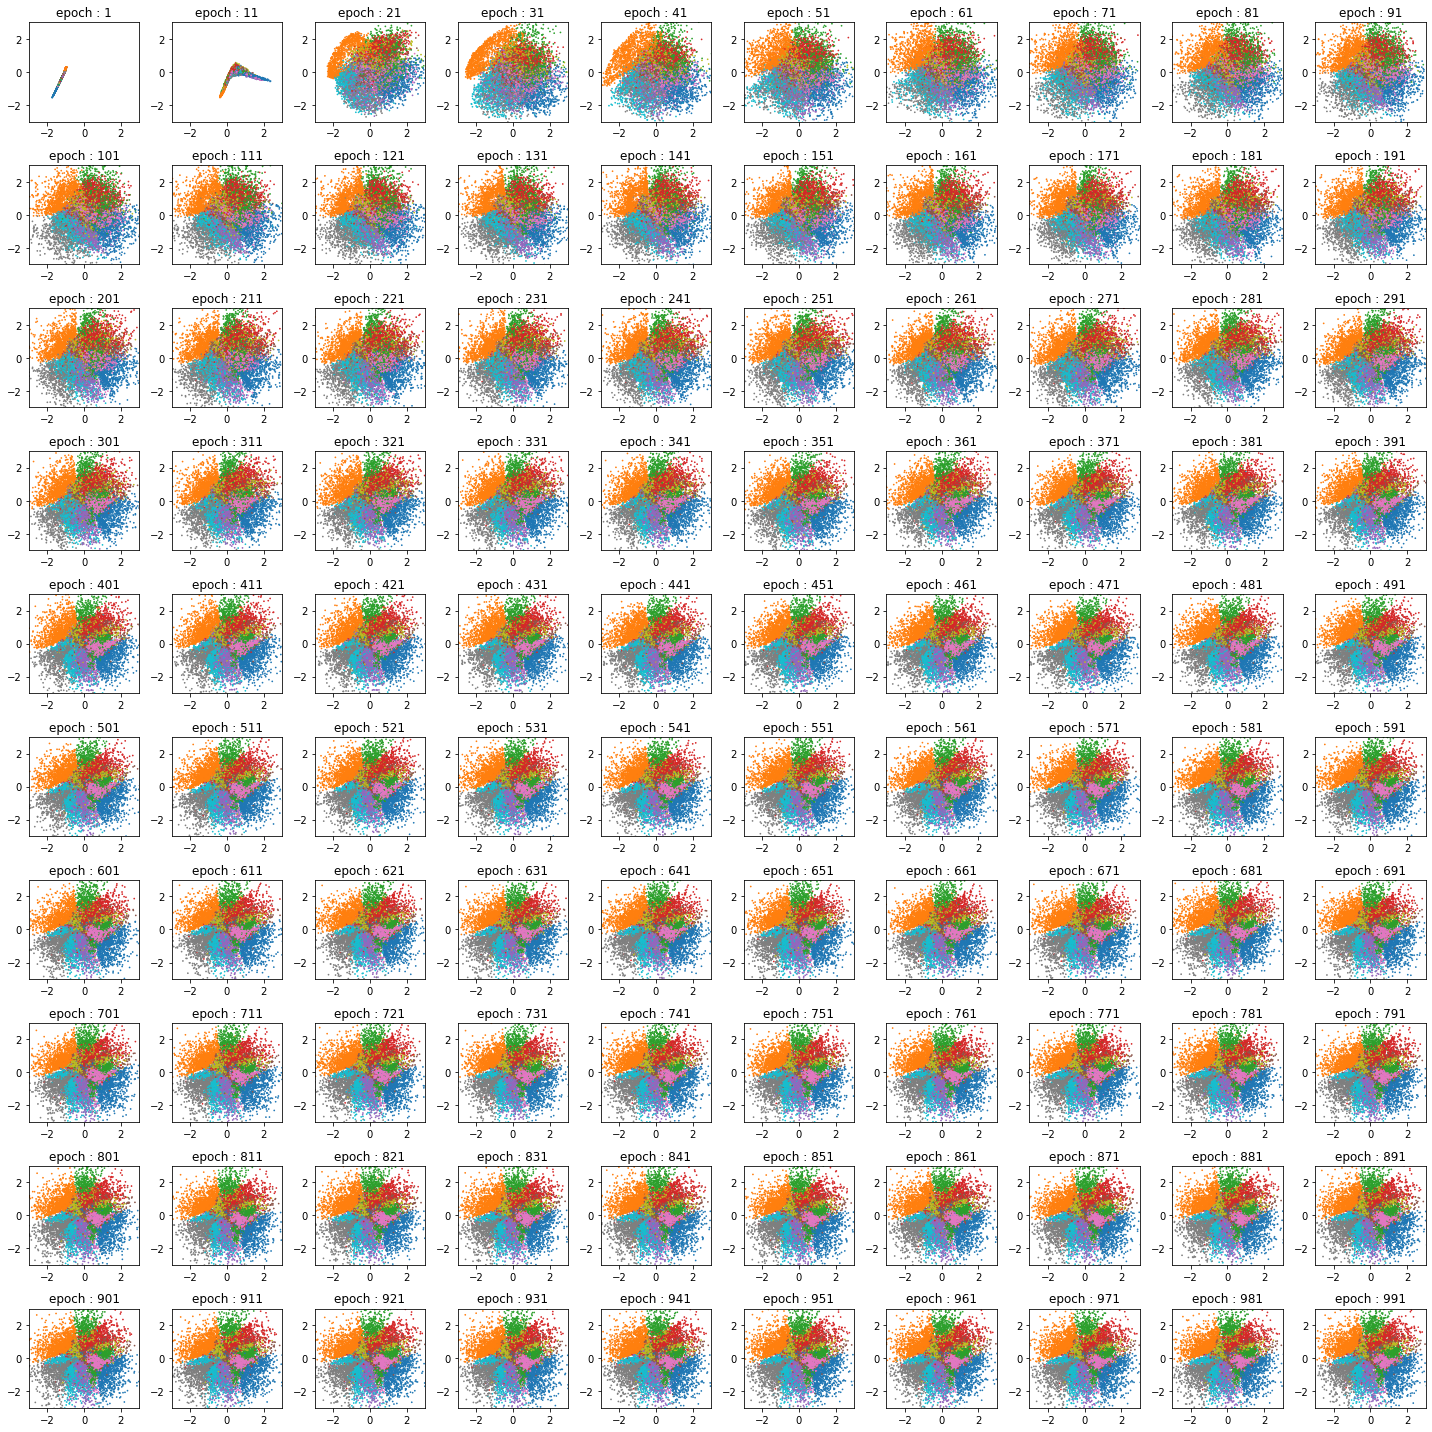

In [26]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i* 10][:,0], latent_history[i*10][:,1], c = y_test, cmap = plt.cm.tab10, s = .5)
    ax[i//10, i%10].set_title(f'epoch : {(i*10) + 1}')
    ax[i//10, i%10].set_xlim(-3,3)
    ax[i//10, i%10].set_ylim(-3,3)
plt.tight_layout()

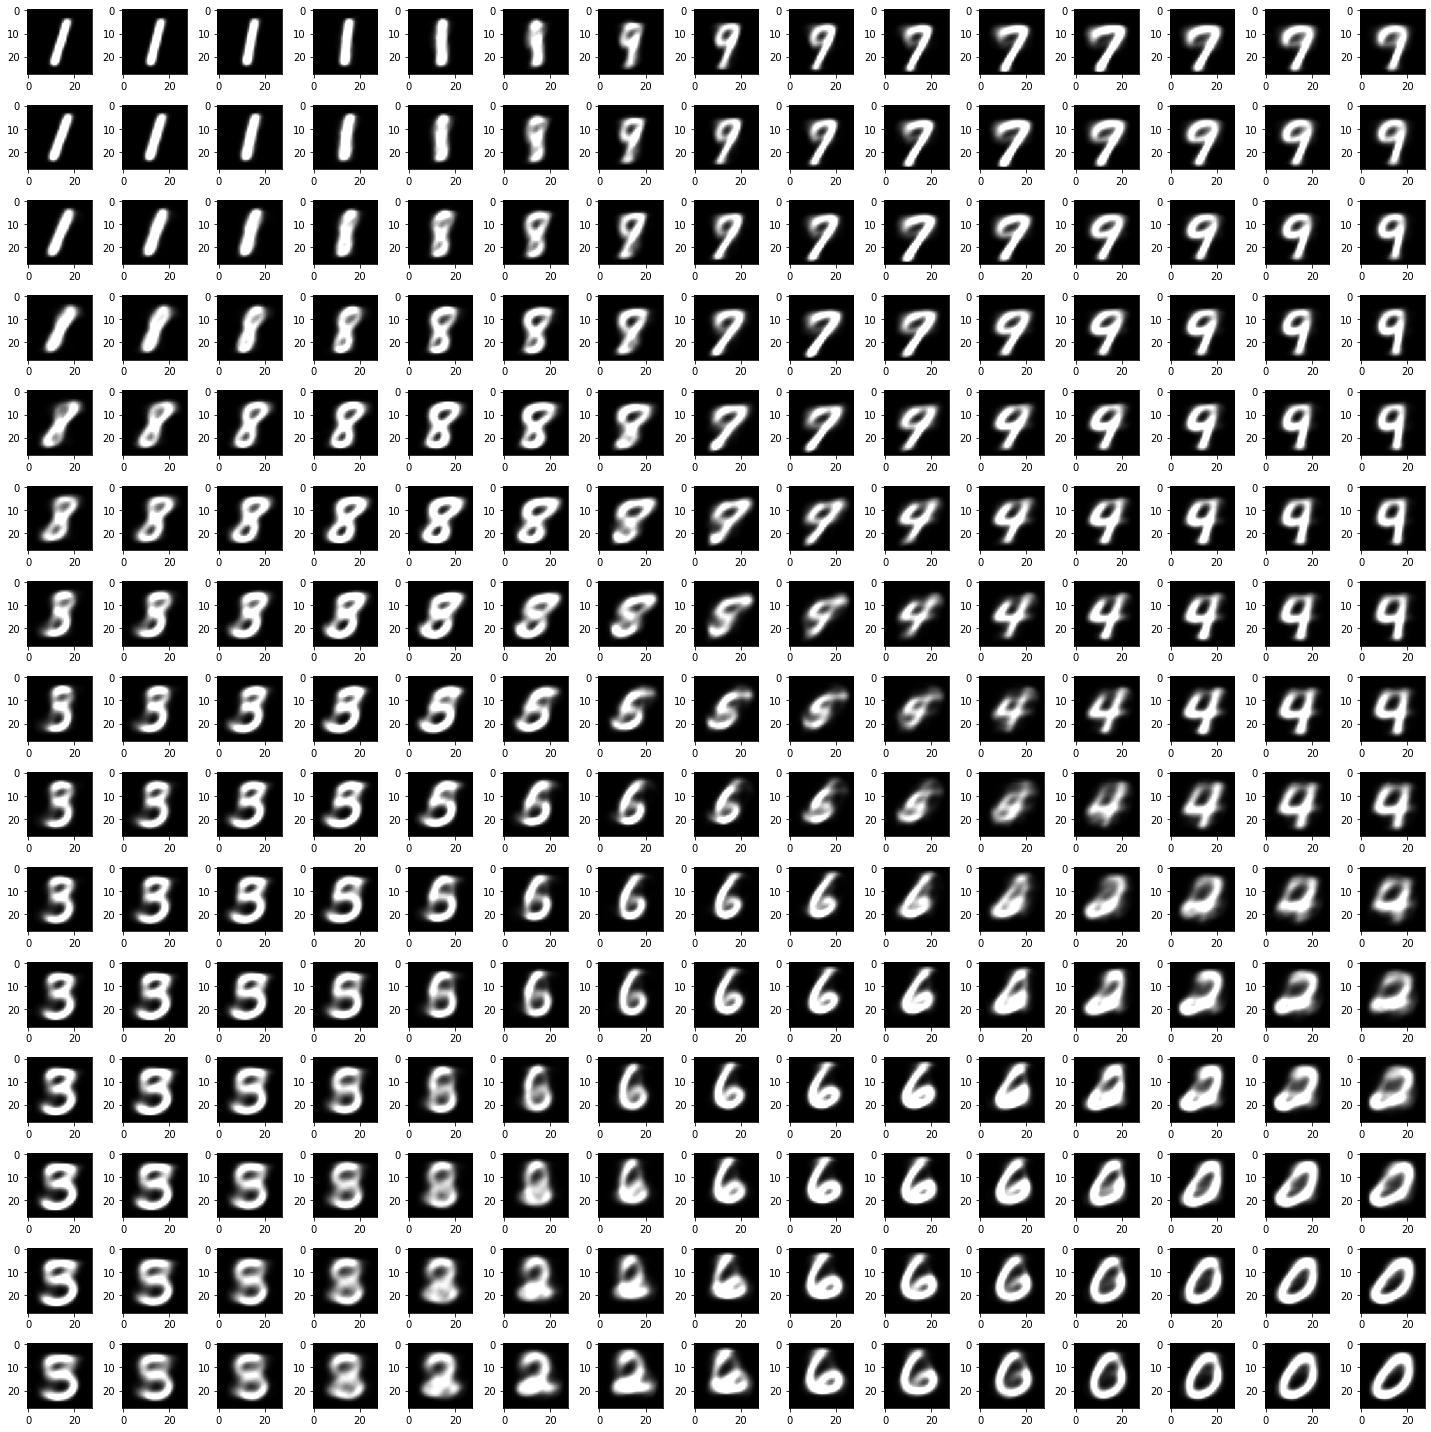

In [27]:
latent = tf.convert_to_tensor([[x,y] for x in np.linspace(-1, 1, 15) for y in np.linspace(1, -1, 15)], dtype = 'float32')
# latent = tf.random.normal(shape = (15*15,2), stddev=1.)
res = aae.decode(latent)
res = tf.reshape(res, shape = (15*15, 28, 28)).numpy()


fig, ax = plt.subplots(15, 15, figsize = (20,20))
for i in range(15*15):
    ax[i//15, i%15].imshow(res[i], cmap = 'gray', vmin=0., vmax=.6)
plt.tight_layout()

<h3>label incorporated adversarial autoencoder</h3>

In [91]:
class lr_AAE(tf.keras.Model):
    def __init__(self, n_layers, n_nodes, n_components, input_dim, n_categories, prior_distribution = 'gaussian'):
        super(lr_AAE, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.n_categories = n_categories
        self.input_dim = input_dim
        if prior_distribution not in ['gaussian', 'roll']:
            raise ValueError('prior must be gaussian or roll')
        else:
            self.prior_distribution = prior_distribution
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.input_dim])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[self.n_components])
        ] + [
            tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42)) for _ in range(self.n_layers)
        ] + [
            tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42))
        ])
        
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components + self.n_categories]),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 42), name = 'discriminator_z_output')
            ])

    @tf.function
    def encode(self, x):
        latent_z = self.encoder(x)
        return latent_z

    @tf.function
    def discriminate_z(self, z, y):
        inputs = tf.concat([z,y], axis = 1)
        output = self.discriminator_z(inputs)
        return output

    @tf.function
    def decode(self,z):
        reconstruction = self.decoder(z)
        return reconstruction
    
def compute_reconstruction_loss(x, reconstruction):
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

@tf.function
def train_step(model, x, y, r_optimizer, d_optimizer, g_optimizer):
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        reconstruction = model.decode(latent_z)
        reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #adversarial_z
    model.discriminator_z.trainable = True
    model.encoder.trainable = False
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_logit = model.discriminate_z(latent_z, y)
        true_z_logit = model.discriminate_z(true_output_z, y_true)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator_z
    model.discriminator_z.trainable = False
    model.encoder.trainable = True 
    with tf.GradientTape() as tape:
        latent_z = model.encode(x)
        fake_z_output = model.discriminate_z(latent_z, y)
        generator_z_loss = compute_generator_loss(fake_z_output)
    g_gradients = tape.gradient(generator_z_loss, model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    return reconstruction_loss, discriminator_z_loss, generator_z_loss          

@tf.function
def test_step(model, x, y):
    latent_z = model.encode(x)
    reconstruction = model.decode(latent_z)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    if model.prior_distribution == 'gaussian':
        true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42) * 5.
    if model.prior_distribution == 'roll':
        temp_z, temp_y = make_swiss_roll(n_samples=x.shape[0], noise=.1, random_state=42)
        true_output_z = tf.convert_to_tensor(temp_z[:,[0,2]], dtype = 'float32')
        y_true = tf.keras.utils.to_categorical(np.digitize(temp_y, np.linspace(4.712441162324161, 14.137091941626444, 10)) - 1,num_classes=10) 
    fake_z_logit = model.discriminate_z(latent_z, y)
    true_z_logit = model.discriminate_z(true_output_z, y_true)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    return reconstruction_loss, discriminator_z_loss, generator_z_loss

In [92]:
lr_aae = lr_AAE(2, 1000, 2, len(x_train[0]), 10, prior_distribution = 'roll')

r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_history = []
for i in tqdm(range(1000)):
    if i == 49:
        r_optimizer.lr = .0001
        d_optimizer.lr = .001
        g_optimizer.lr = .001
    elif i == 999:
        r_optimizer.lr = .00001
        d_optimizer.lr = .0001
        g_optimizer.lr = .0001
    rl, dl, gl = [], [], []
    for x_batch_train, y_batch_train in train_dataset:
        r, d, g = train_step(lr_aae, x_batch_train, y_batch_train, r_optimizer, d_optimizer, g_optimizer)
        rl.append(r)
        dl.append(d)
        gl.append(g)
    t_r, t_d, t_g = test_step(lr_aae, x_test, y_test_ohe)
    rl = np.mean(rl)
    dl = np.mean(dl)
    gl = np.mean(gl)
    latent_history.append(lr_aae.encode(x_test))
    print(f'epoch : {i} train set : [ reconstruction_loss : {rl}, discriminator_loss : {dl}, generator_loss : {gl}]\n test set : [ reconstruction_loss : {t_r}, discriminator_loss : {t_d}, generator_loss : {t_g}]')

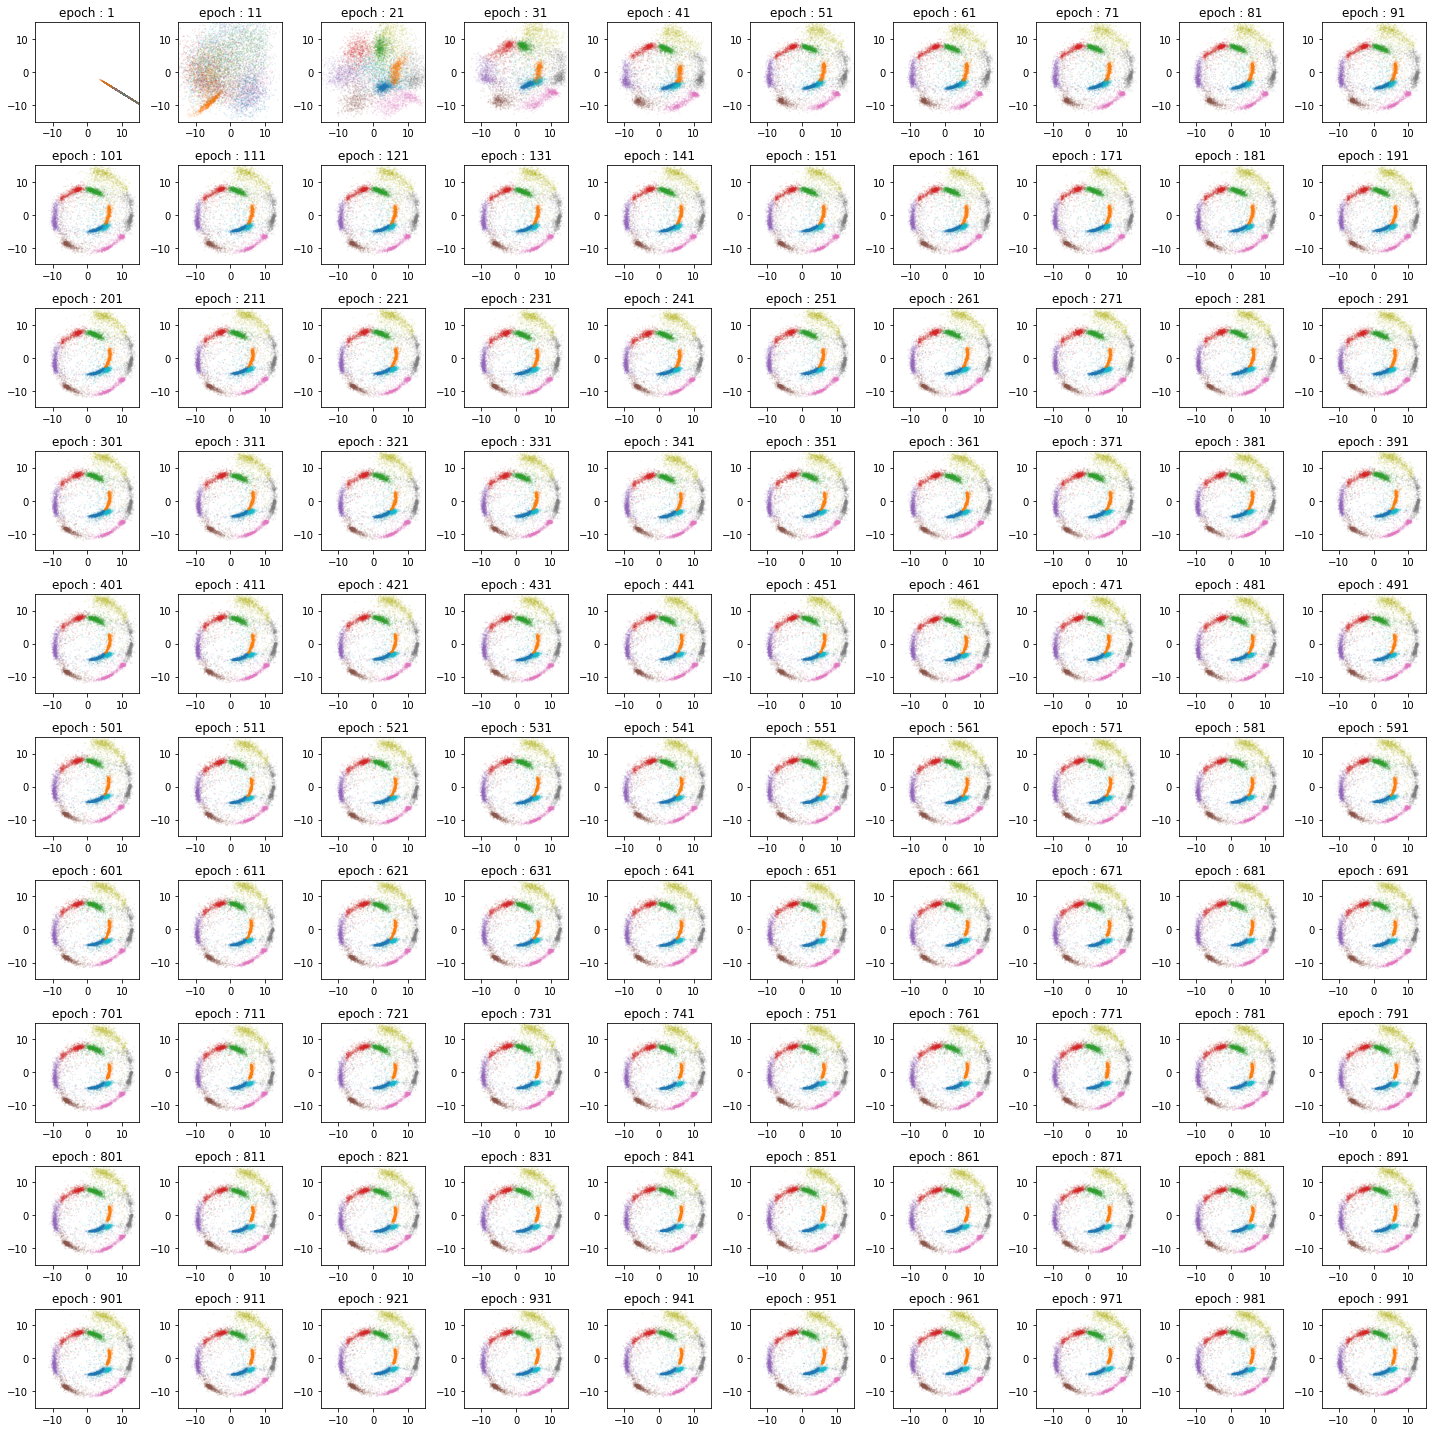

In [107]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_history[i * 10][:,0], latent_history[i * 10][:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7, s = .01)
    ax[i//10, i%10].set_title(f'epoch : {(i * 10) + 1}')
    ax[i//10, i%10].set_xlim(-15,15)
    ax[i//10, i%10].set_ylim(-15,15)
plt.tight_layout()

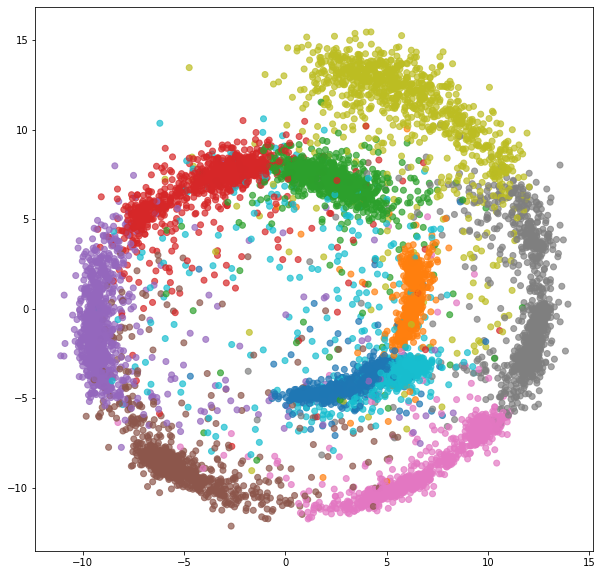

In [111]:
fig, ax = plt.subplots(figsize = (10, 10))
latent_z = lr_aae.encode(x_test)
ax.scatter(latent_z[:,0], latent_z[:,1], c = y_test, cmap = plt.cm.tab10, alpha = .7)

<a id='ssaae'><h3>semi-supervised autoencoder</h3></a>

In [8]:
class SSAAE(tf.keras.Model):
    def __init__(self, n_nodes, n_components, input_dim, n_categories, gaussian_noise:bool = True, stddev:float = .3, dropout:bool = False, dropout_rate:float = .2, batch_normalization:bool = False):
        '''
        ssaae 구성
        n_nodes : 모든 레이어(encoder, decoder, discriminator)들의 유닛 개수
        n_components : 잠재공간 z의 차원
        input_dim : X의 차원
        n_categores : y의 category 갯수
        gaussian_noise : input layer 직후에 gaussian noise layer 추가여부
        stddev : gaussian noise 추가시 noise의 표준편차
        dropout : input layer 직후에 dropout layer 추가여부
        dropout_rate : dropout layer 추가시 삭제할 비율
        batch_normalization : encoder와 decoder에 BN 추가여부
        
        layer의 갯수는 일단 논문과 같이 2개로 고정함.
        initializer도 stddev .01의 gaussian distribution으로 고정(논문따라서)
        '''
        super(SSAAE, self).__init__()
        np.random.seed(seed = 42)
        tf.random.set_seed(seed = 42)
        self.n_nodes = n_nodes
        self.n_components = n_components
        self.input_dim = input_dim
        self.n_categories = n_categories
        self.gaussian_noise = gaussian_noise
        self.dropout = dropout
        self.stddev = stddev
        self.dropout_rate = dropout_rate
        self.batch_normalization = batch_normalization
        self.acc = tf.keras.metrics.Accuracy() #추후비교용
        
        #encoder(q) == generator
        encoder_input = tf.keras.layers.Input(shape = [self.input_dim], name = 'encoder_input')
        if self.gaussian_noise:
            encoder_hidden = tf.keras.layers.GaussianNoise(stddev = self.stddev, name = 'gaussian_noise')(encoder_input)
        if self.dropout:
            encoder_hidden = tf.keras.layers.Dropout(rate = self.dropout_rate, name = 'dropout')(encoder_input)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        #encoder input 쪽이 부자연수럽긴한데 일단 구현하는게 목적이라 대충만듬.
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 1), name = 'encoder_hidden_1')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        encoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 2), name = 'encoder_hidden_2')(encoder_hidden)
        if self.batch_normalization:
            encoder_hidden = tf.keras.layers.BatchNormalization()(encoder_hidden)
        latent_z = tf.keras.layers.Dense(self.n_components, activation = 'linear', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 3), name = 'latent_z')(encoder_hidden)
        latent_y = tf.keras.layers.Dense(self.n_categories, activation = 'softmax', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 4), name = 'latent_y')(encoder_hidden)
        self.encoder = tf.keras.Model(inputs = [encoder_input], outputs = [latent_z, latent_y])
        '''
        X를 받아서 latent_z(gaussian distribution)과 latent_y(Categorical distribution)을 출력하는 encoder
        '''
        
        #decoder(p)
        decoder_input = tf.keras.layers.Input(shape = [self.n_components + self.n_categories], name = 'decoder_input')
        if self.batch_normalization:
            decoder_input = tf.keras.layers.BatchNormalization()(decoder_input)
        decoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 5), name = 'decoder_hidden_1')(decoder_input)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        decoder_hidden = tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 6), name = 'decoder_hidden_2')(decoder_hidden)
        if self.batch_normalization:
            decoder_hidden = tf.keras.layers.BatchNormalization()(decoder_hidden)
        reconstruction = tf.keras.layers.Dense(self.input_dim, kernel_initializer = tf.keras.initializers.RandomNormal(stddev = .01, seed = 7), name = 'reconstruction')(decoder_hidden)
        self.decoder = tf.keras.Model(inputs = [decoder_input], outputs = [reconstruction])
        '''
        latent_z와 latent_y를 받아 다시 X를 출력하는 decoder
        '''
        
        
        #discriminator_z
        self.discriminator_z = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_components], name = 'discriminator_z_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 8), name = 'discriminator_z_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 9), name = 'discriminator_z_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 10), name = 'discriminator_z_output')
            ])
        '''
        latent_z와 gaussian distribution을 받아 어떤것이 진짜인지 구별하는 discriminator_z
        '''
        
        #discriminator_y
        self.discriminator_y = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = [self.n_categories], name = 'discriminator_y_input'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 11), name = 'discriminator_y_1'),
                tf.keras.layers.Dense(self.n_nodes, activation = 'relu', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 12), name = 'discriminator_y_2'),
                tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.01, seed = 13), name = 'discriminator_y_output')
            ])
        '''
        latent_y와 categorical distribution(y)를 받아 어떤것이 진짜인지 구별해주는 discriminator_y
        '''
        
    #define forward propagation functions
    
    #reconstruction phase
    @tf.function
    def encode(self, x, training = False):
        '''
        X를받아 latent_z와 latent_y를 반환함.
        training은 gaussian noise layer 활성화를 위함
        '''
        latent_z, latent_y = self.encoder(x, training = training)
        return latent_z, latent_y
    
    #regularizatio phase
    @tf.function
    def decode(self, z, y):
        '''
        latent_z와 latent_y를 받아 reconstruction(X)를 반환함
        '''
        inputs = tf.concat([z, y], axis = 1)
        reconstruction = self.decoder(inputs)
        return reconstruction
    @tf.function
    def discriminate_z(self, z):
        '''
        gaussian distribution이나 latent_z를 받아 어떤것이 진짜(gaussian distribution)인지 logit을 반환
        '''
        output = self.discriminator_z(z)
        return output
    
    #semi-supervised classification phase
    @tf.function
    def discriminate_y(self, y):
        '''
        categorical_distribution(y)나 latent_y를 받아 어떤것이 진짜(categorical_dsitribution(y))인지 logit을 반환
        '''
        output = self.discriminator_y(y)
        return output

#define loss computing functions
def compute_reconstruction_loss(x, reconstruction):
    '''
    X와 재구성된 X(reconstruction)의 차이 계산
    half euclidean(논문따라)
    '''
    reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(x, reconstruction)) / 2.
    return reconstruction_loss

def compute_discriminator_loss(fake_logit, true_logit):
    '''
    discriminator의 fake distribution의 discriinator logit과 label(0)의 loss + true distribution의 discriminator과 label(1)의 loss 반환
    '''
    d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_logit,
                                                                         labels=tf.ones_like(true_logit)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,
                                                                         labels=tf.zeros_like(fake_logit)))
    discriminator_loss = d_loss_true + d_loss_fake
    return discriminator_loss

def compute_generator_loss(fake_output):
    '''
    fake distribution을 true distribution과 유사하게만들기 위해 fake distribution과 label(1)의 loss 반환
    '''
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                            labels=tf.ones_like(fake_output)))
    return generator_loss

def compute_classification_loss(x, y):
    '''
    minibatch 중 label된 y와 q(y|x)로 예측한 y_hat loss 반환
    '''
    classification_loss = tf.reduce_mean(K.categorical_crossentropy(target = x, output = y))
    return classification_loss

    
#define train function
@tf.function
def train_step(model, x, x_labeled, x_unlabeled, y, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer):
    '''
    train 내에서 minibatch의 label유무로 데이터분할하니 오류가생겨서 밖으로 뺌
    true_output_y도 내부에서 Cat(y)를 생성하면 에러가생겨서 밖으로 빼버림
    
    model : adversarial encoder
    x : minibatch x
    x_labeled : minibatch 중 label이 있는 x
    x_unlabeled : minibatch 중 label이 있는 x
    y : minibatch y
    y_labeled : minibatch 중 label이 있는 y
    optimizers : { r : reconstruction, d : discriminator, g : generator , ss :semi_supervised classification }
    '''
    
    # reconstruction
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x_unlabeled, True)
        reconstruction = model.decode(latent_z, latent_y)
        reconstruction_loss = compute_reconstruction_loss(x_unlabeled, reconstruction)
    r_gradients = tape.gradient(reconstruction_loss, model.trainable_variables)
    r_optimizer.apply_gradients(zip(r_gradients, model.trainable_variables))
    
    #regularization
    model.discriminator_z.trainable = True
    model.discriminator_y.trainable = True
    model.encoder.trainable = False
    #discriminator만 학습하기위해 encoder(generator 동결)
    true_output_z = tf.random.normal(shape=(latent_z.shape), stddev = 1., seed = 42)
    latent_z, latent_y = model.encode(x, True)
    #z
    with tf.GradientTape() as tape:
        fake_z_logit = model.discriminate_z(latent_z)
        true_z_logit = model.discriminate_z(true_output_z)
        discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    d_gradients = tape.gradient(discriminator_z_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))
    #y
    with tf.GradientTape() as tape:
        fake_y_logit = model.discriminate_y(latent_y)
        true_y_logit = model.discriminate_y(true_output_y)
        discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    d_gradients = tape.gradient(discriminator_y_loss, model.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, model.trainable_variables))

    # generator
    model.discriminator_z.trainable = False
    model.discriminator_y.trainable = False
    model.encoder.trainable = True
    #generator(encoder)만 학습하기 위해 discriminator 동결
    with tf.GradientTape() as tape:
        latent_z, latent_y = model.encode(x, True)
        fake_z_output = model.discriminate_z(latent_z)
        generator_z_loss = compute_generator_loss(fake_z_output)
        fake_y_output = model.discriminate_y(latent_y)
        generator_y_loss = compute_generator_loss(fake_y_output)
    g_gradients = tape.gradient([generator_z_loss, generator_y_loss], model.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, model.trainable_variables))

    #ss_classification
    with tf.GradientTape() as tape:
        _, latent_y = model.encode(x_labeled, True)
        classification_loss = compute_classification_loss(y_labeled, latent_y)
    ss_gradients = tape.gradient(classification_loss, model.trainable_variables)
    ss_optimizer.apply_gradients(zip(ss_gradients, model.trainable_variables))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss         

#define test function
@tf.function
def test_step(model, x, y, true_output_y):
    '''
    test set에 대해 앞에 말한것들을 돌려보고 결과값 반환
    training = False로 기본값 넣어둬서 gaussian noise layer가 deactive됨
    '''
    latent_z, latent_y = model.encode(x)
    reconstruction = model.decode(latent_z, latent_y)
    reconstruction_loss = compute_reconstruction_loss(x, reconstruction)
    
    true_output_z = tf.random.normal(shape=(latent_z.shape), seed = 42)
    fake_z_logit = model.discriminate_z(latent_z)
    true_z_logit = model.discriminate_z(true_output_z)
    fake_y_logit = model.discriminate_y(latent_y)
    true_y_logit = model.discriminate_y(true_output_y)
    discriminator_z_loss = compute_discriminator_loss(fake_z_logit, true_z_logit)
    discriminator_y_loss = compute_discriminator_loss(fake_y_logit, true_y_logit)
    generator_z_loss = compute_generator_loss(fake_z_logit)
    generator_y_loss = compute_generator_loss(fake_y_logit)
    
    classification_loss = compute_classification_loss(y, latent_y)
    accuracy = model.acc(tf.argmax(y, axis = 1), tf.argmax(latent_y, axis = 1))
    
    return reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss, accuracy

<h5>학습데이터 불러오기 및 모델, optimizer 정의</h5>

mnist에 대해 미리 돌려보고 작동 잘 하는지 확인한다음에 project에 적용해볼것임

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
color = y_test

y_train = y_train.astype('float32')
#원래 하려했던 책 분류의 경우처럼 97%를 na로 날림
for i in range(600):
    y_train[i * 100:(i*100)+97] = np.nan
    
#cat(y)
idx, counts = np.unique(y_train[~np.isnan(y_train)], return_counts = True)
y_prob = counts / counts.sum()
y_train = tf.convert_to_tensor(y_train, dtype = 'float32')

x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_train = tf.convert_to_tensor(x_train, dtype='float32')
x_test = tf.convert_to_tensor(x_test, dtype = 'float32')
y_test = tf.convert_to_tensor(pd.get_dummies(y_test), dtype = 'float32')

#1000 units, 10-D gaussian, inputshape, 10 categories, ...
ssaae = SSAAE(1000, 10, x_train.shape[1], 10, gaussian_noise= True)

#appendix 그대로 넣었더니 발산해서 1/5로 줄였더니발산해서 1/10으로 줄임
r_optimizer = tf.keras.optimizers.SGD(learning_rate = .001, momentum = .9)
ss_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .9)
d_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)
g_optimizer = tf.keras.optimizers.SGD(learning_rate = .01, momentum = .1)

In [ ]:
latent_y_history = []
latent_z_history = []
rh = []
dzh = []
dyh = []
gzh = []
gyh = []
ssch = []

y_categories = 10
    

    
for j in tqdm(range(5000)):
    #epoch 500
    if j == 49:
        r_optimizer.lr  = r_optimizer.lr / 10.
        ss_optimizer.lr = ss_optimizer.lr / 10.
        d_optimizer.lr = d_optimizer.lr / 10.
        g_optimizer.lr = g_optimizer.lr / 10.
    if j == 499:
        r_optimizer.lr  = r_optimizer.lr / 10.
        ss_optimizer.lr = ss_optimizer.lr / 10.
        d_optimizer.lr = d_optimizer.lr / 10.
        g_optimizer.lr = g_optimizer.lr / 10.
    
    reconstruction_loss, discriminator_z_loss, discriminator_y_loss, generator_z_loss, generator_y_loss, classification_loss = [],[],[],[],[],[]
    for i in range(600):
        #preprocessing
        #mini batch 구성하고 label여부로 minibatch 내에서 구분
        x_batch_train = x_train[i * 100:(i+1)*100]
        y_batch_train = y_train[i * 100:(i+1)*100]
        mask = tf.math.is_nan(y_batch_train)
        x_unlabeled = tf.boolean_mask(x_batch_train, mask)
        x_labeled = tf.boolean_mask(x_batch_train, ~mask)
        y_labeled = tf.boolean_mask(y_batch_train, ~mask)
        y_labeled = tf.keras.utils.to_categorical(y_labeled, num_classes = y_categories)
        true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = 10)
        
        #train
        r, dz, dy, gz, gy, s = train_step(ssaae, x_batch_train, x_labeled, x_unlabeled, y_batch_train, y_labeled, true_output_y, r_optimizer, d_optimizer, g_optimizer, ss_optimizer)
        reconstruction_loss.append(r)
        discriminator_z_loss.append(dz)
        discriminator_y_loss.append(dy)
        generator_z_loss.append(gz)
        generator_y_loss.append(gy)
        classification_loss.append(s)
    
    #test
    true_output_y = tf.keras.utils.to_categorical(np.random.choice(np.arange(y_categories), size = x_batch_train.shape[0], p = y_prob), num_classes = y_categories)
    test_reconstruction, test_discriminator_z, test_discriminator_y, test_generator_z, test_generator_y, test_classification, test_accuracy = test_step(ssaae, x_test, y_test, true_output_y)
    reconstruction_loss = np.mean(reconstruction_loss)
    discriminator_z_loss = np.mean(discriminator_z_loss)
    discriminator_y_loss = np.mean(discriminator_y_loss)
    generator_z_loss = np.mean(generator_z_loss)
    generator_y_loss = np.mean(generator_y_loss)
    classification_loss = np.mean(classification_loss)
    
    #test결과 plot으로 넣어주기위해 가져옴
    rh.append(test_reconstruction)
    dzh.append(test_discriminator_z)
    dyh.append(test_discriminator_y)
    gzh.append(test_generator_z)
    gyh.append(test_generator_y)
    ssch.append(test_accuracy)
    #잠재공간들도 시각화위해 저장
    z, y =ssaae.encode(x_test)
    latent_y_history.append(y)
    latent_z_history.append(z)
    
    print(f'epoch : {j + 1} train set : [ reconstruction_loss : {reconstruction_loss}, discriminator_z_loss : {discriminator_z_loss}, discriminator_y_loss : {discriminator_y_loss}, generator_z_loss : {generator_z_loss}, generator_y_loss : {generator_y_loss}, classification_loss : {classification_loss}]')
    print(f'epoch : {j + 1} test set : [ reconstruction_loss : {test_reconstruction}, discriminator_z_loss : {test_discriminator_z}, discriminator_y_loss : {test_discriminator_y}, generator_z_loss : {test_generator_z}, generator_y_loss : {test_generator_y}, classification_loss : {test_classification}, test_accuracy : {test_accuracy}]')

<h5>latent_z의 1,2차원의 변화를 시각화해봄</h5>

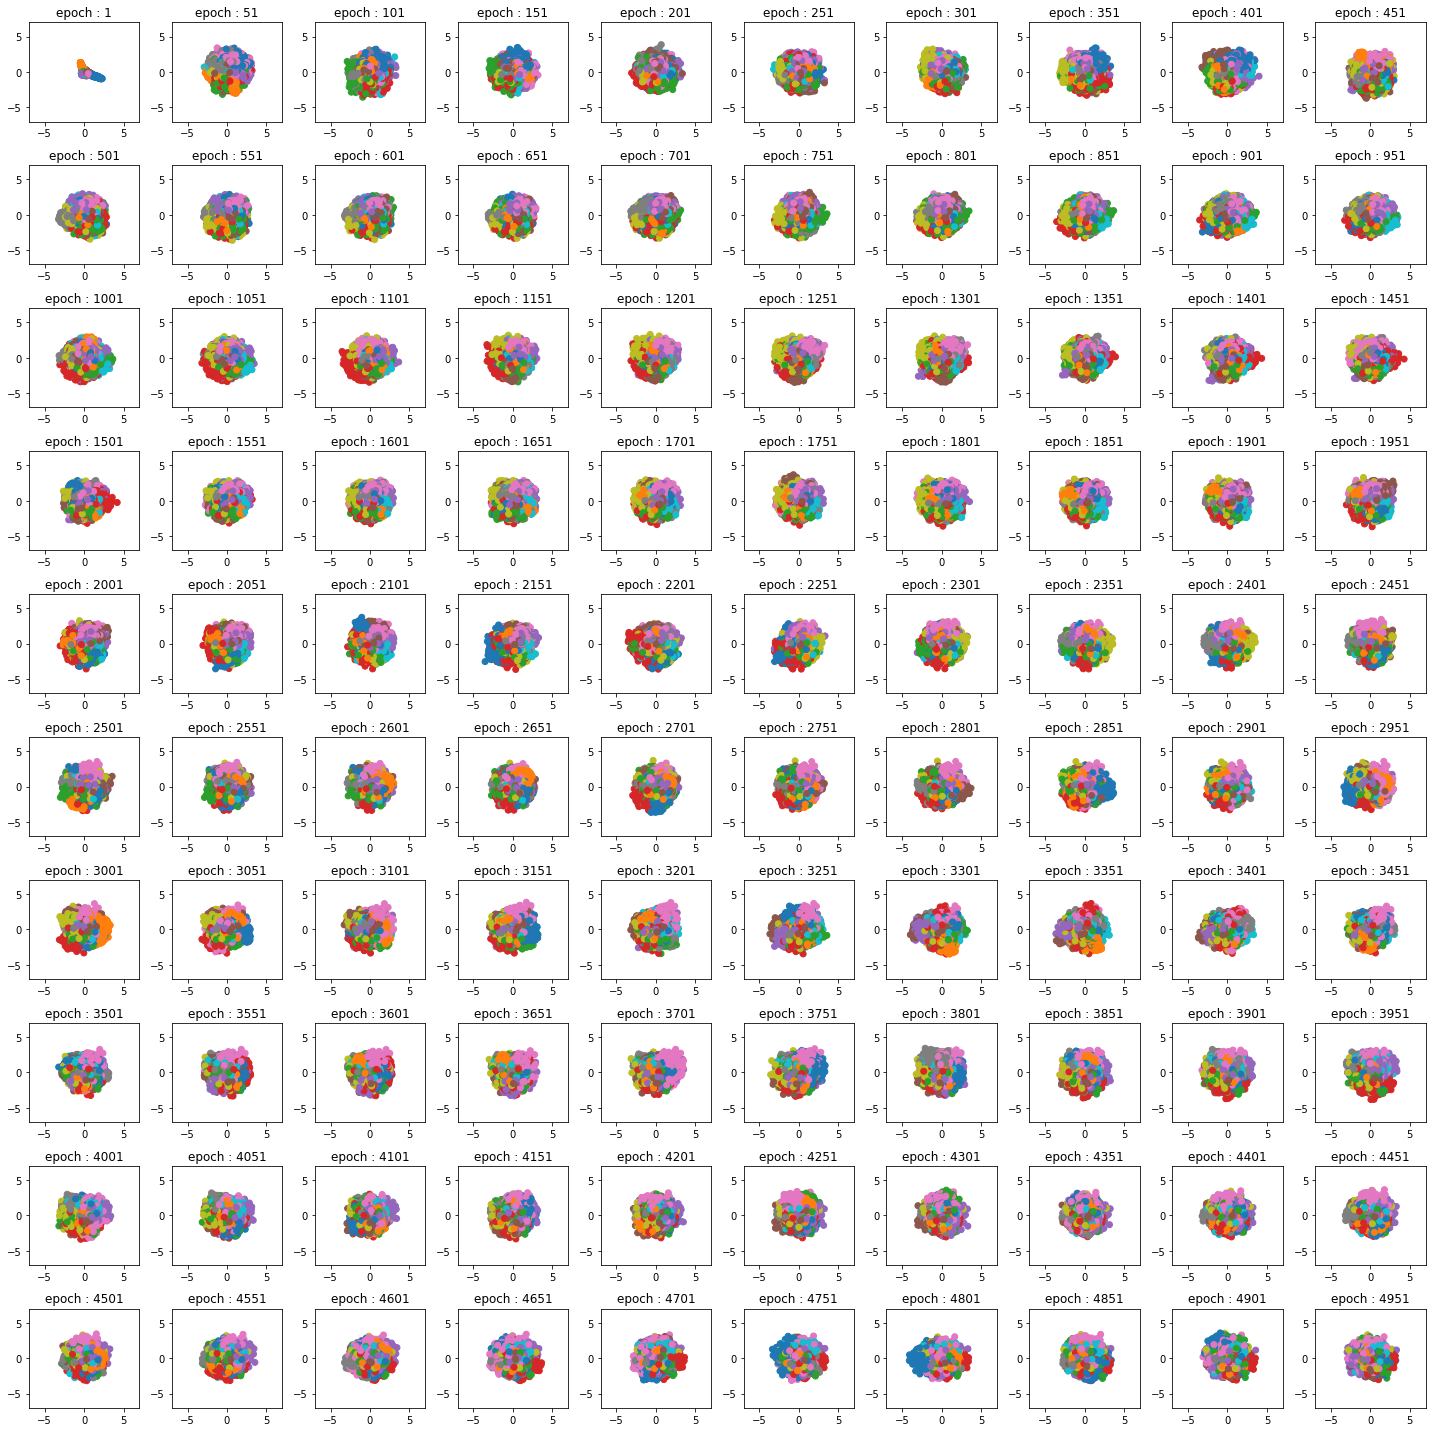

In [11]:
fig, ax = plt.subplots(10, 10, figsize = (20,20))
for i in range(100):
    ax[i//10, i%10].scatter(latent_z_history[i*50][:,0], latent_z_history[i*50][:,1], c = color, cmap = plt.cm.tab10)
    ax[i//10, i%10].set_title(f'epoch : {(i * 50) + 1}')
    ax[i//10, i%10].set_xlim(-7,7)
    ax[i//10, i%10].set_ylim(-7,7)
plt.tight_layout()

<h5>결과 encoder의 latent_z의 10차원을 각각 찍어봄</h5>

모든 차원이 gaussian distribution을 잘따라고있는것이 보임.

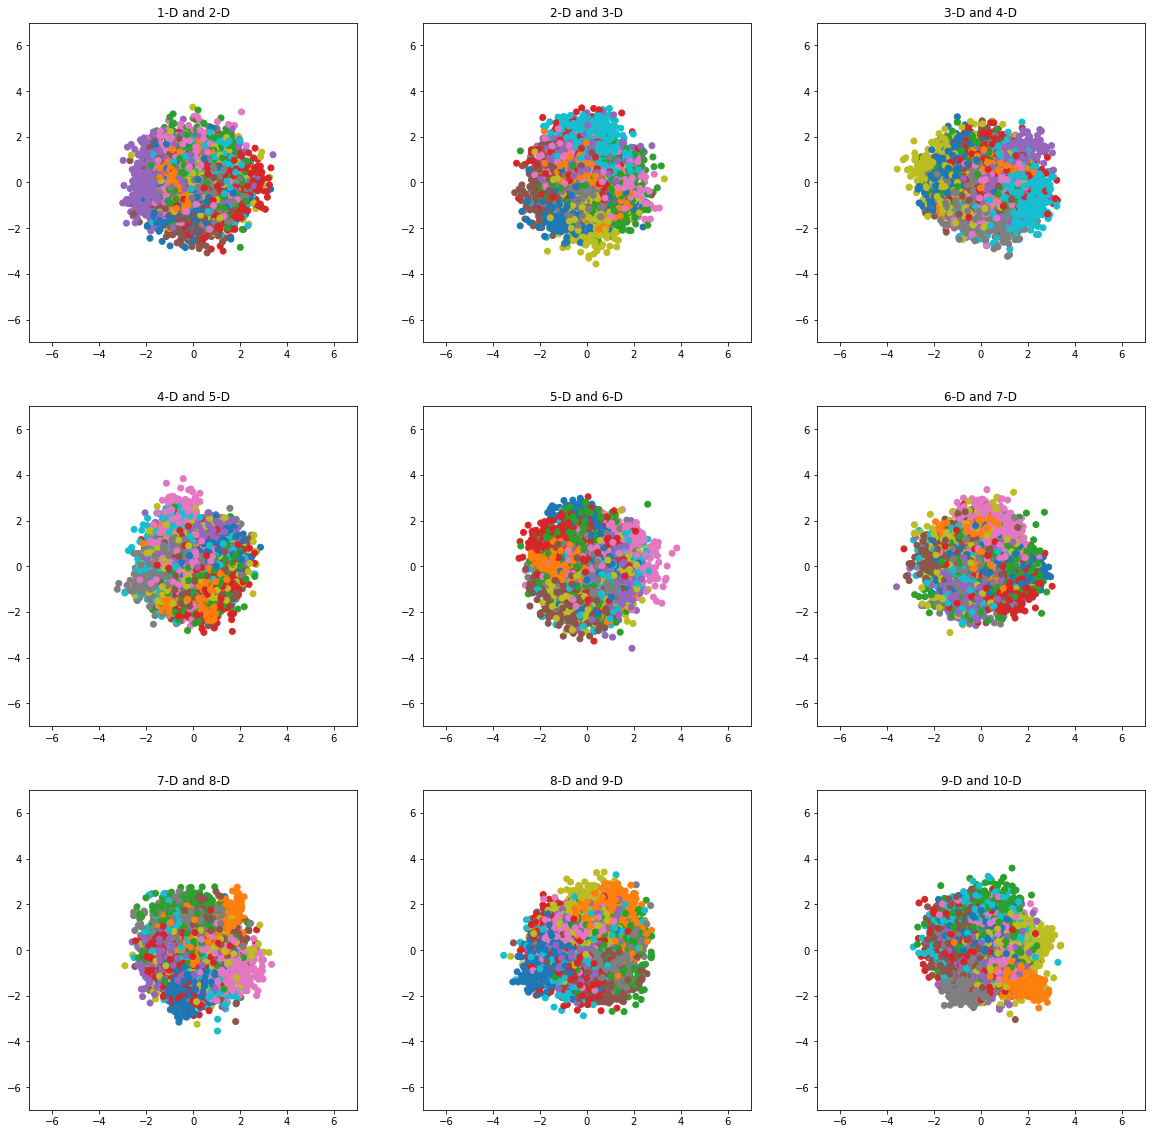

In [12]:
fig, ax = plt.subplots(3,3, figsize = (20, 20))
latent_z, _ = ssaae.encoder(x_test)
for i in range(9):
    ax[i//3, i%3].scatter(latent_z[:,i], latent_z[:,i+1], c = color, cmap = plt.cm.tab10)
    ax[i//3, i%3].set_title(f'{i+1}-D and {i+2}-D')
    ax[i//3, i%3].set_xlim(-7,7)
    ax[i//3, i%3].set_ylim(-7,7)

<h5>500 epochs동안 test set의 loss와 accuracy 시각화</h5>

Text(0.5, 1.0, 'semi-supervised classification accuracy')

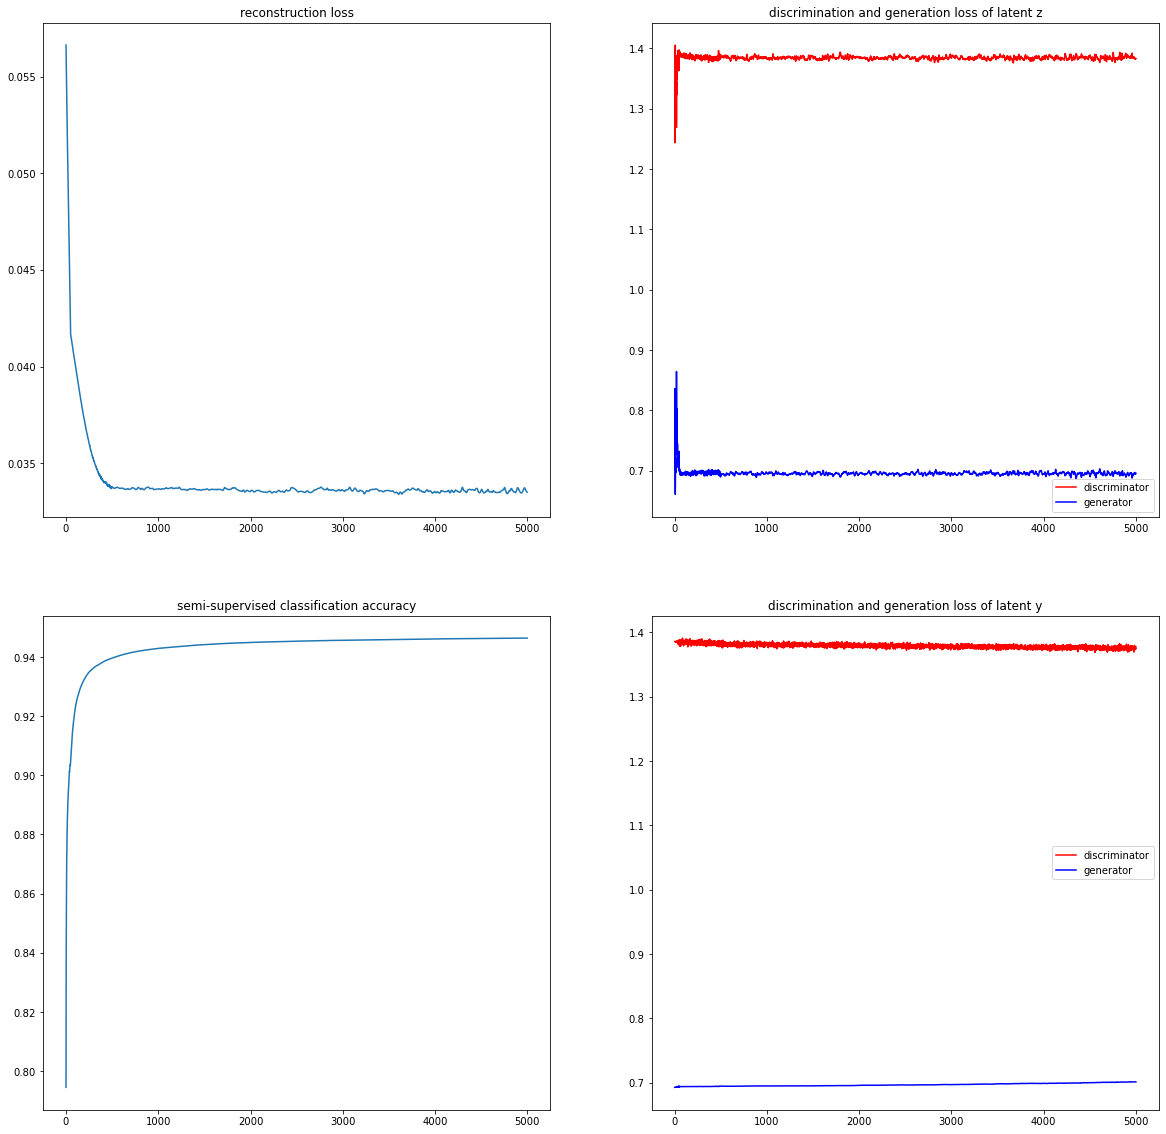

In [13]:
fig, ax = plt.subplots(2,2, figsize = (20,20))


ax[0,0].plot(rh)
ax[0,0].set_title('reconstruction loss')
ax[0,1].plot(dzh, color = 'red', label = 'discriminator')
ax[0,1].plot(gzh, color = 'blue', label = 'generator')
ax[0,1].legend()
ax[0,1].set_title('discrimination and generation loss of latent z')
ax[1,1].plot(dyh, color = 'red', label = 'discriminator')
ax[1,1].plot(gyh, color = 'blue', label = 'generator')
ax[1,1].legend()
ax[1,1].set_title('discrimination and generation loss of latent y')
ax[1,0].plot(ssch)
ax[1,0].set_title('semi-supervised classification accuracy')

https://arxiv.org/pdf/1511.05644.pdf


appendix A:

encoder ,decoder ,discriminator 모두 2 layer, 1000 units, relu  
cost function : half euclidean  
encoder last layer : softmax, linear  
latent_z : 10-D gaussian  
semi supervised classification cost function : CE  
momentum sgd : reconstruction, semi-supervised .9 / discriminator, generator .1  
lr : reconstruction .01  /  semi-supervised, discriminator, generator .1  
gaussian noise stddev .3 for train  
no dropout, l2reg, gaussian noise for other layers  
bn does not helps for MNIST